# Spike History Analysis (LMC minimal dataset)

This notebook uses the cache builder in `scripts/spikehistory_cache_builder.py` to generate per-recording firing-rate and spike-time caches from the minimal analog dataset (`/Volumes/MannySSD/lmc_project_v2_MINIMAL`).

**Important:** The builder writes to a fresh output base; if that path already exists, it aborts to avoid overwriting. Update `output_base` below if needed.

In [5]:
from pathlib import Path
import sys
import numpy as np
import pandas as pd

# Ensure repo is on sys.path
repo_root = Path('/Users/ecrespo/Documents/github_project_folder/mua_analysis')
if not repo_root.exists():
    repo_root = Path.cwd().resolve().parent
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))

from scripts.spikehistory_cache_builder import SpikeHistoryCacheBuilder

# Configure paths
DATA_ROOT = Path('/Volumes/MannySSD/lmc_project_v2_MINIMAL') 
OUTPUT_BASE = Path('/Volumes/MannySSD/PSTH_regenerated_cache_lmc_run14_all')

# Initialize builder (does not run yet)
builder = SpikeHistoryCacheBuilder(data_root=DATA_ROOT, output_base=OUTPUT_BASE)

In [ ]:
# Build caches into OUTPUT_BASE if they don't exist yet
if OUTPUT_BASE.exists():
    print(f"{OUTPUT_BASE} already exists. If you want a fresh run, change OUTPUT_BASE to a new folder.")
else:
    print(f"Building caches into {OUTPUT_BASE} ...")
    builder.run()
    print("Done.")


In [ ]:
builder.summarize_output(base=OUTPUT_BASE, max_records=10)

In [ ]:
# Inspect inputs (paths and availability)
inputs_df = builder.summarize_inputs()

In [ ]:
modality = "Whisker"   # or "LED"
rec_group = "Lmc_opsin"
rec_name = "lmc_ch_1_3094_rec1"

rec_dir = OUTPUT_BASE / modality / rec_group / rec_name
if not rec_dir.exists():
    raise FileNotFoundError(f"Cache not found at {rec_dir}")
summary = builder.inspect_recording_cache(rec_dir, verbose=True)
summary

In [ ]:
from pathlib import Path
matches = list(OUTPUT_BASE.glob("*/Lmc_opsin/lmc_ch_1_3094_rec1"))
print(matches)  # pick the LED or Whisker one

In [ ]:
from pathlib import Path
import numpy as np, pandas as pd

modality = "Whisker"   # or "LED"
rec_group = "Lmc_opsin"
rec_name = "lmc_ch_1_3094_rec1"

rec_dir = Path(OUTPUT_BASE) / modality / rec_group / rec_name
trials = pd.read_parquet(rec_dir / 'trials.parquet')
fhz = np.load(rec_dir / 'firing_tensor.npz', allow_pickle=True)['firing_hz']

print("[DEBUG] rec_dir:", rec_dir)
print("[DEBUG] fhz shape:", fhz.shape)
print("[DEBUG] overall min/max/mean:", fhz.min(), fhz.max(), fhz.mean())
print("[DEBUG] nonzero entries:", np.count_nonzero(fhz))

for stim_id in sorted(trials['stim_id'].unique()):
    idx = trials.index[trials['stim_id'] == stim_id].to_numpy()
    data = fhz[:, idx, :]
    print(f"[DEBUG] stim {stim_id}: trials {len(idx)}, min/max/mean:",
          data.min(), data.max(), data.mean())

print("[DEBUG] sample trace ch0 trial0 first 10 bins:", fhz[0, 0, :10])



In [ ]:
rec = load_cache("Lmc_opsin", "lmc_ch_1_3094_rec1")  # or any group/recording in run12
plot_pre_post_by_order(rec["fhz"], rec["tms"], rec["trials"],
                       stim_ids=[1,2,3,4], pre_trials=30, post_trials=30, channels=[0,1,2])


In [ ]:
from pathlib import Path
import pandas as pd

OUTPUT_BASE = Path('/Volumes/MannySSD/PSTH_regenerated_cache_lmc_run12')

for meta_path in sorted(OUTPUT_BASE.glob("*/*/meta.parquet")):
    meta = pd.read_parquet(meta_path)
    trials = pd.read_parquet(meta_path.parent / "trials.parquet")
    print(meta_path.parent)
    print(meta[["recording_name","group_name","modality"]])
    print({int(s): int((trials["stim_id"]==s).sum()) for s in trials["stim_id"].unique()})


for opto/led recordings confirmation of files/ready for downstream anaylsis

In [6]:
from pathlib import Path
import pandas as pd
base = Path("/Volumes/MannySSD/PSTH_custom_bin_1ms_gauss10ms_run17")  # or your current OUTPUT_BASE
meta_led = sorted(base.glob("LED/*/*/meta.parquet"))
meta_wh  = sorted(base.glob("Whisker/*/*/meta.parquet"))
print("LED metas:", len(meta_led), "Whisker metas:", len(meta_wh))
for m in meta_led:
    meta = pd.read_parquet(m)
    print("LED", meta.iloc[0]["group_name"], meta.iloc[0]["recording_name"])


LED metas: 5 Whisker metas: 5
LED Lmc_noopsin lmc_noch_1_3096_rec1
LED Lmc_noopsin lmc_noch_1_3096_rec2
LED Lmc_opsin lmc_ch_1_3094_rec1
LED Lmc_opsin lmc_ch_1_3094_rec2
LED Lmc_opsin lmc_ch_2_3093_rec1


In [7]:
from pathlib import Path
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import ast

def report_bad_channels():
    for modality in ["LED", "Whisker"]:
        rr_path = DATA_ROOT / modality / "SpikeStuff" / "recording_results.csv"
        if not rr_path.exists():
            continue
        df = pd.read_csv(rr_path)
        print(f"\n[{modality}]")
        for _, row in df.iterrows():
            good = ast.literal_eval(row["good_channels"])
            bad = ast.literal_eval(row["noisy_channels"]) if "noisy_channels" in row else []
            all_ch = set(good) | set(bad)
            # assume 0..31; mark anything not in good as bad
            full = set(range(32))
            inferred_bad = sorted(full - set(good))
            print(f"{row['group_name']} {row['recording_name']}: "
                  f"good={len(good)} -> {good} | bad (from CSV)={bad} | inferred bad={inferred_bad}")

def get_good_channels(modality, group, rec):
    rr = pd.read_csv(DATA_ROOT / modality / 'SpikeStuff' / 'recording_results.csv')
    row = rr.query("group_name == @group and recording_name == @rec").iloc[0]
    return ast.literal_eval(row['good_channels'])

def load_cache(modality, rec_group, rec_name):
    rec_dir = OUTPUT_BASE / modality / rec_group / rec_name
    return {
        "rec_dir": rec_dir,
        "meta": pd.read_parquet(rec_dir / "meta.parquet"),
        "trials": pd.read_parquet(rec_dir / "trials.parquet"),
        "fhz": np.load(rec_dir / "firing_tensor.npz")["firing_hz"],
        "tms": np.load(rec_dir / "firing_tensor.npz")["time_ms"],
        "spikes_rel": np.load(rec_dir / "spikes_relative.npz", allow_pickle=True)["spikes_rel"],
    }

def _split_indices(idx_list, pre_trials=None, post_trials=None):
    if pre_trials is not None and post_trials is not None and len(idx_list) >= pre_trials + post_trials:
        return idx_list[:pre_trials], idx_list[pre_trials:pre_trials+post_trials]
    # fallback: half-split whatever exists
    half = len(idx_list)//2
    return idx_list[:half], idx_list[half:]

def plot_pre_post_by_order(fhz, tms, trials_df, stim_ids=(1,2,3,4),
                           pre_trials=30, post_trials=30, channels=(0,)):
    fig, axs = plt.subplots(len(channels), len(stim_ids),
                            figsize=(4*len(stim_ids), 3*len(channels)), squeeze=False)
    for ci, ch in enumerate(channels):
        for si, stim in enumerate(stim_ids):
            ax = axs[ci, si]
            idx_all = trials_df.index[trials_df["stim_id"] == stim].to_list()
            pre_idx, post_idx = _split_indices(idx_all, pre_trials, post_trials)
            print(f"[DEBUG] stim {stim} ch {ch}: total {len(idx_all)}, pre {len(pre_idx)}, post {len(post_idx)}")
            if pre_idx:
                data = fhz[ch, pre_idx, :]
                m = data.mean(axis=0); s = data.std(axis=0)/np.sqrt(data.shape[0])
                ax.plot(tms, m, color="grey", lw=2, label=f"Pre n={len(pre_idx)}")
                ax.fill_between(tms, m-s, m+s, color="grey", alpha=0.25)
            if post_idx:
                data = fhz[ch, post_idx, :]
                m = data.mean(axis=0); s = data.std(axis=0)/np.sqrt(data.shape[0])
                ax.plot(tms, m, color="blue", lw=2, label=f"Post n={len(post_idx)}")
                ax.fill_between(tms, m-s, m+s, color="blue", alpha=0.25)
            ax.axvline(0, color="red", ls="--")
            ax.set_title(f"Ch {ch} Stim {stim}")
            ax.legend()
    plt.tight_layout(); plt.show()

def debug_pool(modality_filter=None, stim_ids=(1,2,3,4)):
    rec_dirs = sorted(OUTPUT_BASE.glob("*/*/*/meta.parquet"))
    print(f"[DEBUG] scanning {len(rec_dirs)} meta files under {OUTPUT_BASE}")
    for meta_path in rec_dirs:
        meta = pd.read_parquet(meta_path)
        modality = meta.iloc[0].get("modality","")
        if modality_filter and modality != modality_filter:
            continue
        rec_dir = meta_path.parent
        rec_group = meta.iloc[0].get("group_name")
        trials = pd.read_parquet(rec_dir/"trials.parquet")
        counts = {s: int((trials["stim_id"] == s).sum()) for s in stim_ids}
        print(f"[DEBUG] {modality} {rec_group} {rec_dir.name} counts={counts}")

def debug_chemicalstim(pre_trials=30, post_trials=30, stim_ids=(1,2,3,4)):
    rec_dirs = sorted(OUTPUT_BASE.glob("*/*/*/meta.parquet"))
    print(f"[DEBUG] scanning {len(rec_dirs)} caches under {OUTPUT_BASE}")
    for meta_path in rec_dirs:
        meta = pd.read_parquet(meta_path)
        rec_dir = meta_path.parent
        rec_name = meta.iloc[0]["recording_name"]
        group = meta.iloc[0]["group_name"]
        modality = meta.iloc[0].get("modality","")
        trials = pd.read_parquet(rec_dir / "trials.parquet")
        print(f"{modality} {group} {rec_name}")
        for stim in stim_ids:
            idx_all = trials.index[trials["stim_id"] == stim].to_list()
            total = len(idx_all)
            if total >= pre_trials + post_trials:
                pre = pre_trials
                post = post_trials
            else:
                half = total // 2
                pre = half
                post = total - half
            print(f"  stim {stim}: total {total}, pre {pre}, post {post}")

def plot_whisker_groups_prepost(stim_ids=(1,2,3,4), pre_trials=30, post_trials=30, channels="all"):
    def split(idx_list):
        if len(idx_list) >= pre_trials + post_trials:
            return idx_list[:pre_trials], idx_list[pre_trials:pre_trials+post_trials]
        half = len(idx_list)//2
        return idx_list[:half], idx_list[half:]

    pools = {g:{s:{"pre":[], "post":[]} for s in stim_ids} for g in ["Lmc_noopsin","Lmc_opsin"]}
    tms_ref = None
    rec_dirs = sorted(OUTPUT_BASE.glob("Whisker/*/*/meta.parquet"))
    print(f"[DEBUG] found {len(rec_dirs)} Whisker meta files under {OUTPUT_BASE}")

    # per-recording channel counts
    rec_chan_counts = []

    for meta_path in rec_dirs:
        meta = pd.read_parquet(meta_path)
        rec_group = meta.iloc[0]["group_name"]
        rec_name  = meta.iloc[0]["recording_name"]
        chans = get_good_channels('Whisker', rec_group, rec_name)
        ch_list = chans # use only good channels that are not noisy
        rec_dir = meta_path.parent
        trials = pd.read_parquet(rec_dir/"trials.parquet")
        firing = np.load(rec_dir/"firing_tensor.npz")
        fhz = firing["firing_hz"]; tms = firing["time_ms"]
        if tms_ref is None: tms_ref = tms
        ch_list = range(fhz.shape[0]) if channels=="all" else channels
        rec_chan_counts.append((rec_group, rec_name, len(ch_list)))

        for stim in stim_ids:
            idx_all = trials.index[trials["stim_id"] == stim].to_list()
            pre_idx, post_idx = split(idx_all)
            for ch in ch_list:
                if pre_idx:  pools[rec_group][stim]["pre"].append(fhz[ch, pre_idx, :])
                if post_idx: pools[rec_group][stim]["post"].append(fhz[ch, post_idx, :])

    # print per-recording channel usage
    print("[DEBUG] channels used per recording (Whisker):")
    for grp, rec, nchan in rec_chan_counts:
        print(f"  {grp} {rec}: channels {nchan}")

    fig, axs = plt.subplots(2, len(stim_ids), figsize=(4*len(stim_ids), 6), squeeze=False)
    for gi, group in enumerate(["Lmc_noopsin", "Lmc_opsin"]):
        for si, stim in enumerate(stim_ids):
            ax = axs[gi, si]
            for label, color in [("pre","grey"), ("post","blue")]:
                arrs = pools[group][stim][label]
                if not arrs: continue
                data = np.concatenate(arrs, axis=0)
                m = data.mean(axis=0); s = data.std(axis=0)/np.sqrt(data.shape[0])
                ax.plot(tms_ref, m, color=color, lw=2, label=f"{label} n={data.shape[0]}")
                ax.fill_between(tms_ref, m-s, m+s, color=color, alpha=0.25)
            ax.axvline(0, color="red", ls="--")
            ax.set_title(f"{group} Stim {stim}")
            if si == len(stim_ids)-1: ax.legend()
    plt.tight_layout(); plt.show()




Single recording (specify modality):

In [8]:
chans = get_good_channels('Whisker', 'Lmc_opsin', 'lmc_ch_1_3094_rec1')
rec = load_cache('Whisker', 'Lmc_opsin', 'lmc_ch_1_3094_rec1')
plot_pre_post_by_order(rec["fhz"], rec["tms"], rec["trials"],
                       stim_ids=[1,2,3,4], pre_trials=30, post_trials=30,
                       channels=chans)


KeyboardInterrupt: 

### Group Whisker plot:

In [ ]:
plot_whisker_groups_prepost(stim_ids=[1,2,3,4], pre_trials=30, post_trials=30, channels="all")

In [ ]:
debug_pool(modality_filter="Whisker", stim_ids=[1,2,3,4])

In [ ]:
debug_chemicalstim(pre_trials=30, post_trials=30, stim_ids=[1,2,3,4])

In [ ]:
spikes_rel = rec["spikes_rel"]  # object array [ch, trial] -> spike times (s) relative to onset
print("Example spike times ch0 trial0:", spikes_rel[0,0])

### rebuild cache with different binning parameters

In [9]:
from pathlib import Path
import numpy as np, pandas as pd
from scipy.io import loadmat
from scipy.signal import convolve

def rebuild_cache(data_root, output_base, bin_ms=1, smooth=True, gauss_ms=10, gauss_sigma_ms=2,
                  pre_ms=500, post_ms=1000, thresh_sigma=3, sampling_rate=10000):
    data_root = Path(data_root)
    output_base = Path(output_base)
    output_base.mkdir(parents=True, exist_ok=False)  # must be NEW

    old_roots = [
        '/home/cresp1el-local/Documents/MATLAB/Data/lmc_project_v2/Whisker/',
        '/home/cresp1el-local/Documents/MATLAB/Data/lmc_project_v2/LED/',
        '/home/cresp1el-local/Documents/MATLAB/Data/lmc_project_v2/'
    ]
    def normalize(path_str):
        p = str(path_str)
        for old in old_roots:
            if p.startswith(old):
                p = p.replace(old, str(data_root) + '/')
        return Path(p)

    def detect_spikes(mua_path):
        sig = np.load(mua_path)
        if sig.ndim == 1: sig = sig[:, None]
        if sig.shape[0] < sig.shape[1]: sig = sig.T
        sig = sig.astype(np.float32)
        sig = sig - np.median(sig, axis=0, keepdims=True)
        noise = np.median(np.abs(sig), axis=0) / 0.6745
        spikes = sig < (-thresh_sigma * noise)
        return spikes, sig.shape[0], sig.shape[1]

    def compute_firing(spikes):
        spb = int(sampling_rate * (bin_ms/1000))
        n_full = spikes.shape[0] // spb
        spikes = spikes[:n_full*spb, :]
        binned = spikes.reshape(n_full, spb, spikes.shape[1]).sum(axis=1)
        fr_hz = binned / (bin_ms/1000)
        if not smooth:
            return fr_hz.T  # (ch, time)
        w = int(gauss_ms / bin_ms)
        x = np.arange(-w//2, w//2+1)
        k = np.exp(-0.5*(x/(gauss_sigma_ms/bin_ms))**2); k /= k.sum()
        return np.vstack([convolve(fr_hz[:, ch], k, mode='same') for ch in range(fr_hz.shape[1])])

    for modality in ["LED", "Whisker"]:
        rr_path = data_root / modality / "SpikeStuff" / "recording_results.csv"
        if not rr_path.exists():
            continue
        df = pd.read_csv(rr_path)
        for _, row in df.iterrows():
            rec = row["recording_name"]
            group = row["group_name"]
            rec_dir = data_root / modality / "SpikeStuff" / group / rec
            mua_path = normalize(row.get("mua_data_path", rec_dir / "temp_wh_MUA.npy"))
            if not mua_path.exists():
                mua_path = rec_dir / "temp_wh_MUA.npy"
            ts_path = rec_dir / "MUA" / "allData" / "timestamp_s.mat"
            if not (mua_path.exists() and ts_path.exists()):
                print(f"Skip {rec}: missing {mua_path if not mua_path.exists() else ts_path}")
                continue

            print(f"[LOAD] {modality}/{group}/{rec}")
            print(f"       MUA: {mua_path}")
            spikes_mask, n_samples, n_ch = detect_spikes(mua_path)
            fhz = compute_firing(spikes_mask)
            ts = loadmat(ts_path)["timestamp_s"]
            ts = ts[np.isfinite(ts).all(axis=1)]
            time_ms = np.arange(-pre_ms, post_ms, bin_ms)
            pre_s, post_s = pre_ms/1000, post_ms/1000

            trials, fr_slices = [], []
            spikes_rel = np.empty((n_ch, len(ts)), dtype=object)

            for ti, (onset, offset, stim_id) in enumerate(ts):
                start_bin = int((onset - pre_s) / (bin_ms/1000))
                end_bin = start_bin + len(time_ms)
                if start_bin < 0 or end_bin > fhz.shape[1]:
                    continue
                fr_slice = fhz[:, start_bin:end_bin]
                fr_slices.append(fr_slice[:, None, :])
                for ch in range(n_ch):
                    sp_abs = np.nonzero(spikes_mask[:, ch])[0] / sampling_rate
                    mask = (sp_abs >= onset - pre_s) & (sp_abs <= onset + post_s)
                    spikes_rel[ch, ti] = sp_abs[mask] - onset
                trials.append({"onset_s": onset, "offset_s": offset, "stim_id": int(stim_id)})

            firing_tensor = np.concatenate(fr_slices, axis=1) if fr_slices else np.zeros((n_ch, 0, len(time_ms)), dtype=np.float32)
            out_dir = output_base / modality / group / rec
            out_dir.mkdir(parents=True, exist_ok=True)

            print(f"[SAVE] {out_dir}")
            print(f"       bin_ms={bin_ms}, smooth={smooth}, gauss_ms={gauss_ms if smooth else 0}, gauss_sigma_ms={gauss_sigma_ms if smooth else 0}")
            print(f"       firing_tensor: shape={firing_tensor.shape}, dtype={firing_tensor.dtype}")
            print(f"       spikes_rel:    shape={spikes_rel.shape}, dtype=object (seconds rel to onset)")
            print(f"       trials:        n={len(trials)}, stim_ids={sorted(set(ts[:,2].astype(int)))}")
            print(f"       time_ms:       len={len(time_ms)}, range=({time_ms[0]}, {time_ms[-1]})")

            pd.DataFrame([{
                "recording_name": rec,
                "group_name": group,
                "modality": modality,
                "bin_size": bin_ms/1000,
                "gauss_ms": gauss_ms if smooth else 0,
                "gauss_sigma_ms": gauss_sigma_ms if smooth else 0,
                "n_channels": n_ch,
                "n_trials": firing_tensor.shape[1],
                "n_timebins": firing_tensor.shape[2],
                "window_ms_start": -pre_ms,
                "window_ms_end": post_ms,
            }]).to_parquet(out_dir / "meta.parquet", index=False)
            pd.DataFrame(trials).to_parquet(out_dir / "trials.parquet", index=False)
            np.savez(out_dir / "firing_tensor.npz", firing_hz=firing_tensor, time_ms=time_ms)
            np.savez(out_dir / "spikes_relative.npz", spikes_rel=spikes_rel, allow_pickle=True)
            print("       files: meta.parquet, trials.parquet, firing_tensor.npz, spikes_relative.npz\n")


### What the cache files contain

- `meta.parquet`  
  One row per recording with fields: `recording_name`, `group_name`, `modality`, `bin_size` (s), `gauss_ms`, `gauss_sigma_ms`, `n_channels`, `n_trials`, `n_timebins`, `window_ms_start`, `window_ms_end`.

- `trials.parquet`  
  One row per trial: `trial_idx`, `onset_s`, `offset_s`, `stim_id`.

- `firing_tensor.npz`  
  Keys:
  - `firing_hz`: float array of shape `(channels, trials, time_bins)`; firing rates (Hz) for each channel × trial × time bin.
  - `time_ms`: 1D array of bin centers (ms), spanning `window_ms_start` .. `window_ms_end`.

- `spikes_relative.npz`  
  Keys:
  - `spikes_rel`: object array of shape `(channels, trials)`; each entry is a NumPy array of spike times (seconds) relative to trial onset, clipped to the same pre/post window.


In [10]:
rebuild_cache(
    '/Volumes/MannySSD/lmc_project_v2_MINIMAL',
    '/Volumes/MannySSD/PSTH_custom_bin_1ms_gauss10ms_run17',  # must NOT exist
    bin_ms=1, smooth=True, gauss_ms=10, gauss_sigma_ms=2
)

FileExistsError: [Errno 17] File exists: '/Volumes/MannySSD/PSTH_custom_bin_1ms_gauss10ms_run17'

In [11]:
# 2) Point plotting code to run16
OUTPUT_BASE = Path('/Volumes/MannySSD/PSTH_custom_bin_1ms_gauss10ms_run16')

# 3) Run the group plot
plot_whisker_groups_prepost(stim_ids=[1,3], pre_trials=30, post_trials=30, channels="all")

[DEBUG] found 5 Whisker meta files under /Volumes/MannySSD/PSTH_custom_bin_1ms_gauss10ms_run16


KeyboardInterrupt: 

In [ ]:
def plot_whisker_groups_prepost_normalized_peak(
    stim_ids=(2, 3, 4),
    pre_trials=30,
    post_trials=30,
    channels="all",
    baseline_window=(-250, 0),   # ms
    early_window=(0, 100),       # ms
    min_ref_hz=0.5
):
    def split(idx_list):
        if len(idx_list) >= pre_trials + post_trials:
            return idx_list[:pre_trials], idx_list[pre_trials:pre_trials+post_trials]
        half = len(idx_list)//2
        return idx_list[:half], idx_list[half:]

    pools = {g:{s:{"pre":[], "post":[]} for s in stim_ids}
             for g in ["Lmc_noopsin", "Lmc_opsin"]}

    tms_ref = None
    rec_dirs = sorted(OUTPUT_BASE.glob("Whisker/*/*/meta.parquet"))

    for meta_path in rec_dirs:
        meta = pd.read_parquet(meta_path)
        rec_group = meta.iloc[0]["group_name"]
        rec_name  = meta.iloc[0]["recording_name"]

        chans = get_good_channels("Whisker", rec_group, rec_name)
        ch_list = chans if channels == "all" else channels

        rec_dir = meta_path.parent
        trials = pd.read_parquet(rec_dir / "trials.parquet")
        firing = np.load(rec_dir / "firing_tensor.npz")
        fhz = firing["firing_hz"]
        tms = firing["time_ms"]

        if tms_ref is None:
            tms_ref = tms

        base_mask  = (tms >= baseline_window[0]) & (tms < baseline_window[1])
        early_mask = (tms >= early_window[0]) & (tms < early_window[1])

        for stim in stim_ids:
            idx_all = trials.index[trials["stim_id"] == stim].to_list()
            pre_idx, post_idx = split(idx_all)
            if not pre_idx:
                continue

            for ch in ch_list:

                # ---- compute PER-STIM PER-CHANNEL reference ----
                mean_psth_pre = fhz[ch, pre_idx, :].mean(axis=0)
                baseline_ref = mean_psth_pre[base_mask].mean()
                early_evoked = mean_psth_pre - baseline_ref

                early_peak_ref = early_evoked[early_mask].max()

                if early_peak_ref < min_ref_hz:
                    continue

                # ---- normalize pre + post using SAME ref ----
                for label, idxs in [("pre", pre_idx), ("post", post_idx)]:
                    if not idxs:
                        continue

                    data = fhz[ch, idxs, :]
                    base = data[:, base_mask].mean(axis=1, keepdims=True)
                    data_bs = data - base
                    data_norm = data_bs / early_peak_ref

                    pools[rec_group][stim][label].append(data_norm)

    # ---- plotting ----
    fig, axs = plt.subplots(
        2, len(stim_ids),
        figsize=(4 * len(stim_ids), 6),
        sharey=True,
        squeeze=False
    )

    for gi, group in enumerate(["Lmc_noopsin", "Lmc_opsin"]):
        for si, stim in enumerate(stim_ids):
            ax = axs[gi, si]

            for label, color in [("pre", "grey"), ("post", "blue")]:
                arrs = pools[group][stim][label]
                if not arrs:
                    continue

                data = np.concatenate(arrs, axis=0)
                m = data.mean(axis=0)
                s = data.std(axis=0) / np.sqrt(data.shape[0])

                ax.plot(tms_ref, m, color=color, lw=2)
                ax.fill_between(tms_ref, m - s, m + s, color=color, alpha=0.25)

            ax.axvline(0, color="red", ls="--")
            ax.axhline(0, color="black", lw=0.5, alpha=0.3)
            ax.axhline(1, color="black", lw=0.5, ls=":", alpha=0.5)
            ax.set_ylim(-0.5, 2.0)
            ax.tick_params(axis="y", labelleft=True)
            ax.set_title(f"{group} Stim {stim}")

            if si == 0:
                ax.set_ylabel("Normalized firing (early peak)")

    plt.tight_layout()
    plt.show()

plot_whisker_groups_prepost(stim_ids=[1,2,3,4], pre_trials=30, post_trials=30, channels="all") #original approach that shows baseel

plot_whisker_groups_prepost_normalized_peak(
    stim_ids=[2, 3, 4],
    pre_trials=30,
    post_trials=30,
    channels="all"
)

In [ ]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


def plot_single_recording_psth_stim4_ref(
    output_base,
    group,
    recording,
    stim_ids=(2, 3, 4),
    ref_stim=4,
    baseline_window=(-250, 0),   # ms
    early_window=(0, 100),       # ms
    pre_trials=30,
    post_trials=30,
    min_ref_hz=0.5,
):
    def split(idx):
        if len(idx) >= pre_trials + post_trials:
            return idx[:pre_trials], idx[pre_trials:pre_trials + post_trials]
        half = len(idx) // 2
        return idx[:half], idx[half:]

    rec_dir = Path(output_base) / "Whisker" / group / recording
    trials = pd.read_parquet(rec_dir / "trials.parquet")
    firing = np.load(rec_dir / "firing_tensor.npz")
    fhz = firing["firing_hz"]
    tms = firing["time_ms"]

    base_mask = (tms >= baseline_window[0]) & (tms < baseline_window[1])
    early_mask = (tms >= early_window[0]) & (tms < early_window[1])

    channels = get_good_channels("Whisker", group, recording)

    # -------------------------------------------------
    # Compute STIM 4 reference PER CHANNEL (PRE only)
    # -------------------------------------------------
    ref_idx_all = trials.index[trials["stim_id"] == ref_stim].to_list()
    ref_pre_idx, _ = split(ref_idx_all)

    refs = {}
    for ch in channels:
        psth = fhz[ch, ref_pre_idx, :]
        base = psth[:, base_mask].mean(axis=1, keepdims=True)
        psth_bs = psth - base
        mean_psth = psth_bs.mean(axis=0)
        peak = mean_psth[early_mask].max()
        if peak >= min_ref_hz:
            refs[ch] = peak

    print(f"[DEBUG] using {len(refs)} channels for normalization")

    # -------------------------------------------------
    # Collect population PSTHs
    # -------------------------------------------------
    pools = {stim: {"pre": [], "post": []} for stim in stim_ids}

    for stim in stim_ids:
        idx_all = trials.index[trials["stim_id"] == stim].to_list()
        pre_idx, post_idx = split(idx_all)
        if not pre_idx:
            continue

        for ch, ref in refs.items():

            # PRE
            psth_pre = fhz[ch, pre_idx, :]
            base_pre = psth_pre[:, base_mask].mean(axis=1, keepdims=True)
            psth_pre_bs = psth_pre - base_pre
            pools[stim]["pre"].append(psth_pre_bs / ref)

            # POST
            if post_idx:
                psth_post = fhz[ch, post_idx, :]
                base_post = psth_post[:, base_mask].mean(axis=1, keepdims=True)
                psth_post_bs = psth_post - base_post
                pools[stim]["post"].append(psth_post_bs / ref)

    # -------------------------------------------------
    # Plot
    # -------------------------------------------------
    fig, axs = plt.subplots(
        1, len(stim_ids),
        figsize=(4 * len(stim_ids), 4),
        sharey=True,
    )

    if len(stim_ids) == 1:
        axs = [axs]

    for si, stim in enumerate(stim_ids):
        ax = axs[si]

        for label, color in [("pre", "black"), ("post", "red")]:
            arrs = pools[stim][label]
            if not arrs:
                continue

            data = np.concatenate(arrs, axis=0)
            mean = data.mean(axis=0)
            sem = data.std(axis=0) / np.sqrt(data.shape[0])

            ax.plot(tms, mean, color=color, lw=2, label=label)
            ax.fill_between(tms, mean - sem, mean + sem, color=color, alpha=0.25)

        ax.axvline(0, color="blue", ls="--", lw=1)
        ax.axhline(1, color="gray", ls=":", lw=1)
        ax.axhline(0, color="gray", lw=0.5)
        ax.set_ylim(-0.5, 2.0)
        ax.set_title(f"Stim {stim}")

        if si == 0:
            ax.set_ylabel("Normalized firing (stim 4 ref)")

    axs[0].legend(frameon=False)
    plt.suptitle(f"{group} — {recording}\nNormalized to Stim 4 PRE early peak", y=1.05)
    plt.tight_layout()
    plt.show()

In [ ]:
plot_single_recording_psth_stim4_ref(
    output_base=OUTPUT_BASE,
    group="Lmc_opsin",
    recording="lmc_ch_1_3094_rec1",
    stim_ids=[2, 3, 4],
)

### Beging regression analysis setup

In [ ]:
from pathlib import Path
import numpy as np, pandas as pd
from scipy.io import loadmat
from scipy.signal import convolve

def rebuild_cache(data_root, output_base, bin_ms=1, smooth=True, gauss_ms=10, gauss_sigma_ms=2,
                  pre_ms=500, post_ms=1000, thresh_sigma=3, sampling_rate=10000):
    data_root = Path(data_root)
    output_base = Path(output_base)
    output_base.mkdir(parents=True, exist_ok=False)  # must be NEW

    # map old roots -> new root
    old_roots = [
        '/home/cresp1el-local/Documents/MATLAB/Data/lmc_project_v2/Whisker/',
        '/home/cresp1el-local/Documents/MATLAB/Data/lmc_project_v2/LED/',
        '/home/cresp1el-local/Documents/MATLAB/Data/lmc_project_v2/'
    ]

    def normalize(path_str):
        p = path_str
        for old in old_roots:
            if p.startswith(old):
                p = p.replace(old, str(data_root) + '/')
        return Path(p)

    def compute_firing(mua_path):
        sig = np.load(mua_path)
        if sig.ndim == 1: sig = sig[:, None]
        if sig.shape[0] < sig.shape[1]: sig = sig.T
        sig = sig.astype(np.float32)
        sig = sig - np.median(sig, axis=0, keepdims=True)
        noise = np.median(np.abs(sig), axis=0) / 0.6745
        spikes = sig < (-thresh_sigma*noise)
        spb = int(sampling_rate * (bin_ms/1000))
        n_full = sig.shape[0] // spb
        spikes = spikes[:n_full*spb, :]
        binned = spikes.reshape(n_full, spb, sig.shape[1]).sum(axis=1)
        fr_hz = binned / (bin_ms/1000)
        if not smooth:
            return fr_hz.T
        w = int(gauss_ms / bin_ms)
        x = np.arange(-w//2, w//2+1)
        k = np.exp(-0.5*(x/(gauss_sigma_ms/bin_ms))**2); k /= k.sum()
        return np.vstack([convolve(fr_hz[:, ch], k, mode='same') for ch in range(fr_hz.shape[1])])

    for modality in ["LED", "Whisker"]:
        rr_path = data_root / modality / "SpikeStuff" / "recording_results.csv"
        if not rr_path.exists():
            continue
        df = pd.read_csv(rr_path)
        for _, row in df.iterrows():
            rec = row["recording_name"]
            group = row["group_name"]
            rec_dir = data_root / modality / "SpikeStuff" / group / rec
            mua_path = normalize(row.get("mua_data_path", rec_dir / "temp_wh_MUA.npy"))
            if not mua_path.exists():
                mua_path = rec_dir / "temp_wh_MUA.npy"
            ts_path = rec_dir / "MUA" / "allData" / "timestamp_s.mat"
            if not (mua_path.exists() and ts_path.exists()):
                print(f"Skip {rec}: missing {mua_path if not mua_path.exists() else ts_path}")
                continue

            fhz = compute_firing(mua_path)
            ts = loadmat(ts_path)["timestamp_s"]
            ts = ts[np.isfinite(ts).all(axis=1)]
            time_ms = np.arange(-pre_ms, post_ms, bin_ms)
            pre_s, post_s = pre_ms/1000, post_ms/1000

            trials, fr_slices, spikes_rel = [], [], [[] for _ in range(fhz.shape[0])]
            for onset, offset, stim_id in ts:
                start_bin = int((onset - pre_s) / (bin_ms/1000))
                end_bin = start_bin + len(time_ms)
                if start_bin < 0 or end_bin > fhz.shape[1]:
                    continue
                fr_slice = fhz[:, start_bin:end_bin]
                fr_slices.append(fr_slice[:, None, :])
                trials.append({"onset_s": onset, "offset_s": offset, "stim_id": int(stim_id)})
            firing_tensor = np.concatenate(fr_slices, axis=1) if fr_slices else np.zeros((fhz.shape[0], 0, len(time_ms)), dtype=np.float32)

            out_dir = output_base / modality / group / rec
            out_dir.mkdir(parents=True, exist_ok=True)
            pd.DataFrame([{
                "recording_name": rec,
                "group_name": group,
                "modality": modality,
                "bin_size": bin_ms/1000,
                "gauss_ms": gauss_ms if smooth else 0,
                "gauss_sigma_ms": gauss_sigma_ms if smooth else 0,
                "n_channels": fhz.shape[0],
                "n_trials": firing_tensor.shape[1],
                "n_timebins": firing_tensor.shape[2],
            }]).to_parquet(out_dir / "meta.parquet", index=False)
            pd.DataFrame(trials).to_parquet(out_dir / "trials.parquet", index=False)
            np.savez(out_dir / "firing_tensor.npz", firing_hz=firing_tensor, time_ms=time_ms)
            print("Saved", out_dir)

# run it (pick a NEW, empty output base)
# rebuild_cache('/Volumes/MannySSD/lmc_project_v2_MINIMAL',
#               '/Volumes/MannySSD/PSTH_custom_bin_1ms_gauss10ms_run15',
#               bin_ms=1, smooth=True, gauss_ms=10, gauss_sigma_ms=2)

rebuild_cache(
    '/Volumes/MannySSD/lmc_project_v2_MINIMAL',             # full root (LED + Whisker)
    '/Volumes/MannySSD/PSTH_custom_bin_1ms_gauss10ms_run15',# must NOT exist
    bin_ms=1, smooth=True, gauss_ms=10, gauss_sigma_ms=2
)


## SpikeWindowAnalyzer (Whisker)

- Loads per-recording cache from `OUTPUT_BASE/<modality>/<group>/<recording>/`:
  - `trials.parquet`: trial-level metadata (`trial_idx`, `onset_s`, `offset_s`, `stim_id`)
  - `spikes_relative.npz`: `spikes_rel[ch, trial]` -> spike times (seconds) relative to onset

### compute_counts output (trial-level)
Columns (types):
- `recording` (str): recording name
- `group` (str): e.g., `Lmc_opsin`, `Lmc_noopsin`
- `stim_id` (int): raw stim ID from trials
- `stim_pooled` (str/int): pooled label per `stim_pool` (default: NoStim=1, Weak=2/3, Max=4)
- `trial_idx` (int): trial index from `trials.parquet`
- `trial_order_within_stim` (int): order within that stim_id
- `luciferin` (int): 0 = pre (first `pre_n` trials per stim), 1 = post (remaining trials)
- `channel` (int): channel index
- `baseline_window` (tuple of float): (start, end) seconds rel to onset
- `early_window` (tuple of float): (start, end) seconds rel to onset
- `late_window` (tuple of float): (start, end) seconds rel to onset
- `baseline_spikes` (int): spike count in `baseline_window`
- `early_spikes` (int): spike count in `early_window`
- `late_spikes` (int): spike count in `late_window`

### summarize_by_stim output (aggregated)
Grouped by (`group`, `recording`, `stim_pooled`, `channel`, `luciferin`):
- `baseline_mean` (float): mean baseline_spikes
- `early_mean` (float): mean early_spikes
- `late_mean` (float): mean late_spikes
- `n_trials` (int): number of trials contributing to the group


In [2]:
class SpikeWindowAnalyzer:
    def __init__(self, output_base, modality="Whisker"):
        self.output_base = Path(output_base)
        self.modality = modality

    def load_cache(self, group, rec):
        rec_dir = self.output_base / self.modality / group / rec
        trials = pd.read_parquet(rec_dir / "trials.parquet")
        spikes_rel = np.load(rec_dir / "spikes_relative.npz", allow_pickle=True)["spikes_rel"]
        print(f"[LOAD] rec_dir={rec_dir}")
        print(f"[DEBUG] trials shape={trials.shape}, columns={list(trials.columns)}, stim_ids={trials['stim_id'].unique().tolist()}")
        print(f"[DEBUG] spikes_rel shape={spikes_rel.shape}, dtype=object (times in seconds rel to onset)")
        return trials, spikes_rel

    def compute_counts(self, group, rec,
                       baseline=(-0.5, 0.0),
                       early=(0, 0.1),
                       late=(0.2, 1.0),
                       pre_n=30,
                       stim_pool=None,
                       add_rates=True):
        """
        baseline/early/late in seconds rel to onset.
        pre_n: first pre_n trials per stim -> luciferin=0 (pre), rest -> 1 (post).
        stim_pool: mapping pooled_name -> list of stim_ids; if None, default NoStim=1, Weak=2/3, Max=4.
        add_rates: if True, add rate and evoked columns.
        Returns a trial-level DataFrame.
        """
        trials, spikes_rel = self.load_cache(group, rec)
        stim_ids = trials["stim_id"].unique().tolist()

        if stim_pool is None:
            stim_pool = {"NoStim": [1], "Weak": [2, 3], "Max": [4]}
        pool_map = {s: name for name, lst in stim_pool.items() for s in lst}

        base_dur = baseline[1] - baseline[0]
        early_dur = early[1] - early[0]
        late_dur = late[1] - late[0]

        rows = []
        for stim in stim_ids:
            idx = trials.index[trials["stim_id"] == stim].to_list()
            for order, trial_idx in enumerate(idx):
                lucif = 0 if order < pre_n else 1
                for ch in range(spikes_rel.shape[0]):
                    st = spikes_rel[ch, trial_idx]
                    if st is None:
                        continue
                    st = np.asarray(st, dtype=float)
                    baseline_cnt = ((st >= baseline[0]) & (st < baseline[1])).sum()
                    early_cnt    = ((st >= early[0])    & (st < early[1])).sum()
                    late_cnt     = ((st >= late[0])     & (st < late[1])).sum()

                    row = {
                        "recording": rec,
                        "group": group,
                        "stim_id": int(stim),
                        "stim_pooled": pool_map.get(int(stim), stim),
                        "trial_idx": trial_idx,
                        "trial_order_within_stim": order,
                        "luciferin": lucif,  # 0=pre, 1=post
                        "channel": ch,
                        "baseline_window": baseline,
                        "early_window": early,
                        "late_window": late,
                        "baseline_spikes": int(baseline_cnt),
                        "early_spikes": int(early_cnt),
                        "late_spikes": int(late_cnt),
                    }
                    if add_rates:
                        baseline_rate = baseline_cnt / base_dur
                        early_rate    = early_cnt    / early_dur
                        late_rate     = late_cnt     / late_dur
                        row.update({
                            "baseline_rate": baseline_rate,
                            "early_rate": early_rate,
                            "late_rate": late_rate,
                            "early_evoked": early_rate - baseline_rate,
                            "late_evoked": late_rate - baseline_rate,
                        })
                    rows.append(row)
        df = pd.DataFrame(rows)
        print(f"[DEBUG] counts df shape={df.shape}, columns={df.columns.tolist()}")
        return df

    def summarize_by_stim(self, df):
        summary = (df.groupby(["group","recording","stim_pooled","channel","luciferin"], dropna=False)
                     .agg(baseline_mean=("baseline_spikes","mean"),
                          early_mean=("early_spikes","mean"),
                          late_mean=("late_spikes","mean"),
                          n_trials=("trial_idx","nunique"))
                     .reset_index())
        print(f"[DEBUG] summary shape={summary.shape}, columns={summary.columns.tolist()}")
        return summary

    def baseline_corrected_psth(self, group, rec, baseline=(-500, 0)):
        """
        Returns (fhz_corrected, tms, trials) with per-trial baseline mean subtracted.
        """
        rec_dir = self.output_base / self.modality / group / rec
        firing = np.load(rec_dir / "firing_tensor.npz")
        fhz, tms = firing["firing_hz"], firing["time_ms"]
        trials = pd.read_parquet(rec_dir / "trials.parquet")
        mask = (tms >= baseline[0]) & (tms < baseline[1])
        base_mean = fhz[:, :, mask].mean(axis=2, keepdims=True)
        fhz_corr = fhz - base_mean
        print(f"[DEBUG] fhz shape={fhz.shape}, baseline window={baseline}, corrected shape={fhz_corr.shape}")
        return fhz_corr, tms, trials

    def compute_counts_multi_late(self, group, rec,
                                  baseline=(-0.5, 0.0),
                                  early=(0, 0.1),
                                  late_windows=None,   # list of (start, end) seconds
                                  pre_n=30,
                                  stim_pool=None,
                                  add_rates=True,
                                  keep_legacy=True):
        """
        baseline/early in seconds rel to onset.
        late_windows: list of late windows; e.g. [(0.25,0.35), (0.35,0.5), (0.5,0.7), (0.7,1.0)]
        pre_n: first pre_n trials per stim -> luciferin=0 (pre), rest -> 1 (post).
        stim_pool: mapping pooled_name -> list of stim_ids; if None, default NoStim=1, Weak=2/3, Max=4.
        add_rates: if True, add rate/evoked columns for each late window.
        keep_legacy: if True, also fill late_spikes/late_rate/late_evoked from late_windows[0].
        Returns a trial-level DataFrame with added late window columns.
        """
        if late_windows is None:
            late_windows = [(0.2, 1.0)]  # legacy default
        trials, spikes_rel = self.load_cache(group, rec)
        stim_ids = trials["stim_id"].unique().tolist()

        if stim_pool is None:
            stim_pool = {"NoStim": [1], "Weak": [2, 3], "Max": [4]}
        pool_map = {s: name for name, lst in stim_pool.items() for s in lst}

        base_dur = baseline[1] - baseline[0]
        early_dur = early[1] - early[0]

        rows = []
        for stim in stim_ids:
            idx = trials.index[trials["stim_id"] == stim].to_list()
            for order, trial_idx in enumerate(idx):
                lucif = 0 if order < pre_n else 1
                for ch in range(spikes_rel.shape[0]):
                    st = spikes_rel[ch, trial_idx]
                    if st is None:
                        continue
                    st = np.asarray(st, dtype=float)
                    baseline_cnt = ((st >= baseline[0]) & (st < baseline[1])).sum()
                    early_cnt    = ((st >= early[0])    & (st < early[1])).sum()

                    row = {
                        "recording": rec,
                        "group": group,
                        "stim_id": int(stim),
                        "stim_pooled": pool_map.get(int(stim), stim),
                        "trial_idx": trial_idx,
                        "trial_order_within_stim": order,
                        "luciferin": lucif,
                        "channel": ch,
                        "baseline_window": baseline,
                        "early_window": early,
                        "baseline_spikes": int(baseline_cnt),
                        "early_spikes": int(early_cnt),
                    }

                    # rates/evoked for baseline & early
                    if add_rates:
                        baseline_rate = baseline_cnt / base_dur
                        early_rate    = early_cnt    / early_dur
                        row.update({
                            "baseline_rate": baseline_rate,
                            "early_rate": early_rate,
                            "early_evoked": early_rate - baseline_rate,
                        })

                    # per-late window
                    for i, lw in enumerate(late_windows, start=1):
                        lw_dur = lw[1] - lw[0]
                        lw_cnt = ((st >= lw[0]) & (st < lw[1])).sum()
                        row[f"late_spikes_L{i}"] = int(lw_cnt)
                        if add_rates:
                            lw_rate = lw_cnt / lw_dur
                            row[f"late_rate_L{i}"]  = lw_rate
                            row[f"late_evoked_L{i}"] = lw_rate - (baseline_cnt / base_dur)
                        # legacy fill from first late window
                        if keep_legacy and i == 1:
                            row["late_spikes"] = int(lw_cnt)
                            if add_rates:
                                row["late_rate"] = lw_rate
                                row["late_evoked"] = lw_rate - (baseline_cnt / base_dur)

                    rows.append(row)

        df = pd.DataFrame(rows)
        print(f"[DEBUG] multi-late df shape={df.shape}, columns={df.columns.tolist()}")
        return df

    def compute_counts_late_labeled(self, group, rec,
                                    baseline=(-0.5, 0.0),
                                    early=(0, 0.1),
                                    late_windows=None,   # dict label -> (start, end) seconds
                                    pre_n=30,
                                    stim_pool=None,
                                    add_rates=True,
                                    keep_legacy=True):
        """
        Like compute_counts_multi_late, but late windows are labeled.
        late_windows: dict label -> (start, end) in seconds, e.g. {"L2a":(0.20,0.30), "L2b":(0.30,0.40)}.
        pre_n: first pre_n trials per stim -> luciferin=0 (pre), rest -> 1 (post).
        stim_pool: mapping pooled_name -> list of stim_ids; if None, default NoStim=1, Weak=2/3, Max=4.
        add_rates: if True, add rate/evoked columns for each labeled late window.
        keep_legacy: if True, mirror the first labeled window into late_spikes/late_rate/late_evoked.
        """
        if late_windows is None:
            late_windows = {"L1": (0.2, 1.0)}
        trials, spikes_rel = self.load_cache(group, rec)
        stim_ids = trials["stim_id"].unique().tolist()

        if stim_pool is None:
            stim_pool = {"NoStim": [1], "Weak": [2, 3], "Max": [4]}
        pool_map = {s: name for name, lst in stim_pool.items() for s in lst}

        base_dur = baseline[1] - baseline[0]
        early_dur = early[1] - early[0]

        rows = []
        labels = list(late_windows.keys())
        for stim in stim_ids:
            idx = trials.index[trials["stim_id"] == stim].to_list()
            for order, trial_idx in enumerate(idx):
                lucif = 0 if order < pre_n else 1
                for ch in range(spikes_rel.shape[0]):
                    st = spikes_rel[ch, trial_idx]
                    if st is None:
                        continue
                    st = np.asarray(st, dtype=float)
                    baseline_cnt = ((st >= baseline[0]) & (st < baseline[1])).sum()
                    early_cnt    = ((st >= early[0])    & (st < early[1])).sum()

                    row = {
                        "recording": rec,
                        "group": group,
                        "stim_id": int(stim),
                        "stim_pooled": pool_map.get(int(stim), stim),
                        "trial_idx": trial_idx,
                        "trial_order_within_stim": order,
                        "luciferin": lucif,
                        "channel": ch,
                        "baseline_window": baseline,
                        "early_window": early,
                        "baseline_spikes": int(baseline_cnt),
                        "early_spikes": int(early_cnt),
                    }
                    if add_rates:
                        baseline_rate = baseline_cnt / base_dur
                        early_rate    = early_cnt    / early_dur
                        row.update({
                            "baseline_rate": baseline_rate,
                            "early_rate": early_rate,
                            "early_evoked": early_rate - baseline_rate,
                        })

                    # labeled late windows
                    for i, lbl in enumerate(labels):
                        lw = late_windows[lbl]
                        lw_dur = lw[1] - lw[0]
                        lw_cnt = ((st >= lw[0]) & (st < lw[1])).sum()
                        row[f"late_spikes_{lbl}"] = int(lw_cnt)
                        if add_rates:
                            lw_rate = lw_cnt / lw_dur
                            row[f"late_rate_{lbl}"]   = lw_rate
                            row[f"late_evoked_{lbl}"] = lw_rate - (baseline_cnt / base_dur)
                        if keep_legacy and i == 0:
                            row["late_spikes"] = int(lw_cnt)
                            if add_rates:
                                row["late_rate"]   = lw_rate
                                row["late_evoked"] = lw_rate - (baseline_cnt / base_dur)

                    rows.append(row)

        df = pd.DataFrame(rows)
        print(f"[DEBUG] labeled-late df shape={df.shape}, columns={df.columns.tolist()}")
        return df

    def compute_channel_baseline_flags(self, group, rec,
                                       baseline_window=(-0.25, 0.0),
                                       min_rate_hz=0.5,
                                       stim_filter=None):
        """
        Compute baseline firing per channel and flag low-rate channels.
        baseline_window: seconds rel to onset (e.g., -0.25..0).
        min_rate_hz: channels with baseline_rate < min_rate_hz are flagged exclude_low_baseline=True.
        stim_filter: list of stim_ids to include; if None, use all trials.
        Returns: DataFrame with columns [recording, group, channel, baseline_rate_hz, n_trials, exclude_low_baseline].
        """
        rec_dir = self.output_base / self.modality / group / rec
        trials = pd.read_parquet(rec_dir / "trials.parquet")
        spikes_rel = np.load(rec_dir / "spikes_relative.npz", allow_pickle=True)["spikes_rel"]

        if stim_filter is not None:
            trials = trials[trials["stim_id"].isin(stim_filter)]

        n_trials = len(trials)
        if n_trials == 0:
            return pd.DataFrame(columns=["recording","group","channel","baseline_rate_hz","n_trials","exclude_low_baseline"])

        win_dur = baseline_window[1] - baseline_window[0]
        rows = []
        for ch in range(spikes_rel.shape[0]):
            # concatenate spikes for selected trials
            counts = 0
            for tidx in trials.index:
                st = spikes_rel[ch, tidx]
                if st is None: 
                    continue
                st = np.asarray(st, dtype=float)
                counts += ((st >= baseline_window[0]) & (st < baseline_window[1])).sum()
            rate = counts / (n_trials * win_dur) if n_trials > 0 else np.nan
            rows.append({
                "recording": rec,
                "group": group,
                "channel": ch,
                "baseline_rate_hz": rate,
                "n_trials": n_trials,
                "exclude_low_baseline": bool(rate < min_rate_hz) if np.isfinite(rate) else True,
            })
        df = pd.DataFrame(rows)
        print(f"[DEBUG] baseline flags for {rec}: {df['exclude_low_baseline'].sum()} / {len(df)} flagged < {min_rate_hz} Hz")
        return df

    def label_opto_responsive_channels(self, group, rec,
                                    stim_id=8,
                                    baseline_window=(-0.25, 0.0),
                                    response_window=(0.0, 0.1),
                                    duration_window=(0.0, 0.5),
                                    min_delta_hz=0.5,
                                    sd_thresh=2.0,
                                    min_percent=25.0):
        """
        Flags per channel:
        - is_opto_responsive       : 2-SD rule (Δ > min_delta_hz AND > sd_thresh*SD)
        - is_opto_responsive_pct   : percent-change rule (Δ > min_delta_hz AND pct > min_percent)
        - is_opto_responsive_pct50 : percent-change rule (Δ > min_delta_hz AND pct > 50%)
        - is_opto_responsive_dur   : mean Δ over duration_window > 0.5 Hz AND Δ>0 for ≥50 ms cumulatively
        """
        rec_dir = self.output_base / self.modality / group / rec
        trials = pd.read_parquet(rec_dir / "trials.parquet")
        spikes_rel = np.load(rec_dir / "spikes_relative.npz", allow_pickle=True)["spikes_rel"]
        firing = np.load(rec_dir / "firing_tensor.npz")
        fhz_raw, tms = firing["firing_hz"], firing["time_ms"]
        bin_ms = float(tms[1] - tms[0]) if len(tms) > 1 else 1.0

        trials = trials[trials["stim_id"] == stim_id]
        if len(trials) == 0:
            print(f"[WARN] no trials for stim_id={stim_id} in {rec}")
            return pd.DataFrame(columns=[
                "recording","group","channel","baseline_rate_hz","response_rate_hz",
                "baseline_sd_hz","percent_change",
                "is_opto_responsive","is_opto_responsive_pct","is_opto_responsive_pct50",
                "is_opto_responsive_dur"
            ])

        base_dur = baseline_window[1] - baseline_window[0]
        resp_dur = response_window[1] - response_window[0]
        rows = []
        for ch in range(spikes_rel.shape[0]):
            base_rates, resp_rates = [], []
            for tidx in trials.index:
                st = spikes_rel[ch, tidx]
                if st is None:
                    continue
                st = np.asarray(st, dtype=float)
                base_rates.append(((st >= baseline_window[0]) & (st < baseline_window[1])).sum() / base_dur)
                resp_rates.append(((st >= response_window[0]) & (st < response_window[1])).sum() / resp_dur)
            if len(base_rates) == 0:
                continue
            base_rate = np.mean(base_rates)
            resp_rate = np.mean(resp_rates)
            base_sd   = np.std(base_rates, ddof=1) if len(base_rates) > 1 else 0.0
            pct       = 100 * (resp_rate - base_rate) / (abs(base_rate) + 1e-9)

            cond_abs = (resp_rate - base_rate) > min_delta_hz
            cond_sd  = resp_rate > (base_rate + sd_thresh * base_sd)
            cond_pct = pct > min_percent
            cond_pct50 = pct > 50.0
            is_resp_sd    = cond_abs and cond_sd
            is_resp_pct   = cond_abs and cond_pct
            is_resp_pct50 = cond_abs and cond_pct50

            # duration-based flag
            idx = trials.index
            base_mask = (tms >= baseline_window[0]*1000) & (tms < baseline_window[1]*1000)
            dur_mask  = (tms >= duration_window[0]*1000)  & (tms < duration_window[1]*1000)
            if base_mask.any() and dur_mask.any():
                trace_mean = fhz_raw[ch, idx, :].mean(axis=0)
                base_mean_trace = trace_mean[base_mask].mean()
                delta_trace = trace_mean - base_mean_trace
                delta_dur = delta_trace[dur_mask]
                pos_bins = (delta_dur > 0).sum()
                pos_ms = pos_bins * bin_ms
                mean_delta_dur = delta_dur.mean()
                is_resp_dur = (mean_delta_dur > 0.5) and (pos_ms >= 50.0)
            else:
                is_resp_dur = False

            rows.append({
                "recording": rec,
                "group": group,
                "channel": ch,
                "baseline_rate_hz": base_rate,
                "response_rate_hz": resp_rate,
                "baseline_sd_hz": base_sd,
                "percent_change": pct,
                "is_opto_responsive": is_resp_sd,
                "is_opto_responsive_pct": is_resp_pct,
                "is_opto_responsive_pct50": is_resp_pct50,
                "is_opto_responsive_dur": is_resp_dur,
            })
        df = pd.DataFrame(rows)
        print(f"[DEBUG] {rec}: SD {df['is_opto_responsive'].sum()} / {len(df)}, "
            f"pct {df['is_opto_responsive_pct'].sum()} / {len(df)}, "
            f"pct50 {df['is_opto_responsive_pct50'].sum()} / {len(df)}, "
            f"dur {df['is_opto_responsive_dur'].sum()} / {len(df)}")
        return df


In [13]:
from pathlib import Path

base = Path("/Volumes/MannySSD/PSTH_custom_bin_1ms_gauss10ms_run17")
rec_dir = base / "Whisker" / "Lmc_opsin" / "lmc_ch_1_3094_rec1"

print("Recording dir exists:", rec_dir.exists())

for f in ["meta.parquet", "trials.parquet", "spikes_relative.npz"]:
    p = rec_dir / f
    print(f"{f:20s} exists={p.exists()} size={p.stat().st_size if p.exists() else 'NA'}")

Recording dir exists: True
meta.parquet         exists=True size=7968
trials.parquet       exists=True size=17572
spikes_relative.npz  exists=True size=21581568


In [3]:
from pathlib import Path
import os
import numpy as np
import hashlib

# ---- paths ----
base = Path("/Volumes/MannySSD/PSTH_custom_bin_1ms_gauss10ms_run17")
rec_dir = base / "Whisker" / "Lmc_opsin" / "lmc_ch_1_3094_rec1"
npz_path = rec_dir / "spikes_relative.npz"

print("=== BASIC PATH CHECK ===")
print("Recording dir exists:", rec_dir.exists())
print("NPZ exists:", npz_path.exists())
print("NPZ size (bytes):", npz_path.stat().st_size if npz_path.exists() else "NA")

print("\n=== FILESYSTEM ACCESS CHECK ===")
print("Readable:", os.access(npz_path, os.R_OK))
print("Writable:", os.access(npz_path, os.W_OK))

print("\n=== RAW BYTE READ TEST (OS-level) ===")
try:
    with open(npz_path, "rb") as f:
        chunk = f.read(1024 * 1024)  # read first 1 MB
    print("Raw read: OK (read", len(chunk), "bytes)")
except OSError as e:
    print("Raw read FAILED:", repr(e))

print("\n=== NUMPY LOAD TEST ===")
try:
    z = np.load(npz_path, allow_pickle=True)
    print("np.load: OK")
    print("Keys:", z.files)
    # touch the array to force full decompression
    arr = z["spikes_rel"]
    print("spikes_rel dtype:", arr.dtype)
    print("spikes_rel shape:", arr.shape)
except Exception as e:
    print("np.load FAILED:", repr(e))

print("\n=== STABILITY / HASH CHECK ===")
def file_hash(path, block_size=2**20):
    h = hashlib.sha256()
    with open(path, "rb") as f:
        for chunk in iter(lambda: f.read(block_size), b""):
            h.update(chunk)
    return h.hexdigest()

try:
    h1 = file_hash(npz_path)
    h2 = file_hash(npz_path)
    print("SHA256 hash 1:", h1)
    print("SHA256 hash 2:", h2)
    print("Hash stable:", h1 == h2)
except OSError as e:
    print("Hashing FAILED:", repr(e))

=== BASIC PATH CHECK ===
Recording dir exists: True
NPZ exists: True
NPZ size (bytes): 21581568

=== FILESYSTEM ACCESS CHECK ===
Readable: True
Writable: True

=== RAW BYTE READ TEST (OS-level) ===
Raw read: OK (read 1048576 bytes)

=== NUMPY LOAD TEST ===
np.load: OK
Keys: ['spikes_rel', 'allow_pickle']
spikes_rel dtype: object
spikes_rel shape: (32, 1000)

=== STABILITY / HASH CHECK ===
SHA256 hash 1: 630486e9cefcb9710751a132bca0828d759af914a08f9e218ef73db8cd044d34
SHA256 hash 2: 630486e9cefcb9710751a132bca0828d759af914a08f9e218ef73db8cd044d34
Hash stable: True


In [4]:
OUTPUT_BASE = Path("/Volumes/MannySSD/PSTH_custom_bin_1ms_gauss10ms_run17")  # or run14_all, etc.
ana = SpikeWindowAnalyzer(OUTPUT_BASE, modality="Whisker")

# Trial-level counts with 0–100 ms early, 200–1000 ms late, pool stim2/3/4 into StimPresent
df_counts = ana.compute_counts(
    group="Lmc_opsin", rec="lmc_ch_1_3094_rec1",
    early=(0, 0.1), late=(0.2, 1.0),
    stim_pool={"StimPresent":[2,3,4], "NoStim":[1]},
    pre_n=30 # optional pre/post split by order
)


print(df_counts.head())
df_summary = ana.summarize_by_stim(df_counts)
print(df_summary.head())

[LOAD] rec_dir=/Volumes/MannySSD/PSTH_custom_bin_1ms_gauss10ms_run17/Whisker/Lmc_opsin/lmc_ch_1_3094_rec1
[DEBUG] trials shape=(986, 3), columns=['onset_s', 'offset_s', 'stim_id'], stim_ids=[3, 2, 4, 1]
[DEBUG] spikes_rel shape=(32, 1000), dtype=object (times in seconds rel to onset)
[DEBUG] counts df shape=(31136, 19), columns=['recording', 'group', 'stim_id', 'stim_pooled', 'trial_idx', 'trial_order_within_stim', 'luciferin', 'channel', 'baseline_window', 'early_window', 'late_window', 'baseline_spikes', 'early_spikes', 'late_spikes', 'baseline_rate', 'early_rate', 'late_rate', 'early_evoked', 'late_evoked']
            recording      group  stim_id  stim_pooled  trial_idx  \
0  lmc_ch_1_3094_rec1  Lmc_opsin        3  StimPresent          0   
1  lmc_ch_1_3094_rec1  Lmc_opsin        3  StimPresent          0   
2  lmc_ch_1_3094_rec1  Lmc_opsin        3  StimPresent          0   
3  lmc_ch_1_3094_rec1  Lmc_opsin        3  StimPresent          0   
4  lmc_ch_1_3094_rec1  Lmc_opsin     

now for led using new methods added to SpikeWindowAnalyzer

In [5]:
from pathlib import Path
import pandas as pd

OUTPUT_BASE = Path("/Volumes/MannySSD/PSTH_custom_bin_1ms_gauss10ms_run17")
ana_led = SpikeWindowAnalyzer(OUTPUT_BASE, modality="LED")

def summarize_led_flags(ana, baseline_window=(-0.25,0), min_rate_hz=0.5,
                        stim_id=8, response_window=(0,0.5),
                        min_delta_hz=0.5, sd_thresh=2.0, min_percent=25.0):
    rows = []
    led_root = ana.output_base / "LED"
    for rec_dir in sorted(led_root.glob("*/*")):  # group/recording
        group = rec_dir.parent.name
        rec   = rec_dir.name
        flags = ana.compute_channel_baseline_flags(group, rec,
                                                   baseline_window=baseline_window,
                                                   min_rate_hz=min_rate_hz)
        low_baseline_ch = flags.loc[flags["exclude_low_baseline"], "channel"].tolist()

        opto = ana.label_opto_responsive_channels(group, rec,
                                                  stim_id=stim_id,
                                                  baseline_window=baseline_window,
                                                  response_window=response_window,
                                                  min_delta_hz=min_delta_hz,
                                                  sd_thresh=sd_thresh,
                                                  min_percent=min_percent)
        sd_ch    = opto.loc[opto["is_opto_responsive"], "channel"].tolist()
        pct_ch   = opto.loc[opto["is_opto_responsive_pct"], "channel"].tolist()
        pct50_ch = opto.loc[opto["is_opto_responsive_pct50"], "channel"].tolist()
        dur_ch   = opto.loc[opto["is_opto_responsive_dur"], "channel"].tolist()

        print(f"[INFO] {group}/{rec} | low-baseline {len(low_baseline_ch)} ch: {low_baseline_ch} | "
              f"SD {len(sd_ch)} ch: {sd_ch} | pct {len(pct_ch)} ch: {pct_ch} | pct50 {len(pct50_ch)} ch: {pct50_ch} | dur {len(dur_ch)} ch: {dur_ch}")
        rows.append({
            "modality": "LED",
            "group": group,
            "recording": rec,
            "total_channels": len(flags),
            "low_baseline_n": len(low_baseline_ch),
            "low_baseline_channels": low_baseline_ch,
            "opto_responsive_sd_n": len(sd_ch),
            "opto_responsive_sd_channels": sd_ch,
            "opto_responsive_pct_n": len(pct_ch),
            "opto_responsive_pct_channels": pct_ch,
            "opto_responsive_pct50_n": len(pct50_ch),
            "opto_responsive_pct50_channels": pct50_ch,
            "opto_responsive_dur_n": len(dur_ch),
            "opto_responsive_dur_channels": dur_ch,
        })
    return pd.DataFrame(rows)

# Example use:
led_summary = summarize_led_flags(ana_led, sd_thresh=2.0, min_percent=25.0)

# Example call
led_summary = summarize_led_flags(ana_led, sd_thresh=2.0, min_percent=25.0)
led_summary

led_summary = summarize_led_flags(ana_led, sd_thresh=2.0, min_percent=25.0)


led_summary = summarize_led_flags(ana_led, sd_thresh=2.0)
led_summary


led_summary = summarize_led_flags(ana_led)
led_summary
# Optionally save:
# led_summary.to_csv("led_baseline_opto_flags.csv", index=False)


[DEBUG] baseline flags for lmc_noch_1_3096_rec1: 2 / 32 flagged < 0.5 Hz
[DEBUG] lmc_noch_1_3096_rec1: SD 0 / 32, pct 9 / 32, pct50 1 / 32, dur 30 / 32
[INFO] Lmc_noopsin/lmc_noch_1_3096_rec1 | low-baseline 2 ch: [13, 31] | SD 0 ch: [] | pct 9 ch: [4, 5, 12, 22, 23, 25, 26, 28, 30] | pct50 1 ch: [26] | dur 30 ch: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
[DEBUG] baseline flags for lmc_noch_1_3096_rec2: 0 / 32 flagged < 0.5 Hz
[DEBUG] lmc_noch_1_3096_rec2: SD 0 / 32, pct 0 / 32, pct50 0 / 32, dur 22 / 32
[INFO] Lmc_noopsin/lmc_noch_1_3096_rec2 | low-baseline 0 ch: [] | SD 0 ch: [] | pct 0 ch: [] | pct50 0 ch: [] | dur 22 ch: [0, 1, 3, 4, 5, 6, 8, 10, 11, 13, 15, 16, 20, 21, 22, 23, 25, 26, 28, 29, 30, 31]
[DEBUG] baseline flags for lmc_ch_1_3094_rec1: 0 / 32 flagged < 0.5 Hz
[DEBUG] lmc_ch_1_3094_rec1: SD 12 / 32, pct 26 / 32, pct50 24 / 32, dur 32 / 32
[INFO] Lmc_opsin/lmc_ch_1_3094_rec1 | low-baseline 0 ch: [] | SD 1

,modality,group,recording,total_channels,low_baseline_n,low_baseline_channels,opto_responsive_sd_n,opto_responsive_sd_channels,opto_responsive_pct_n,opto_responsive_pct_channels,opto_responsive_pct50_n,opto_responsive_pct50_channels,opto_responsive_dur_n,opto_responsive_dur_channels
0,LED,Lmc_noopsin,lmc_noch_1_3096_rec1,32,2,"[13, 31]",0,[],9,"[4, 5, 12, 22, 23, 25, 26, 28, 30]",1,[26],30,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14,..."
1,LED,Lmc_noopsin,lmc_noch_1_3096_rec2,32,0,[],0,[],0,[],0,[],22,"[0, 1, 3, 4, 5, 6, 8, 10, 11, 13, 15, 16, 20, ..."
2,LED,Lmc_opsin,lmc_ch_1_3094_rec1,32,0,[],12,"[2, 3, 4, 6, 7, 8, 12, 18, 22, 24, 26, 27]",26,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 18,...",24,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 12, 13, 18, 19,...",32,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
3,LED,Lmc_opsin,lmc_ch_1_3094_rec2,32,1,[31],3,"[7, 12, 27]",19,"[0, 1, 2, 3, 4, 5, 6, 7, 9, 12, 13, 19, 22, 23...",14,"[0, 2, 4, 5, 6, 7, 9, 12, 19, 22, 23, 24, 25, 27]",31,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
4,LED,Lmc_opsin,lmc_ch_2_3093_rec1,32,0,[],0,[],0,[],0,[],13,"[1, 5, 6, 7, 8, 11, 14, 15, 16, 23, 24, 26, 29]"


### plot opto responsive across recording chanenls and group 

[DEBUG] lmc_noch_1_3096_rec1: SD 30 / 32, pct 30 / 32, pct50 30 / 32, dur 29 / 32
[INFO] Lmc_noopsin/lmc_noch_1_3096_rec1 | resp_ch (pct50 rule): [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30] | nonresp_ch: [13, 31]
[DEBUG] lmc_noch_1_3096_rec2: SD 32 / 32, pct 32 / 32, pct50 32 / 32, dur 22 / 32
[INFO] Lmc_noopsin/lmc_noch_1_3096_rec2 | resp_ch (pct50 rule): [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31] | nonresp_ch: []
[DEBUG] lmc_ch_1_3094_rec1: SD 32 / 32, pct 32 / 32, pct50 32 / 32, dur 32 / 32
[INFO] Lmc_opsin/lmc_ch_1_3094_rec1 | resp_ch (pct50 rule): [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31] | nonresp_ch: []
[DEBUG] lmc_ch_1_3094_rec2: SD 31 / 32, pct 31 / 32, pct50 31 / 32, dur 31 / 32
[INFO] Lmc_opsin/lmc_ch_1_3094_rec2 | resp_ch (pct50 rule): [0, 1, 2, 3, 4, 5, 6, 

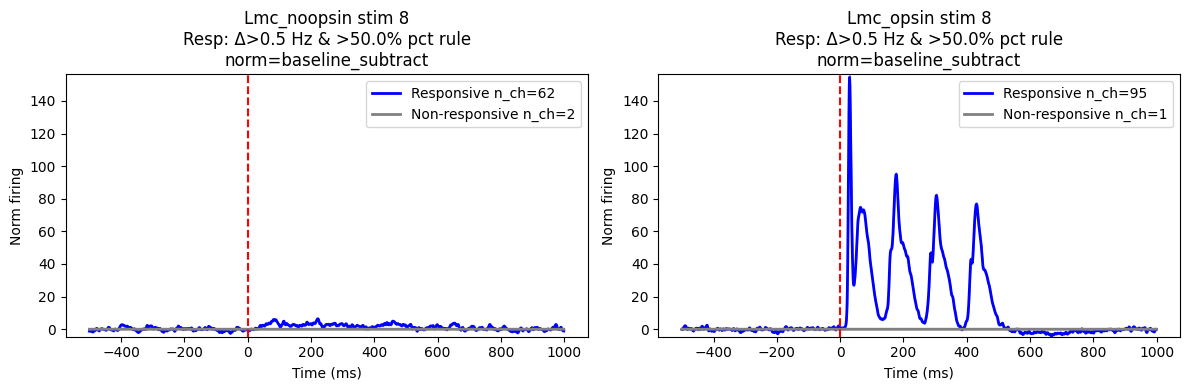

In [6]:
import numpy as np, matplotlib.pyplot as plt

def plot_led_group_psth_responsive(ana,
                                   groups=("Lmc_noopsin","Lmc_opsin"),
                                   stim_id=8,
                                   baseline=(-500,0),
                                   response_window=(0,0.5),
                                   min_delta_hz=0.5,
                                   min_percent=50.0,
                                   norm_mode="baseline_subtract"):
    """
    Pool LED recordings per group; plot responsive vs non-responsive PSTH with channel×trial weighting.
    Responsive uses pct rule: Δ > min_delta_hz AND percent_change > min_percent (is_opto_responsive_pct50).
    Legend N shows channel counts (not channel×trial). If no responsive channels, only non-responsive is shown.
    """
    tms_ref = None
    pooled = {g: {"resp": [], "nonresp": []} for g in groups}
    counts = {g: {"resp_ch": 0, "nonresp_ch": 0} for g in groups}

    for g in groups:
        rec_dirs = sorted((ana.output_base / "LED" / g).glob("*"))
        for rec_dir in rec_dirs:
            rec = rec_dir.name
            opto = ana.label_opto_responsive_channels(g, rec,
                                                      stim_id=stim_id,
                                                      baseline_window=baseline,
                                                      response_window=response_window,
                                                      min_delta_hz=min_delta_hz,
                                                      min_percent=min_percent)
            resp_ch = opto.loc[opto["is_opto_responsive_pct50"], "channel"].tolist()
            all_ch  = opto["channel"].tolist()
            nonresp_ch = [c for c in all_ch if c not in resp_ch]
            print(f"[INFO] {g}/{rec} | resp_ch (pct50 rule): {resp_ch} | nonresp_ch: {nonresp_ch}")

            # Load firing
            rec_dir_full = ana.output_base / ana.modality / g / rec
            firing = np.load(rec_dir_full / "firing_tensor.npz")
            fhz_raw, tms = firing["firing_hz"], firing["time_ms"]
            trials = pd.read_parquet(rec_dir_full / "trials.parquet")
            if tms_ref is None: tms_ref = tms
            idx = trials.index[trials["stim_id"] == stim_id].to_numpy()
            if idx.size == 0:
                continue

            # Build normalized tensor per channel×trial
            mask = (tms >= baseline[0]) & (tms < baseline[1])
            if norm_mode == "baseline_subtract":
                fhz_norm = fhz_raw.copy()
                base_mean = fhz_norm[:, :, mask].mean(axis=2, keepdims=True)
                fhz_norm = fhz_norm - base_mean
            elif norm_mode == "percent_change":
                base_mean = fhz_raw[:, :, mask].mean(axis=2, keepdims=True)
                fhz_norm = 100 * (fhz_raw - base_mean) / (np.abs(base_mean) + 1e-9)
            else:
                raise ValueError("norm_mode must be 'baseline_subtract' or 'percent_change'")

            def flatten(ch_list):
                if not ch_list:
                    return None
                data = fhz_norm[ch_list][:, idx, :]  # ch x trials x time
                return data.reshape(-1, data.shape[-1])  # (ch×trial) x time

            data_resp = flatten(resp_ch)
            data_nr   = flatten(nonresp_ch)
            if data_resp is not None:
                pooled[g]["resp"].append(data_resp)
                counts[g]["resp_ch"] += len(resp_ch)
            if data_nr is not None:
                pooled[g]["nonresp"].append(data_nr)
                counts[g]["nonresp_ch"] += len(nonresp_ch)

    # y-limits and curves
    y_min, y_max = np.inf, -np.inf
    curves = {}
    for g in groups:
        curves[g] = {}
        for label, key in [("resp","resp"), ("nonresp","nonresp")]:
            arrs = pooled[g][key]
            if not arrs: continue
            data = np.concatenate(arrs, axis=0)
            mean = data.mean(axis=0)
            sem  = data.std(axis=0) / np.sqrt(data.shape[0])
            curves[g][label] = (mean, sem)
            y_min = min(y_min, (mean - sem).min())
            y_max = max(y_max, (mean + sem).max())
    if not np.isfinite(y_min) or not np.isfinite(y_max):
        y_min, y_max = -1, 1

    fig, axs = plt.subplots(1, len(groups), figsize=(6*len(groups), 4), squeeze=False)
    for gi, g in enumerate(groups):
        ax = axs[0, gi]
        for label, color, key, ch_key in [("Responsive","blue","resp","resp_ch"), ("Non-responsive","grey","nonresp","nonresp_ch")]:
            if key not in curves[g]: continue
            mean, sem = curves[g][key]
            ax.plot(tms_ref, mean, color=color, lw=2, label=f"{label} n_ch={counts[g][ch_key]}")
            ax.fill_between(tms_ref, mean-sem, mean+sem, color=color, alpha=0.25)
        ax.axvline(0, color="red", ls="--")
        ax.set_ylim(y_min, y_max)
        ax.set_title(f"{g} stim {stim_id}\nResp: Δ>{min_delta_hz} Hz & >{min_percent}% pct rule\nnorm={norm_mode}")
        ax.set_xlabel("Time (ms)"); ax.set_ylabel("Norm firing")
        ax.legend()
    plt.tight_layout(); plt.show()

OUTPUT_BASE = Path("/Volumes/MannySSD/PSTH_custom_bin_1ms_gauss10ms_run17")
ana_led = SpikeWindowAnalyzer(OUTPUT_BASE, modality="LED")

plot_led_group_psth_responsive(ana_led)

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_led_group_oi(ana,
                      groups=("Lmc_noopsin","Lmc_opsin"),
                      stim_id=8,
                      baseline=(-500, 0),        # ms
                      response_window=(0, 500),  # ms
                      pre_n=30,
                      eps=1e-9):
    """
    Paper-style Opto-Index (OI), ALL channels.

    OI = (FR_stim - FR_pre) / (FR_stim + FR_pre)

    FR_pre  : mean firing rate in baseline window
    FR_stim : mean firing rate in response_window
    """

    rows = []

    for g in groups:
        rec_dirs = sorted((ana.output_base / "LED" / g).glob("*"))
        for rec_dir in rec_dirs:
            rec = rec_dir.name

            rec_dir_full = ana.output_base / ana.modality / g / rec
            firing = np.load(rec_dir_full / "firing_tensor.npz")
            fhz, tms = firing["firing_hz"], firing["time_ms"]
            trials = pd.read_parquet(rec_dir_full / "trials.parquet")

            stim_trials = trials[trials["stim_id"] == stim_id]
            if stim_trials.empty:
                continue

            stim_trials = stim_trials.copy()
            stim_trials["luciferin"] = (
                stim_trials.groupby("stim_id").cumcount() >= pre_n
            ).astype(int)

            pre_idx  = stim_trials.index[stim_trials["luciferin"] == 0]
            post_idx = stim_trials.index[stim_trials["luciferin"] == 1]

            if len(pre_idx) == 0 or len(post_idx) == 0:
                continue

            base_mask = (tms >= baseline[0]) & (tms < baseline[1])
            resp_mask = (tms >= response_window[0]) & (tms < response_window[1])

            for ch in range(fhz.shape[0]):
                fr_pre  = fhz[ch, pre_idx][:, base_mask].mean()
                fr_stim = fhz[ch, post_idx][:, resp_mask].mean()
                oi = (fr_stim - fr_pre) / (fr_stim + fr_pre + eps)

                rows.append({
                    "group": g,
                    "recording": rec,
                    "channel": ch,
                    "OI": oi
                })

    df = pd.DataFrame(rows)

    # ==========================
    # PAPER-STYLE VIOLIN PLOT
    # ==========================
    fig, ax = plt.subplots(figsize=(3.2, 4.2))

    data = [df.loc[df["group"] == g, "OI"].values for g in groups]
    positions = np.arange(len(groups))

    vp = ax.violinplot(
        data,
        positions=positions,
        widths=0.8,
        showmeans=False,
        showmedians=False,
        showextrema=False
    )

    colors = ["steelblue", "sandybrown"]

    for body, color in zip(vp["bodies"], colors):
        body.set_facecolor(color)
        body.set_edgecolor("black")
        body.set_alpha(0.35)
        body.set_linewidth(1)

    # jittered points + mean ± SEM
    for i, (vals, color) in enumerate(zip(data, colors)):
        jitter = np.random.normal(i, 0.04, size=len(vals))
        ax.scatter(
            jitter,
            vals,
            s=18,
            color=color,
            alpha=0.8,
            zorder=3
        )

        mean = np.mean(vals)
        sem  = np.std(vals, ddof=1) / np.sqrt(len(vals))
        ax.errorbar(
            i,
            mean,
            yerr=sem,
            fmt="o",
            color="black",
            capsize=4,
            lw=1.5,
            zorder=4
        )

    ax.axhline(0, color="black", lw=1, ls="--")
    ax.set_ylim(-1, 1)
    ax.set_xticks(positions)
    ax.set_xticklabels(groups)
    ax.set_ylabel("OI")
    ax.set_title(f"Opto-index (LED stim {stim_id})")

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    plt.tight_layout()
    plt.show()

    return df

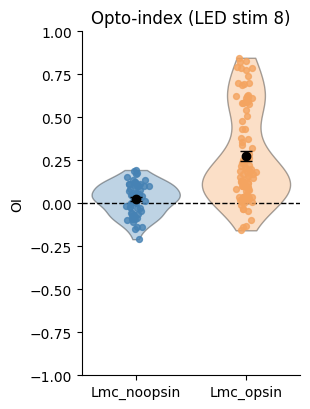

In [8]:
# run example
oi_df = plot_led_group_oi(ana_led, 
                           response_window=(0, 200))

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


def plot_led_group_oi(
    ana,
    groups=("Lmc_noopsin", "Lmc_opsin"),
    stim_id=8,
    baseline=(-500, 0),          # ms
    response_window=(0, 500),    # ms
    pre_n=30,
    agg="mean",                  # "mean" | "median" | "max"
    show_points=True,            # toggle dots on bar plot
    eps=1e-9,
    ylim_oi=(-1, 1),
):
    """
    Flexible Opto-Index (OI) analysis + visualization.

    OI = (FR_stim - FR_pre) / (FR_stim + FR_pre)

    - FR_pre  computed in baseline window
    - FR_stim computed in response_window
    - PRE vs POST defined by pre_n
    - Aggregation selectable: mean / median / max
    """

    assert agg in {"mean", "median", "max"}, f"Invalid agg: {agg}"

    agg_fn = {
        "mean": np.mean,
        "median": np.median,
        "max": np.max,
    }[agg]

    rows = []

    # =========================
    # COMPUTE OI + RAW FR
    # =========================
    for g in groups:
        rec_dirs = sorted((ana.output_base / "LED" / g).glob("*"))

        for rec_dir in rec_dirs:
            rec = rec_dir.name
            rec_dir_full = ana.output_base / ana.modality / g / rec

            firing = np.load(rec_dir_full / "firing_tensor.npz")
            fhz, tms = firing["firing_hz"], firing["time_ms"]
            trials = pd.read_parquet(rec_dir_full / "trials.parquet")

            stim_trials = trials[trials["stim_id"] == stim_id]
            if stim_trials.empty:
                continue

            stim_trials = stim_trials.copy()
            stim_trials["luciferin"] = (
                stim_trials.groupby("stim_id").cumcount() >= pre_n
            ).astype(int)

            pre_idx  = stim_trials.index[stim_trials["luciferin"] == 0]
            post_idx = stim_trials.index[stim_trials["luciferin"] == 1]

            if len(pre_idx) == 0 or len(post_idx) == 0:
                continue

            base_mask = (tms >= baseline[0]) & (tms < baseline[1])
            resp_mask = (tms >= response_window[0]) & (tms < response_window[1])

            if not base_mask.any() or not resp_mask.any():
                continue

            for ch in range(fhz.shape[0]):
                fr_pre_vals  = fhz[ch, pre_idx][:, base_mask]
                fr_stim_vals = fhz[ch, post_idx][:, resp_mask]

                fr_pre  = agg_fn(fr_pre_vals)
                fr_stim = agg_fn(fr_stim_vals)

                oi = (fr_stim - fr_pre) / (fr_stim + fr_pre + eps)

                rows.append({
                    "group": g,
                    "recording": rec,
                    "channel": ch,
                    "FR_pre": fr_pre,
                    "FR_stim": fr_stim,
                    "OI": oi,
                })

    df = pd.DataFrame(rows)
    if df.empty:
        print("[WARN] No LED OI data to plot.")
        return df

    # =========================
    # PLOTTING
    # =========================
    fig, axs = plt.subplots(
        1, 2, figsize=(8.5, 4.6),
        gridspec_kw={"width_ratios": [1.2, 1]}
    )

    colors = ["steelblue", "sandybrown"]
    xpos = np.arange(len(groups))

    # ===== LEFT: OI VIOLIN =====
    ax = axs[0]
    oi_data = [df[df.group == g]["OI"].values for g in groups]

    vp = ax.violinplot(
        oi_data,
        positions=xpos,
        widths=0.8,
        showmeans=False,
        showmedians=False,
        showextrema=False
    )

    for body, color in zip(vp["bodies"], colors):
        body.set_facecolor(color)
        body.set_edgecolor("black")
        body.set_alpha(0.35)
        body.set_linewidth(1)

    for i, (vals, color) in enumerate(zip(oi_data, colors)):
        jitter = np.random.normal(i, 0.04, size=len(vals))
        ax.scatter(jitter, vals, s=18, color=color, alpha=0.8, zorder=3)

        mean = np.mean(vals)
        sem  = np.std(vals, ddof=1) / np.sqrt(len(vals))
        ax.errorbar(
            i, mean, yerr=sem,
            fmt="o", color="black", capsize=4, lw=1.5, zorder=4
        )

    ax.axhline(0, color="black", lw=1, ls="--")
    ax.set_ylim(*ylim_oi)
    ax.set_xticks(xpos)
    ax.set_xticklabels(groups)
    ax.set_ylabel("Opto-index (OI)")
    ax.set_title("LED Opto-index")

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    # ===== RIGHT: RAW FR PRE vs STIM =====
    ax = axs[1]
    bar_w = 0.35
    jitter = 0.06

    for i, g in enumerate(groups):
        fr_pre  = df[df.group == g]["FR_pre"].values
        fr_stim = df[df.group == g]["FR_stim"].values

        means = [fr_pre.mean(), fr_stim.mean()]
        sems  = [
            fr_pre.std(ddof=1) / np.sqrt(len(fr_pre)),
            fr_stim.std(ddof=1) / np.sqrt(len(fr_stim))
        ]

        ax.bar(
            [i - bar_w/2, i + bar_w/2],
            means,
            yerr=sems,
            width=bar_w,
            color=["lightgrey", colors[i]],
            alpha=0.85,
            capsize=4,
            zorder=1
        )

        if show_points:
            ax.scatter(
                np.full_like(fr_pre, i - bar_w/2, dtype=float)
                + np.random.uniform(-jitter, jitter, size=len(fr_pre)),
                fr_pre,
                s=18, color="black", alpha=0.7, zorder=2
            )
            ax.scatter(
                np.full_like(fr_stim, i + bar_w/2, dtype=float)
                + np.random.uniform(-jitter, jitter, size=len(fr_stim)),
                fr_stim,
                s=18, color="black", alpha=0.7, zorder=2
            )

    ax.set_xticks(xpos)
    ax.set_xticklabels(groups)
    ax.set_ylabel(f"Firing rate ({agg}, Hz)")
    ax.set_title("Raw firing rates\nPRE vs STIM")

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    plt.suptitle(
        f"LED Opto-index | stim {stim_id} | agg = {agg}",
        y=1.05, fontsize=11
    )

    plt.tight_layout()
    plt.show()

    return df

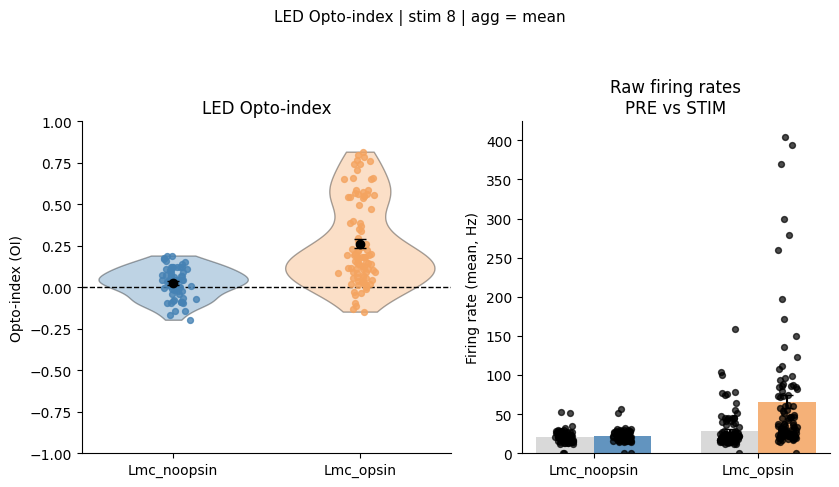

In [10]:
# Mean-based (paper default)
df_led_mean = plot_led_group_oi(
    ana_led,
    stim_id=8,
    agg="mean",
    show_points=True
)

###

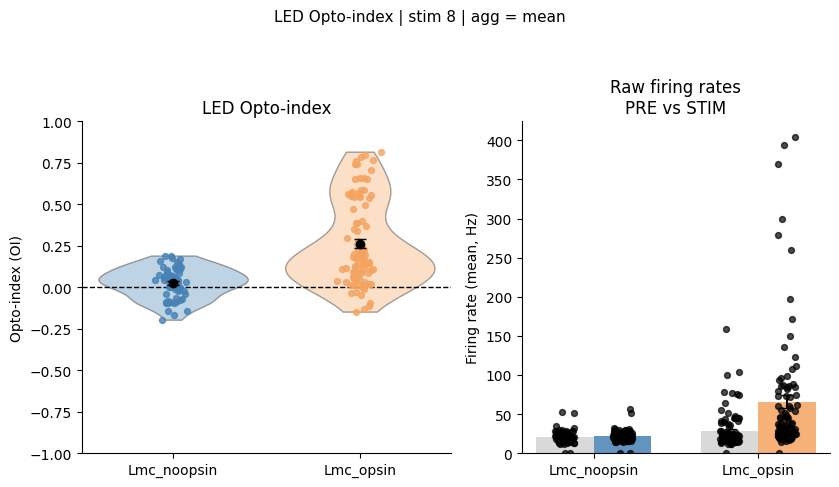

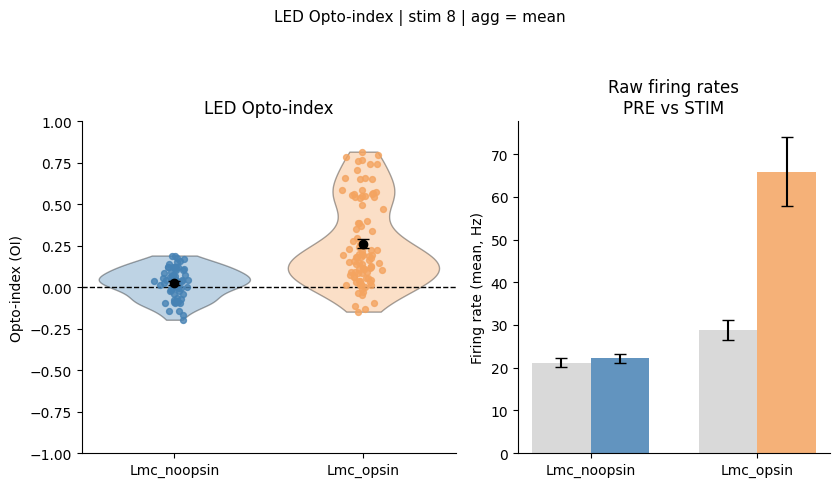

,group,recording,channel,FR_pre,FR_stim,OI
0,Lmc_noopsin,lmc_noch_1_3096_rec1,0,21.928284,18.007884,-0.098167
1,Lmc_noopsin,lmc_noch_1_3096_rec1,1,29.387819,25.776424,-0.065466
2,Lmc_noopsin,lmc_noch_1_3096_rec1,2,22.869064,22.297621,-0.012652
3,Lmc_noopsin,lmc_noch_1_3096_rec1,3,22.706168,21.017860,-0.038613
4,Lmc_noopsin,lmc_noch_1_3096_rec1,4,19.178600,22.790594,0.086063
...,...,...,...,...,...,...
155,Lmc_opsin,lmc_ch_2_3093_rec1,27,40.827451,46.406827,0.063959
156,Lmc_opsin,lmc_ch_2_3093_rec1,28,22.920177,28.422761,0.107173
157,Lmc_opsin,lmc_ch_2_3093_rec1,29,37.192675,38.321469,0.014948
158,Lmc_opsin,lmc_ch_2_3093_rec1,30,28.057907,28.964103,0.015892


In [11]:
# Mean-based (paper default)
df_led_mean = plot_led_group_oi(
    ana_led,
    stim_id=8,
    agg="mean",
    show_points=True
)

# Clean bars only
plot_led_group_oi(
    ana_led,
    stim_id=8,
    agg="mean",
    show_points=False
)

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


def plot_led_group_oi(
    ana,
    groups=("Lmc_noopsin", "Lmc_opsin"),
    stim_id=8,
    baseline=(-500, 0),
    response_window=(0, 500),
    pre_n=30,
    agg="mean",
    show_points=True,
    exclude_recordings=None,     # ← list of recording names
    exclude_n_opsin=0,           # ← drop first N opsin recordings
    eps=1e-9,
    ylim_oi=(-1, 1),
):
    """
    LED Opto-Index (OI) with easy recording exclusion.

    OI = (FR_stim - FR_pre) / (FR_stim + FR_pre)

    Exclusion options:
      - exclude_recordings: explicit list of recording names
      - exclude_n_opsin: drop first N Lmc_opsin recordings (sorted)
    """

    assert agg in {"mean", "median", "max"}
    agg_fn = {"mean": np.mean, "median": np.median, "max": np.max}[agg]

    if exclude_recordings is None:
        exclude_recordings = []

    rows = []

    for g in groups:
        rec_dirs = sorted((ana.output_base / "LED" / g).glob("*"))
        rec_names = [r.name for r in rec_dirs]

        # ----- SIMPLE opsin-only exclusion by count -----
        if g == "Lmc_opsin" and exclude_n_opsin > 0:
            dropped = rec_names[:exclude_n_opsin]
            print(f"[EXCLUDE] Dropping first {exclude_n_opsin} opsin recordings:", dropped)
            rec_dirs = rec_dirs[exclude_n_opsin:]

        for rec_dir in rec_dirs:
            rec = rec_dir.name

            # ----- explicit name-based exclusion -----
            if rec in exclude_recordings:
                print(f"[SKIP] {g}/{rec} (explicit exclusion)")
                continue

            rec_dir_full = ana.output_base / ana.modality / g / rec
            firing = np.load(rec_dir_full / "firing_tensor.npz")
            fhz, tms = firing["firing_hz"], firing["time_ms"]
            trials = pd.read_parquet(rec_dir_full / "trials.parquet")

            stim_trials = trials[trials["stim_id"] == stim_id]
            if stim_trials.empty:
                continue

            stim_trials = stim_trials.copy()
            stim_trials["luciferin"] = (
                stim_trials.groupby("stim_id").cumcount() >= pre_n
            ).astype(int)

            pre_idx  = stim_trials.index[stim_trials["luciferin"] == 0]
            post_idx = stim_trials.index[stim_trials["luciferin"] == 1]

            if len(pre_idx) == 0 or len(post_idx) == 0:
                continue

            base_mask = (tms >= baseline[0]) & (tms < baseline[1])
            resp_mask = (tms >= response_window[0]) & (tms < response_window[1])

            if not base_mask.any() or not resp_mask.any():
                continue

            for ch in range(fhz.shape[0]):
                fr_pre  = agg_fn(fhz[ch, pre_idx][:, base_mask])
                fr_post = agg_fn(fhz[ch, post_idx][:, resp_mask])

                oi = (fr_post - fr_pre) / (fr_post + fr_pre + eps)

                rows.append({
                    "group": g,
                    "recording": rec,
                    "channel": ch,
                    "FR_pre": fr_pre,
                    "FR_post": fr_post,
                    "OI": oi,
                })

    df = pd.DataFrame(rows)
    if df.empty:
        print("[WARN] No data after exclusions.")
        return df

    # =========================
    # PLOTTING
    # =========================
    fig, axs = plt.subplots(1, 2, figsize=(8.2, 4.6),
                            gridspec_kw={"width_ratios": [1.2, 1]})

    colors = ["steelblue", "sandybrown"]
    xpos = np.arange(len(groups))

    # ---- OI violin ----
    ax = axs[0]
    data = [df[df.group == g]["OI"].values for g in groups]

    vp = ax.violinplot(data, positions=xpos, widths=0.8, showextrema=False)
    for body, c in zip(vp["bodies"], colors):
        body.set_facecolor(c)
        body.set_edgecolor("black")
        body.set_alpha(0.35)

    for i, vals in enumerate(data):
        ax.scatter(
            np.random.normal(i, 0.04, size=len(vals)),
            vals, s=18, alpha=0.75, color=colors[i]
        )
        ax.errorbar(
            i, vals.mean(),
            yerr=vals.std(ddof=1)/np.sqrt(len(vals)),
            fmt="o", color="black", capsize=4
        )

    ax.axhline(0, color="black", ls="--")
    ax.set_xticks(xpos)
    ax.set_xticklabels(groups)
    ax.set_ylabel("Opto-index (OI)")
    ax.set_ylim(*ylim_oi)
    ax.set_title("LED Opto-index")

    # ---- Raw FR bars ----
    ax = axs[1]
    bar_w = 0.35
    jitter = 0.06

    for i, g in enumerate(groups):
        fr_pre  = df[df.group == g]["FR_pre"].values
        fr_post = df[df.group == g]["FR_post"].values

        ax.bar(
            [i - bar_w/2, i + bar_w/2],
            [fr_pre.mean(), fr_post.mean()],
            yerr=[
                fr_pre.std(ddof=1)/np.sqrt(len(fr_pre)),
                fr_post.std(ddof=1)/np.sqrt(len(fr_post))
            ],
            width=bar_w, color=["lightgrey", colors[i]], capsize=4
        )

        if show_points:
            ax.scatter(
                np.full_like(fr_pre, i - bar_w/2) + np.random.uniform(-jitter, jitter, len(fr_pre)),
                fr_pre, s=18, color="black", alpha=0.6
            )
            ax.scatter(
                np.full_like(fr_post, i + bar_w/2) + np.random.uniform(-jitter, jitter, len(fr_post)),
                fr_post, s=18, color="black", alpha=0.6
            )

    ax.set_xticks(xpos)
    ax.set_xticklabels(groups)
    ax.set_ylabel(f"Firing rate ({agg})")
    ax.set_title("PRE vs STIM firing")

    plt.tight_layout()
    plt.show()

    return df

In [13]:
# wahat teh the unique recordings ar in ana_led df
unique_recs = sorted(set(
    rec.name
    for group_dir in (ana_led.output_base / "LED").iterdir()
    if group_dir.is_dir()
    for rec in group_dir.iterdir()
    if rec.is_dir()
))
print("Unique recordings in LED data:", unique_recs)

Unique recordings in LED data: ['lmc_ch_1_3094_rec1', 'lmc_ch_1_3094_rec2', 'lmc_ch_2_3093_rec1', 'lmc_noch_1_3096_rec1', 'lmc_noch_1_3096_rec2']


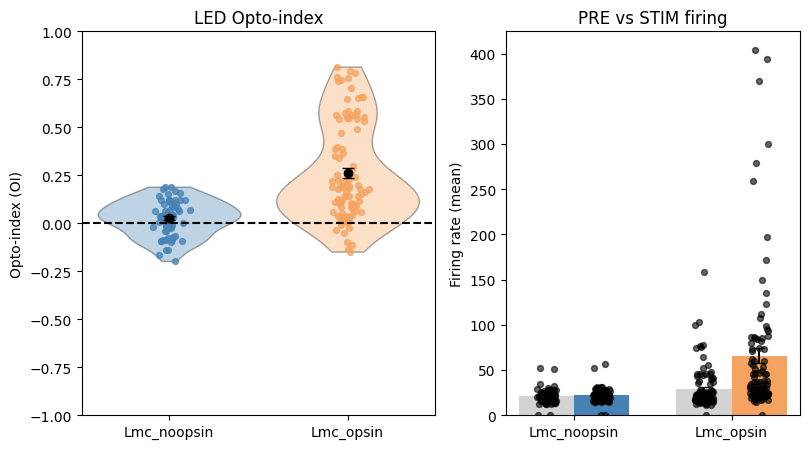

[SKIP] Lmc_opsin/lmc_ch_2_3093_rec1 (explicit exclusion)


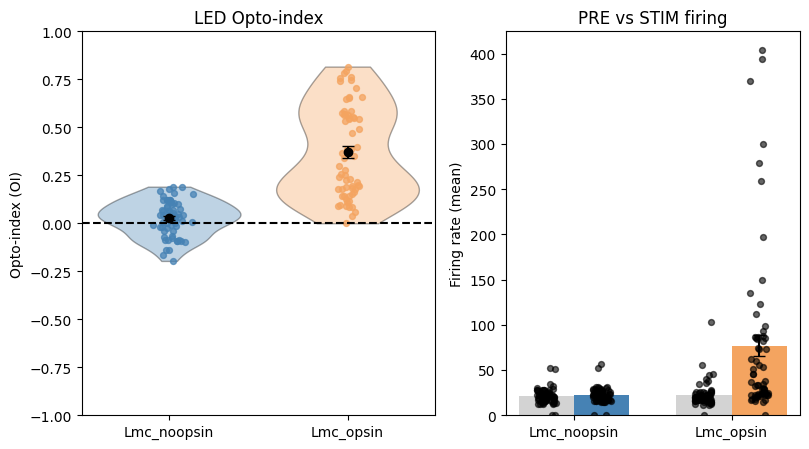

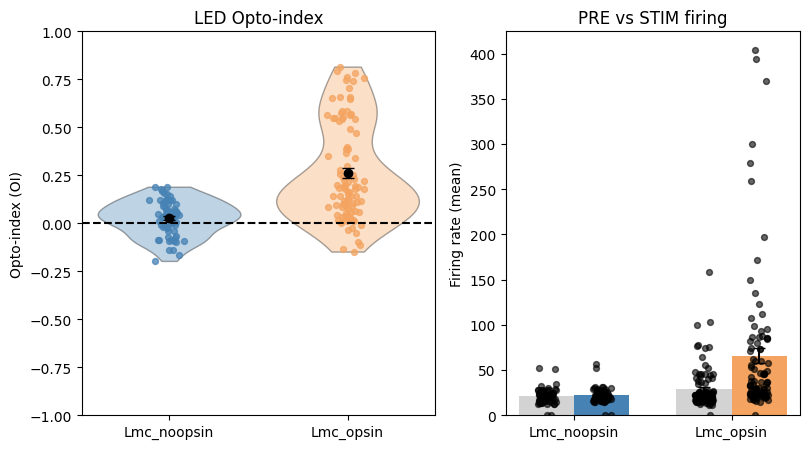

,group,recording,channel,FR_pre,FR_post,OI
0,Lmc_noopsin,lmc_noch_1_3096_rec1,0,21.928284,18.007884,-0.098167
1,Lmc_noopsin,lmc_noch_1_3096_rec1,1,29.387819,25.776424,-0.065466
2,Lmc_noopsin,lmc_noch_1_3096_rec1,2,22.869064,22.297621,-0.012652
3,Lmc_noopsin,lmc_noch_1_3096_rec1,3,22.706168,21.017860,-0.038613
4,Lmc_noopsin,lmc_noch_1_3096_rec1,4,19.178600,22.790594,0.086063
...,...,...,...,...,...,...
155,Lmc_opsin,lmc_ch_2_3093_rec1,27,40.827451,46.406827,0.063959
156,Lmc_opsin,lmc_ch_2_3093_rec1,28,22.920177,28.422761,0.107173
157,Lmc_opsin,lmc_ch_2_3093_rec1,29,37.192675,38.321469,0.014948
158,Lmc_opsin,lmc_ch_2_3093_rec1,30,28.057907,28.964103,0.015892


In [14]:
# no exclusions
plot_led_group_oi(
    ana_led,
    stim_id=8,
    agg="mean"
)

plot_led_group_oi(
    ana_led,
    stim_id=8,
    agg="mean",
    exclude_recordings=["lmc_ch_2_3093_rec2","lmc_ch_2_3093_rec1" ]
)
plot_led_group_oi(
    ana_led,
    stim_id=8,
    agg="mean",
    exclude_recordings=["lmc_ch_2_3093_rec2"]
)

In [ ]:
from pathlib import Path

OUTPUT_BASE = Path("/Volumes/MannySSD/PSTH_custom_bin_1ms_gauss10ms_run17")
ana = SpikeWindowAnalyzer(OUTPUT_BASE, modality="Whisker")

ctz_opsin = compute_whisker_ctz_index(
    ana,
    group="Lmc_opsin",
    stim_ids=(2, 3, 4),          # sensory only
    baseline=(-500, 0),
    response_window=(0, 500)
)

ctz_opsin.head()

In [ ]:
OUTPUT_BASE = Path("/Volumes/MannySSD/PSTH_custom_bin_1ms_gauss10ms_run17")
ana = SpikeWindowAnalyzer(OUTPUT_BASE, modality="Whisker")

group = "Lmc_opsin"
rec   = "lmc_ch_1_3094_rec1"
stim_ids = [1,2,3,4]
channels = [0,1,2]  # or your good-channel list

fhz_corr, tms, trials = ana.baseline_corrected_psth(group, rec, baseline=(-500, 0))

import matplotlib.pyplot as plt
import numpy as np

for ch in channels:
    fig, axs = plt.subplots(1, len(stim_ids), figsize=(4*len(stim_ids), 3), squeeze=False)
    for si, stim in enumerate(stim_ids):
        ax = axs[0, si]
        idx_all = trials.index[trials["stim_id"] == stim].to_numpy()
        if idx_all.size == 0:
            ax.set_title(f"Stim {stim}: no trials"); continue
        # luciferin 0=pre, 1=post (as stored by compute_counts)
        pre_idx  = trials.index[(trials["stim_id"] == stim) & (trials["luciferin"] == 0)].to_numpy() if "luciferin" in trials else idx_all[:len(idx_all)//2]
        post_idx = trials.index[(trials["stim_id"] == stim) & (trials["luciferin"] == 1)].to_numpy() if "luciferin" in trials else idx_all[len(idx_all)//2:]

        for label, color, idx in [("Pre", "grey", pre_idx), ("Post", "blue", post_idx)]:
            if idx.size == 0: continue
            data = fhz_corr[ch, idx, :]
            mean = data.mean(axis=0)
            sem = data.std(axis=0) / np.sqrt(data.shape[0])
            ax.plot(tms, mean, color=color, lw=2, label=f"{label} n={idx.size}")
            ax.fill_between(tms, mean-sem, mean+sem, color=color, alpha=0.25)
        ax.axvline(0, color="red", ls="--")
        ax.set_title(f"Ch {ch} Stim {stim}")
        if si == len(stim_ids)-1: ax.legend()
    plt.tight_layout(); plt.show()


In [ ]:
#confirm the other groups adn recoings anmes as seen belwo and run the following code
for group in ["Lmc_noopsin", "Lmc_opsin"]:
    recs = sorted((OUTPUT_BASE / "Whisker" / group).glob("*"))
    for rec_dir in recs:
        rec = rec_dir.name
        print(f"Processing {group}/{rec}...")
        df_counts = ana.compute_counts(
            group=group, rec=rec,
            early=(0, 0.1), late=(0.2, 1.0),
            stim_pool={"StimPresent":[2,3,4], "NoStim":[1]},
            pre_n=30
        )
        df_summary = ana.summarize_by_stim(df_counts)
        out_counts_file = OUTPUT_BASE / "Whisker" / group / rec / "trial_level_counts.csv"
        out_summary_file = OUTPUT_BASE / "Whisker" / group / rec / "summary_by_stim.csv"
        df_counts.to_csv(out_counts_file, index=False)
        df_summary.to_csv(out_summary_file, index=False)
        print(f"Saved counts to {out_counts_file}, summary to {out_summary_file}.")

In [ ]:
OUTPUT_BASE = Path("/Volumes/MannySSD/PSTH_custom_bin_1ms_gauss10ms_run17")
ana = SpikeWindowAnalyzer(OUTPUT_BASE, modality="Whisker")

group = "Lmc_opsin"
rec   = "lmc_ch_1_3094_rec1"
stim_ids = [1,2,3,4]
channels = [0,1,2]  # or your good-channel list

fhz_corr, tms, trials = ana.baseline_corrected_psth(group, rec, baseline=(-500, 0))
print(f"[DEBUG] fhz_corr shape={fhz_corr.shape}, dtype={fhz_corr.dtype}")
print(f"[DEBUG] tms len={len(tms)}, range=({tms[0]}, {tms[-1]})")
print(f"[DEBUG] trials shape={trials.shape}, columns={trials.columns.tolist()}")

import matplotlib.pyplot as plt
import numpy as np

for ch in channels:
    print(f"\n[CHANNEL] {ch}")
    fig, axs = plt.subplots(1, len(stim_ids), figsize=(4*len(stim_ids), 3), squeeze=False)
    for si, stim in enumerate(stim_ids):
        ax = axs[0, si]
        idx_all = trials.index[trials["stim_id"] == stim].to_numpy()
        print(f"[DEBUG] stim {stim}: total trials {len(idx_all)}")
        if idx_all.size == 0:
            ax.set_title(f"Stim {stim}: no trials"); continue

        if "luciferin" in trials.columns:
            pre_idx  = trials.index[(trials["stim_id"] == stim) & (trials["luciferin"] == 0)].to_numpy()
            post_idx = trials.index[(trials["stim_id"] == stim) & (trials["luciferin"] == 1)].to_numpy()
            split_source = "luciferin column"
        else:
            half = len(idx_all)//2
            pre_idx, post_idx = idx_all[:half], idx_all[half:]
            split_source = "half/half fallback"

        print(f"[DEBUG] stim {stim}: pre n={len(pre_idx)}, post n={len(post_idx)} (source: {split_source})")

        for label, color, idx in [("Pre", "grey", pre_idx), ("Post", "blue", post_idx)]:
            if idx.size == 0: continue
            data = fhz_corr[ch, idx, :]  # trials x time
            mean = data.mean(axis=0)
            sem = data.std(axis=0) / np.sqrt(data.shape[0])
            ax.plot(tms, mean, color=color, lw=2, label=f"{label} n={idx.size}")
            ax.fill_between(tms, mean-sem, mean+sem, color=color, alpha=0.25)

        ax.axvline(0, color="red", ls="--")
        ax.set_title(f"Ch {ch} Stim {stim}\nPre n={len(pre_idx)}, Post n={len(post_idx)}")
        if si == len(stim_ids)-1:
            ax.legend()

    plt.tight_layout()
    plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

def plot_psth_pre_post_modes(ana, group, rec, channels,
                             mode="individual",  # "individual" -> stim1..4, "pooled" -> NoStim/Weak/Max
                             weak_mode="2+3",    # "2+3" or "2"
                             max_mode="4",       # "4" or "3+4"
                             baseline=(-500, 0),
                             show_bottom=True):
    """
    Plots baseline-corrected PSTH pre/post. Top row = pre/post PSTH.
    Bottom row = same (duplicate) or disable via show_bottom=False.
    mode="individual": columns are stim 1,2,3,4 (if present)
    mode="pooled":     columns are NoStim (1), Weak (2+3 or 2), Max (4 or 3+4)
    """
    fhz_corr, tms, trials = ana.baseline_corrected_psth(group, rec, baseline=baseline)
    avail_stims = set(trials["stim_id"].unique().tolist())

    if mode == "individual":
        stim_groups = {f"Stim {s}": [s] for s in sorted(avail_stims)}
    else:
        weak_list = [2, 3] if weak_mode == "2+3" else [2]
        max_list  = [4] if max_mode == "4" else [3, 4]
        stim_groups = {
            "NoStim": [1],
            "Weak":   weak_list,
            "Max":    max_list,
        }
        stim_groups = {k:v for k,v in stim_groups.items() if avail_stims.intersection(v)}

    n_cols = len(stim_groups)
    n_rows = 2 if show_bottom else 1

    for ch in channels:
        fig, axs = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3*n_rows), squeeze=False)
        for ci, (label, stim_list) in enumerate(stim_groups.items()):
            ax_top = axs[0, ci]
            ax_bot = axs[1, ci] if show_bottom else None

            idx_all = trials.index[trials["stim_id"].isin(stim_list)].to_numpy()
            if idx_all.size == 0:
                ax_top.set_title(f"{label}: no trials")
                if ax_bot is not None: ax_bot.axis("off")
                continue

            if "luciferin" in trials.columns:
                pre_idx  = trials.index[(trials["stim_id"].isin(stim_list)) & (trials["luciferin"] == 0)].to_numpy()
                post_idx = trials.index[(trials["stim_id"].isin(stim_list)) & (trials["luciferin"] == 1)].to_numpy()
                split_source = "luciferin column"
            else:
                half = len(idx_all)//2
                pre_idx, post_idx = idx_all[:half], idx_all[half:]
                split_source = "half/half fallback"

            pre_n, post_n = len(pre_idx), len(post_idx)
            print(f"[DEBUG] ch {ch} {label} stims={stim_list}: total {len(idx_all)}, pre {pre_n}, post {post_n} ({split_source})")

            # Top row: baseline-corrected PSTH pre/post
            for lab, color, idx in [("Pre", "grey", pre_idx), ("Post", "blue", post_idx)]:
                if idx.size == 0: continue
                data = fhz_corr[ch, idx, :]  # trials x time
                mean = data.mean(axis=0)
                sem = data.std(axis=0) / np.sqrt(data.shape[0])
                ax_top.plot(tms, mean, color=color, lw=2, label=f"{lab} n={idx.size}")
                ax_top.fill_between(tms, mean-sem, mean+sem, color=color, alpha=0.25)
            ax_top.axvline(0, color="red", ls="--")
            ax_top.set_title(f"{label}\nPre n={pre_n}, Post n={post_n}")
            if ci == n_cols-1:
                ax_top.legend()

            # Bottom row: optional duplicate of the top (counts PSTH again)
            if show_bottom:
                for lab, color, idx in [("Pre", "grey", pre_idx), ("Post", "blue", post_idx)]:
                    if idx.size == 0: continue
                    data = fhz_corr[ch, idx, :]
                    mean = data.mean(axis=0)
                    sem = data.std(axis=0) / np.sqrt(data.shape[0])
                    ax_bot.plot(tms, mean, color=color, lw=2)
                    ax_bot.fill_between(tms, mean-sem, mean+sem, color=color, alpha=0.25)
                ax_bot.axvline(0, color="red", ls="--")
                ax_bot.set_title("PSTH (baseline-corrected)")

        plt.tight_layout()
        plt.show()



In [ ]:
# Individual stims (1x4)
plot_psth_pre_post_modes(ana, "Lmc_opsin", "lmc_ch_1_3094_rec1",
                         channels=[0,1,2], mode="individual")

# Pooled stims (1x3): NoStim=1, Weak=2+3, Max=4
plot_psth_pre_post_modes(ana, "Lmc_opsin", "lmc_ch_1_3094_rec1",
                         channels=[0,1,2], mode="pooled",
                         weak_mode="2+3", max_mode="4")

In [ ]:
from pathlib import Path
import numpy as np, pandas as pd, matplotlib.pyplot as plt

OUTPUT_BASE = Path("/Volumes/MannySSD/PSTH_custom_bin_1ms_gauss10ms_run17")
DATA_ROOT   = Path("/Volumes/MannySSD/lmc_project_v2_MINIMAL")  # for good_channels

def get_good_channels(modality, group, rec):
    rr = pd.read_csv(DATA_ROOT / modality / "SpikeStuff" / "recording_results.csv")
    row = rr.query("group_name == @group and recording_name == @rec").iloc[0]
    return eval(row["good_channels"])

def plot_recording_mean(ana, modality, group, rec, stim_ids=(1,2,3,4), baseline=(-500,0)):
    chans = get_good_channels(modality, group, rec)
    fhz_corr, tms, trials = ana.baseline_corrected_psth(group, rec, baseline=baseline)
    print(f"[DEBUG] using {len(chans)} good channels: {chans}")

    fig, axs = plt.subplots(1, len(stim_ids), figsize=(4*len(stim_ids), 3), squeeze=False)
    for si, stim in enumerate(stim_ids):
        ax = axs[0, si]
        idx_all = trials.index[trials["stim_id"] == stim].to_numpy()
        if idx_all.size == 0:
            ax.set_title(f"Stim {stim}: no trials"); continue

        # pre/post split (luciferin column if present, else half/half)
        if "luciferin" in trials.columns:
            pre_idx  = trials.index[(trials["stim_id"] == stim) & (trials["luciferin"] == 0)].to_numpy()
            post_idx = trials.index[(trials["stim_id"] == stim) & (trials["luciferin"] == 1)].to_numpy()
        else:
            half = len(idx_all)//2
            pre_idx, post_idx = idx_all[:half], idx_all[half:]

        pre_n, post_n = len(pre_idx), len(post_idx)
        print(f"[DEBUG] stim {stim}: pre n={pre_n}, post n={post_n}")

        for label, color, idx in [("Pre","grey",pre_idx), ("Post","blue",post_idx)]:
            if idx.size == 0: continue
            # mean across channels then trials
            data = fhz_corr[chans][:, idx, :]         # ch x trials x time
            mean = data.mean(axis=(0,1))
            sem  = data.std(axis=(0,1)) / np.sqrt(data.shape[0]*data.shape[1])
            ax.plot(tms, mean, color=color, lw=2, label=f"{label} n={idx.size}")
            ax.fill_between(tms, mean-sem, mean+sem, color=color, alpha=0.25)

        ax.axvline(0, color="red", ls="--")
        ax.set_title(f"Stim {stim}\nPre n={pre_n}, Post n={post_n}")
        if si == len(stim_ids)-1: ax.legend()

    plt.tight_layout(); plt.show()

# Example usage
ana = SpikeWindowAnalyzer(OUTPUT_BASE, modality="Whisker")
plot_recording_mean(ana, modality="Whisker", group="Lmc_opsin", rec="lmc_ch_1_3094_rec1")


In [ ]:
plot_recording_mean(ana, modality="Whisker", group="Lmc_opsin", rec="lmc_ch_1_3094_rec2")

In [ ]:
plot_recording_mean(ana, modality="Whisker", group="Lmc_noopsin", rec="lmc_noch_1_3096_rec1")

In [ ]:
plot_recording_mean(ana, modality="Whisker", group="Lmc_noopsin", rec="lmc_noch_1_3096_rec2")

In [ ]:
def plot_group_all_recordings(ana, modality, group, stim_ids=(1,2,3,4), baseline=(-500,0)):
    # Find all recordings for this group under OUTPUT_BASE/<modality>/<group>/*
    rec_dirs = sorted((ana.output_base / modality / group).glob("*"))
    if not rec_dirs:
        print(f"[WARN] No recordings found for {modality}/{group} under {ana.output_base}")
        return
    for rec_dir in rec_dirs:
        rec = rec_dir.name
        print(f"\n[INFO] Plotting {modality}/{group}/{rec}")
        plot_recording_mean(ana, modality=modality, group=group, rec=rec,
                            stim_ids=stim_ids, baseline=baseline)

# Example: loop all Whisker Lmc_opsin recordings in run17
ana = SpikeWindowAnalyzer(Path("/Volumes/MannySSD/PSTH_custom_bin_1ms_gauss10ms_run17"), modality="Whisker")
plot_group_all_recordings(ana, modality="Whisker", group="Lmc_opsin", stim_ids=[1,2,3,4], baseline=(-500,0))

# Example: loop all Whisker Lmc_noopsin
plot_group_all_recordings(ana, modality="Whisker", group="Lmc_noopsin", stim_ids=[1,2,3,4], baseline=(-500,0))


In [17]:
def plot_group_level_whisker(ana, stim_ids=(1,2,3,4), baseline=(-500,0)):
    """
    Pools all good channels across all Whisker recordings per group (Lmc_noopsin, Lmc_opsin)
    and plots group-level pre/post mean±SEM PSTHs for each stim.
    """
    groups = ["Lmc_noopsin", "Lmc_opsin"]
    tms_ref = None
    pooled = {g: {s: {"pre": [], "post": []} for s in stim_ids} for g in groups}

    for group in groups:
        rec_dirs = sorted((ana.output_base / "Whisker" / group).glob("*"))
        for rec_dir in rec_dirs:
            rec = rec_dir.name
            chans = get_good_channels("Whisker", group, rec)
            fhz_corr, tms, trials = ana.baseline_corrected_psth(group, rec, baseline=baseline)
            if tms_ref is None:
                tms_ref = tms
            for stim in stim_ids:
                idx_all = trials.index[trials["stim_id"] == stim].to_numpy()
                if idx_all.size == 0:
                    continue
                if "luciferin" in trials.columns:
                    pre_idx  = trials.index[(trials["stim_id"] == stim) & (trials["luciferin"] == 0)].to_numpy()
                    post_idx = trials.index[(trials["stim_id"] == stim) & (trials["luciferin"] == 1)].to_numpy()
                else:
                    half = len(idx_all)//2
                    pre_idx, post_idx = idx_all[:half], idx_all[half:]
                # Average over channels for this recording -> trials x time
                if len(pre_idx):
                    rec_pre = fhz_corr[chans][:, pre_idx, :].mean(axis=0)   # (trials, time)
                    pooled[group][stim]["pre"].append(rec_pre)
                if len(post_idx):
                    rec_post = fhz_corr[chans][:, post_idx, :].mean(axis=0)  # (trials, time)
                    pooled[group][stim]["post"].append(rec_post)

    # Plot group-level mean±SEM per stim
    fig, axs = plt.subplots(len(groups), len(stim_ids), figsize=(4*len(stim_ids), 3*len(groups)), squeeze=False)
    for gi, group in enumerate(groups):
        for si, stim in enumerate(stim_ids):
            ax = axs[gi, si]
            for label, color in [("pre","grey"), ("post","blue")]:
                arrs = pooled[group][stim][label]
                if not arrs:
                    continue
                # Concatenate trials across recordings after channel-averaging
                data = np.concatenate(arrs, axis=0)  # trials_total x time
                mean = data.mean(axis=0)
                sem  = data.std(axis=0) / np.sqrt(data.shape[0])
                ax.plot(tms_ref, mean, color=color, lw=2, label=f"{label} n_trials={data.shape[0]}")
                ax.fill_between(tms_ref, mean-sem, mean+sem, color=color, alpha=0.25)
            ax.axvline(0, color="red", ls="--")
            ax.set_title(f"{group} Stim {stim}")
            if si == len(stim_ids)-1:
                ax.legend()

    plt.tight_layout()
    plt.show()

plot_group_level_whisker(ana, stim_ids=[1,2,3,4], baseline=(-25,0))


NameError: name 'get_good_channels' is not defined

In [18]:
ctz_opsin = compute_whisker_ctz_index(
    ana,
    group="Lmc_opsin",
    stim_ids=(2,3,4),
    baseline=(-500, 0),
    response_window=(0, 500)
)

ctz_noopsin = compute_whisker_ctz_index(
    ana,
    group="Lmc_noopsin",
    stim_ids=(2,3,4),
    baseline=(-500, 0),
    response_window=(0, 500)
)

ctz_df = pd.concat([ctz_opsin, ctz_noopsin], ignore_index=True)

NameError: name 'compute_whisker_ctz_index' is not defined

In [15]:
def plot_whisker_ctz_index(
    ana,
    groups=("Lmc_noopsin", "Lmc_opsin"),
    stim_ids=(2, 3, 4),
    fr_window=(-500, 0),
    agg="mean",          # <-- NEW
    eps=1e-9,
    ylim=(-1, 1)
):
    """
    CTZ index with selectable aggregation.

    agg ∈ {"mean", "median", "max"}
    FR is ALWAYS computed in fr_window.
    PRE vs POST is defined by trial identity (CTZ).
    """

    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt

    assert agg in {"mean", "median", "max"}, f"Invalid agg: {agg}"

    # aggregation function
    if agg == "mean":
        agg_fn = np.mean
    elif agg == "median":
        agg_fn = np.median
    elif agg == "max":
        agg_fn = np.max

    rows = []

    for group in groups:
        rec_dirs = sorted((ana.output_base / "Whisker" / group).glob("*"))

        for rec_dir in rec_dirs:
            rec = rec_dir.name
            chans = get_good_channels("Whisker", group, rec)
            if len(chans) == 0:
                continue

            rec_dir_full = ana.output_base / "Whisker" / group / rec
            firing = np.load(rec_dir_full / "firing_tensor.npz")
            fhz = firing["firing_hz"]
            tms = firing["time_ms"]
            trials = pd.read_parquet(rec_dir_full / "trials.parquet")

            trials_sens = trials[trials["stim_id"].isin(stim_ids)]
            if trials_sens.empty:
                continue

            idx_all = trials_sens.index.to_numpy()
            if "luciferin" in trials_sens.columns:
                pre_idx  = trials_sens.index[trials_sens["luciferin"] == 0].to_numpy()
                post_idx = trials_sens.index[trials_sens["luciferin"] == 1].to_numpy()
            else:
                half = len(idx_all) // 2
                pre_idx, post_idx = idx_all[:half], idx_all[half:]

            if len(pre_idx) == 0 or len(post_idx) == 0:
                continue

            mask = (tms >= fr_window[0]) & (tms < fr_window[1])
            if not mask.any():
                continue

            for ch in chans:
                pre_vals  = fhz[ch, pre_idx][:, mask]
                post_vals = fhz[ch, post_idx][:, mask]

                fr_pre  = agg_fn(pre_vals)
                fr_post = agg_fn(post_vals)

                ctz = (fr_post - fr_pre) / (fr_post + fr_pre + eps)

                rows.append({
                    "group": group,
                    "recording": rec,
                    "channel": ch,
                    "CTZ_index": ctz
                })

    df = pd.DataFrame(rows)

    # ---------------- PLOT (OI style) ----------------
    fig, ax = plt.subplots(figsize=(3.6, 4.6))
    data = [df[df.group == g].CTZ_index.values for g in groups]
    positions = np.arange(len(groups))
    colors = ["steelblue", "sandybrown"]

    vp = ax.violinplot(data, positions=positions, widths=0.8, showextrema=False)
    for body, color in zip(vp["bodies"], colors):
        body.set_facecolor(color)
        body.set_alpha(0.35)
        body.set_edgecolor("black")

    for i, (vals, color) in enumerate(zip(data, colors)):
        jitter = np.random.normal(i, 0.04, size=len(vals))
        ax.scatter(jitter, vals, s=18, alpha=0.8, color=color)
        ax.errorbar(
            i,
            np.mean(vals),
            yerr=np.std(vals, ddof=1) / np.sqrt(len(vals)),
            fmt="o",
            color="black",
            capsize=4
        )

    ax.axhline(0, color="black", ls="--")
    ax.set_ylim(*ylim)
    ax.set_xticks(positions)
    ax.set_xticklabels(groups)
    ax.set_ylabel("CTZ index")
    ax.set_title(
        f"Whisker CTZ index ({agg})\nFR window = {fr_window} ms"
    )

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    plt.tight_layout()
    plt.show()

    return df

In [16]:
def plot_whisker_ctz_index_with_bars(
    ana,
    groups=("Lmc_noopsin", "Lmc_opsin"),
    stim_ids=(2, 3, 4),
    fr_window=(-500, 0),
    agg="mean",              # "mean", "median", "max"
    eps=1e-9,
    ylim_index=(-1, 1)
):
    """
    CTZ index (OI-style) + raw FR bar plot.

    FR is ALWAYS computed in fr_window.
    PRE vs POST determined by trial identity (CTZ).
    """

    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt

    assert agg in {"mean", "median", "max"}

    agg_fn = {
        "mean":   np.mean,
        "median": np.median,
        "max":    np.max
    }[agg]

    rows = []

    # ----------------- COMPUTE -----------------
    for group in groups:
        rec_dirs = sorted((ana.output_base / "Whisker" / group).glob("*"))

        for rec_dir in rec_dirs:
            rec = rec_dir.name
            chans = get_good_channels("Whisker", group, rec)
            if len(chans) == 0:
                continue

            rec_dir_full = ana.output_base / "Whisker" / group / rec
            firing = np.load(rec_dir_full / "firing_tensor.npz")
            fhz = firing["firing_hz"]
            tms = firing["time_ms"]
            trials = pd.read_parquet(rec_dir_full / "trials.parquet")

            trials_sens = trials[trials["stim_id"].isin(stim_ids)]
            if trials_sens.empty:
                continue

            idx_all = trials_sens.index.to_numpy()
            if "luciferin" in trials_sens.columns:
                pre_idx  = trials_sens.index[trials_sens["luciferin"] == 0].to_numpy()
                post_idx = trials_sens.index[trials_sens["luciferin"] == 1].to_numpy()
            else:
                half = len(idx_all) // 2
                pre_idx, post_idx = idx_all[:half], idx_all[half:]

            if len(pre_idx) == 0 or len(post_idx) == 0:
                continue

            mask = (tms >= fr_window[0]) & (tms < fr_window[1])
            if not mask.any():
                continue

            for ch in chans:
                fr_pre_vals  = fhz[ch, pre_idx][:, mask]
                fr_post_vals = fhz[ch, post_idx][:, mask]

                fr_pre  = agg_fn(fr_pre_vals)
                fr_post = agg_fn(fr_post_vals)

                ctz = (fr_post - fr_pre) / (fr_post + fr_pre + eps)

                rows.append({
                    "group": group,
                    "recording": rec,
                    "channel": ch,
                    "FR_pre": fr_pre,
                    "FR_post": fr_post,
                    "CTZ_index": ctz
                })

    df = pd.DataFrame(rows)

    # ----------------- PLOTTING -----------------
    fig, axs = plt.subplots(
        1, 2, figsize=(8.2, 4.6),
        gridspec_kw={"width_ratios": [1.2, 1]}
    )

    # ===== LEFT: CTZ INDEX (violin) =====
    ax = axs[0]
    index_data = [df[df.group == g].CTZ_index.values for g in groups]
    xpos = np.arange(len(groups))
    colors = ["steelblue", "sandybrown"]

    vp = ax.violinplot(index_data, positions=xpos, widths=0.8, showextrema=False)
    for body, color in zip(vp["bodies"], colors):
        body.set_facecolor(color)
        body.set_edgecolor("black")
        body.set_alpha(0.35)

    for i, (vals, color) in enumerate(zip(index_data, colors)):
        jitter = np.random.normal(i, 0.04, size=len(vals))
        ax.scatter(jitter, vals, s=18, alpha=0.8, color=color)
        ax.errorbar(
            i,
            np.mean(vals),
            yerr=np.std(vals, ddof=1)/np.sqrt(len(vals)),
            fmt="o", color="black", capsize=4
        )

    ax.axhline(0, color="black", ls="--")
    ax.set_xticks(xpos)
    ax.set_xticklabels(groups)
    ax.set_ylabel("CTZ index")
    ax.set_ylim(*ylim_index)
    ax.set_title("CTZ index")

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    # ===== RIGHT: RAW FR PRE vs POST =====
    ax = axs[1]

    bar_w = 0.35
    for i, g in enumerate(groups):
        fr_pre  = df[df.group == g]["FR_pre"].values
        fr_post = df[df.group == g]["FR_post"].values

        means = [fr_pre.mean(), fr_post.mean()]
        sems  = [
            fr_pre.std(ddof=1)/np.sqrt(len(fr_pre)),
            fr_post.std(ddof=1)/np.sqrt(len(fr_post))
        ]

        ax.bar(
            [i - bar_w/2, i + bar_w/2],
            means,
            yerr=sems,
            width=bar_w,
            color=["grey", colors[i]],
            alpha=0.8,
            capsize=4
        )

    ax.set_xticks(xpos)
    ax.set_xticklabels(groups)
    ax.set_ylabel(f"Firing rate ({agg}, Hz)")
    ax.set_title("Raw firing rates\n(pre vs post CTZ)")

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    plt.suptitle(
        f"Whisker CTZ analysis | FR window = {fr_window} ms | agg = {agg}",
        y=1.05, fontsize=11
    )

    plt.tight_layout()
    plt.show()

    return df

In [ ]:
ctz_df = plot_whisker_ctz_index(
    ana,
    fr_window=(-500, 0),
    stim_ids=([1,2,3,4]), 
    agg="mean"
)

ctz_df = plot_whisker_ctz_index(
    ana,
    fr_window=(-500, 0),
    stim_ids=([1,2,3,4]), 
    agg="median"
)

In [ ]:
ctz_df_bars = plot_whisker_ctz_index_with_bars(
    ana,
    fr_window=(-500, 0),
    stim_ids=[1, 2, 3, 4],
    agg="mean"
)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


def plot_whisker_ctz_index(
    ana,
    groups=("Lmc_noopsin", "Lmc_opsin"),
    stim_ids=(1, 2, 3, 4),
    fr_window=(-500, 0),           # ms — ALWAYS the same for PRE and POST
    agg="mean",                    # "mean" | "median" | "max"
    show_points=True,              # <-- TOGGLE INDIVIDUAL DOTS
    eps=1e-9,
    ylim_index=(-1, 1),
):
    """
    Standalone CTZ analysis + visualization.

    CTZ index:
        (FR_POST - FR_PRE) / (FR_POST + FR_PRE)

    - FR_PRE and FR_POST are computed over the SAME fr_window
    - PRE vs POST is defined by CTZ trial order (luciferin)
    - Aggregation is selectable: mean / median / max
    - Bar plot can optionally show individual channel points
    """

    assert agg in {"mean", "median", "max"}, f"Invalid agg: {agg}"

    agg_fn = {
        "mean": np.mean,
        "median": np.median,
        "max": np.max,
    }[agg]

    rows = []

    # =========================
    # COMPUTE CTZ + RAW FR
    # =========================
    for group in groups:
        rec_dirs = sorted((ana.output_base / "Whisker" / group).glob("*"))

        for rec_dir in rec_dirs:
            rec = rec_dir.name
            chans = get_good_channels("Whisker", group, rec)
            if len(chans) == 0:
                continue

            rec_dir_full = ana.output_base / "Whisker" / group / rec
            firing = np.load(rec_dir_full / "firing_tensor.npz")
            fhz = firing["firing_hz"]
            tms = firing["time_ms"]
            trials = pd.read_parquet(rec_dir_full / "trials.parquet")

            trials = trials[trials["stim_id"].isin(stim_ids)]
            if trials.empty:
                continue

            idx_all = trials.index.to_numpy()

            # PRE vs POST CTZ definition
            if "luciferin" in trials.columns:
                pre_idx  = trials.index[trials["luciferin"] == 0].to_numpy()
                post_idx = trials.index[trials["luciferin"] == 1].to_numpy()
            else:
                half = len(idx_all) // 2
                pre_idx, post_idx = idx_all[:half], idx_all[half:]

            if len(pre_idx) == 0 or len(post_idx) == 0:
                continue

            mask = (tms >= fr_window[0]) & (tms < fr_window[1])
            if not mask.any():
                continue

            for ch in chans:
                fr_pre_vals  = fhz[ch, pre_idx][:, mask]
                fr_post_vals = fhz[ch, post_idx][:, mask]

                fr_pre  = agg_fn(fr_pre_vals)
                fr_post = agg_fn(fr_post_vals)

                ctz = (fr_post - fr_pre) / (fr_post + fr_pre + eps)

                rows.append({
                    "group": group,
                    "recording": rec,
                    "channel": ch,
                    "FR_pre": fr_pre,
                    "FR_post": fr_post,
                    "CTZ_index": ctz,
                })

    df = pd.DataFrame(rows)
    if df.empty:
        print("[WARN] No data to plot.")
        return df

    # =========================
    # PLOTTING
    # =========================
    fig, axs = plt.subplots(
        1, 2, figsize=(8.5, 4.8),
        gridspec_kw={"width_ratios": [1.2, 1]}
    )

    colors = ["tab:blue", "tab:orange"]
    xpos = np.arange(len(groups))

    # ===== LEFT: CTZ INDEX (OI STYLE) =====
    ax = axs[0]
    index_data = [df[df.group == g]["CTZ_index"].values for g in groups]

    vp = ax.violinplot(index_data, positions=xpos, widths=0.8, showextrema=False)
    for body, color in zip(vp["bodies"], colors):
        body.set_facecolor(color)
        body.set_edgecolor("black")
        body.set_alpha(0.35)

    for i, vals in enumerate(index_data):
        jitter = np.random.normal(i, 0.04, size=len(vals))
        ax.scatter(jitter, vals, s=18, alpha=0.75, color=colors[i])
        ax.errorbar(
            i,
            np.mean(vals),
            yerr=np.std(vals, ddof=1) / np.sqrt(len(vals)),
            fmt="o", color="black", capsize=4
        )

    ax.axhline(0, color="black", ls="--")
    ax.set_xticks(xpos)
    ax.set_xticklabels(groups)
    ax.set_ylabel("CTZ index")
    ax.set_ylim(*ylim_index)
    ax.set_title("CTZ index")

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    # ===== RIGHT: RAW FR PRE vs POST =====
    ax = axs[1]
    bar_w = 0.35
    jitter = 0.06

    for i, g in enumerate(groups):
        fr_pre  = df[df.group == g]["FR_pre"].values
        fr_post = df[df.group == g]["FR_post"].values

        means = [fr_pre.mean(), fr_post.mean()]
        sems  = [
            fr_pre.std(ddof=1) / np.sqrt(len(fr_pre)),
            fr_post.std(ddof=1) / np.sqrt(len(fr_post)),
        ]

        ax.bar(
            [i - bar_w/2, i + bar_w/2],
            means,
            yerr=sems,
            width=bar_w,
            color=["lightgrey", colors[i]],
            alpha=0.85,
            capsize=4,
            zorder=1
        )

        if show_points:
            ax.scatter(
                np.full_like(fr_pre, i - bar_w/2, dtype=float)
                + np.random.uniform(-jitter, jitter, size=len(fr_pre)),
                fr_pre,
                s=18, color="black", alpha=0.7, zorder=2
            )
            ax.scatter(
                np.full_like(fr_post, i + bar_w/2, dtype=float)
                + np.random.uniform(-jitter, jitter, size=len(fr_post)),
                fr_post,
                s=18, color="black", alpha=0.7, zorder=2
            )

    ax.set_xticks(xpos)
    ax.set_xticklabels(groups)
    ax.set_ylabel(f"Firing rate ({agg}, Hz)")
    ax.set_title("Raw firing rates\nPRE vs POST CTZ")

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    plt.suptitle(
        f"Whisker CTZ analysis | FR window = {fr_window} ms | agg = {agg}",
        y=1.05, fontsize=11
    )

    plt.tight_layout()
    plt.show()

    return df

In [ ]:
df_mean = plot_whisker_ctz_index(
    ana,
    fr_window=(-500, 0),
    stim_ids=[ 2, 3, 4],
    agg="mean",
    show_points=True
)



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


def plot_whisker_ctz_gain(
    ana,
    group,
    stim_ids=(2, 3, 4),            # sensory only
    baseline=(-500, 0),             # ms
    response_window=(0, 50),        # ms
    agg="mean",                     # "mean" | "median" | "max"
    exclude_low_baseline_hz=0.5,
    eps=1e-9,
    show_individual=True,
):
    """
    CTZ gain analysis for Whisker data.

    Each CHANNEL is treated as a unit.
    Subtraction is done WITHIN channel before aggregation.

    R = agg(FR_response) - agg(FR_baseline)
    ΔR = R_post - R_pre

    PRE / POST defined by trial order (CTZ introduction).
    """

    assert agg in ("mean", "median", "max"), "agg must be mean, median, or max"

    def _agg(x):
        if agg == "mean":
            return np.mean(x)
        if agg == "median":
            return np.median(x)
        if agg == "max":
            return np.max(x)

    rows = []

    rec_dirs = sorted((ana.output_base / "Whisker" / group).glob("*"))

    for rec_dir in rec_dirs:
        rec = rec_dir.name

        # Load baseline-corrected PSTH (but we will recompute baseline ourselves)
        fhz, tms = np.load(rec_dir / "firing_tensor.npz").values()
        trials = pd.read_parquet(rec_dir / "trials.parquet")

        trials_sens = trials[trials["stim_id"].isin(stim_ids)]
        if len(trials_sens) < 4:
            continue

        idx_all = trials_sens.index.to_numpy()
        half = len(idx_all) // 2
        pre_idx = idx_all[:half]
        post_idx = idx_all[half:]

        if len(pre_idx) == 0 or len(post_idx) == 0:
            continue

        base_mask = (tms >= baseline[0]) & (tms < baseline[1])
        resp_mask = (tms >= response_window[0]) & (tms < response_window[1])

        for ch in range(fhz.shape[0]):
            # baseline rate for exclusion
            base_counts = []
            for tidx in pre_idx:
                base_counts.append(
                    fhz[ch, tidx, base_mask].mean()
                )
            baseline_rate = np.mean(base_counts)

            if baseline_rate < exclude_low_baseline_hz:
                continue

            # PRE
            pre_resp = fhz[ch, pre_idx][:, resp_mask].mean(axis=1)
            pre_base = fhz[ch, pre_idx][:, base_mask].mean(axis=1)
            R_pre = _agg(pre_resp - pre_base)

            # POST
            post_resp = fhz[ch, post_idx][:, resp_mask].mean(axis=1)
            post_base = fhz[ch, post_idx][:, base_mask].mean(axis=1)
            R_post = _agg(post_resp - post_base)

            delta_R = R_post - R_pre

            rows.append(
                dict(
                    group=group,
                    recording=rec,
                    channel=ch,
                    R_pre=R_pre,
                    R_post=R_post,
                    delta_R=delta_R,
                )
            )

    df = pd.DataFrame(rows)

    if df.empty:
        raise RuntimeError(
            "No valid channels for CTZ gain analysis.\n"
            "Check stim_ids, baseline window, response window, or baseline threshold."
        )

    # =========================
    # --------- PLOTS ---------
    # =========================

    fig, axs = plt.subplots(1, 2, figsize=(8, 4), gridspec_kw=dict(wspace=0.35))

    # ---- LEFT: ΔR distribution (index-style) ----
    ax = axs[0]
    vals = df["delta_R"].values

    vp = ax.violinplot(
        [vals],
        showmeans=False,
        showmedians=False,
        showextrema=False,
        widths=0.6,
    )
    vp["bodies"][0].set_facecolor("steelblue")
    vp["bodies"][0].set_alpha(0.35)
    vp["bodies"][0].set_edgecolor("black")

    if show_individual:
        jitter = np.random.normal(1, 0.04, size=len(vals))
        ax.scatter(jitter, vals, s=20, color="steelblue", alpha=0.8)

    mean = np.mean(vals)
    sem = np.std(vals, ddof=1) / np.sqrt(len(vals))
    ax.errorbar(1, mean, yerr=sem, fmt="o", color="black", capsize=4)

    ax.axhline(0, color="black", ls="--", lw=1)
    ax.set_xticks([1])
    ax.set_xticklabels([group])
    ax.set_ylabel("ΔR (POST − PRE)")
    ax.set_title("CTZ Gain (channel-level)")

    # ---- RIGHT: PRE vs POST bar + paired ----
    ax = axs[1]
    x_pre, x_post = 0, 1

    if show_individual:
        for _, r in df.iterrows():
            ax.plot(
                [x_pre, x_post],
                [r["R_pre"], r["R_post"]],
                color="grey",
                alpha=0.4,
                lw=1,
            )

    ax.scatter(
        np.full(len(df), x_pre),
        df["R_pre"],
        color="grey",
        s=25,
        label="PRE",
    )
    ax.scatter(
        np.full(len(df), x_post),
        df["R_post"],
        color="blue",
        s=25,
        label="POST",
    )

    ax.errorbar(
        [x_pre, x_post],
        [df["R_pre"].mean(), df["R_post"].mean()],
        yerr=[
            df["R_pre"].std(ddof=1) / np.sqrt(len(df)),
            df["R_post"].std(ddof=1) / np.sqrt(len(df)),
        ],
        fmt="o",
        color="black",
        capsize=4,
    )

    ax.set_xticks([x_pre, x_post])
    ax.set_xticklabels(["PRE", "POST"])
    ax.set_ylabel("Evoked response (baseline-subtracted)")
    ax.set_title(f"{group} | agg={agg}")
    ax.legend()

    plt.tight_layout()
    plt.show()

    return df

In [ ]:
OUTPUT_BASE = Path("/Volumes/MannySSD/PSTH_custom_bin_1ms_gauss10ms_run17")
ana = SpikeWindowAnalyzer(OUTPUT_BASE, modality="Whisker")

df_opsin = plot_whisker_ctz_gain(
    ana,
    group="Lmc_opsin",
    stim_ids=(2, 3, 4),
    response_window=(0, 100),
    agg="mean",      # try "median" or "max"
    show_individual=True
)

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_whisker_ctz_gain(
    ana,
    groups=("Lmc_opsin",),          # tuple OR single string
    stim_ids=(2, 3, 4),             # sensory only
    fr_window=(-500, 0),             # ALWAYS same window (ms)
    agg="mean",                      # "mean" | "median" | "max"
    show_individual=True,
    figsize=(9, 4),
    exclude_recordings=None,
):
    """
    CTZ gain analysis (PRE vs POST luciferin).

    • FR_PRE and FR_POST computed over SAME window (fr_window)
    • PRE vs POST defined by luciferin condition (trial order)
    • Subtraction is done PER CHANNEL before aggregation
    • Channels are treated as units

    Returns tidy DataFrame with:
      [group, recording, channel, R_pre, R_post, delta_R]
    """

    # -------- normalize groups input --------
    if isinstance(groups, str):
        groups = (groups,)

    
    # -------- normalize exclusions --------
    if exclude_recordings is None:
        exclude_recordings = set()
    else:
        exclude_recordings = set(exclude_recordings)
    
    agg_func = {
        "mean": np.mean,
        "median": np.median,
        "max": np.max
    }[agg]

    rows = []

    # ============================
    # ----- CORE COMPUTATION -----
    # ============================
    for group in groups:
        rec_dirs = sorted((ana.output_base / "Whisker" / group).glob("*"))

        for rec_dir in rec_dirs:
            rec = rec_dir.name
            
            if rec in exclude_recordings:
                print(f"[SKIP] Excluding recording: {rec}")
                continue

            fhz_corr, tms, trials = ana.baseline_corrected_psth(
                group, rec, baseline=fr_window
            )

            trials_sens = trials[trials["stim_id"].isin(stim_ids)]
            if trials_sens.empty:
                continue

            # PRE / POST split
            if "luciferin" in trials_sens.columns:
                pre_idx  = trials_sens.index[trials_sens["luciferin"] == 0]
                post_idx = trials_sens.index[trials_sens["luciferin"] == 1]
            else:
                # fallback: half/half
                idx = trials_sens.index.to_numpy()
                half = len(idx) // 2
                pre_idx, post_idx = idx[:half], idx[half:]

            if len(pre_idx) == 0 or len(post_idx) == 0:
                continue

            # time mask
            tmask = (tms >= fr_window[0]) & (tms < fr_window[1])

            for ch in range(fhz_corr.shape[0]):
                pre_vals  = fhz_corr[ch, pre_idx][:, tmask]
                post_vals = fhz_corr[ch, post_idx][:, tmask]

                if pre_vals.size == 0 or post_vals.size == 0:
                    continue

                R_pre  = agg_func(pre_vals)
                R_post = agg_func(post_vals)

                rows.append({
                    "group": group,
                    "recording": rec,
                    "channel": ch,
                    "R_pre": R_pre,
                    "R_post": R_post,
                    "delta_R": R_post - R_pre,
                })

    df = pd.DataFrame(rows)

    if df.empty:
        raise RuntimeError("No valid channels found for CTZ gain analysis.")

    # ============================
    # --------- PLOTTING ---------
    # ============================
    n_groups = len(groups)
    fig, axs = plt.subplots(
        1, 2,
        figsize=figsize if n_groups > 1 else (7, 4),
        gridspec_kw=dict(wspace=0.35)
    )

    colors = ["grey", "steelblue", "sandybrown"]

    # ---- LEFT: ΔR violin ----
    ax = axs[0]
    data = [df[df["group"] == g]["delta_R"].values for g in groups]

    vp = ax.violinplot(
        data,
        showmeans=False,
        showmedians=False,
        showextrema=False,
        widths=0.7
    )

    for body, color in zip(vp["bodies"], colors):
        body.set_facecolor(color)
        body.set_edgecolor("black")
        body.set_alpha(0.35)

    for i, (g, vals) in enumerate(zip(groups, data)):
        if show_individual:
            jitter = np.random.normal(i + 1, 0.04, size=len(vals))
            ax.scatter(jitter, vals, s=20, alpha=0.8, color=colors[i])

        mean = vals.mean()
        sem  = vals.std(ddof=1) / np.sqrt(len(vals))
        ax.errorbar(i + 1, mean, yerr=sem, fmt="o", color="black", capsize=4)

    ax.axhline(0, color="black", ls="--", lw=1)
    ax.set_xticks(np.arange(1, n_groups + 1))
    ax.set_xticklabels(groups)
    ax.set_ylabel("ΔR (POST − PRE)")
    ax.set_title("CTZ gain (channel-level)")

    # ---- RIGHT: PRE vs POST bars ----
    ax = axs[1]
    x = np.arange(n_groups)
    width = 0.35

    pre_means, post_means = [], []
    pre_sems, post_sems = [], []

    for g in groups:
        sub = df[df["group"] == g]
        pre_means.append(sub["R_pre"].mean())
        post_means.append(sub["R_post"].mean())
        pre_sems.append(sub["R_pre"].std(ddof=1) / np.sqrt(len(sub)))
        post_sems.append(sub["R_post"].std(ddof=1) / np.sqrt(len(sub)))

    ax.bar(x - width/2, pre_means, width, yerr=pre_sems,
           label="PRE", color="grey", alpha=0.7)
    ax.bar(x + width/2, post_means, width, yerr=post_sems,
           label="POST", color="steelblue", alpha=0.7)

    if show_individual:
        for gi, g in enumerate(groups):
            sub = df[df["group"] == g]
            for _, r in sub.iterrows():
                ax.plot(
                    [gi - width/2, gi + width/2],
                    [r["R_pre"], r["R_post"]],
                    color="black",
                    alpha=0.25,
                    lw=1
                )

    ax.set_xticks(x)
    ax.set_xticklabels(groups)
    ax.set_ylabel("Baseline-subtracted firing")
    ax.set_title(f"PRE vs POST (agg={agg})")
    ax.legend()

    plt.tight_layout()
    plt.show()

    return df

[DEBUG] fhz shape=(32, 999, 1500), baseline window=(-500, 0), corrected shape=(32, 999, 1500)
[DEBUG] fhz shape=(32, 991, 1500), baseline window=(-500, 0), corrected shape=(32, 991, 1500)
[DEBUG] fhz shape=(32, 986, 1500), baseline window=(-500, 0), corrected shape=(32, 986, 1500)
[DEBUG] fhz shape=(32, 999, 1500), baseline window=(-500, 0), corrected shape=(32, 999, 1500)
[DEBUG] fhz shape=(32, 998, 1500), baseline window=(-500, 0), corrected shape=(32, 998, 1500)


/var/folders/pm/pt74stnd1pn98pmc9gmv1wj80000gn/T/ipykernel_91431/1487621587.py:189: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


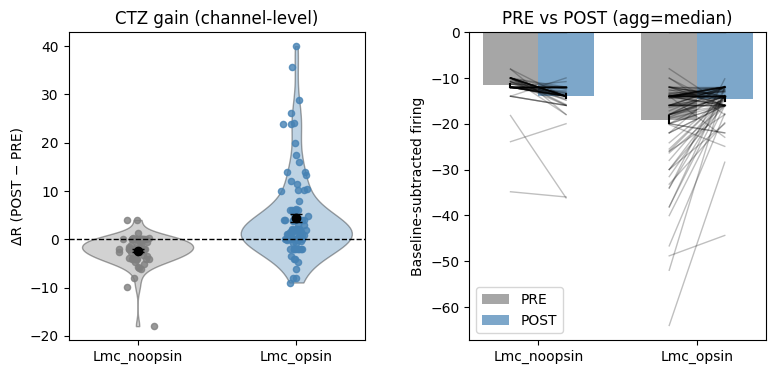

[DEBUG] fhz shape=(32, 999, 1500), baseline window=(0, 100), corrected shape=(32, 999, 1500)
[DEBUG] fhz shape=(32, 991, 1500), baseline window=(0, 100), corrected shape=(32, 991, 1500)
[DEBUG] fhz shape=(32, 986, 1500), baseline window=(0, 100), corrected shape=(32, 986, 1500)
[DEBUG] fhz shape=(32, 999, 1500), baseline window=(0, 100), corrected shape=(32, 999, 1500)
[DEBUG] fhz shape=(32, 998, 1500), baseline window=(0, 100), corrected shape=(32, 998, 1500)


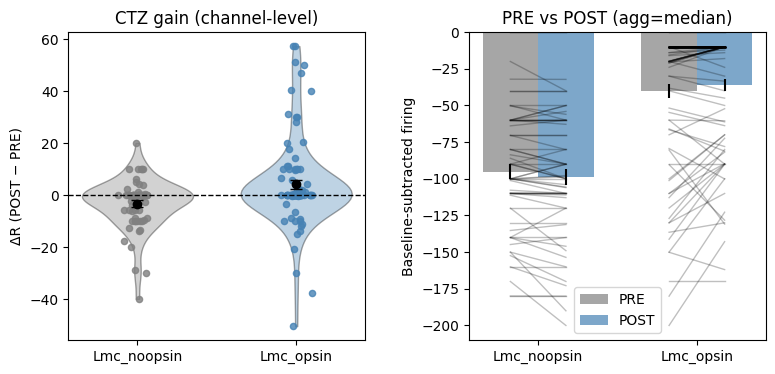

[DEBUG] fhz shape=(32, 986, 1500), baseline window=(0, 100), corrected shape=(32, 986, 1500)
[DEBUG] fhz shape=(32, 999, 1500), baseline window=(0, 100), corrected shape=(32, 999, 1500)
[DEBUG] fhz shape=(32, 998, 1500), baseline window=(0, 100), corrected shape=(32, 998, 1500)


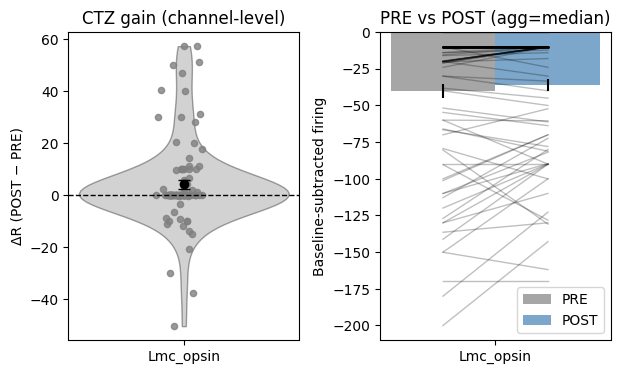

In [ ]:
df_both = plot_whisker_ctz_gain(
    ana,
    groups=("Lmc_noopsin", "Lmc_opsin"),
    stim_ids=(2,3,4),
    agg="median",
    show_individual=True
)



df_both = plot_whisker_ctz_gain(
    ana,
    groups=("Lmc_noopsin", "Lmc_opsin"),
    stim_ids=(2,3,4),
    agg="median",
    show_individual=True, 
    fr_window=(0,100)
)

df_both = plot_whisker_ctz_gain(
    ana,
    groups=("Lmc_opsin"),
    stim_ids=(2,3,4),
    agg="median",
    show_individual=True, 
    fr_window=(0,100)
    exclude_recordings=
)


In [21]:
key = ["group", "recording", "channel"]

df_joint = (
    df_both
    .merge(
        df_led_mean,
        on=key,
        how="inner",
        suffixes=("_ctz", "_led")
    )
)

df_joint.head()

NameError: name 'df_both' is not defined

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4.5,4.5))

for g, color in [("Lmc_noopsin", "grey"), ("Lmc_opsin", "steelblue")]:
    sub = df_joint[df_joint["group"] == g]
    plt.scatter(
        sub["OI"],
        sub["delta_R"],
        alpha=0.7,
        label=g,
        color=color
    )

plt.axhline(0, color="k", ls="--", lw=1)
plt.axvline(0, color="k", ls="--", lw=1)
plt.xlabel("LED opto-index (OI)")
plt.ylabel("CTZ baseline shift ΔR (POST − PRE)")
plt.title("Per-channel link: LED sensitivity vs CTZ effect")
plt.legend(frameon=False)
plt.tight_layout()
plt.show()

NameError: name 'df_joint' is not defined

<Figure size 450x450 with 0 Axes>

In [ ]:
import numpy as np
import scipy.stats as st

for g in ["Lmc_noopsin", "Lmc_opsin"]:
    sub = df_joint[df_joint["group"] == g]

    x = sub["OI"].values
    y = sub["delta_R"].values

    # Pearson correlation
    r, p = st.pearsonr(x, y)
    r2 = r**2

    print(f"{g}: r = {r:.3f}, R² = {r2:.3f}, p = {p:.3e}, n = {len(sub)}")

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st

def analyze_led_ctz_link(
    df_led,
    df_ctz,
    groups=("Lmc_noopsin", "Lmc_opsin"),
    drop_recordings=None,   # dict or list or None
    plot=True,
    figsize=(9,4)
):
    """
    Relates LED opto-index (OI) to CTZ baseline shift (ΔR) at the channel level.

    Parameters
    ----------
    df_led : DataFrame
        Must contain columns: [group, recording, channel, OI]

    df_ctz : DataFrame
        Must contain columns: [group, recording, channel, delta_R]

    groups : tuple
        Groups to analyze

    drop_recordings : None | list | dict
        None -> keep all
        list -> drop these recordings from ALL groups
        dict -> {group: [rec1, rec2]}

    plot : bool
        Whether to plot scatter + regression

    Returns
    -------
    df_joint : merged DataFrame
    stats_df : summary statistics per group
    """

    # ------------------
    # Merge safely
    # ------------------
    key = ["group", "recording", "channel"]
    df_joint = df_ctz.merge(
        df_led[key + ["OI"]],
        on=key,
        how="inner"
    )

    # ------------------
    # Drop recordings
    # ------------------
    if drop_recordings is not None:
        if isinstance(drop_recordings, dict):
            for g, recs in drop_recordings.items():
                df_joint = df_joint[
                    ~((df_joint["group"] == g) &
                      (df_joint["recording"].isin(recs)))
                ]
        else:
            # list or tuple → global drop
            df_joint = df_joint[
                ~df_joint["recording"].isin(drop_recordings)
            ]

    # ------------------
    # Per-group stats
    # ------------------
    stats = []

    for g in groups:
        sub = df_joint[df_joint["group"] == g]
        x = sub["OI"].values
        y = sub["delta_R"].values

        if len(sub) < 3:
            r = r2 = p = np.nan
        else:
            r, p = st.pearsonr(x, y)
            r2 = r**2

        stats.append({
            "group": g,
            "n_channels": len(sub),
            "r": r,
            "R2": r2,
            "p": p
        })

    stats_df = pd.DataFrame(stats)

    # ------------------
    # Plot (optional)
    # ------------------
    if plot:
        fig, axs = plt.subplots(1, len(groups), figsize=figsize, sharey=True)

        if len(groups) == 1:
            axs = [axs]

        colors = ["grey", "steelblue", "sandybrown"]

        for ax, g, color in zip(axs, groups, colors):
            sub = df_joint[df_joint["group"] == g]
            x = sub["OI"].values
            y = sub["delta_R"].values

            ax.scatter(x, y, alpha=0.7, color=color)

            if len(sub) >= 3:
                slope, intercept, r, p, _ = st.linregress(x, y)
                xx = np.linspace(x.min(), x.max(), 100)
                ax.plot(xx, intercept + slope*xx, color="black", lw=2)

                ax.set_title(
                    f"{g}\nR²={r**2:.3f}, p={p:.2e}, n={len(sub)}"
                )
            else:
                ax.set_title(f"{g}\n(n={len(sub)})")

            ax.axhline(0, color="k", ls="--", lw=1)
            ax.axvline(0, color="k", ls="--", lw=1)
            ax.set_xlabel("LED opto-index (OI)")

        axs[0].set_ylabel("CTZ baseline shift ΔR (POST − PRE)")
        plt.tight_layout()
        plt.show()

    return df_joint, stats_df

In [19]:
df_joint, stats = analyze_led_ctz_link(
    df_led_mean,
    df_both,
    groups=("Lmc_noopsin", "Lmc_opsin"),
    plot=True
)

stats

NameError: name 'analyze_led_ctz_link' is not defined

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st

def analyze_led_ctz_link(
    df_led,
    df_ctz,
    groups=("Lmc_noopsin", "Lmc_opsin"),
    drop_recordings=None,   # dict or list or None
    plot=True,
    figsize=(9,4)
):
    """
    Relates LED opto-index (OI) to CTZ baseline shift (ΔR) at the channel level.

    Parameters
    ----------
    df_led : DataFrame
        Must contain columns: [group, recording, channel, OI]

    df_ctz : DataFrame
        Must contain columns: [group, recording, channel, delta_R]

    groups : tuple
        Groups to analyze

    drop_recordings : None | list | dict
        None -> keep all
        list -> drop these recordings from ALL groups
        dict -> {group: [rec1, rec2]}

    plot : bool
        Whether to plot scatter + regression

    Returns
    -------
    df_joint : merged DataFrame
    stats_df : summary statistics per group
    """

    # ------------------
    # Merge safely
    # ------------------
    key = ["group", "recording", "channel"]
    df_joint = df_ctz.merge(
        df_led[key + ["OI"]],
        on=key,
        how="inner"
    )

    # ------------------
    # Drop recordings
    # ------------------
    if drop_recordings is not None:
        if isinstance(drop_recordings, dict):
            for g, recs in drop_recordings.items():
                df_joint = df_joint[
                    ~((df_joint["group"] == g) &
                      (df_joint["recording"].isin(recs)))
                ]
        else:
            # list or tuple → global drop
            df_joint = df_joint[
                ~df_joint["recording"].isin(drop_recordings)
            ]

    # ------------------
    # Per-group stats
    # ------------------
    stats = []

    for g in groups:
        sub = df_joint[df_joint["group"] == g]
        x = sub["OI"].values
        y = sub["delta_R"].values

        if len(sub) < 3:
            r = r2 = p = np.nan
        else:
            r, p = st.pearsonr(x, y)
            r2 = r**2

        stats.append({
            "group": g,
            "n_channels": len(sub),
            "r": r,
            "R2": r2,
            "p": p
        })

    stats_df = pd.DataFrame(stats)

    # ------------------
    # Plot (optional)
    # ------------------
    if plot:
        fig, axs = plt.subplots(1, len(groups), figsize=figsize, sharey=True)

        if len(groups) == 1:
            axs = [axs]

        colors = ["grey", "steelblue", "sandybrown"]

        for ax, g, color in zip(axs, groups, colors):
            sub = df_joint[df_joint["group"] == g]
            x = sub["OI"].values
            y = sub["delta_R"].values

            ax.scatter(x, y, alpha=0.7, color=color)

            if len(sub) >= 3:
                slope, intercept, r, p, _ = st.linregress(x, y)
                xx = np.linspace(x.min(), x.max(), 100)
                ax.plot(xx, intercept + slope*xx, color="black", lw=2)

                ax.set_title(
                    f"{g}\nR²={r**2:.3f}, p={p:.2e}, n={len(sub)}"
                )
            else:
                ax.set_title(f"{g}\n(n={len(sub)})")

            ax.axhline(0, color="k", ls="--", lw=1)
            ax.axvline(0, color="k", ls="--", lw=1)
            ax.set_xlabel("LED opto-index (OI)")

        axs[0].set_ylabel("CTZ baseline shift ΔR (POST − PRE)")
        plt.tight_layout()
        plt.show()

    return df_joint, stats_df

In [ ]:
#prinmt the auniqwuer recordion gnmames
print(df_joint["recording"].unique())

In [ ]:
df_joint, stats = analyze_led_ctz_link(
    df_led=df_led_mean,
    df_ctz=df_both,
    groups=("Lmc_noopsin", "Lmc_opsin"),
    plot=True
)

stats

In [ ]:
# ['lmc_noch_1_3096_rec1' 'lmc_noch_1_3096_rec2' 'lmc_ch_1_3094_rec1'
# 'lmc_ch_1_3094_rec2' 'lmc_ch_2_3093_rec1']

df_joint, stats = analyze_led_ctz_link(
    df_led=df_led_mean,
    df_ctz=df_both,
    groups=("Lmc_noopsin", "Lmc_opsin"),
    plot=True
)

stats


df_joint_drop1, stats_drop1 = analyze_led_ctz_link(
    df_led=df_led_mean,
    df_ctz=df_both,
    groups=("Lmc_noopsin", "Lmc_opsin"),
    drop_recordings={"Lmc_opsin": ["lmc_ch_2_3093_rec1"]},
    plot=True
)

stats_drop1




df_joint_drop2, stats_drop2 = analyze_led_ctz_link(
    df_led=df_led_mean,
    df_ctz=df_both,
    groups=("Lmc_noopsin", "Lmc_opsin"),
    drop_recordings={
        "Lmc_opsin": [
            "lmc_ch_2_3093_rec1",
            "lmc_ch_2_3093_rec2"
        ]
    },
    plot=True
)

stats_drop2


# drop lmc_noch_1_3096_rec1 one as well



In [ ]:
from itertools import combinations
import pandas as pd

# ------------------------------------------------------------
# RECORDINGS TO TEST (strings ONLY)
# ------------------------------------------------------------
recs = [
    "lmc_ch_1_3094_rec1",
    "lmc_ch_1_3094_rec2",
    "lmc_ch_2_3093_rec1",
]

results = []

# ------------------------------------------------------------
# ALL EXCLUSION COMBINATIONS
# ------------------------------------------------------------
for k in range(len(recs) + 1):
    for combo in combinations(recs, k):

        excluded = list(combo)
        label = "none" if len(excluded) == 0 else "+".join(excluded)

        print(f"[RUN] Excluding: {label}")

        df_joint, stats = analyze_led_ctz_link(
            df_led=df_led_mean,          # LED OI dataframe
            df_ctz=df_both,              # CTZ gain dataframe
            groups=("Lmc_noopsin", "Lmc_opsin"),
            drop_recordings=excluded if excluded else None,
            plot=False
        )

        stats = stats.copy()
        stats["excluded_recordings"] = label
        results.append(stats)

# ------------------------------------------------------------
# FINAL SUMMARY TABLE (FIXED COLUMN NAMES)
# ------------------------------------------------------------
df_exclusion_summary = pd.concat(results, ignore_index=True)

df_exclusion_summary = (
    df_exclusion_summary[
        ["group", "excluded_recordings", "n_channels", "r", "R2", "p"]
    ]
    .rename(columns={"n_channels": "n"})
    .sort_values(["group", "excluded_recordings"])
)

df_exclusion_summary

In [ ]:
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

df_exclusion_summary
opsin = df_exclusion_summary.query("group == 'Lmc_opsin'").copy()

opsin_sorted = opsin.sort_values("R2", ascending=False)

opsin_sorted

opsin_sorted.query("R2 > 0.05")
opsin_sorted[["excluded_recordings", "n", "R2", "p"]]

opsin_sorted.sort_values("n")

opsin_sorted.assign(
    unstable = opsin_sorted["n"] < 30
)
opsin_sorted[["n", "R2"]].corr()



In [ ]:
for _, r in opsin_sorted.iterrows():
    print(
        f"Exclude={r['excluded_recordings']:<55} | "
        f"n={int(r['n']):>3} | "
        f"R2={r['R2']:.3f} | "
        f"p={r['p']:.3g}"
    )

In [ ]:
import matplotlib.pyplot as plt

opsin = df_exclusion_summary.query("group == 'Lmc_opsin'")

plt.figure(figsize=(6,3))
plt.plot(opsin["excluded_recordings"], opsin["R2"], "o-", lw=2)
plt.axhline(0, color="k", ls="--", lw=1)
plt.ylabel("R² (LED OI vs CTZ gain)")
plt.xlabel("Excluded recordings")
plt.xticks(rotation=45, ha="right")
plt.title("Robustness of LED–CTZ relationship (Lmc_opsin)")
plt.tight_layout()
plt.show()

In [ ]:
df_led_excl = plot_led_group_oi(
    ana_led,
    stim_id=8,
    agg="mean",   # or median / max
    exclude_recordings=["lmc_ch_2_3093_rec1"]
)

df_ctz_baseline_excl = plot_whisker_ctz_gain(
    ana,
    groups=("Lmc_noopsin", "Lmc_opsin"),
    stim_ids=(2, 3, 4),
    fr_window=(-500, 0),
    agg="median",
    show_individual=True,
    exclude_recordings=["lmc_ch_2_3093_rec1"]
)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_whisker_evoked_psth_ctz(
    ana,
    group,
    stim_ids=(2, 3, 4),
    baseline=(-500, 0),
    evoked_window=(0, 100),
    channels="all",
    agg="mean",
    exclude_recordings=None,   # ✅ NEW
    figsize=(5, 4),
):
    """
    Baseline-corrected evoked PSTHs (PRE vs POST CTZ).

    • Baseline subtraction per channel
    • PRE vs POST via luciferin
    • Sensory-only stim pooling
    • Channel-level ops, aggregate AFTER
    """

    if exclude_recordings is None:
        exclude_recordings = []

    agg_func = {
        "mean": np.mean,
        "median": np.median
    }[agg]

    pooled_pre  = []
    pooled_post = []
    tms_ref = None

    rec_dirs = sorted((ana.output_base / "Whisker" / group).glob("*"))

    for rec_dir in rec_dirs:
        rec = rec_dir.name

        # ✅ EXCLUSION LOGIC
        if rec in exclude_recordings:
            print(f"[SKIP] Excluding recording: {rec}")
            continue

        fhz_corr, tms, trials = ana.baseline_corrected_psth(
            group, rec, baseline=baseline
        )
        if tms_ref is None:
            tms_ref = tms

        trials_sens = trials[trials["stim_id"].isin(stim_ids)]
        if trials_sens.empty:
            continue

        # PRE / POST split
        if "luciferin" in trials_sens.columns:
            pre_idx  = trials_sens.index[trials_sens["luciferin"] == 0].to_numpy()
            post_idx = trials_sens.index[trials_sens["luciferin"] == 1].to_numpy()
        else:
            idx = trials_sens.index.to_numpy()
            half = len(idx) // 2
            pre_idx, post_idx = idx[:half], idx[half:]

        if len(pre_idx) == 0 or len(post_idx) == 0:
            continue

        if channels == "all":
            chans = range(fhz_corr.shape[0])
        else:
            chans = channels

        # ---- channel-level PSTHs ----
        for ch in chans:
            pre_data  = fhz_corr[ch, pre_idx, :]
            post_data = fhz_corr[ch, post_idx, :]

            if pre_data.size == 0 or post_data.size == 0:
                continue

            pooled_pre.append(agg_func(pre_data, axis=0))
            pooled_post.append(agg_func(post_data, axis=0))

    pooled_pre  = np.asarray(pooled_pre)
    pooled_post = np.asarray(pooled_post)

    if pooled_pre.size == 0 or pooled_post.size == 0:
        raise RuntimeError("No valid PRE/POST PSTH data after exclusions.")

    # ---- group-level mean ± SEM ----
    mean_pre  = pooled_pre.mean(axis=0)
    mean_post = pooled_post.mean(axis=0)

    sem_pre  = pooled_pre.std(axis=0, ddof=1) / np.sqrt(pooled_pre.shape[0])
    sem_post = pooled_post.std(axis=0, ddof=1) / np.sqrt(pooled_post.shape[0])

    # =====================
    # -------- PLOT -------
    # =====================
    fig, ax = plt.subplots(figsize=figsize)

    ax.plot(tms_ref, mean_pre,  color="grey", lw=2,
            label=f"PRE (n={pooled_pre.shape[0]})")
    ax.fill_between(
        tms_ref, mean_pre-sem_pre, mean_pre+sem_pre,
        color="grey", alpha=0.25
    )

    ax.plot(tms_ref, mean_post, color="steelblue", lw=2,
            label=f"POST (n={pooled_post.shape[0]})")
    ax.fill_between(
        tms_ref, mean_post-sem_post, mean_post+sem_post,
        color="steelblue", alpha=0.25
    )

    ax.axvline(0, color="red", ls="--", lw=1)
    ax.axvspan(evoked_window[0], evoked_window[1],
               color="red", alpha=0.08, label="Evoked window")

    ax.set_xlabel("Time (ms)")
    ax.set_ylabel("Baseline-corrected firing (Hz)")
    ax.set_title(f"{group} — sensory evoked PSTH (PRE vs POST CTZ)")
    ax.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
plot_whisker_evoked_psth_ctz(
    ana,
    group="Lmc_opsin",
    stim_ids=(2, 3, 4),
    baseline=(-100, 0),
    evoked_window=(0, 100),
    exclude_recordings=["lmc_ch_2_3093_rec1"]
)

plot_whisker_evoked_psth_ctz(
    ana,
    group="Lmc_noopsin",
    stim_ids=(2, 3, 4),
    baseline=(-100, 0),
    evoked_window=(0, 100),
    exclude_recordings=["lmc_ch_2_3093_rec1"]
)

In [ ]:
import numpy as np
import pandas as pd

def extract_whisker_evoked_points_ctz(
    ana,
    group,
    stim_ids=(2, 3, 4),
    baseline=(-500, 0),
    evoked_window=(0, 100),
    channels="all",
    agg="mean",
    exclude_recordings=None,
):
    """
    Extract channel-level evoked firing values used in PSTHs.

    Returns tidy DataFrame:
        columns = [recording, channel, condition, evoked_hz]
    """

    if exclude_recordings is None:
        exclude_recordings = []

    agg_func = {
        "mean": np.mean,
        "median": np.median
    }[agg]

    rows = []

    rec_dirs = sorted((ana.output_base / "Whisker" / group).glob("*"))

    for rec_dir in rec_dirs:
        rec = rec_dir.name
        if rec in exclude_recordings:
            continue

        fhz_corr, tms, trials = ana.baseline_corrected_psth(
            group, rec, baseline=baseline
        )

        trials_sens = trials[trials["stim_id"].isin(stim_ids)]
        if trials_sens.empty:
            continue

        if "luciferin" in trials_sens.columns:
            pre_idx  = trials_sens.index[trials_sens["luciferin"] == 0].to_numpy()
            post_idx = trials_sens.index[trials_sens["luciferin"] == 1].to_numpy()
        else:
            idx = trials_sens.index.to_numpy()
            half = len(idx) // 2
            pre_idx, post_idx = idx[:half], idx[half:]

        if len(pre_idx) == 0 or len(post_idx) == 0:
            continue

        if channels == "all":
            chans = range(fhz_corr.shape[0])
        else:
            chans = channels

        wmask = (tms >= evoked_window[0]) & (tms <= evoked_window[1])

        for ch in chans:
            pre_data  = fhz_corr[ch, pre_idx, :][:, wmask]
            post_data = fhz_corr[ch, post_idx, :][:, wmask]

            if pre_data.size == 0 or post_data.size == 0:
                continue

            pre_val  = agg_func(pre_data)
            post_val = agg_func(post_data)

            rows.append({
                "recording": rec,
                "channel": ch,
                "condition": "PRE",
                "evoked_hz": pre_val,
            })
            rows.append({
                "recording": rec,
                "channel": ch,
                "condition": "POST",
                "evoked_hz": post_val,
            })

    return pd.DataFrame(rows)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import wilcoxon

def plot_whisker_psth_with_evoked_points(
    ana,
    group,
    stim_ids=(2, 3, 4),
    baseline=(-100, 0),
    evoked_window=(0, 100),
    channels="all",
    agg="mean",
    smooth_ms=None,                 # ✅ NEW
    exclude_recordings=None,
    figsize=(9, 4),
):
    """
    ONE function that:
      1) Computes PRE vs POST PSTH (optionally smoothed)
      2) Extracts channel-level evoked values from the SAME smoothed data
      3) Plots PSTH + underlying points side-by-side
    """

    if exclude_recordings is None:
        exclude_recordings = []

    agg_func = {"mean": np.mean, "median": np.median}[agg]

    pooled_pre, pooled_post = [], []
    rows = []
    tms_ref = None

    rec_dirs = sorted((ana.output_base / "Whisker" / group).glob("*"))

    for rec_dir in rec_dirs:
        rec = rec_dir.name
        if rec in exclude_recordings:
            continue

        fhz_corr, tms, trials = ana.baseline_corrected_psth(
            group, rec, baseline=baseline
        )

        if tms_ref is None:
            tms_ref = tms

        trials = trials[trials["stim_id"].isin(stim_ids)]
        if trials.empty:
            continue

        # PRE / POST split
        if "luciferin" in trials.columns:
            pre_idx  = trials.index[trials["luciferin"] == 0].to_numpy()
            post_idx = trials.index[trials["luciferin"] == 1].to_numpy()
        else:
            idx = trials.index.to_numpy()
            half = len(idx) // 2
            pre_idx, post_idx = idx[:half], idx[half:]

        if len(pre_idx) == 0 or len(post_idx) == 0:
            continue

        chans = range(fhz_corr.shape[0]) if channels == "all" else channels
        wmask = (tms >= evoked_window[0]) & (tms <= evoked_window[1])

        for ch in chans:
            pre_trials  = fhz_corr[ch, pre_idx, :]
            post_trials = fhz_corr[ch, post_idx, :]

            if pre_trials.size == 0 or post_trials.size == 0:
                continue

            # ✅ BOXCAR SMOOTHING (trial × time)
            pre_trials  = boxcar_smooth(pre_trials,  smooth_ms, tms)
            post_trials = boxcar_smooth(post_trials, smooth_ms, tms)

            # PSTH contribution
            pre_psth  = agg_func(pre_trials, axis=0)
            post_psth = agg_func(post_trials, axis=0)

            pooled_pre.append(pre_psth)
            pooled_post.append(post_psth)

            # Evoked scalar (from SAME smoothed data)
            rows.append({
                "recording": rec,
                "channel": ch,
                "condition": "PRE",
                "evoked_hz": agg_func(pre_trials[:, wmask])
            })
            rows.append({
                "recording": rec,
                "channel": ch,
                "condition": "POST",
                "evoked_hz": agg_func(post_trials[:, wmask])
            })

    pooled_pre = np.asarray(pooled_pre)
    pooled_post = np.asarray(pooled_post)

    if pooled_pre.size == 0:
        raise RuntimeError("No valid data after exclusions.")

    df_evoked = pd.DataFrame(rows)

    # ======================
    # -------- PLOT --------
    # ======================
    fig, (ax_psth, ax_pts) = plt.subplots(
        1, 2, figsize=figsize, gridspec_kw={"width_ratios": [2.5, 1]}
    )

    # ---- PSTH ----
    mean_pre  = pooled_pre.mean(axis=0)
    mean_post = pooled_post.mean(axis=0)

    sem_pre  = pooled_pre.std(axis=0, ddof=1) / np.sqrt(pooled_pre.shape[0])
    sem_post = pooled_post.std(axis=0, ddof=1) / np.sqrt(pooled_post.shape[0])

    ax_psth.plot(tms_ref, mean_pre, color="grey", lw=2,
                 label=f"PRE (n={pooled_pre.shape[0]})")
    ax_psth.fill_between(
        tms_ref, mean_pre-sem_pre, mean_pre+sem_pre,
        color="grey", alpha=0.25
    )

    ax_psth.plot(tms_ref, mean_post, color="steelblue", lw=2,
                 label=f"POST (n={pooled_post.shape[0]})")
    ax_psth.fill_between(
        tms_ref, mean_post-sem_post, mean_post+sem_post,
        color="steelblue", alpha=0.25
    )

    ax_psth.axvline(0, color="red", ls="--", lw=1)
    ax_psth.axvspan(evoked_window[0], evoked_window[1],
                    color="red", alpha=0.08)

    ax_psth.set_xlabel("Time (ms)")
    ax_psth.set_ylabel("Baseline-corrected firing (Hz)")
    ax_psth.set_title(f"{group} PSTH (smooth={smooth_ms} ms)")
    ax_psth.legend()

    # ---- POINTS ----
    for i, cond in enumerate(["PRE", "POST"]):
        vals = df_evoked[df_evoked["condition"] == cond]["evoked_hz"].values
        x = np.full_like(vals, i, dtype=float)
        ax_pts.scatter(
            x, vals,
            s=22, alpha=0.65,
            color="grey" if cond == "PRE" else "steelblue"
        )
        # ======================
    # ---- STAT TEST -------
    # ======================
    pivot = df_evoked.pivot_table(
        index=["recording", "channel"],
        columns="condition",
        values="evoked_hz"
    ).dropna()

    if len(pivot) < 5:
        print("[WARN] Too few paired channels for Wilcoxon test.")
        stat, pval = np.nan, np.nan
    else:
        stat, pval = wilcoxon(
            pivot["POST"],
            pivot["PRE"],
            alternative="two-sided"
        )

    # annotate right panel
    ax_pts.text(
        0.5,
        0.98,
        f"Wilcoxon paired\np = {pval:.3e}",
        ha="center",
        va="top",
        transform=ax_pts.transAxes,
        fontsize=10
    )

    print(
        f"[Wilcoxon signed-rank] "
        f"n={len(pivot)} channels | "
        f"stat={stat:.2f} | p={pval:.3e}"
    )

    ax_pts.set_xticks([0, 1])
    ax_pts.set_xticklabels(["PRE", "POST"])
    ax_pts.set_ylabel("Evoked firing (Hz)")
    ax_pts.set_title(f"{evoked_window[0]}–{evoked_window[1]} ms")

    plt.tight_layout()
    plt.show()

    return df_evoked

In [ ]:
df_evoked = plot_whisker_psth_with_evoked_points(
    ana,
    group="Lmc_opsin",
    stim_ids=(2, 3, 4),
    baseline=(-100, 0),
    evoked_window=(500, 999),
    smooth_ms=100,
    exclude_recordings=["lmc_ch_2_3093_rec1"]
)

df_evoked = plot_whisker_psth_with_evoked_points(
    ana,
    group="Lmc_opsin",
    stim_ids=(2, 3, 4),
    baseline=(-100, 0),
    evoked_window=(-10, -5),
    smooth_ms=100,
    exclude_recordings=["lmc_ch_2_3093_rec1"]
)

In [ ]:
df_evoked = plot_whisker_psth_with_evoked_points(
    ana,
    group="Lmc_opsin",
    stim_ids=(2, 3, 4),
    baseline=(-100, 0),
    evoked_window=(500, 999),
    smooth_ms=200,
    exclude_recordings=["lmc_ch_2_3093_rec1"]
)

df_evoked = plot_whisker_psth_with_evoked_points(
    ana,
    group="Lmc_opsin",
    stim_ids=(2, 3, 4),
    baseline=(-100, 0),
    evoked_window=(-10, -5),
    smooth_ms=200,
    exclude_recordings=["lmc_ch_2_3093_rec1"]
)

In [ ]:
def boxcar_smooth(x, win_ms, tms):
    """
    Boxcar smooth along time axis.
    x   : array (..., time)
    win_ms : smoothing window in ms (e.g. 10, 20)
    tms : time vector in ms
    """
    if win_ms is None or win_ms <= 0:
        return x

    dt = np.median(np.diff(tms))
    win_bins = int(round(win_ms / dt))

    if win_bins < 2:
        return x

    kernel = np.ones(win_bins) / win_bins

    return np.apply_along_axis(
        lambda v: np.convolve(v, kernel, mode="same"),
        axis=-1,
        arr=x
    )


def plot_whisker_evoked_psth_ctz(
    ana,
    group,
    stim_ids=(2, 3, 4),
    baseline=(-500, 0),
    evoked_window=(0, 100),
    channels="all",
    agg="mean",
    smooth_ms=None,                 # ✅ NEW
    exclude_recordings=None,
    figsize=(5, 4),
):
    """
    Baseline-corrected evoked PSTHs (PRE vs POST CTZ).
    """

    if exclude_recordings is None:
        exclude_recordings = []

    agg_func = {
        "mean": np.mean,
        "median": np.median
    }[agg]

    pooled_pre  = []
    pooled_post = []
    tms_ref = None

    meta = {
        "group": group,
        "stim_ids": tuple(stim_ids),
        "baseline": baseline,
        "evoked_window": evoked_window,
        "agg": agg,
        "smooth_ms": smooth_ms,
        "exclude_recordings": tuple(exclude_recordings),
    }

    rec_dirs = sorted((ana.output_base / "Whisker" / group).glob("*"))

    for rec_dir in rec_dirs:
        rec = rec_dir.name
        if rec in exclude_recordings:
            continue

        fhz_corr, tms, trials = ana.baseline_corrected_psth(
            group, rec, baseline=baseline
        )
        if tms_ref is None:
            tms_ref = tms

        trials_sens = trials[trials["stim_id"].isin(stim_ids)]
        if trials_sens.empty:
            continue

        if "luciferin" in trials_sens.columns:
            pre_idx  = trials_sens.index[trials_sens["luciferin"] == 0].to_numpy()
            post_idx = trials_sens.index[trials_sens["luciferin"] == 1].to_numpy()
        else:
            idx = trials_sens.index.to_numpy()
            half = len(idx) // 2
            pre_idx, post_idx = idx[:half], idx[half:]

        if len(pre_idx) == 0 or len(post_idx) == 0:
            continue

        chans = range(fhz_corr.shape[0]) if channels == "all" else channels

        for ch in chans:
            pre_data  = fhz_corr[ch, pre_idx, :]
            post_data = fhz_corr[ch, post_idx, :]

            if pre_data.size == 0 or post_data.size == 0:
                continue

            # ✅ BOXCAR SMOOTHING HERE
            pre_data  = boxcar_smooth(pre_data,  smooth_ms, tms)
            post_data = boxcar_smooth(post_data, smooth_ms, tms)

            pooled_pre.append(agg_func(pre_data, axis=0))
            pooled_post.append(agg_func(post_data, axis=0))

    pooled_pre  = np.asarray(pooled_pre)
    pooled_post = np.asarray(pooled_post)

    if pooled_pre.size == 0:
        raise RuntimeError("No valid data after exclusions.")

    # ---- plot ----
    mean_pre  = pooled_pre.mean(axis=0)
    mean_post = pooled_post.mean(axis=0)

    sem_pre  = pooled_pre.std(axis=0, ddof=1) / np.sqrt(pooled_pre.shape[0])
    sem_post = pooled_post.std(axis=0, ddof=1) / np.sqrt(pooled_post.shape[0])

    fig, ax = plt.subplots(figsize=figsize)

    ax.plot(tms_ref, mean_pre,  color="grey", lw=2, label="PRE")
    ax.fill_between(tms_ref, mean_pre-sem_pre, mean_pre+sem_pre,
                    color="grey", alpha=0.25)

    ax.plot(tms_ref, mean_post, color="steelblue", lw=2, label="POST")
    ax.fill_between(tms_ref, mean_post-sem_post, mean_post+sem_post,
                    color="steelblue", alpha=0.25)

    ax.axvline(0, color="red", ls="--")
    ax.axvspan(evoked_window[0], evoked_window[1],
               color="red", alpha=0.08)

    ax.set_title(f"{group} evoked PSTH (smooth={smooth_ms} ms)")
    ax.set_xlabel("Time (ms)")
    ax.set_ylabel("Baseline-corrected firing (Hz)")
    ax.legend()

    plt.tight_layout()
    plt.show()

    return {
        "tms": tms_ref,
        "mean_pre": mean_pre,
        "mean_post": mean_post,
        "sem_pre": sem_pre,
        "sem_post": sem_post,
        "meta": meta,
    }

In [ ]:
out = plot_whisker_evoked_psth_ctz(
    ana,
    group="Lmc_opsin",
    stim_ids=(2,3,4),
    exclude_recordings=["lmc_ch_2_3093_rec1"]
)

plot_whisker_evoked_psth_ctz(
    ana,
    group="Lmc_opsin",
    stim_ids=(2,3,4),
    smooth_ms=200,
    exclude_recordings=["lmc_ch_2_3093_rec1"]
)

plot_whisker_evoked_psth_ctz(
    ana,
    group="Lmc_noopsin",
    stim_ids=(2,3,4),
    smooth_ms=200,
    exclude_recordings=["lmc_ch_2_3093_rec1"]
)

plot_whisker_evoked_psth_ctz(
    ana,
    group="Lmc_noopsin",
    stim_ids=(2,3,4),
    exclude_recordings=["lmc_ch_2_3093_rec1"]
)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_whisker_evoked_individual_traces(
    ana,
    group,
    stim_ids=(2,3,4),
    fr_window=(-500, 0),
    response_window=(0, 800),
    smooth_ms=None,              # None or e.g. 50, 100, 200
    show_mean=False,             # overlay group mean?
    exclude_recordings=None,
    max_channels=None,           # cap number of channels plotted (for sanity)
    alpha=0.25,
    lw=1,
    figsize=(6,4)
):
    """
    Plot individual channel-level PRE vs POST PSTHs (baseline-corrected).

    • NO averaging across channels by default
    • Each line = one channel
    • PRE = grey, POST = blue
    • Optional smoothing and mean overlay
    """

    if exclude_recordings is None:
        exclude_recordings = []

    all_pre = []
    all_post = []

    for rec_dir in sorted((ana.output_base / "Whisker" / group).glob("*")):
        rec = rec_dir.name
        if rec in exclude_recordings:
            continue

        fhz_corr, tms, trials = ana.baseline_corrected_psth(
            group, rec, baseline=fr_window
        )

        trials_sens = trials[trials["stim_id"].isin(stim_ids)]
        if trials_sens.empty:
            continue

        if "luciferin" in trials_sens.columns:
            pre_idx  = trials_sens.index[trials_sens["luciferin"] == 0]
            post_idx = trials_sens.index[trials_sens["luciferin"] == 1]
        else:
            idx = trials_sens.index.to_numpy()
            half = len(idx) // 2
            pre_idx, post_idx = idx[:half], idx[half:]

        if len(pre_idx) == 0 or len(post_idx) == 0:
            continue

        tmask = (tms >= response_window[0]) & (tms <= response_window[1])

        for ch in range(fhz_corr.shape[0]):
            pre_trace  = fhz_corr[ch, pre_idx][:, tmask].mean(axis=0)
            post_trace = fhz_corr[ch, post_idx][:, tmask].mean(axis=0)

            all_pre.append(pre_trace)
            all_post.append(post_trace)

            if max_channels and len(all_pre) >= max_channels:
                break

    all_pre  = np.array(all_pre)
    all_post = np.array(all_post)
    t_plot   = tms[tmask]

    # Optional smoothing
    if smooth_ms is not None:
        bin_ms = t_plot[1] - t_plot[0]
        win = int(np.round(smooth_ms / bin_ms))
        win = max(1, win)

        kernel = np.ones(win) / win
        all_pre  = np.array([np.convolve(x, kernel, mode="same") for x in all_pre])
        all_post = np.array([np.convolve(x, kernel, mode="same") for x in all_post])

    # ---- Plot ----
    plt.figure(figsize=figsize)

    for tr in all_pre:
        plt.plot(t_plot, tr, color="grey", alpha=alpha, lw=lw)

    for tr in all_post:
        plt.plot(t_plot, tr, color="steelblue", alpha=alpha, lw=lw)

    if show_mean:
        plt.plot(t_plot, all_pre.mean(axis=0), color="black", lw=3, label="PRE mean")
        plt.plot(t_plot, all_post.mean(axis=0), color="blue", lw=3, label="POST mean")

    plt.axvline(0, color="red", ls="--")
    plt.xlabel("Time (ms)")
    plt.ylabel("Baseline-corrected firing (Hz)")
    plt.title(f"{group} | individual channels (n={len(all_pre)})")
    if show_mean:
        plt.legend()
    plt.tight_layout()
    plt.show()

    return {
        "t": t_plot,
        "pre": all_pre,
        "post": all_post
    }

In [ ]:
plot_whisker_evoked_individual_traces(
    ana,
    group="Lmc_opsin",
    stim_ids=(2,3,4),
    smooth_ms=None,
    exclude_recordings=["lmc_ch_2_3093_rec1"]
)

plot_whisker_evoked_individual_traces(
    ana,
    group="Lmc_opsin",
    stim_ids=(2,3,4),
    smooth_ms=200,
    show_mean=True,
    exclude_recordings=["lmc_ch_2_3093_rec1"]
)

In [ ]:
plot_whisker_evoked_individual_traces(
    ana,
    group="Lmc_noopsin",
    stim_ids=(2,3,4),
    show_mean=True,
    exclude_recordings=["lmc_ch_2_3093_rec1"]
)

plot_whisker_evoked_individual_traces(
    ana,
    group="Lmc_noopsin",
    stim_ids=(2,3,4),
    smooth_ms=200,
    show_mean=True,
    exclude_recordings=["lmc_ch_2_3093_rec1"]
)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_whisker_evoked_individual_traces(
    ana,
    group,
    stim_ids=(2,3,4),
    baseline_window=(-500, 0),      # used ONLY for baseline correction
    analysis_window=(0, 800),       # used ONLY for analysis (optional)
    smooth_ms=None,                 # None or e.g. 50, 100, 200
    show_mean=False,
    exclude_recordings=None,
    max_channels=None,
    alpha=0.25,
    lw=1,
    highlight_window=True,
    figsize=(7,4)
):
    """
    Plot individual channel-level PRE vs POST PSTHs over FULL time axis.

    • Full time series shown (no cropping)
    • Baseline subtraction uses baseline_window
    • PRE vs POST split via luciferin
    • analysis_window is NOT cropping — only optional highlight
    • Each line = one channel
    """

    if exclude_recordings is None:
        exclude_recordings = []

    all_pre = []
    all_post = []
    t_ref = None

    for rec_dir in sorted((ana.output_base / "Whisker" / group).glob("*")):
        rec = rec_dir.name
        if rec in exclude_recordings:
            continue

        fhz_corr, tms, trials = ana.baseline_corrected_psth(
            group, rec, baseline=baseline_window
        )

        if t_ref is None:
            t_ref = tms

        trials_sens = trials[trials["stim_id"].isin(stim_ids)]
        if trials_sens.empty:
            continue

        # PRE / POST split
        if "luciferin" in trials_sens.columns:
            pre_idx  = trials_sens.index[trials_sens["luciferin"] == 0]
            post_idx = trials_sens.index[trials_sens["luciferin"] == 1]
        else:
            idx = trials_sens.index.to_numpy()
            half = len(idx) // 2
            pre_idx, post_idx = idx[:half], idx[half:]

        if len(pre_idx) == 0 or len(post_idx) == 0:
            continue

        for ch in range(fhz_corr.shape[0]):
            pre_trace  = fhz_corr[ch, pre_idx, :].mean(axis=0)
            post_trace = fhz_corr[ch, post_idx, :].mean(axis=0)

            all_pre.append(pre_trace)
            all_post.append(post_trace)

            if max_channels and len(all_pre) >= max_channels:
                break

    all_pre  = np.array(all_pre)
    all_post = np.array(all_post)

    # ---------- optional smoothing ----------
    if smooth_ms is not None:
        bin_ms = t_ref[1] - t_ref[0]
        win = int(np.round(smooth_ms / bin_ms))
        win = max(1, win)
        kernel = np.ones(win) / win

        all_pre  = np.array([np.convolve(x, kernel, mode="same") for x in all_pre])
        all_post = np.array([np.convolve(x, kernel, mode="same") for x in all_post])

    # ---------- plotting ----------
    plt.figure(figsize=figsize)

    for tr in all_pre:
        plt.plot(t_ref, tr, color="grey", alpha=alpha, lw=lw)

    for tr in all_post:
        plt.plot(t_ref, tr, color="steelblue", alpha=alpha, lw=lw)

    if show_mean:
        plt.plot(t_ref, all_pre.mean(axis=0), color="black", lw=3, label="PRE mean")
        plt.plot(t_ref, all_post.mean(axis=0), color="blue", lw=3, label="POST mean")

    plt.axvline(0, color="red", ls="--", lw=1)

    if highlight_window:
        plt.axvspan(
            analysis_window[0],
            analysis_window[1],
            color="red",
            alpha=0.08,
            label="analysis window"
        )

    plt.xlabel("Time (ms)")
    plt.ylabel("Baseline-corrected firing (Hz)")
    plt.title(
        f"{group} | individual channels\n"
        f"baseline={baseline_window} ms, smooth={smooth_ms} ms"
    )

    if show_mean or highlight_window:
        plt.legend(frameon=False)

    plt.tight_layout()
    plt.show()

    return {
        "t": t_ref,
        "pre": all_pre,
        "post": all_post
    }

In [ ]:
plot_whisker_evoked_individual_traces(
    ana,
    group="Lmc_opsin",
    stim_ids=(2,3,4),
    smooth_ms=None,
    exclude_recordings=["lmc_ch_2_3093_rec1"]
)

plot_whisker_evoked_individual_traces(
    ana,
    group="Lmc_opsin",
    stim_ids=(2,3,4),
    smooth_ms=200,
    show_mean=True,
    exclude_recordings=["lmc_ch_2_3093_rec1"]
)

plot_whisker_evoked_individual_traces(
    ana,
    group="Lmc_noopsin",
    stim_ids=(2,3,4),
    smooth_ms=None,
    exclude_recordings=["lmc_ch_2_3093_rec1"]
)

plot_whisker_evoked_individual_traces(
    ana,
    group="Lmc_noopsin",
    stim_ids=(2,3,4),
    smooth_ms=200,
    show_mean=True,
    exclude_recordings=["lmc_ch_2_3093_rec1"]
)

plot_whisker_evoked_individual_traces(
    ana,
    group="Lmc_opsin",
    stim_ids=(2,3,4),
    smooth_ms=None,
    exclude_recordings=["lmc_ch_2_3093_rec1"]
)

plot_whisker_evoked_individual_traces(
    ana,
    group="Lmc_opsin",
    stim_ids=(2,3,4),
    smooth_ms=20,
    show_mean=True,
    exclude_recordings=["lmc_ch_2_3093_rec1"]
)

plot_whisker_evoked_individual_traces(
    ana,
    group="Lmc_noopsin",
    stim_ids=(2,3,4),
    smooth_ms=None,
    exclude_recordings=["lmc_ch_2_3093_rec1"]
)

plot_whisker_evoked_individual_traces(
    ana,
    group="Lmc_noopsin",
    stim_ids=(2,3,4),
    smooth_ms=20,
    show_mean=True,
    exclude_recordings=["lmc_ch_2_3093_rec1"]
)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_whisker_evoked_individual_traces(
    ana,
    group,
    stim_ids=(2,3,4),
    baseline_window=(-500, 0),      # used ONLY for baseline correction
    analysis_window=(0, 800),       # optional highlight
    view_window=None,               # ✅ NEW: controls what is DISPLAYED
    smooth_ms=None,                 # None or e.g. 50, 100, 200
    show_mean=False,
    exclude_recordings=None,
    max_channels=None,
    alpha=0.25,
    lw=1,
    highlight_window=True,
    figsize=(7,4)
):
    """
    Plot individual channel-level PRE vs POST PSTHs over FULL time axis,
    with optional view-window zooming.

    • Data are ALWAYS computed on full PSTH
    • view_window ONLY affects plotting (xlim)
    """

    if exclude_recordings is None:
        exclude_recordings = []

    all_pre = []
    all_post = []
    t_ref = None

    for rec_dir in sorted((ana.output_base / "Whisker" / group).glob("*")):
        rec = rec_dir.name
        if rec in exclude_recordings:
            continue

        fhz_corr, tms, trials = ana.baseline_corrected_psth(
            group, rec, baseline=baseline_window
        )

        if t_ref is None:
            t_ref = tms

        trials_sens = trials[trials["stim_id"].isin(stim_ids)]
        if trials_sens.empty:
            continue

        # PRE / POST split
        if "luciferin" in trials_sens.columns:
            pre_idx  = trials_sens.index[trials_sens["luciferin"] == 0]
            post_idx = trials_sens.index[trials_sens["luciferin"] == 1]
        else:
            idx = trials_sens.index.to_numpy()
            half = len(idx) // 2
            pre_idx, post_idx = idx[:half], idx[half:]

        if len(pre_idx) == 0 or len(post_idx) == 0:
            continue

        for ch in range(fhz_corr.shape[0]):
            pre_trace  = fhz_corr[ch, pre_idx, :].mean(axis=0)
            post_trace = fhz_corr[ch, post_idx, :].mean(axis=0)

            all_pre.append(pre_trace)
            all_post.append(post_trace)

            if max_channels and len(all_pre) >= max_channels:
                break

    all_pre  = np.array(all_pre)
    all_post = np.array(all_post)

    # ---------- optional smoothing ----------
    if smooth_ms is not None:
        bin_ms = t_ref[1] - t_ref[0]
        win = int(np.round(smooth_ms / bin_ms))
        win = max(1, win)
        kernel = np.ones(win) / win

        all_pre  = np.array([np.convolve(x, kernel, mode="same") for x in all_pre])
        all_post = np.array([np.convolve(x, kernel, mode="same") for x in all_post])

    # ---------- plotting ----------
    plt.figure(figsize=figsize)

    for tr in all_pre:
        plt.plot(t_ref, tr, color="grey", alpha=alpha, lw=lw)

    for tr in all_post:
        plt.plot(t_ref, tr, color="steelblue", alpha=alpha, lw=lw)

    if show_mean:
        plt.plot(t_ref, all_pre.mean(axis=0), color="black", lw=3, label="PRE mean")
        plt.plot(t_ref, all_post.mean(axis=0), color="blue", lw=3, label="POST mean")

    plt.axvline(0, color="red", ls="--", lw=1)

    if highlight_window:
        plt.axvspan(
            analysis_window[0],
            analysis_window[1],
            color="red",
            alpha=0.08,
            label="analysis window"
        )

    # ✅ VIEW WINDOW (DISPLAY ONLY)
    if view_window is not None:
        plt.xlim(view_window)

    plt.xlabel("Time (ms)")
    plt.ylabel("Baseline-corrected firing (Hz)")
    plt.title(
        f"{group} | individual channels\n"
        f"baseline={baseline_window} ms, smooth={smooth_ms} ms"
    )

    if show_mean or highlight_window:
        plt.legend(frameon=False)

    plt.tight_layout()
    plt.show()

    return {
        "t": t_ref,
        "pre": all_pre,
        "post": all_post
    }

In [ ]:
plot_whisker_evoked_individual_traces(
    ana,
    group="Lmc_noopsin",
    stim_ids=(2,3,4),
    smooth_ms=None
)

In [ ]:
plot_whisker_evoked_individual_traces(
    ana,
    group="Lmc_opsin",
    stim_ids=(2,3,4),
    smooth_ms=1,
    view_window=(-10, 25)
)

plot_whisker_evoked_individual_traces(
    ana,
    group="Lmc_noopsin",
    stim_ids=(2,3,4),
    smooth_ms=1,
    view_window=(-10, 25)
)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_whisker_evoked_individual_traces(
    ana,
    group,
    stim_ids=(2,3,4),

    # baseline + normalization
    baseline_window=(-500, 0),
    normalize_evoked=True,
    norm_window=(0, 50),          # ms window used for normalization

    # visualization
    analysis_window=(0, 800),
    view_window=None,
    smooth_ms=None,
    show_mean=False,

    # hygiene
    exclude_recordings=None,
    artifact_window=None,         # e.g. (-5, 15) or None
    artifact_mode="nan",          # "nan" or "zero"
    max_channels=None,

    # style
    alpha=0.25,
    lw=1,
    figsize=(7,4),
):
    """
    Plot individual channel-level PRE vs POST PSTHs over FULL time axis,
    with baseline subtraction and OPTIONAL within-channel evoked normalization.

    Pipeline (per channel):
      raw PSTH
        -> baseline subtraction
        -> optional artifact masking
        -> optional evoked normalization (PRE-based)
        -> optional smoothing
        -> plotting / aggregation
    """

    if exclude_recordings is None:
        exclude_recordings = []

    all_pre = []
    all_post = []
    t_ref = None

    # -------------------------------
    # loop recordings
    # -------------------------------
    for rec_dir in sorted((ana.output_base / "Whisker" / group).glob("*")):
        rec = rec_dir.name
        if rec in exclude_recordings:
            continue

        fhz_corr, tms, trials = ana.baseline_corrected_psth(
            group, rec, baseline=baseline_window
        )

        if t_ref is None:
            t_ref = tms

        trials_sens = trials[trials["stim_id"].isin(stim_ids)]
        if trials_sens.empty:
            continue

        # PRE / POST split
        if "luciferin" in trials_sens.columns:
            pre_idx  = trials_sens.index[trials_sens["luciferin"] == 0]
            post_idx = trials_sens.index[trials_sens["luciferin"] == 1]
        else:
            idx = trials_sens.index.to_numpy()
            half = len(idx) // 2
            pre_idx, post_idx = idx[:half], idx[half:]

        if len(pre_idx) == 0 or len(post_idx) == 0:
            continue

        # artifact mask
        if artifact_window is not None:
            a0, a1 = artifact_window
            amask = (tms >= a0) & (tms <= a1)
        else:
            amask = None

        # normalization mask
        nmask = (tms >= norm_window[0]) & (tms < norm_window[1])

        # -------------------------------
        # loop channels
        # -------------------------------
        for ch in range(fhz_corr.shape[0]):

            pre_trace  = fhz_corr[ch, pre_idx, :].mean(axis=0)
            post_trace = fhz_corr[ch, post_idx, :].mean(axis=0)

            # artifact handling
            if amask is not None and amask.any():
                if artifact_mode == "nan":
                    pre_trace  = pre_trace.astype(float)
                    post_trace = post_trace.astype(float)
                    pre_trace[amask]  = np.nan
                    post_trace[amask] = np.nan
                elif artifact_mode == "zero":
                    pre_trace[amask]  = 0.0
                    post_trace[amask] = 0.0

            # -------------------------------
            # 🔑 EVOKED NORMALIZATION (KEY FIX)
            # -------------------------------
            if normalize_evoked:
                denom = np.nanmean(pre_trace[nmask])
                if denom is None or denom < 1e-6:
                    continue  # skip channels with no real response
                pre_trace  = pre_trace  / denom
                post_trace = post_trace / denom

            all_pre.append(pre_trace)
            all_post.append(post_trace)

            if max_channels and len(all_pre) >= max_channels:
                break

    all_pre  = np.asarray(all_pre)
    all_post = np.asarray(all_post)

    if all_pre.size == 0:
        raise RuntimeError("No valid channels after normalization/exclusion.")

    # -------------------------------
    # optional smoothing
    # -------------------------------
    if smooth_ms is not None:
        bin_ms = t_ref[1] - t_ref[0]
        win = max(1, int(round(smooth_ms / bin_ms)))
        kernel = np.ones(win) / win

        def _smooth(x):
            if np.isnan(x).any():
                m = np.isnan(x)
                y = np.convolve(np.nan_to_num(x), kernel, mode="same")
                y[m] = np.nan
                return y
            return np.convolve(x, kernel, mode="same")

        all_pre  = np.array([_smooth(x) for x in all_pre])
        all_post = np.array([_smooth(x) for x in all_post])

    # -------------------------------
    # plotting
    # -------------------------------
    plt.figure(figsize=figsize)

    for tr in all_pre:
        plt.plot(t_ref, tr, color="grey", alpha=alpha, lw=lw)

    for tr in all_post:
        plt.plot(t_ref, tr, color="steelblue", alpha=alpha, lw=lw)

    if show_mean:
        plt.plot(t_ref, np.nanmean(all_pre, axis=0),  color="black", lw=3, label="PRE mean")
        plt.plot(t_ref, np.nanmean(all_post, axis=0), color="blue",  lw=3, label="POST mean")

    plt.axvline(0, color="red", ls="--", lw=1)
    plt.axvspan(analysis_window[0], analysis_window[1],
                color="red", alpha=0.08, label="analysis window")

    if artifact_window is not None:
        plt.axvspan(artifact_window[0], artifact_window[1],
                    color="black", alpha=0.06, label="artifact masked")

    if view_window is not None:
        plt.xlim(view_window)

    plt.xlabel("Time (ms)")
    ylabel = "Baseline-corrected firing (normalized)" if normalize_evoked else "Baseline-corrected firing (Hz)"
    plt.ylabel(ylabel)

    plt.title(
        f"{group} | individual channels\n"
        f"baseline={baseline_window} ms | norm={normalize_evoked} ({norm_window} ms)"
    )

    if show_mean or artifact_window is not None:
        plt.legend(frameon=False)

    plt.tight_layout()
    plt.show()

    return {
        "t": t_ref,
        "pre": all_pre,
        "post": all_post,
        "meta": {
            "group": group,
            "stim_ids": stim_ids,
            "baseline_window": baseline_window,
            "normalize_evoked": normalize_evoked,
            "norm_window": norm_window,
            "smooth_ms": smooth_ms,
            "artifact_window": artifact_window,
            "exclude_recordings": tuple(exclude_recordings),
        }
    }

In [ ]:
plot_whisker_evoked_individual_traces(
    ana,
    group="Lmc_noopsin",
    stim_ids=(2,3,4),
    normalize_evoked=True,
    norm_window=(10,100),
    smooth_ms=1,
    view_window=(-50, 50),
    exclude_recordings=["lmc_ch_2_3093_rec1"]
)

plot_whisker_evoked_individual_traces(
    ana,
    group="Lmc_opsin",
    stim_ids=(2,3,4),
    normalize_evoked=True,
    norm_window=(0,100),
    smooth_ms=1,
    view_window=(-50, 50),
    exclude_recordings=["lmc_ch_2_3093_rec1"]
)

In [ ]:
def estimate_early_peak_scale(
    ana,
    stim_ids=(2,3,4),
    baseline_window=(-500, 0),
    peak_window=(0, 20),
    exclude_recordings=None,
):
    if exclude_recordings is None:
        exclude_recordings = []

    peaks = {}

    for group in ["Lmc_noopsin", "Lmc_opsin"]:
        vals = []

        for rec_dir in (ana.output_base / "Whisker" / group).glob("*"):
            rec = rec_dir.name
            if rec in exclude_recordings:
                continue

            fhz_corr, tms, trials = ana.baseline_corrected_psth(
                group, rec, baseline=baseline_window
            )

            trials_sens = trials[trials["stim_id"].isin(stim_ids)]
            if trials_sens.empty:
                continue

            idx = trials_sens.index.to_numpy()

            pmask = (tms >= peak_window[0]) & (tms <= peak_window[1])

            for ch in range(fhz_corr.shape[0]):
                tr = fhz_corr[ch, idx][:, pmask].mean(axis=0)
                vals.append(np.nanmax(tr))

        peaks[group] = np.nanmedian(vals)

    scale = peaks["Lmc_opsin"] / peaks["Lmc_noopsin"]
    return scale, peaks

In [ ]:
alpha, peak_vals = estimate_early_peak_scale(
    ana,
    exclude_recordings=["lmc_ch_2_3093_rec1"]
)

alpha, peak_vals

In [ ]:
import numpy as np

def estimate_early_peak_scale(
    ana,
    stim_ids=(2,3,4),
    baseline_window=(-500, 0),
    peak_window=(0, 20),
    exclude_recordings=None,
):
    if exclude_recordings is None:
        exclude_recordings = []

    peaks = {}

    for group in ["Lmc_noopsin", "Lmc_opsin"]:
        vals = []

        for rec_dir in (ana.output_base / "Whisker" / group).glob("*"):
            rec = rec_dir.name
            if rec in exclude_recordings:
                continue

            fhz_corr, tms, trials = ana.baseline_corrected_psth(
                group, rec, baseline=baseline_window
            )

            trials_sens = trials[trials["stim_id"].isin(stim_ids)]
            if trials_sens.empty:
                continue

            idx = trials_sens.index.to_numpy()
            pmask = (tms >= peak_window[0]) & (tms <= peak_window[1])

            for ch in range(fhz_corr.shape[0]):
                tr = fhz_corr[ch, idx][:, pmask].mean(axis=0)
                vals.append(np.nanmax(tr))

        peaks[group] = np.nanmedian(vals)

    scale = peaks["Lmc_opsin"] / peaks["Lmc_noopsin"]
    return scale, peaks

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_whisker_psth_scaled_to_opsin(
    ana,
    stim_ids=(2,3,4),
    baseline_window=(-500, 0),
    peak_window=(0, 20),
    smooth_ms=200,
    exclude_recordings=None,
    analysis_window=(-200, 300),
    alpha=0.25,
    lw=1.2,
):
    """
    Diagnostic PSTH plot showing BEFORE vs AFTER scaling.

    • Lmc_opsin is reference (unchanged)
    • Lmc_noopsin is scaled so early peak matches opsin
    • y-axes are NOT shared (critical)
    """

    if exclude_recordings is None:
        exclude_recordings = []

    # ---------- estimate scale ----------
    scale, peaks = estimate_early_peak_scale(
        ana,
        stim_ids=stim_ids,
        baseline_window=baseline_window,
        peak_window=peak_window,
        exclude_recordings=exclude_recordings,
    )

    print(f"[INFO] Early-peak scaling factor applied to Lmc_noopsin: {scale:.6f}")
    print(f"[INFO] Peak magnitudes: {peaks}")

    traces = {
        "opsin": [],
        "noopsin_before": [],
        "noopsin_after": [],
    }

    t_ref = None

    for group in ["Lmc_opsin", "Lmc_noopsin"]:
        for rec_dir in (ana.output_base / "Whisker" / group).glob("*"):
            rec = rec_dir.name
            if rec in exclude_recordings:
                continue

            fhz_corr, tms, trials = ana.baseline_corrected_psth(
                group, rec, baseline=baseline_window
            )

            if t_ref is None:
                t_ref = tms

            trials_sens = trials[trials["stim_id"].isin(stim_ids)]
            if trials_sens.empty:
                continue

            # PRE only for scale diagnostics
            if "luciferin" in trials_sens.columns:
                idx = trials_sens.index[trials_sens["luciferin"] == 0]
            else:
                idx = trials_sens.index[:len(trials_sens)//2]

            if len(idx) == 0:
                continue

            for ch in range(fhz_corr.shape[0]):
                tr = fhz_corr[ch, idx].mean(axis=0)

                if group == "Lmc_opsin":
                    traces["opsin"].append(tr)
                else:
                    traces["noopsin_before"].append(tr)
                    traces["noopsin_after"].append(tr * scale)

    # ---------- smoothing ----------
    if smooth_ms is not None:
        bin_ms = t_ref[1] - t_ref[0]
        win = max(1, int(round(smooth_ms / bin_ms)))
        kernel = np.ones(win) / win

        for key in traces:
            traces[key] = np.array([
                np.convolve(x, kernel, mode="same")
                for x in traces[key]
            ])
    else:
        for key in traces:
            traces[key] = np.array(traces[key])

    # ---------- plotting ----------
    fig, axs = plt.subplots(1, 3, figsize=(15, 4), sharey=False)

    panels = [
        ("opsin", "Lmc_opsin (reference)", "steelblue"),
        ("noopsin_before", "Lmc_noopsin (raw)", "grey"),
        ("noopsin_after", "Lmc_noopsin (scaled)", "darkorange"),
    ]

    for ax, (key, title, color) in zip(axs, panels):
        for tr in traces[key]:
            ax.plot(t_ref, tr, color=color, alpha=alpha, lw=lw)

        ax.axvline(0, color="red", ls="--", lw=1)
        ax.axvspan(analysis_window[0], analysis_window[1],
                   color="red", alpha=0.06)

        ax.set_title(title)
        ax.set_xlim(*analysis_window)
        ax.set_xlabel("Time (ms)")
        ax.set_ylabel("Baseline-corrected firing (Hz)")  # EACH PANEL SHOWS ITS OWN Hz SCALE

    plt.tight_layout()
    plt.show()

    return {
        "scale": scale,
        "peaks": peaks,
        "t": t_ref,
        "traces": traces,
    }

In [ ]:
out = plot_whisker_psth_scaled_to_opsin(
    ana,
    stim_ids=(2,3,4),
    smooth_ms=1,
    analysis_window=(-120, 120),
    exclude_recordings=["lmc_ch_2_3093_rec1"]
)


In [ ]:
scaled_noopsin = extract_scaled_psth_data_noopsin(
    ana,
    stim_ids=(2,3,4),
    exclude_recordings=["lmc_ch_2_3093_rec1"]
)

In [ ]:
plot_whisker_evoked_psth_ctz

In [ ]:
import numpy as np
import pandas as pd

def extract_scaled_psth_data_noopsin(
    ana,
    stim_ids=(2,3,4),
    baseline_window=(-500, 0),
    peak_window=(0, 20),
    exclude_recordings=None,
):
    """
    Extract baseline-corrected, early-peak–scaled PSTH data for Lmc_noopsin.

    Scaling is based on matching the early peak (0–20 ms) to Lmc_opsin.
    Opsin data are NOT modified.

    Returns a data dict compatible with existing PSTH pipelines.
    """

    if exclude_recordings is None:
        exclude_recordings = []

    # --- use existing, trusted logic ---
    scale, peaks = estimate_early_peak_scale(
        ana,
        stim_ids=stim_ids,
        baseline_window=baseline_window,
        peak_window=peak_window,
        exclude_recordings=exclude_recordings,
    )

    fhz_blocks = []
    trials_blocks = []
    tms_ref = None

    for rec_dir in (ana.output_base / "Whisker" / "Lmc_noopsin").glob("*"):
        rec = rec_dir.name
        if rec in exclude_recordings:
            continue

        fhz_corr, tms, trials = ana.baseline_corrected_psth(
            "Lmc_noopsin", rec, baseline=baseline_window
        )

        if tms_ref is None:
            tms_ref = tms

        pmask = (tms >= peak_window[0]) & (tms <= peak_window[1])

        fhz_scaled = fhz_corr.copy()

        # channel-wise scaling (same logic as plotting function)
        for ch in range(fhz_corr.shape[0]):
            early_peak = np.nanmax(fhz_corr[ch, :, pmask])
            if early_peak > 1e-9:
                alpha = min(1.0, peaks["Lmc_opsin"] / early_peak)
                fhz_scaled[ch] *= alpha

        fhz_blocks.append(fhz_scaled)
        trials_blocks.append(trials)

    fhz_all = np.concatenate(fhz_blocks, axis=1)   # channel × trials × time
    trials_all = pd.concat(trials_blocks, axis=0)

    return {
        "group": "Lmc_noopsin",
        "fhz": fhz_all,
        "tms": tms_ref,
        "trials": trials_all,
        "meta": {
            "scaled": True,
            "scale_factor": scale,
            "scale_method": "early_peak_match_opsin",
            "peak_window": peak_window,
            "baseline_window": baseline_window,
            "reference_group": "Lmc_opsin",
            "exclude_recordings": tuple(exclude_recordings),
            "peaks_used": peaks,
        }
    }

In [ ]:
scaled_noopsin = extract_scaled_psth_data_noopsin(
    ana,
    stim_ids=(2,3,4),
    exclude_recordings=["lmc_ch_2_3093_rec1"]
)

out_noopsin = plot_whisker_evoked_psth_ctz(
    stim_ids=(2,3,4),
    smooth_ms=1,
    data=scaled_noopsin
)

## STARTING HERE IS THE RESCALING BASED ON PERCANTILE OF LMC


In [ ]:
# collect early peaks per channel, per group
def collect_early_peaks(
    ana,
    group,
    stim_ids=(2,3,4),
    baseline_window=(-500,0),
    peak_window=(0,20),
    exclude_recordings=None,
):
    if exclude_recordings is None:
        exclude_recordings = []

    vals = []

    for rec_dir in (ana.output_base / "Whisker" / group).glob("*"):
        rec = rec_dir.name
        if rec in exclude_recordings:
            continue

        fhz_corr, tms, trials = ana.baseline_corrected_psth(
            group, rec, baseline=baseline_window
        )

        trials_sens = trials[trials["stim_id"].isin(stim_ids)]
        if trials_sens.empty:
            continue

        idx = trials_sens.index.to_numpy()
        pmask = (tms >= peak_window[0]) & (tms <= peak_window[1])

        for ch in range(fhz_corr.shape[0]):
            tr = fhz_corr[ch, idx][:, pmask].mean(axis=0)
            vals.append(np.nanmax(tr))

    return np.array(vals)

In [ ]:
opsin_peaks = collect_early_peaks(ana, "Lmc_opsin")
noopsin_peaks = collect_early_peaks(ana, "Lmc_noopsin")

np.percentile(opsin_peaks, [50, 75, 90, 95, 99]), opsin_peaks.max()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_whisker_psth_scaled_to_opsin(
    ana,
    stim_ids=(2,3,4),
    baseline_window=(-500, 0),
    peak_window=(0, 20),
    opsin_ref_percentile=40,   # ✅ NEW: robust reference
    smooth_ms=200,
    exclude_recordings=None,
    analysis_window=(-200, 300),
    alpha=0.25,
    lw=1.2,
):
    """
    Diagnostic PSTH plot showing BEFORE vs AFTER scaling.

    • Lmc_opsin is reference (unchanged)
    • Lmc_noopsin is scaled so early peak matches a ROBUST opsin reference
    • Reference = opsin_ref_percentile of opsin early peaks
    • y-axes are NOT shared (critical)
    """

    if exclude_recordings is None:
        exclude_recordings = []

    # ----------------------------------------------------
    # STEP 1: Collect early peaks for BOTH groups
    # ----------------------------------------------------
    early_peaks = {"Lmc_opsin": [], "Lmc_noopsin": []}

    for group in ["Lmc_opsin", "Lmc_noopsin"]:
        for rec_dir in (ana.output_base / "Whisker" / group).glob("*"):
            rec = rec_dir.name
            if rec in exclude_recordings:
                continue

            fhz_corr, tms, trials = ana.baseline_corrected_psth(
                group, rec, baseline=baseline_window
            )

            trials_sens = trials[trials["stim_id"].isin(stim_ids)]
            if trials_sens.empty:
                continue

            # PRE only
            if "luciferin" in trials_sens.columns:
                idx = trials_sens.index[trials_sens["luciferin"] == 0]
            else:
                idx = trials_sens.index[:len(trials_sens)//2]

            if len(idx) == 0:
                continue

            pmask = (tms >= peak_window[0]) & (tms <= peak_window[1])

            for ch in range(fhz_corr.shape[0]):
                tr = fhz_corr[ch, idx][:, pmask].mean(axis=0)
                early_peaks[group].append(np.nanmax(tr))

    opsin_peaks    = np.asarray(early_peaks["Lmc_opsin"])
    noopsin_peaks  = np.asarray(early_peaks["Lmc_noopsin"])

    # ----------------------------------------------------
    # STEP 2: Robust opsin reference + scale
    # ----------------------------------------------------
    peak_ref = np.nanpercentile(opsin_peaks, opsin_ref_percentile)
    peak_no  = np.nanmedian(noopsin_peaks)

    scale = peak_ref / peak_no

    print(f"[INFO] Opsin reference ({opsin_ref_percentile}th pct): {peak_ref:.3f} Hz")
    print(f"[INFO] No-opsin median peak: {peak_no:.3f} Hz")
    print(f"[INFO] Scaling factor applied to Lmc_noopsin: {scale:.6f}")

    # ----------------------------------------------------
    # STEP 3: Collect PSTHs (opsin raw, no-opsin raw & scaled)
    # ----------------------------------------------------
    traces = {
        "opsin": [],
        "noopsin_before": [],
        "noopsin_after": [],
    }

    t_ref = None

    for group in ["Lmc_opsin", "Lmc_noopsin"]:
        for rec_dir in (ana.output_base / "Whisker" / group).glob("*"):
            rec = rec_dir.name
            if rec in exclude_recordings:
                continue

            fhz_corr, tms, trials = ana.baseline_corrected_psth(
                group, rec, baseline=baseline_window
            )

            if t_ref is None:
                t_ref = tms

            trials_sens = trials[trials["stim_id"].isin(stim_ids)]
            if trials_sens.empty:
                continue

            # PRE only
            if "luciferin" in trials_sens.columns:
                idx = trials_sens.index[trials_sens["luciferin"] == 0]
            else:
                idx = trials_sens.index[:len(trials_sens)//2]

            if len(idx) == 0:
                continue

            for ch in range(fhz_corr.shape[0]):
                tr = fhz_corr[ch, idx].mean(axis=0)

                if group == "Lmc_opsin":
                    traces["opsin"].append(tr)
                else:
                    traces["noopsin_before"].append(tr)
                    traces["noopsin_after"].append(tr * scale)

    # ----------------------------------------------------
    # STEP 4: Optional smoothing (unchanged)
    # ----------------------------------------------------
    if smooth_ms is not None:
        bin_ms = t_ref[1] - t_ref[0]
        win = max(1, int(round(smooth_ms / bin_ms)))
        kernel = np.ones(win) / win

        for key in traces:
            traces[key] = np.array([
                np.convolve(x, kernel, mode="same")
                for x in traces[key]
            ])
    else:
        for key in traces:
            traces[key] = np.array(traces[key])

    # ----------------------------------------------------
    # STEP 5: Plot (unchanged, independent y-axes)
    # ----------------------------------------------------
    fig, axs = plt.subplots(1, 3, figsize=(15, 4), sharey=False)

    panels = [
        ("opsin", "Lmc_opsin (reference)", "steelblue"),
        ("noopsin_before", "Lmc_noopsin (raw)", "grey"),
        ("noopsin_after", "Lmc_noopsin (scaled)", "darkorange"),
    ]

    for ax, (key, title, color) in zip(axs, panels):
        for tr in traces[key]:
            ax.plot(t_ref, tr, color=color, alpha=alpha, lw=lw)

        ax.axvline(0, color="red", ls="--", lw=1)
        ax.axvspan(analysis_window[0], analysis_window[1],
                   color="red", alpha=0.06)

        ax.set_title(title)
        ax.set_xlim(*analysis_window)
        ax.set_xlabel("Time (ms)")
        ax.set_ylabel("Baseline-corrected firing (Hz)")

    plt.tight_layout()
    plt.show()

    return {
        "scale": scale,
        "peak_ref": peak_ref,
        "peak_noopsin_median": peak_no,
        "opsin_ref_percentile": opsin_ref_percentile,
        "t": t_ref,
        "traces": traces,
    }

In [ ]:
out = plot_whisker_psth_scaled_to_opsin(
    ana,
    stim_ids=(2, 3, 4),
    baseline_window=(-500, 0),
    peak_window=(0, 50),
    opsin_ref_percentile=40,   # 👈 robust reference
    smooth_ms=1,
    analysis_window=(-20, 100),
    exclude_recordings=["lmc_ch_2_3093_rec1"]
)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_whisker_psth_scaled_to_opsin(
    ana,
    stim_ids=(2,3,4),
    baseline_window=(-500, 0),
    peak_window=(0, 20),
    opsin_ref_percentile=40,   # reference percentile
    smooth_ms=200,
    exclude_recordings=None,
    analysis_window=(-200, 300),
    alpha=0.25,
    lw=1.2,
):
    """
    Diagnostic PSTH plot showing:
    1) Lmc_opsin (all)
    2) Lmc_opsin (reference subset)
    3) Lmc_noopsin (raw)
    4) Lmc_noopsin (scaled)

    y-axes are NOT shared.
    """

    if exclude_recordings is None:
        exclude_recordings = []

    # ----------------------------------------------------
    # STEP 1: collect early peaks per channel
    # ----------------------------------------------------
    early_peaks = {"Lmc_opsin": [], "Lmc_noopsin": []}
    opsin_traces = []
    noopsin_traces = []

    t_ref = None

    for group in ["Lmc_opsin", "Lmc_noopsin"]:
        for rec_dir in (ana.output_base / "Whisker" / group).glob("*"):
            rec = rec_dir.name
            if rec in exclude_recordings:
                continue

            fhz_corr, tms, trials = ana.baseline_corrected_psth(
                group, rec, baseline=baseline_window
            )
            if t_ref is None:
                t_ref = tms

            trials_sens = trials[trials["stim_id"].isin(stim_ids)]
            if trials_sens.empty:
                continue

            # PRE only
            if "luciferin" in trials_sens.columns:
                idx = trials_sens.index[trials_sens["luciferin"] == 0]
            else:
                idx = trials_sens.index[:len(trials_sens)//2]

            if len(idx) == 0:
                continue

            pmask = (tms >= peak_window[0]) & (tms <= peak_window[1])

            for ch in range(fhz_corr.shape[0]):
                tr = fhz_corr[ch, idx].mean(axis=0)
                peak = np.nanmax(tr[pmask])

                early_peaks[group].append(peak)

                if group == "Lmc_opsin":
                    opsin_traces.append((peak, tr))
                else:
                    noopsin_traces.append((peak, tr))

    opsin_peaks = np.array(early_peaks["Lmc_opsin"])
    noopsin_peaks = np.array(early_peaks["Lmc_noopsin"])

    # ----------------------------------------------------
    # STEP 2: define reference + scale
    # ----------------------------------------------------
    peak_ref = np.nanpercentile(opsin_peaks, opsin_ref_percentile)
    peak_no  = np.nanmedian(noopsin_peaks)
    scale = peak_ref / peak_no

    print(f"[INFO] Opsin {opsin_ref_percentile}th percentile peak: {peak_ref:.3f} Hz")
    print(f"[INFO] No-opsin median peak: {peak_no:.3f} Hz")
    print(f"[INFO] Scaling factor applied to Lmc_noopsin: {scale:.6f}")

    # opsin reference subset
    opsin_ref_traces = [tr for p, tr in opsin_traces if p <= peak_ref]

    # ----------------------------------------------------
    # STEP 3: apply scaling to no-opsin
    # ----------------------------------------------------
    noopsin_scaled_traces = [tr * scale for _, tr in noopsin_traces]

    # ----------------------------------------------------
    # STEP 4: optional smoothing
    # ----------------------------------------------------
    if smooth_ms is not None:
        bin_ms = t_ref[1] - t_ref[0]
        win = max(1, int(round(smooth_ms / bin_ms)))
        kernel = np.ones(win) / win

        def smooth(arr):
            return np.convolve(arr, kernel, mode="same")

        opsin_traces          = [(p, smooth(tr)) for p, tr in opsin_traces]
        opsin_ref_traces      = [smooth(tr) for tr in opsin_ref_traces]
        noopsin_traces        = [(p, smooth(tr)) for p, tr in noopsin_traces]
        noopsin_scaled_traces = [smooth(tr) for tr in noopsin_scaled_traces]

    # ----------------------------------------------------
    # STEP 5: plotting (4 panels)
    # ----------------------------------------------------
    fig, axs = plt.subplots(1, 4, figsize=(20, 4), sharey=False)

    panels = [
        ("Lmc_opsin (all)",        [tr for _, tr in opsin_traces],          "steelblue"),
        (f"Lmc_opsin (≤{opsin_ref_percentile}th %)", opsin_ref_traces,      "green"),
        ("Lmc_noopsin (raw)",      [tr for _, tr in noopsin_traces],        "grey"),
        ("Lmc_noopsin (scaled)",   noopsin_scaled_traces,                  "darkorange"),
    ]

    for ax, (title, traces, color) in zip(axs, panels):
        for tr in traces:
            ax.plot(t_ref, tr, color=color, alpha=alpha, lw=lw)

        ax.axvline(0, color="red", ls="--", lw=1)
        ax.axvspan(analysis_window[0], analysis_window[1],
                   color="red", alpha=0.06)

        ax.set_title(title)
        ax.set_xlim(*analysis_window)
        ax.set_xlabel("Time (ms)")
        ax.set_ylabel("Baseline-corrected firing (Hz)")

    plt.tight_layout()
    plt.show()

    return {
        "scale": scale,
        "peak_ref": peak_ref,
        "opsin_ref_percentile": opsin_ref_percentile,
        "t": t_ref,
    }

In [ ]:
out = plot_whisker_psth_scaled_to_opsin(
    ana,
    stim_ids=(2, 3, 4),
    baseline_window=(-500, 0),
    peak_window=(0, 50),
    opsin_ref_percentile=95,   # 👈 robust reference
    smooth_ms=1,
    analysis_window=(-20, 800),
    exclude_recordings=["lmc_ch_2_3093_rec1"]
)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def winsorize_traces_per_timepoint(traces, upper_pct=95):
    """
    traces: list of (peak, pre_trace, post_trace)
    Caps extreme values across channels at each timepoint.
    """
    pre_mat  = np.array([pre  for _, pre,  _ in traces])
    post_mat = np.array([post for _, _, post in traces])

    pre_cap  = np.nanpercentile(pre_mat,  upper_pct, axis=0)
    post_cap = np.nanpercentile(post_mat, upper_pct, axis=0)

    pre_w  = np.minimum(pre_mat,  pre_cap)
    post_w = np.minimum(post_mat, post_cap)

    return [
        (None, pre_w[i], post_w[i])
        for i in range(pre_w.shape[0])
    ]

def plot_whisker_psth_scaled_to_opsin_with_summary(
    ana,
    stim_ids=(2,3,4),
    baseline_window=(-500, 0),
    peak_window=(0, 20),
    opsin_ref_percentile=40,
    smooth_ms=200,
    exclude_recordings=None,
    analysis_window=(-200, 300),
    alpha=0.25,
    lw=1.2,
    figsize=(20, 8),
):
    """
    2-row diagnostic plot:

    TOP ROW (channel-level traces):
      1) Lmc_opsin (all)
      2) Lmc_opsin (reference subset)
      3) Lmc_noopsin (raw)
      4) Lmc_noopsin (scaled)

    BOTTOM ROW (summary PSTHs):
      PRE vs POST mean ± SEM for each panel above

    y-axes are NOT shared.
    """

    if exclude_recordings is None:
        exclude_recordings = []

    # ----------------------------------------------------
    # STEP 1: collect early peaks + traces
    # ----------------------------------------------------
    early_peaks = {"Lmc_opsin": [], "Lmc_noopsin": []}
    opsin_traces = []      # list of (peak, pre_trace, post_trace)
    noopsin_traces = []

    t_ref = None

    for group in ["Lmc_opsin", "Lmc_noopsin"]:
        for rec_dir in (ana.output_base / "Whisker" / group).glob("*"):
            rec = rec_dir.name
            if rec in exclude_recordings:
                continue

            fhz_corr, tms, trials = ana.baseline_corrected_psth(
                group, rec, baseline=baseline_window
            )
            if t_ref is None:
                t_ref = tms

            trials_sens = trials[trials["stim_id"].isin(stim_ids)]
            if trials_sens.empty:
                continue

            if "luciferin" in trials_sens.columns:
                pre_idx  = trials_sens.index[trials_sens["luciferin"] == 0]
                post_idx = trials_sens.index[trials_sens["luciferin"] == 1]
            else:
                idx = trials_sens.index.to_numpy()
                half = len(idx) // 2
                pre_idx, post_idx = idx[:half], idx[half:]

            if len(pre_idx) == 0 or len(post_idx) == 0:
                continue

            pmask = (tms >= peak_window[0]) & (tms <= peak_window[1])

            for ch in range(fhz_corr.shape[0]):
                pre_tr  = fhz_corr[ch, pre_idx].mean(axis=0)
                post_tr = fhz_corr[ch, post_idx].mean(axis=0)

                peak = np.nanmax(pre_tr[pmask])
                early_peaks[group].append(peak)

                if group == "Lmc_opsin":
                    opsin_traces.append((peak, pre_tr, post_tr))
                else:
                    noopsin_traces.append((peak, pre_tr, post_tr))

    opsin_peaks   = np.asarray(early_peaks["Lmc_opsin"])
    noopsin_peaks = np.asarray(early_peaks["Lmc_noopsin"])

    # ----------------------------------------------------
    # STEP 2: define reference + scale
    # ----------------------------------------------------
    peak_ref = np.nanpercentile(opsin_peaks, opsin_ref_percentile)
    peak_no  = np.nanmedian(noopsin_peaks)
    scale = peak_ref / peak_no

    print(f"[INFO] Opsin {opsin_ref_percentile}th percentile peak: {peak_ref:.3f} Hz")
    print(f"[INFO] No-opsin median peak: {peak_no:.3f} Hz")
    print(f"[INFO] Scaling factor applied to Lmc_noopsin: {scale:.6f}")

    # reference opsin subset
    opsin_ref = [(p, pre, post) for p, pre, post in opsin_traces if p <= peak_ref]

    # scaled no-opsin
    noopsin_scaled = [(p, pre*scale, post*scale) for p, pre, post in noopsin_traces]

    # ----------------------------------------------------
    # STEP 3: optional smoothing
    # ----------------------------------------------------
    if smooth_ms is not None:
        dt = t_ref[1] - t_ref[0]
        win = max(1, int(round(smooth_ms / dt)))
        kernel = np.ones(win) / win

        def smooth(x):
            return np.convolve(x, kernel, mode="same")

        opsin_traces     = [(p, smooth(pre), smooth(post)) for p, pre, post in opsin_traces]
        opsin_ref        = [(p, smooth(pre), smooth(post)) for p, pre, post in opsin_ref]
        noopsin_traces   = [(p, smooth(pre), smooth(post)) for p, pre, post in noopsin_traces]
        noopsin_scaled   = [(p, smooth(pre), smooth(post)) for p, pre, post in noopsin_scaled]
        
        
        # ----------------------------------------------------
        # STEP 3.5: winsorize scaled no-opsin (optional, isolated)
        # ----------------------------------------------------
        noopsin_scaled_w = winsorize_traces_per_timepoint(
            noopsin_scaled,
            upper_pct=95   # you can tune this (95 or 97.5)
        )

    # ----------------------------------------------------
    # STEP 4: plotting
    # ----------------------------------------------------
    fig, axs = plt.subplots(2, 4, figsize=figsize, sharex=True)

    panels = [
        ("Lmc_opsin (all)",        opsin_traces,      "steelblue"),
        (f"Lmc_opsin (≤{opsin_ref_percentile}th %)", opsin_ref, "green"),
        ("Lmc_noopsin (raw)",      noopsin_traces,    "grey"),
        ("Lmc_noopsin (scaled)",   noopsin_scaled_w,  "darkorange"),
    ]

    for col, (title, traces, color) in enumerate(panels):
        # ---------- TOP: channel traces ----------
        ax = axs[0, col]
        for _, pre, post in traces:
            ax.plot(t_ref, pre,  color="black", alpha=alpha, lw=lw)
            ax.plot(t_ref, post, color=color,  alpha=alpha, lw=lw)

        ax.axvline(0, color="red", ls="--")
        ax.axvspan(analysis_window[0], analysis_window[1],
                   color="red", alpha=0.06)
        ax.set_title(title)
        ax.set_ylabel("Hz")

        # ---------- BOTTOM: mean ± SEM ----------
        ax = axs[1, col]
        pre_mat  = np.array([pre  for _, pre,  _ in traces])
        post_mat = np.array([post for _, _, post in traces])

        mean_pre  = pre_mat.mean(axis=0)
        mean_post = post_mat.mean(axis=0)
        sem_pre   = pre_mat.std(axis=0, ddof=1) / np.sqrt(pre_mat.shape[0])
        sem_post  = post_mat.std(axis=0, ddof=1) / np.sqrt(post_mat.shape[0])

        ax.plot(t_ref, mean_pre,  color="black", lw=2, label="PRE")
        ax.fill_between(t_ref, mean_pre-sem_pre, mean_pre+sem_pre,
                        color="black", alpha=0.25)

        ax.plot(t_ref, mean_post, color=color, lw=2, label="POST")
        ax.fill_between(t_ref, mean_post-sem_post, mean_post+sem_post,
                        color=color, alpha=0.25)

        ax.axvline(0, color="red", ls="--")
        ax.axvspan(analysis_window[0], analysis_window[1],
                   color="red", alpha=0.06)
        ax.set_xlabel("Time (ms)")
        ax.legend(frameon=False)

    plt.tight_layout()
    plt.show()

    return {
        "scale": scale,
        "peak_ref": peak_ref,
        "opsin_ref_percentile": opsin_ref_percentile,
        "t": t_ref,
    }

In [ ]:
out = plot_whisker_psth_scaled_to_opsin_with_summary(
    ana,
    stim_ids=(2, 3, 4),
    baseline_window=(-500, 0),
    peak_window=(0, 50),
    opsin_ref_percentile=95,   # 👈 robust reference
    smooth_ms=1,
    analysis_window=(-20, 500),
    exclude_recordings=["lmc_ch_2_3093_rec1"]
)

In [ ]:
out = plot_whisker_psth_scaled_to_opsin_with_summary(
    ana,
    stim_ids=(2, 3, 4),
    baseline_window=(-500, 0),
    peak_window=(0, 20),          # tight artifact window
    opsin_ref_percentile=40,      # robust physiological reference
    smooth_ms=1,
    analysis_window=(-20, 500),
    exclude_recordings=["lmc_ch_2_3093_rec1"]
)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


def winsorize_traces_per_timepoint(traces, upper_pct=95):
    """
    traces: list of (peak, pre_trace, post_trace)
    Caps extreme values across channels at each timepoint.
    """
    pre_mat  = np.array([pre  for _, pre,  _ in traces])
    post_mat = np.array([post for _, _, post in traces])

    pre_cap  = np.nanpercentile(pre_mat,  upper_pct, axis=0)
    post_cap = np.nanpercentile(post_mat, upper_pct, axis=0)

    pre_w  = np.minimum(pre_mat,  pre_cap)
    post_w = np.minimum(post_mat, post_cap)

    return [(None, pre_w[i], post_w[i]) for i in range(pre_w.shape[0])]


def plot_whisker_psth_scaled_to_opsin_with_summary(
    ana,
    stim_ids=(2,3,4),
    baseline_window=(-500, 0),
    peak_window=(0, 20),
    opsin_ref_percentile=40,
    smooth_ms=200,
    exclude_recordings=None,
    analysis_window=(-200, 300),
    alpha=0.25,
    lw=1.2,
    figsize=(22, 10),
):
    """
    3-row diagnostic plot:

    ROW 1: RAW firing (PRE vs POST, no baseline subtraction)
    ROW 2: Baseline-corrected channel traces
    ROW 3: Baseline-corrected mean ± SEM

    Columns:
      1) Lmc_opsin (all)
      2) Lmc_opsin (reference subset)
      3) Lmc_noopsin (raw)
      4) Lmc_noopsin (scaled + winsorized)
    """

    if exclude_recordings is None:
        exclude_recordings = []

    early_peaks = {"Lmc_opsin": [], "Lmc_noopsin": []}

    opsin_raw, opsin_bc = [], []
    noopsin_raw, noopsin_bc = [], []

    t_ref = None

    # ----------------------------------------------------
    # STEP 1: collect RAW + baseline-corrected PSTHs
    # ----------------------------------------------------
    for group in ["Lmc_opsin", "Lmc_noopsin"]:
        for rec_dir in (ana.output_base / "Whisker" / group).glob("*"):
            rec = rec_dir.name
            if rec in exclude_recordings:
                continue

            # -------- RAW firing from firing_tensor.npz --------
            firing = np.load(rec_dir / "firing_tensor.npz")
            fhz_raw = firing["firing_hz"]
            tms     = firing["time_ms"]

            # -------- BASELINE-CORRECTED --------
            fhz_bc, _, trials = ana.baseline_corrected_psth(
                group, rec, baseline=baseline_window
            )

            if t_ref is None:
                t_ref = tms

            trials_sens = trials[trials["stim_id"].isin(stim_ids)]
            if trials_sens.empty:
                continue

            if "luciferin" in trials_sens.columns:
                pre_idx  = trials_sens.index[trials_sens["luciferin"] == 0]
                post_idx = trials_sens.index[trials_sens["luciferin"] == 1]
            else:
                idx = trials_sens.index.to_numpy()
                half = len(idx) // 2
                pre_idx, post_idx = idx[:half], idx[half:]

            pmask = (tms >= peak_window[0]) & (tms <= peak_window[1])

            for ch in range(fhz_bc.shape[0]):
                pre_raw  = fhz_raw[ch, pre_idx].mean(axis=0)
                post_raw = fhz_raw[ch, post_idx].mean(axis=0)

                pre_bc   = fhz_bc[ch, pre_idx].mean(axis=0)
                post_bc  = fhz_bc[ch, post_idx].mean(axis=0)

                peak = np.nanmax(pre_bc[pmask])
                early_peaks[group].append(peak)

                if group == "Lmc_opsin":
                    opsin_raw.append((peak, pre_raw, post_raw))
                    opsin_bc.append((peak, pre_bc, post_bc))
                else:
                    noopsin_raw.append((peak, pre_raw, post_raw))
                    noopsin_bc.append((peak, pre_bc, post_bc))

    # ----------------------------------------------------
    # STEP 2: define reference + scale
    # ----------------------------------------------------
    opsin_peaks   = np.asarray(early_peaks["Lmc_opsin"])
    noopsin_peaks = np.asarray(early_peaks["Lmc_noopsin"])

    peak_ref = np.nanpercentile(opsin_peaks, opsin_ref_percentile)
    scale    = peak_ref / np.nanmedian(noopsin_peaks)

    print(f"[INFO] Opsin {opsin_ref_percentile}th percentile peak: {peak_ref:.3f} Hz")
    print(f"[INFO] Scaling factor applied to Lmc_noopsin: {scale:.6f}")

    opsin_ref_raw = [(p, pre, post) for p, pre, post in opsin_raw if p <= peak_ref]
    opsin_ref_bc  = [(p, pre, post) for p, pre, post in opsin_bc  if p <= peak_ref]

    noopsin_bc_scaled = [(p, pre*scale, post*scale) for p, pre, post in noopsin_bc]
    noopsin_bc_scaled = winsorize_traces_per_timepoint(noopsin_bc_scaled, upper_pct=95)

    # ----------------------------------------------------
    # STEP 3: optional smoothing
    # ----------------------------------------------------
    if smooth_ms is not None:
        dt = t_ref[1] - t_ref[0]
        win = max(1, int(round(smooth_ms / dt)))
        kernel = np.ones(win) / win

        def smooth(x): return np.convolve(x, kernel, mode="same")

        def smooth_set(data):
            return [(p, smooth(pre), smooth(post)) for p, pre, post in data]

        opsin_raw         = smooth_set(opsin_raw)
        opsin_ref_raw     = smooth_set(opsin_ref_raw)
        noopsin_raw       = smooth_set(noopsin_raw)
        opsin_bc          = smooth_set(opsin_bc)
        opsin_ref_bc      = smooth_set(opsin_ref_bc)
        noopsin_bc_scaled = smooth_set(noopsin_bc_scaled)

    # ----------------------------------------------------
    # STEP 4: plotting
    # ----------------------------------------------------
    fig, axs = plt.subplots(3, 4, figsize=figsize, sharex=True)

    panels = [
        ("Lmc_opsin (all)", opsin_raw, opsin_bc, "steelblue"),
        (f"Lmc_opsin (≤{opsin_ref_percentile}%)", opsin_ref_raw, opsin_ref_bc, "green"),
        ("Lmc_noopsin (raw)", noopsin_raw, noopsin_bc, "grey"),
        ("Lmc_noopsin (scaled)", noopsin_raw, noopsin_bc_scaled, "darkorange"),
    ]

    for col, (title, raw_tr, bc_tr, color) in enumerate(panels):
        # Row 1: RAW
        ax = axs[0, col]
        for _, pre, post in raw_tr:
            ax.plot(t_ref, pre,  color="black", alpha=alpha, lw=lw)
            ax.plot(t_ref, post, color=color, alpha=alpha, lw=lw)
        ax.set_title(title)
        ax.set_ylabel("Raw Hz")

        # Row 2: BC traces
        ax = axs[1, col]
        for _, pre, post in bc_tr:
            ax.plot(t_ref, pre,  color="black", alpha=alpha, lw=lw)
            ax.plot(t_ref, post, color=color, alpha=alpha, lw=lw)
        ax.set_ylabel("BC Hz")

        # Row 3: BC mean ± SEM
        ax = axs[2, col]
        pre_mat  = np.array([pre for _, pre, _ in bc_tr])
        post_mat = np.array([post for _, _, post in bc_tr])

        ax.plot(t_ref, pre_mat.mean(0),  color="black", lw=2)
        ax.plot(t_ref, post_mat.mean(0), color=color, lw=2)

        ax.fill_between(
            t_ref,
            pre_mat.mean(0) - pre_mat.std(0)/np.sqrt(pre_mat.shape[0]),
            pre_mat.mean(0) + pre_mat.std(0)/np.sqrt(pre_mat.shape[0]),
            color="black", alpha=0.25
        )
        ax.fill_between(
            t_ref,
            post_mat.mean(0) - post_mat.std(0)/np.sqrt(post_mat.shape[0]),
            post_mat.mean(0) + post_mat.std(0)/np.sqrt(post_mat.shape[0]),
            color=color, alpha=0.25
        )

        ax.axvline(0, color="red", ls="--")
        ax.axvspan(analysis_window[0], analysis_window[1], color="red", alpha=0.05)
        ax.set_xlabel("Time (ms)")

    plt.tight_layout()
    plt.show()

In [ ]:
#STIM 1 POOLS ALL THE WHISKER INTENSITIES AT 1 WHICH MEANS IS A SHAM/NO STIM ID

plot_whisker_psth_scaled_to_opsin_with_summary(
    ana,
    stim_ids=([1]),
    baseline_window=(-500, 0),
    peak_window=(0, 50),
    opsin_ref_percentile=90,
    smooth_ms=20,
    analysis_window=(-20, 500),
    exclude_recordings=["lmc_ch_2_3093_rec1"]
)

#NOW WITH STIM 2,3,4 WHICH ARWE ALL THE SENSORY INTENSITIES
plot_whisker_psth_scaled_to_opsin_with_summary(
    ana,
    stim_ids=(2, 3, 4),
    baseline_window=(-500, 0),
    peak_window=(0, 50),
    opsin_ref_percentile=90,
    smooth_ms=20,
    analysis_window=(-20, 500),
    exclude_recordings=["lmc_ch_2_3093_rec1"]
)

### THIS IS THE FINALY VERSIO NTHAT WORKS BELOW

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


def winsorize_traces_per_timepoint(traces, upper_pct=95):
    """
    traces: list of (peak, pre_trace, post_trace)
    Caps extreme values across channels at each timepoint.
    """
    pre_mat  = np.array([pre  for _, pre,  _ in traces])
    post_mat = np.array([post for _, _, post in traces])

    pre_cap  = np.nanpercentile(pre_mat,  upper_pct, axis=0)
    post_cap = np.nanpercentile(post_mat, upper_pct, axis=0)

    pre_w  = np.minimum(pre_mat,  pre_cap)
    post_w = np.minimum(post_mat, post_cap)

    return [(None, pre_w[i], post_w[i]) for i in range(pre_w.shape[0])]


def plot_whisker_psth_scaled_to_opsin_with_summary(
    ana,
    stim_ids=(2,3,4),
    baseline_window=(-500, 0),
    peak_window=(0, 20),
    opsin_ref_percentile=40,
    smooth_ms=200,
    exclude_recordings=None,
    analysis_window=(-200, 300),
    alpha=0.25,
    lw=1.2,
    figsize=(22, 12),
):
    """
    4-row diagnostic plot:

    ROW 1: RAW firing (channel traces)
    ROW 2: RAW firing mean ± SEM
    ROW 3: Baseline-corrected channel traces
    ROW 4: Baseline-corrected mean ± SEM
    """

    if exclude_recordings is None:
        exclude_recordings = []

    early_peaks = {"Lmc_opsin": [], "Lmc_noopsin": []}

    opsin_raw, opsin_bc = [], []
    noopsin_raw, noopsin_bc = [], []

    t_ref = None

    # ----------------------------------------------------
    # STEP 1: collect RAW + baseline-corrected PSTHs
    # ----------------------------------------------------
    for group in ["Lmc_opsin", "Lmc_noopsin"]:
        for rec_dir in (ana.output_base / "Whisker" / group).glob("*"):
            rec = rec_dir.name
            if rec in exclude_recordings:
                continue

            firing = np.load(rec_dir / "firing_tensor.npz")
            fhz_raw = firing["firing_hz"]
            tms     = firing["time_ms"]

            fhz_bc, _, trials = ana.baseline_corrected_psth(
                group, rec, baseline=baseline_window
            )

            if t_ref is None:
                t_ref = tms

            trials_sens = trials[trials["stim_id"].isin(stim_ids)]
            if trials_sens.empty:
                continue

            if "luciferin" in trials_sens.columns:
                pre_idx  = trials_sens.index[trials_sens["luciferin"] == 0]
                post_idx = trials_sens.index[trials_sens["luciferin"] == 1]
            else:
                idx = trials_sens.index.to_numpy()
                half = len(idx) // 2
                pre_idx, post_idx = idx[:half], idx[half:]

            pmask = (tms >= peak_window[0]) & (tms <= peak_window[1])

            for ch in range(fhz_bc.shape[0]):
                pre_raw  = fhz_raw[ch, pre_idx].mean(axis=0)
                post_raw = fhz_raw[ch, post_idx].mean(axis=0)

                pre_bc   = fhz_bc[ch, pre_idx].mean(axis=0)
                post_bc  = fhz_bc[ch, post_idx].mean(axis=0)

                peak = np.nanmax(pre_bc[pmask])
                early_peaks[group].append(peak)

                if group == "Lmc_opsin":
                    opsin_raw.append((peak, pre_raw, post_raw))
                    opsin_bc.append((peak, pre_bc, post_bc))
                else:
                    noopsin_raw.append((peak, pre_raw, post_raw))
                    noopsin_bc.append((peak, pre_bc, post_bc))

    # ----------------------------------------------------
    # STEP 2: define reference + scale
    # ----------------------------------------------------
    opsin_peaks   = np.asarray(early_peaks["Lmc_opsin"])
    noopsin_peaks = np.asarray(early_peaks["Lmc_noopsin"])

    peak_ref = np.nanpercentile(opsin_peaks, opsin_ref_percentile)
    scale    = peak_ref / np.nanmedian(noopsin_peaks)

    print(f"[INFO] Opsin {opsin_ref_percentile}th percentile peak: {peak_ref:.3f} Hz")
    print(f"[INFO] Scaling factor applied to Lmc_noopsin: {scale:.6f}")

    opsin_ref_raw = [(p, pre, post) for p, pre, post in opsin_raw if p <= peak_ref]
    opsin_ref_bc  = [(p, pre, post) for p, pre, post in opsin_bc  if p <= peak_ref]

    noopsin_bc_scaled = [(p, pre*scale, post*scale) for p, pre, post in noopsin_bc]
    noopsin_bc_scaled = winsorize_traces_per_timepoint(noopsin_bc_scaled, upper_pct=95)

    # ----------------------------------------------------
    # STEP 3: optional smoothing
    # ----------------------------------------------------
    if smooth_ms is not None:
        dt = t_ref[1] - t_ref[0]
        win = max(1, int(round(smooth_ms / dt)))
        kernel = np.ones(win) / win

        def smooth(x): return np.convolve(x, kernel, mode="same")
        def smooth_set(data):
            return [(p, smooth(pre), smooth(post)) for p, pre, post in data]

        opsin_raw         = smooth_set(opsin_raw)
        opsin_ref_raw     = smooth_set(opsin_ref_raw)
        noopsin_raw       = smooth_set(noopsin_raw)
        opsin_bc          = smooth_set(opsin_bc)
        opsin_ref_bc      = smooth_set(opsin_ref_bc)
        noopsin_bc_scaled = smooth_set(noopsin_bc_scaled)

    # ----------------------------------------------------
    # STEP 4: plotting
    # ----------------------------------------------------
    fig, axs = plt.subplots(4, 4, figsize=figsize, sharex=True)

    panels = [
        ("Lmc_opsin (all)", opsin_raw, opsin_bc, "steelblue"),
        (f"Lmc_opsin (≤{opsin_ref_percentile}%)", opsin_ref_raw, opsin_ref_bc, "green"),
        ("Lmc_noopsin (raw)", noopsin_raw, noopsin_bc, "grey"),
        ("Lmc_noopsin (scaled)", noopsin_raw, noopsin_bc_scaled, "darkorange"),
    ]

    for col, (title, raw_tr, bc_tr, color) in enumerate(panels):

        # Row 1: RAW traces
        ax = axs[0, col]
        for _, pre, post in raw_tr:
            ax.plot(t_ref, pre,  color="black", alpha=alpha, lw=lw)
            ax.plot(t_ref, post, color=color, alpha=alpha, lw=lw)
        ax.set_title(title)
        ax.set_ylabel("Raw Hz")

        # Row 2: RAW mean ± SEM
        ax = axs[1, col]
        pre_mat  = np.array([pre  for _, pre, _ in raw_tr])
        post_mat = np.array([post for _, _, post in raw_tr])

        ax.plot(t_ref, pre_mat.mean(0),  color="black", lw=2)
        ax.plot(t_ref, post_mat.mean(0), color=color, lw=2)

        ax.fill_between(
            t_ref,
            pre_mat.mean(0) - pre_mat.std(0)/np.sqrt(pre_mat.shape[0]),
            pre_mat.mean(0) + pre_mat.std(0)/np.sqrt(pre_mat.shape[0]),
            color="black", alpha=0.25
        )
        ax.fill_between(
            t_ref,
            post_mat.mean(0) - post_mat.std(0)/np.sqrt(post_mat.shape[0]),
            post_mat.mean(0) + post_mat.std(0)/np.sqrt(post_mat.shape[0]),
            color=color, alpha=0.25
        )
        ax.set_ylabel("Raw Hz\n(mean ± SEM)")

        # Row 3: BC traces
        ax = axs[2, col]
        for _, pre, post in bc_tr:
            ax.plot(t_ref, pre,  color="black", alpha=alpha, lw=lw)
            ax.plot(t_ref, post, color=color, alpha=alpha, lw=lw)
        ax.set_ylabel("BC Hz")

        # Row 4: BC mean ± SEM
        ax = axs[3, col]
        pre_mat  = np.array([pre  for _, pre, _ in bc_tr])
        post_mat = np.array([post for _, _, post in bc_tr])

        ax.plot(t_ref, pre_mat.mean(0),  color="black", lw=2)
        ax.plot(t_ref, post_mat.mean(0), color=color, lw=2)

        ax.fill_between(
            t_ref,
            pre_mat.mean(0) - pre_mat.std(0)/np.sqrt(pre_mat.shape[0]),
            pre_mat.mean(0) + pre_mat.std(0)/np.sqrt(pre_mat.shape[0]),
            color="black", alpha=0.25
        )
        ax.fill_between(
            t_ref,
            post_mat.mean(0) - post_mat.std(0)/np.sqrt(post_mat.shape[0]),
            post_mat.mean(0) + post_mat.std(0)/np.sqrt(post_mat.shape[0]),
            color=color, alpha=0.25
        )

        ax.axvline(0, color="red", ls="--")
        ax.axvspan(analysis_window[0], analysis_window[1], color="red", alpha=0.05)
        ax.set_xlabel("Time (ms)")

    plt.tight_layout()
    plt.show()

In [ ]:
out = plot_whisker_psth_scaled_to_opsin_with_summary(
    ana,
    stim_ids=([1]),
    baseline_window=(-500,0),
    peak_window=(0,20),
    opsin_ref_percentile=90,
    smooth_ms=1,
    analysis_window=(-20,500),
    exclude_recordings=["lmc_ch_2_3093_rec1"]
)
out = plot_whisker_psth_scaled_to_opsin_with_summary(
    ana,
    stim_ids=(2,3,4),
    baseline_window=(-500,0),
    peak_window=(0,20),
    opsin_ref_percentile=90,
    smooth_ms=1,
    analysis_window=(-20,500),
    exclude_recordings=["lmc_ch_2_3093_rec1"]
)


out = plot_whisker_psth_scaled_to_opsin_with_summary(
    ana,
    stim_ids=([1]),
    baseline_window=(-500,0),
    peak_window=(0,20),
    opsin_ref_percentile=99,
    smooth_ms=1,
    analysis_window=(-20,500),
    exclude_recordings=["lmc_ch_2_3093_rec1"]
)
out = plot_whisker_psth_scaled_to_opsin_with_summary(
    ana,
    stim_ids=(2,3,4),
    baseline_window=(-500,0),
    peak_window=(0,20),
    opsin_ref_percentile=99,
    smooth_ms=1,
    analysis_window=(-20,500),
    exclude_recordings=["lmc_ch_2_3093_rec1"]
)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


def winsorize_traces_per_timepoint_with_channel_id(traces, upper_pct=95):
    """
    traces: list of (channel_id, peak, pre_trace, post_trace)
    Caps extreme values across channels at each timepoint,
    while preserving channel identity.
    """
    ch_ids = [ch for ch, _, _, _ in traces]

    pre_mat  = np.array([pre  for _, _, pre,  _ in traces])
    post_mat = np.array([post for _, _, _, post in traces])

    pre_cap  = np.nanpercentile(pre_mat,  upper_pct, axis=0)
    post_cap = np.nanpercentile(post_mat, upper_pct, axis=0)

    pre_w  = np.minimum(pre_mat,  pre_cap)
    post_w = np.minimum(post_mat, post_cap)

    return [
        (ch_ids[i], None, pre_w[i], post_w[i])
        for i in range(len(ch_ids))
    ]


def plot_whisker_psth_scaled_to_opsin_with_summary_keep_channels(
    ana,
    stim_ids=(2,3,4),
    baseline_window=(-500, 0),
    peak_window=(0, 20),
    opsin_ref_percentile=40,
    smooth_ms=200,
    exclude_recordings=None,
    analysis_window=(-200, 300),
    alpha=0.25,
    lw=1.2,
    figsize=(22, 12),
):
    """
    Identical inputs to the original plotting function.

    Differences:
    - Channel IDs (0–31) are preserved throughout
    - figure_data explicitly stores channel_ids
    - Plot appearance and numerical values are unchanged
    """

    if exclude_recordings is None:
        exclude_recordings = []

    early_peaks = {"Lmc_opsin": [], "Lmc_noopsin": []}

    opsin_raw, opsin_bc = [], []
    noopsin_raw, noopsin_bc = [], []

    t_ref = None

    # ----------------------------------------------------
    # STEP 1: collect RAW + baseline-corrected PSTHs
    # ----------------------------------------------------
    for group in ["Lmc_opsin", "Lmc_noopsin"]:
        for rec_dir in (ana.output_base / "Whisker" / group).glob("*"):
            rec = rec_dir.name
            if rec in exclude_recordings:
                continue

            firing = np.load(rec_dir / "firing_tensor.npz")
            fhz_raw = firing["firing_hz"]
            tms     = firing["time_ms"]

            fhz_bc, _, trials = ana.baseline_corrected_psth(
                group, rec, baseline=baseline_window
            )

            if t_ref is None:
                t_ref = tms

            trials_sens = trials[trials["stim_id"].isin(stim_ids)]
            if trials_sens.empty:
                continue

            if "luciferin" in trials_sens.columns:
                pre_idx  = trials_sens.index[trials_sens["luciferin"] == 0]
                post_idx = trials_sens.index[trials_sens["luciferin"] == 1]
            else:
                idx = trials_sens.index.to_numpy()
                half = len(idx) // 2
                pre_idx, post_idx = idx[:half], idx[half:]

            pmask = (tms >= peak_window[0]) & (tms <= peak_window[1])

            for ch in range(fhz_bc.shape[0]):
                pre_raw  = fhz_raw[ch, pre_idx].mean(axis=0)
                post_raw = fhz_raw[ch, post_idx].mean(axis=0)

                pre_bc   = fhz_bc[ch, pre_idx].mean(axis=0)
                post_bc  = fhz_bc[ch, post_idx].mean(axis=0)

                peak = np.nanmax(pre_bc[pmask])
                early_peaks[group].append(peak)

                if group == "Lmc_opsin":
                    opsin_raw.append((ch, peak, pre_raw, post_raw))
                    opsin_bc.append((ch, peak, pre_bc, post_bc))
                else:
                    noopsin_raw.append((ch, peak, pre_raw, post_raw))
                    noopsin_bc.append((ch, peak, pre_bc, post_bc))

    # ----------------------------------------------------
    # STEP 2: define reference + scale
    # ----------------------------------------------------
    opsin_peaks   = np.asarray(early_peaks["Lmc_opsin"])
    noopsin_peaks = np.asarray(early_peaks["Lmc_noopsin"])

    peak_ref = np.nanpercentile(opsin_peaks, opsin_ref_percentile)
    scale    = peak_ref / np.nanmedian(noopsin_peaks)

    opsin_ref_raw = [(ch,p,pre,post) for ch,p,pre,post in opsin_raw if p <= peak_ref]
    opsin_ref_bc  = [(ch,p,pre,post) for ch,p,pre,post in opsin_bc  if p <= peak_ref]

    noopsin_bc_scaled = [(ch,p,pre*scale,post*scale) for ch,p,pre,post in noopsin_bc]
    noopsin_bc_scaled = winsorize_traces_per_timepoint_with_channel_id(
        noopsin_bc_scaled, upper_pct=95
    )

    # ----------------------------------------------------
    # STEP 3: optional smoothing
    # ----------------------------------------------------
    if smooth_ms is not None:
        dt = t_ref[1] - t_ref[0]
        win = max(1, int(round(smooth_ms / dt)))
        kernel = np.ones(win) / win

        def smooth(x): return np.convolve(x, kernel, mode="same")

        def smooth_set(data):
            return [(ch, p, smooth(pre), smooth(post)) for ch,p,pre,post in data]

        opsin_raw         = smooth_set(opsin_raw)
        opsin_ref_raw     = smooth_set(opsin_ref_raw)
        noopsin_raw       = smooth_set(noopsin_raw)
        opsin_bc          = smooth_set(opsin_bc)
        opsin_ref_bc      = smooth_set(opsin_ref_bc)
        noopsin_bc_scaled = smooth_set(noopsin_bc_scaled)

    # ----------------------------------------------------
    # STEP 4: plotting + storage
    # ----------------------------------------------------
    fig, axs = plt.subplots(4, 4, figsize=figsize, sharex=True)

    panels = [
        ("Lmc_opsin (all)", opsin_raw, opsin_bc, "steelblue"),
        (f"Lmc_opsin (≤{opsin_ref_percentile}%)", opsin_ref_raw, opsin_ref_bc, "green"),
        ("Lmc_noopsin (raw)", noopsin_raw, noopsin_bc, "grey"),
        ("Lmc_noopsin (scaled)", noopsin_raw, noopsin_bc_scaled, "darkorange"),
    ]

    figure_data = {}

    for col, (title, raw_tr, bc_tr, color) in enumerate(panels):

        def pack(traces):
            ch_ids = np.array([ch for ch,_,_,_ in traces])
            pre  = np.array([pre  for _,_,pre,_ in traces])
            post = np.array([post for _,_,_,post in traces])

            return dict(
                time_ms=t_ref,
                channel_ids=ch_ids,
                pre_traces=pre,
                post_traces=post,
                pre_mean=pre.mean(0),
                post_mean=post.mean(0),
                pre_sem=pre.std(0) / np.sqrt(pre.shape[0]),
                post_sem=post.std(0) / np.sqrt(post.shape[0]),
            )

        figure_data[title] = dict(
            meta=dict(
                n_channels=len(raw_tr),
                scaled=("scaled" in title),
                opsin_ref_percentile=opsin_ref_percentile,
                color=color,
            ),
            raw=pack(raw_tr),
            bc=pack(bc_tr),
        )

        # ---- plotting (unchanged) ----
        for row, data_key in zip([0,1,2,3], ["raw","raw","bc","bc"]):
            ax = axs[row, col]
            block = figure_data[title][data_key]

            if row in (0,2):
                for i in range(block["pre_traces"].shape[0]):
                    ax.plot(t_ref, block["pre_traces"][i], color="black", alpha=alpha, lw=lw)
                    ax.plot(t_ref, block["post_traces"][i], color=color, alpha=alpha, lw=lw)
            else:
                ax.plot(t_ref, block["pre_mean"], color="black", lw=2)
                ax.plot(t_ref, block["post_mean"], color=color, lw=2)
                ax.fill_between(
                    t_ref,
                    block["pre_mean"] - block["pre_sem"],
                    block["pre_mean"] + block["pre_sem"],
                    color="black", alpha=0.25
                )
                ax.fill_between(
                    t_ref,
                    block["post_mean"] - block["post_sem"],
                    block["post_mean"] + block["post_sem"],
                    color=color, alpha=0.25
                )

            ax.axvline(0, color="red", ls="--")
            ax.axvspan(analysis_window[0], analysis_window[1], color="red", alpha=0.05)
            if row == 0:
                ax.set_title(title)
            if col == 0:
                ax.set_ylabel(["Raw Hz","Raw Hz\n(mean±SEM)","BC Hz","BC Hz\n(mean±SEM)"][row])
            ax.set_xlabel("Time (ms)")

    plt.tight_layout()
    plt.show()

    return figure_data

In [ ]:
figure_data_NOWHISKERSTIMID = plot_whisker_psth_scaled_to_opsin_with_summary_keep_channels(
    ana,
    stim_ids=([1]),
    baseline_window=(-500,0),
    peak_window=(0,20),
    opsin_ref_percentile=90,
    smooth_ms=1,
    analysis_window=(-20,500),
    exclude_recordings=["lmc_ch_2_3093_rec1"]
)


figure_data_SENSORY = plot_whisker_psth_scaled_to_opsin_with_summary_keep_channels(
    ana,
    stim_ids=(2,3,4),
    baseline_window=(-500,0),
    peak_window=(0,20),
    opsin_ref_percentile=90,
    smooth_ms=1,
    analysis_window=(-20,500),
    exclude_recordings=["lmc_ch_2_3093_rec1"]
)



figure_data_SENSORY = plot_whisker_psth_scaled_to_opsin_with_summary_keep_channels(
    ana,
    stim_ids=(2,3,4),
    baseline_window=(-500,0),
    peak_window=(0,20),
    opsin_ref_percentile=90,
    smooth_ms=1,
    analysis_window=(-20,50),
    exclude_recordings=["lmc_ch_2_3093_rec1"]
)

### look here 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


def winsorize_traces_per_timepoint_with_channel_id(traces, upper_pct=95):
    """
    traces: list of (channel_id, peak, pre_trace, post_trace)
    Caps extreme values across channels at each timepoint,
    while preserving channel identity.
    """
    ch_ids = [ch for ch, _, _, _ in traces]

    pre_mat  = np.array([pre  for _, _, pre,  _ in traces])
    post_mat = np.array([post for _, _, _, post in traces])

    pre_cap  = np.nanpercentile(pre_mat,  upper_pct, axis=0)
    post_cap = np.nanpercentile(post_mat, upper_pct, axis=0)

    pre_w  = np.minimum(pre_mat,  pre_cap)
    post_w = np.minimum(post_mat, post_cap)

    return [
        (ch_ids[i], None, pre_w[i], post_w[i])
        for i in range(len(ch_ids))
    ]


def plot_whisker_psth_scaled_to_opsin_with_summary_keep_channels(
    ana,
    stim_ids=(2,3,4),
    baseline_window=(-500, 0),
    peak_window=(0, 20),
    opsin_ref_percentile=40,
    smooth_ms=200,
    exclude_recordings=None,
    analysis_window=(-200, 300),
    plot_window=None,          # ← visualization only
    alpha=0.25,
    lw=1.2,
    figsize=(22, 12),
):
    """
    IDENTICAL computation and storage.
    ONLY change: plotting respects plot_window without axis expansion.
    """

    if exclude_recordings is None:
        exclude_recordings = []

    early_peaks = {"Lmc_opsin": [], "Lmc_noopsin": []}

    opsin_raw, opsin_bc = [], []
    noopsin_raw, noopsin_bc = [], []

    t_ref = None

    # ----------------------------------------------------
    # STEP 1: collect RAW + baseline-corrected PSTHs
    # ----------------------------------------------------
    for group in ["Lmc_opsin", "Lmc_noopsin"]:
        for rec_dir in (ana.output_base / "Whisker" / group).glob("*"):
            rec = rec_dir.name
            if rec in exclude_recordings:
                continue

            firing = np.load(rec_dir / "firing_tensor.npz")
            fhz_raw = firing["firing_hz"]
            tms     = firing["time_ms"]

            fhz_bc, _, trials = ana.baseline_corrected_psth(
                group, rec, baseline=baseline_window
            )

            if t_ref is None:
                t_ref = tms

            trials_sens = trials[trials["stim_id"].isin(stim_ids)]
            if trials_sens.empty:
                continue

            if "luciferin" in trials_sens.columns:
                pre_idx  = trials_sens.index[trials_sens["luciferin"] == 0]
                post_idx = trials_sens.index[trials_sens["luciferin"] == 1]
            else:
                idx = trials_sens.index.to_numpy()
                half = len(idx) // 2
                pre_idx, post_idx = idx[:half], idx[half:]

            pmask = (tms >= peak_window[0]) & (tms <= peak_window[1])

            for ch in range(fhz_bc.shape[0]):
                pre_raw  = fhz_raw[ch, pre_idx].mean(axis=0)
                post_raw = fhz_raw[ch, post_idx].mean(axis=0)

                pre_bc   = fhz_bc[ch, pre_idx].mean(axis=0)
                post_bc  = fhz_bc[ch, post_idx].mean(axis=0)

                peak = np.nanmax(pre_bc[pmask])
                early_peaks[group].append(peak)

                if group == "Lmc_opsin":
                    opsin_raw.append((ch, peak, pre_raw, post_raw))
                    opsin_bc.append((ch, peak, pre_bc, post_bc))
                else:
                    noopsin_raw.append((ch, peak, pre_raw, post_raw))
                    noopsin_bc.append((ch, peak, pre_bc, post_bc))

    # ----------------------------------------------------
    # STEP 2: define reference + scale
    # ----------------------------------------------------
    opsin_peaks   = np.asarray(early_peaks["Lmc_opsin"])
    noopsin_peaks = np.asarray(early_peaks["Lmc_noopsin"])

    peak_ref = np.nanpercentile(opsin_peaks, opsin_ref_percentile)
    scale    = peak_ref / np.nanmedian(noopsin_peaks)

    opsin_ref_raw = [(ch,p,pre,post) for ch,p,pre,post in opsin_raw if p <= peak_ref]
    opsin_ref_bc  = [(ch,p,pre,post) for ch,p,pre,post in opsin_bc  if p <= peak_ref]

    noopsin_bc_scaled = [(ch,p,pre*scale,post*scale) for ch,p,pre,post in noopsin_bc]
    noopsin_bc_scaled = winsorize_traces_per_timepoint_with_channel_id(
        noopsin_bc_scaled, upper_pct=95
    )

    # ----------------------------------------------------
    # STEP 3: optional smoothing
    # ----------------------------------------------------
    if smooth_ms is not None:
        dt = t_ref[1] - t_ref[0]
        win = max(1, int(round(smooth_ms / dt)))
        kernel = np.ones(win) / win

        def smooth(x): return np.convolve(x, kernel, mode="same")
        def smooth_set(data):
            return [(ch, p, smooth(pre), smooth(post)) for ch,p,pre,post in data]

        opsin_raw         = smooth_set(opsin_raw)
        opsin_ref_raw     = smooth_set(opsin_ref_raw)
        noopsin_raw       = smooth_set(noopsin_raw)
        opsin_bc          = smooth_set(opsin_bc)
        opsin_ref_bc      = smooth_set(opsin_ref_bc)
        noopsin_bc_scaled = smooth_set(noopsin_bc_scaled)

    # ----------------------------------------------------
    # STEP 4: plotting + storage
    # ----------------------------------------------------
    fig, axs = plt.subplots(4, 4, figsize=figsize, sharex=True)

    # plotting-time mask ONLY
    if plot_window is None:
        tmask = slice(None)
    else:
        tmask = (t_ref >= plot_window[0]) & (t_ref <= plot_window[1])

    panels = [
        ("Lmc_opsin (all)", opsin_raw, opsin_bc, "steelblue"),
        (f"Lmc_opsin (≤{opsin_ref_percentile}%)", opsin_ref_raw, opsin_ref_bc, "green"),
        ("Lmc_noopsin (raw)", noopsin_raw, noopsin_bc, "grey"),
        ("Lmc_noopsin (scaled)", noopsin_raw, noopsin_bc_scaled, "darkorange"),
    ]

    figure_data = {}

    for col, (title, raw_tr, bc_tr, color) in enumerate(panels):

        def pack(traces):
            ch_ids = np.array([ch for ch,_,_,_ in traces])
            pre  = np.array([pre  for _,_,pre,_ in traces])
            post = np.array([post for _,_,_,post in traces])

            return dict(
                time_ms=t_ref,
                channel_ids=ch_ids,
                pre_traces=pre,
                post_traces=post,
                pre_mean=pre.mean(0),
                post_mean=post.mean(0),
                pre_sem=pre.std(0) / np.sqrt(pre.shape[0]),
                post_sem=post.std(0) / np.sqrt(post.shape[0]),
            )

        figure_data[title] = dict(
            meta=dict(
                n_channels=len(raw_tr),
                scaled=("scaled" in title),
                opsin_ref_percentile=opsin_ref_percentile,
                color=color,
            ),
            raw=pack(raw_tr),
            bc=pack(bc_tr),
        )

        for row, data_key in zip([0,1,2,3], ["raw","raw","bc","bc"]):
            ax = axs[row, col]
            block = figure_data[title][data_key]

            t = t_ref[tmask]

            if row in (0,2):
                for i in range(block["pre_traces"].shape[0]):
                    ax.plot(t, block["pre_traces"][i][tmask], color="black", alpha=alpha, lw=lw)
                    ax.plot(t, block["post_traces"][i][tmask], color=color, alpha=alpha, lw=lw)
            else:
                ax.plot(t, block["pre_mean"][tmask], color="black", lw=2)
                ax.plot(t, block["post_mean"][tmask], color=color, lw=2)
                ax.fill_between(
                    t,
                    block["pre_mean"][tmask] - block["pre_sem"][tmask],
                    block["pre_mean"][tmask] + block["pre_sem"][tmask],
                    color="black", alpha=0.25
                )
                ax.fill_between(
                    t,
                    block["post_mean"][tmask] - block["post_sem"][tmask],
                    block["post_mean"][tmask] + block["post_sem"][tmask],
                    color=color, alpha=0.25
                )

            # ---- FIXED ANNOTATION + AXIS ----
            if analysis_window is not None:
                if plot_window is None:
                    aw_start, aw_end = analysis_window
                else:
                    aw_start = max(analysis_window[0], plot_window[0])
                    aw_end   = min(analysis_window[1], plot_window[1])
                if aw_start < aw_end:
                    ax.axvspan(aw_start, aw_end, color="red", alpha=0.05)

            ax.axvline(0, color="red", ls="--")

            if plot_window is not None:
                ax.set_xlim(plot_window)

            if row == 0:
                ax.set_title(title)
            if col == 0:
                ax.set_ylabel(["Raw Hz","Raw Hz\n(mean±SEM)","BC Hz","BC Hz\n(mean±SEM)"][row])
            ax.set_xlabel("Time (ms)")

    plt.tight_layout()
    plt.show()

    return figure_data

In [ ]:

figure_data_SENSORY = plot_whisker_psth_scaled_to_opsin_with_summary_keep_channels(
    ana,
    stim_ids=(2,3,4),
    baseline_window=(-500,0),
    peak_window=(0,20),
    opsin_ref_percentile=90,
    smooth_ms=1,
    analysis_window=(-20,500),
    exclude_recordings=["lmc_ch_2_3093_rec1"], 
    plot_window=(-50,25), 
)


figure_data_SENSORY = plot_whisker_psth_scaled_to_opsin_with_summary_keep_channels(
    ana,
    stim_ids=(2,3,4),
    baseline_window=(-500,0),
    peak_window=(0,20),
    opsin_ref_percentile=90,
    smooth_ms=1,
    analysis_window=(-20,500),
    exclude_recordings=["lmc_ch_2_3093_rec1"], 
    plot_window=(-50,50), 
)


out = plot_whisker_psth_scaled_to_opsin_with_summary_keep_channels(
    ana,
    stim_ids=(2,3,4),
    baseline_window=(-500,0),
    peak_window=(0,20),
    opsin_ref_percentile=90,
    smooth_ms=1,
    analysis_window=(-20,500),
    exclude_recordings=["lmc_ch_2_3093_rec1"],
    plot_window=(-500,999)
)






In [ ]:
import numpy as np
import matplotlib.pyplot as plt


def plot_psth_same_style_control_n_channels(
    figure_data,
    panels=(
        "Lmc_opsin (all)",
        "Lmc_opsin (≤90%)",
        "Lmc_noopsin (raw)",
        "Lmc_noopsin (scaled)",
    ),
    plot_window=(-50, 500),
    analysis_window=(-20, 150),
    # ---- control how many channels get DRAWN as thin lines ----
    n_traces="all",                 # int or "all"
    selection="random",             # "random" | "first" | "sorted_channel_id"
    seed=0,
    # ---- control whether mean/SEM uses ALL channels or just the plotted subset ----
    summary_from="all",             # "all" | "subset"
    alpha=0.25,
    lw=1.2,
    figsize=(22, 12),
):
    """
    Same visual style as your 4x4 PSTH figure:
      Row 1: RAW traces (PRE black, POST colored)
      Row 2: RAW mean ± SEM
      Row 3: BC traces
      Row 4: BC mean ± SEM

    Only difference: you can control how many channel traces are drawn.
    No recomputation: uses only figure_data.
    Returns: dict of selected channel_ids per panel.
    """

    rng = np.random.default_rng(seed)

    # time mask
    # (all panels share the same time axis in your stored objects)
    t_ref = figure_data[panels[0]]["raw"]["time_ms"]
    tmask = (t_ref >= plot_window[0]) & (t_ref <= plot_window[1])
    tt = t_ref[tmask]

    fig, axs = plt.subplots(4, 4, figsize=figsize, sharex=True)

    row_labels = [
        "Raw Hz",
        "Raw Hz\n(mean ± SEM)",
        "BC Hz",
        "BC Hz\n(mean ± SEM)",
    ]

    selected = {}

    for col, title in enumerate(panels):
        color = figure_data[title]["meta"]["color"]

        # choose channels ONCE per panel (based on RAW channel_ids, but applied to both raw and bc)
        ch_ids = figure_data[title]["raw"]["channel_ids"]
        n_avail = len(ch_ids)

        if n_traces == "all" or (isinstance(n_traces, int) and n_traces >= n_avail):
            ch_keep = ch_ids.copy()
        else:
            n = int(n_traces)
            if selection == "random":
                ch_keep = rng.choice(ch_ids, size=n, replace=False)
            elif selection == "first":
                ch_keep = ch_ids[:n]
            elif selection == "sorted_channel_id":
                ch_keep = np.sort(ch_ids)[:n]
            else:
                raise ValueError("selection must be 'random', 'first', or 'sorted_channel_id'")

        selected[title] = np.sort(ch_keep)

        for row, mode in enumerate(["raw", "raw", "bc", "bc"]):
            ax = axs[row, col]
            block = figure_data[title][mode]

            # masks for subset vs all
            mask_subset = np.isin(block["channel_ids"], ch_keep)

            pre_all = block["pre_traces"][:, tmask]
            post_all = block["post_traces"][:, tmask]

            pre_sub = block["pre_traces"][mask_subset][:, tmask]
            post_sub = block["post_traces"][mask_subset][:, tmask]

            # ROW 1 & 3: traces (always subset-controlled)
            if row in (0, 2):
                for i in range(pre_sub.shape[0]):
                    ax.plot(tt, pre_sub[i], color="black", alpha=alpha, lw=lw)
                    ax.plot(tt, post_sub[i], color=color, alpha=alpha, lw=lw)

            # ROW 2 & 4: mean ± SEM (all vs subset controlled)
            else:
                if summary_from == "all":
                    pre = pre_all
                    post = post_all
                elif summary_from == "subset":
                    pre = pre_sub
                    post = post_sub
                else:
                    raise ValueError("summary_from must be 'all' or 'subset'")

                # guard: if subset is empty somehow
                if pre.shape[0] == 0:
                    ax.text(0.5, 0.5, "No channels selected", ha="center", va="center",
                            transform=ax.transAxes)
                else:
                    pre_m = pre.mean(axis=0)
                    post_m = post.mean(axis=0)
                    pre_s = pre.std(axis=0) / np.sqrt(pre.shape[0])
                    post_s = post.std(axis=0) / np.sqrt(post.shape[0])

                    ax.plot(tt, pre_m, color="black", lw=2)
                    ax.plot(tt, post_m, color=color, lw=2)
                    ax.fill_between(tt, pre_m - pre_s, pre_m + pre_s, color="black", alpha=0.25)
                    ax.fill_between(tt, post_m - post_s, post_m + post_s, color=color, alpha=0.25)

            # annotations (clipped to plot_window so axes never expand)
            if analysis_window is not None:
                aw0 = max(analysis_window[0], plot_window[0])
                aw1 = min(analysis_window[1], plot_window[1])
                if aw0 < aw1:
                    ax.axvspan(aw0, aw1, color="red", alpha=0.05)

            ax.axvline(0, color="red", ls="--")
            ax.set_xlim(plot_window)

            if row == 0:
                ax.set_title(f"{title}\n(n_draw={len(ch_keep)}/{n_avail})")
            if col == 0:
                ax.set_ylabel(row_labels[row])
            ax.set_xlabel("Time (ms)")

    plt.tight_layout()
    plt.show()

    return selected

In [ ]:
selected = plot_psth_same_style_control_n_channels(
    figure_data_SENSORY,
    n_traces="all",
)

selected = plot_psth_same_style_control_n_channels(
    figure_data_SENSORY,
    n_traces=5,
    selection="random",
    seed=1,
)

selected = plot_psth_same_style_control_n_channels(
    figure_data_SENSORY,
    n_traces=5,
    selection="random",
    seed=1,
)

In [ ]:
# ---- ISI toggle helper (single cell) ----
from pathlib import Path
import numpy as np
import shutil

# --- Required: pin to the ORIGINAL cache path (never changes) ---
ORIG_BASE = Path("/Volumes/MannySSD/PSTH_custom_bin_1ms_gauss10ms_run17")

def _isi_cache_base(min_isi_ms: float) -> Path:
    return Path(f"{ORIG_BASE}_minisi{min_isi_ms:g}ms")

def _filter_min_isi(rel_times_s, min_isi_s):
    if rel_times_s is None:
        return np.array([], dtype=float)
    rel_times_s = np.asarray(rel_times_s, dtype=float)
    if rel_times_s.size == 0:
        return rel_times_s
    t = np.sort(rel_times_s)
    keep = [t[0]]
    last = t[0]
    for x in t[1:]:
        if (x - last) >= min_isi_s:
            keep.append(x)
            last = x
    return np.asarray(keep, dtype=float)

def _rebuild_cache_from_spikes_relative(source_base, dest_base, min_isi_ms=1.0, group_allowlist=None):
    source_base = Path(source_base)
    dest_base = Path(dest_base)
    min_isi_s = min_isi_ms / 1000.0

    if dest_base.exists():
        print(f"[SKIP] Cache already exists: {dest_base}")
        return

    rec_dirs = sorted(source_base.glob("*/*/*"))
    print(f"Found {len(rec_dirs)} recording dirs under {source_base}")

    for rec_dir in rec_dirs:
        group_name = rec_dir.parent.name
        if group_allowlist and group_name not in group_allowlist:
            continue

        firing_path = rec_dir / "firing_tensor.npz"
        spikes_path = rec_dir / "spikes_relative.npz"
        if not firing_path.exists() or not spikes_path.exists():
            continue

        firing = np.load(firing_path)
        time_ms = firing["time_ms"]
        bin_ms = float(time_ms[1] - time_ms[0])
        bin_s = bin_ms / 1000.0
        edges_ms = np.concatenate([time_ms, [time_ms[-1] + bin_ms]])

        spikes = np.load(spikes_path, allow_pickle=True)
        spikes_rel = spikes["spikes_rel"]

        n_ch, n_trials = spikes_rel.shape
        n_time = len(time_ms)
        firing_tensor = np.zeros((n_ch, n_trials, n_time), dtype=np.float32)
        filtered_spikes = np.empty((n_ch, n_trials), dtype=object)

        for ch in range(n_ch):
            for tr in range(n_trials):
                rel_times = spikes_rel[ch, tr]
                rel_times_filt = _filter_min_isi(rel_times, min_isi_s)
                filtered_spikes[ch, tr] = rel_times_filt

                rel_ms = rel_times_filt * 1000.0
                counts, _ = np.histogram(rel_ms, bins=edges_ms)
                firing_tensor[ch, tr, :] = counts / bin_s  # Hz

        rel_subdir = rec_dir.relative_to(source_base)
        out_dir = dest_base / rel_subdir
        out_dir.mkdir(parents=True, exist_ok=True)

        for fname in ["meta.parquet", "trials.parquet", "psth_mean_sem.npz"]:
            src = rec_dir / fname
            if src.exists():
                shutil.copy2(src, out_dir / fname)

        np.savez(out_dir / "firing_tensor.npz", firing_hz=firing_tensor, time_ms=time_ms)
        np.savez(out_dir / "spikes_relative.npz", spikes_rel=filtered_spikes, allow_pickle=True)

        print(f"Saved ISI-filtered cache -> {out_dir}")

def _copy_opsin_group(source_base, dest_base):
    src_opsin = Path(source_base) / "Whisker" / "Lmc_opsin"
    dst_opsin = Path(dest_base) / "Whisker" / "Lmc_opsin"
    if not dst_opsin.exists():
        shutil.copytree(src_opsin, dst_opsin)
        print(f"Copied opsin group -> {dst_opsin}")

def set_min_isi(min_isi_ms: float):
    """
    Build (if needed) + switch to ISI cache for the given min_isi_ms.
    Option B: copies opsin from original.
    """
    isi_base = _isi_cache_base(min_isi_ms)
    _rebuild_cache_from_spikes_relative(
        ORIG_BASE,
        isi_base,
        min_isi_ms=min_isi_ms,
        group_allowlist={"Lmc_noopsin"},
    )
    _copy_opsin_group(ORIG_BASE, isi_base)
    ana.output_base = isi_base
    print(f"[OK] ana.output_base -> {ana.output_base}")

def use_original():
    ana.output_base = ORIG_BASE
    print(f"[OK] ana.output_base -> {ana.output_base}")

# --- Usage ---
set_min_isi(1.0)   # ISI-filtered cache (1 ms)
# set_min_isi(0.5)   # stricter ISI (0.5 ms)
use_original()     # switch back to the original cache

# Quick sanity check (optional):
# print(sorted((ana.output_base / 'Whisker').glob('*')))


In [ ]:
   # ISI-filtered cache (1 ms)


In [ ]:
set_min_isi(0.5)

plot_whisker_psth_scaled_to_opsin_with_summary_keep_channels(
    ana,
    stim_ids=(2,3,4),
    baseline_window=(-500,0),
    peak_window=(0,20),
    opsin_ref_percentile=90,
    smooth_ms=1,
    analysis_window=(-20,500),
    exclude_recordings=["lmc_ch_2_3093_rec1"],
    plot_window=(-500,999)
)


In [ ]:
set_min_isi(5)

plot_whisker_psth_scaled_to_opsin_with_summary_keep_channels(
    ana,
    stim_ids=(2,3,4),
    baseline_window=(-500,0),
    peak_window=(0,20),
    opsin_ref_percentile=99,
    smooth_ms=20,
    analysis_window=(-20,500),
    exclude_recordings=["lmc_ch_2_3093_rec1"],
    plot_window=(-500,999)
)

In [ ]:
# ---- ISI toggle helper (single cell, notebook-only) ----
from pathlib import Path
import numpy as np
import shutil

# Pin this to the ORIGINAL cache path (do not change during toggles)
ORIG_BASE = Path("/Volumes/MannySSD/PSTH_custom_bin_1ms_gauss10ms_run17")

def _isi_cache_base(min_isi_ms: float, filter_opsin: bool) -> Path:
    suffix = "both" if filter_opsin else "noopsin"
    return Path(f"{ORIG_BASE}_minisi{min_isi_ms:g}ms_{suffix}")

def _filter_min_isi(rel_times_s, min_isi_s):
    if rel_times_s is None:
        return np.array([], dtype=float)
    rel_times_s = np.asarray(rel_times_s, dtype=float)
    if rel_times_s.size == 0:
        return rel_times_s
    t = np.sort(rel_times_s)
    keep = [t[0]]
    last = t[0]
    for x in t[1:]:
        if (x - last) >= min_isi_s:
            keep.append(x)
            last = x
    return np.asarray(keep, dtype=float)

def _rebuild_cache_from_spikes_relative(source_base, dest_base, min_isi_ms=1.0, group_allowlist=None):
    source_base = Path(source_base)
    dest_base = Path(dest_base)
    min_isi_s = min_isi_ms / 1000.0

    if dest_base.exists():
        print(f"[SKIP] Cache already exists: {dest_base}")
        return

    rec_dirs = sorted(source_base.glob("*/*/*"))
    print(f"Found {len(rec_dirs)} recording dirs under {source_base}")

    for rec_dir in rec_dirs:
        group_name = rec_dir.parent.name
        if group_allowlist and group_name not in group_allowlist:
            continue

        firing_path = rec_dir / "firing_tensor.npz"
        spikes_path = rec_dir / "spikes_relative.npz"
        if not firing_path.exists() or not spikes_path.exists():
            continue

        firing = np.load(firing_path)
        time_ms = firing["time_ms"]
        bin_ms = float(time_ms[1] - time_ms[0])
        bin_s = bin_ms / 1000.0
        edges_ms = np.concatenate([time_ms, [time_ms[-1] + bin_ms]])

        spikes = np.load(spikes_path, allow_pickle=True)
        spikes_rel = spikes["spikes_rel"]

        n_ch, n_trials = spikes_rel.shape
        n_time = len(time_ms)
        firing_tensor = np.zeros((n_ch, n_trials, n_time), dtype=np.float32)
        filtered_spikes = np.empty((n_ch, n_trials), dtype=object)

        for ch in range(n_ch):
            for tr in range(n_trials):
                rel_times = spikes_rel[ch, tr]
                rel_times_filt = _filter_min_isi(rel_times, min_isi_s)
                filtered_spikes[ch, tr] = rel_times_filt

                rel_ms = rel_times_filt * 1000.0
                counts, _ = np.histogram(rel_ms, bins=edges_ms)
                firing_tensor[ch, tr, :] = counts / bin_s  # Hz

        rel_subdir = rec_dir.relative_to(source_base)
        out_dir = dest_base / rel_subdir
        out_dir.mkdir(parents=True, exist_ok=True)

        for fname in ["meta.parquet", "trials.parquet", "psth_mean_sem.npz"]:
            src = rec_dir / fname
            if src.exists():
                shutil.copy2(src, out_dir / fname)

        np.savez(out_dir / "firing_tensor.npz", firing_hz=firing_tensor, time_ms=time_ms)
        np.savez(out_dir / "spikes_relative.npz", spikes_rel=filtered_spikes, allow_pickle=True)

        print(f"Saved ISI-filtered cache -> {out_dir}")

def _copy_opsin_group(source_base, dest_base):
    src_opsin = Path(source_base) / "Whisker" / "Lmc_opsin"
    dst_opsin = Path(dest_base) / "Whisker" / "Lmc_opsin"
    if not dst_opsin.exists():
        shutil.copytree(src_opsin, dst_opsin)
        print(f"Copied opsin group -> {dst_opsin}")

def set_min_isi(min_isi_ms: float, filter_opsin: bool = False):
    """
    filter_opsin=False: only Lmc_noopsin is filtered; opsin is copied from original.
    filter_opsin=True : both Lmc_noopsin and Lmc_opsin are filtered.
    """
    dest_base = _isi_cache_base(min_isi_ms, filter_opsin)

    groups = {"Lmc_noopsin"}
    if filter_opsin:
        groups.add("Lmc_opsin")

    _rebuild_cache_from_spikes_relative(
        ORIG_BASE,
        dest_base,
        min_isi_ms=min_isi_ms,
        group_allowlist=groups,
    )

    if not filter_opsin:
        _copy_opsin_group(ORIG_BASE, dest_base)

    ana.output_base = dest_base
    print(f"[OK] ana.output_base -> {ana.output_base}")

def use_original():
    ana.output_base = ORIG_BASE
    print(f"[OK] ana.output_base -> {ana.output_base}")




In [ ]:
set_min_isi(1.0, filter_opsin=True)

plot_whisker_psth_scaled_to_opsin_with_summary_keep_channels(
    ana,
    stim_ids=(2,3,4),
    baseline_window=(-500,0),
    peak_window=(0,20),
    opsin_ref_percentile=99,
    smooth_ms=20,
    analysis_window=(-20,500),
    exclude_recordings=["lmc_ch_2_3093_rec1"],
    plot_window=(-500,999)
)

In [ ]:
# ---- ISI toggle helper (single cell, notebook-only) ----
from pathlib import Path
import numpy as np
import shutil

# Pin this to the ORIGINAL cache path (do not change during toggles)
ORIG_BASE = Path("/Volumes/MannySSD/PSTH_custom_bin_1ms_gauss10ms_run17")


# ---------------------------------------------------------------------
# Cache naming (NOW includes ISI mode)
# ---------------------------------------------------------------------
def _isi_cache_base(min_isi_ms: float, filter_opsin: bool, isi_mode: str) -> Path:
    suffix = "both" if filter_opsin else "noopsin"
    return Path(
        f"{ORIG_BASE}_isi{isi_mode}_tau{min_isi_ms:g}ms_{suffix}"
    )


# ---------------------------------------------------------------------
# HARD ISI (unchanged, kept for backward compatibility)
# ---------------------------------------------------------------------
def _filter_min_isi(rel_times_s, min_isi_s):
    if rel_times_s is None:
        return np.array([], dtype=float)
    rel_times_s = np.asarray(rel_times_s, dtype=float)
    if rel_times_s.size == 0:
        return rel_times_s

    t = np.sort(rel_times_s)
    keep = [t[0]]
    last = t[0]

    for x in t[1:]:
        if (x - last) >= min_isi_s:
            keep.append(x)
            last = x

    return np.asarray(keep, dtype=float)


# ---------------------------------------------------------------------
# SOFT ISI (NEW)
# ---------------------------------------------------------------------
def _isi_weights(rel_times_s, tau_ms):
    """
    Soft refractory weighting based on ISI.

    Returns
    -------
    times_s : np.ndarray
    weights : np.ndarray
    """
    if rel_times_s is None:
        return np.array([]), np.array([])

    t = np.sort(np.asarray(rel_times_s, dtype=float))
    if t.size == 0:
        return t, np.array([])

    tau_s = tau_ms / 1000.0

    # ISI relative to previous spike
    isi = np.diff(t, prepend=t[0] - 10 * tau_s)

    # Soft refractory kernel
    weights = 1.0 - np.exp(-isi / tau_s)

    return t, weights


# ---------------------------------------------------------------------
# Cache rebuild (NOW supports ISI modes)
# ---------------------------------------------------------------------
def _rebuild_cache_from_spikes_relative(
    source_base,
    dest_base,
    min_isi_ms=1.0,
    isi_mode="hard",          # NEW
    group_allowlist=None,
):
    source_base = Path(source_base)
    dest_base = Path(dest_base)
    min_isi_s = min_isi_ms / 1000.0

    assert isi_mode in {"off", "hard", "soft"}, f"Invalid isi_mode: {isi_mode}"

    if dest_base.exists():
        print(f"[SKIP] Cache already exists: {dest_base}")
        return

    rec_dirs = sorted(source_base.glob("*/*/*"))
    print(f"Found {len(rec_dirs)} recording dirs under {source_base}")

    for rec_dir in rec_dirs:
        group_name = rec_dir.parent.name
        if group_allowlist and group_name not in group_allowlist:
            continue

        firing_path = rec_dir / "firing_tensor.npz"
        spikes_path = rec_dir / "spikes_relative.npz"
        if not firing_path.exists() or not spikes_path.exists():
            continue

        firing = np.load(firing_path)
        time_ms = firing["time_ms"]
        bin_ms = float(time_ms[1] - time_ms[0])
        bin_s = bin_ms / 1000.0
        edges_ms = np.concatenate([time_ms, [time_ms[-1] + bin_ms]])

        spikes = np.load(spikes_path, allow_pickle=True)
        spikes_rel = spikes["spikes_rel"]

        n_ch, n_trials = spikes_rel.shape
        n_time = len(time_ms)
        firing_tensor = np.zeros((n_ch, n_trials, n_time), dtype=np.float32)
        filtered_spikes = np.empty((n_ch, n_trials), dtype=object)

        for ch in range(n_ch):
            for tr in range(n_trials):
                rel_times = spikes_rel[ch, tr]

                # ---------------- ISI MODE SWITCH ----------------
                if isi_mode == "off":
                    rel_times_use = np.asarray(rel_times, dtype=float)
                    weights = None

                elif isi_mode == "hard":
                    rel_times_use = _filter_min_isi(rel_times, min_isi_s)
                    weights = None

                elif isi_mode == "soft":
                    rel_times_use, weights = _isi_weights(
                        rel_times, tau_ms=min_isi_ms
                    )
                # --------------------------------------------------

                filtered_spikes[ch, tr] = rel_times_use

                if rel_times_use.size > 0:
                    rel_ms = rel_times_use * 1000.0
                    counts, _ = np.histogram(
                        rel_ms,
                        bins=edges_ms,
                        weights=weights,
                    )
                    firing_tensor[ch, tr, :] = counts / bin_s  # Hz

        rel_subdir = rec_dir.relative_to(source_base)
        out_dir = dest_base / rel_subdir
        out_dir.mkdir(parents=True, exist_ok=True)

        for fname in ["meta.parquet", "trials.parquet", "psth_mean_sem.npz"]:
            src = rec_dir / fname
            if src.exists():
                shutil.copy2(src, out_dir / fname)

        np.savez(out_dir / "firing_tensor.npz", firing_hz=firing_tensor, time_ms=time_ms)
        np.savez(out_dir / "spikes_relative.npz", spikes_rel=filtered_spikes, allow_pickle=True)

        print(f"Saved ISI-filtered cache -> {out_dir}")


# ---------------------------------------------------------------------
# Opsin copy helper (unchanged)
# ---------------------------------------------------------------------
def _copy_opsin_group(source_base, dest_base):
    src_opsin = Path(source_base) / "Whisker" / "Lmc_opsin"
    dst_opsin = Path(dest_base) / "Whisker" / "Lmc_opsin"
    if not dst_opsin.exists():
        shutil.copytree(src_opsin, dst_opsin)
        print(f"Copied opsin group -> {dst_opsin}")


# ---------------------------------------------------------------------
# Public toggle API (NOW includes isi_mode)
# ---------------------------------------------------------------------
def set_min_isi(
    min_isi_ms: float,
    filter_opsin: bool = False,
    isi_mode: str = "hard",   # DEFAULT = old behavior
):
    """
    isi_mode:
        'off'  : raw spikes (no ISI handling)
        'hard' : hard minimum ISI (spike deletion)
        'soft' : soft refractory weighting (recommended)
    """
    assert isi_mode in {"off", "hard", "soft"}

    dest_base = _isi_cache_base(min_isi_ms, filter_opsin, isi_mode)

    groups = {"Lmc_noopsin"}
    if filter_opsin:
        groups.add("Lmc_opsin")

    _rebuild_cache_from_spikes_relative(
        ORIG_BASE,
        dest_base,
        min_isi_ms=min_isi_ms,
        isi_mode=isi_mode,
        group_allowlist=groups,
    )

    if not filter_opsin:
        _copy_opsin_group(ORIG_BASE, dest_base)

    ana.output_base = dest_base
    print(f"[OK] ana.output_base -> {ana.output_base}")


# ---------------------------------------------------------------------
# Reset helper (unchanged)
# ---------------------------------------------------------------------
def use_original():
    ana.output_base = ORIG_BASE
    print(f"[OK] ana.output_base -> {ana.output_base}")

In [ ]:
# use the original cache (no ISI filtering)
use_original()

plot_whisker_psth_scaled_to_opsin_with_summary_keep_channels(
    ana,
    stim_ids=(2,3,4),
    baseline_window=(-500,0),
    peak_window=(0,20),
    opsin_ref_percentile=99,
    smooth_ms=20,
    analysis_window=(200,700), 
    exclude_recordings=["lmc_ch_2_3093_rec1"],
    plot_window=(-500,999)
)

In [ ]:
set_min_isi(1.0, filter_opsin=False, isi_mode="hard")

plot_whisker_psth_scaled_to_opsin_with_summary_keep_channels(
    ana,
    stim_ids=(2,3,4),
    baseline_window=(-500,0),
    peak_window=(0,20),
    opsin_ref_percentile=99,
    smooth_ms=1,
    analysis_window=(200,700), 
    exclude_recordings=["lmc_ch_2_3093_rec1"],
    plot_window=(-500,999)
)

In [ ]:
set_min_isi(20, filter_opsin=True, isi_mode="hard")

plot_whisker_psth_scaled_to_opsin_with_summary_keep_channels(
    ana,
    stim_ids=(2,3,4),
    baseline_window=(-500,0),
    peak_window=(0,20),
    opsin_ref_percentile=99,
    smooth_ms=1,
    analysis_window=(150,600),
    exclude_recordings=["lmc_ch_2_3093_rec1"],
    plot_window=(-500,999)
)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

def plot_noopsin_raw_psth_remove_range_and_restitch(
    ana,
    remove_range_ms=(0, 200),   # (t_start, t_end) YOU define
    exclude_recordings=None,
):
    """
    STAND-ALONE DIAGNOSTIC FUNCTION

    • Operates ONLY on Lmc_noopsin
    • Removes an EXPLICIT time range (t_start, t_end)
    • Reports exact indices + times removed
    • TRUE excise + RESTITCH (pre + post forced together)
    • New time axis is continuous
    • Time zero = start of restitched trace
    • RED dashed line = TRUE stitch contact point
    • Plots BEFORE vs AFTER (raw + mean ± SEM)
    • Y-axes are NOT locked between plots

    NO opsin, NO cache writes, NO ISI, NO side effects
    """

    if exclude_recordings is None:
        exclude_recordings = []

    t_start, t_end = remove_range_ms
    assert t_end > t_start, "remove_range_ms must be (start, end) with end > start"

    # ------------------------------------------------------------
    # Load RAW Lmc_noopsin PSTHs
    # ------------------------------------------------------------
    base = Path(ana.output_base) / "Whisker" / "Lmc_noopsin"
    rec_dirs = sorted(base.glob("*"))

    psths = []
    time_ms = None

    for rec_dir in rec_dirs:
        if rec_dir.name in exclude_recordings:
            continue

        path = rec_dir / "firing_tensor.npz"
        if not path.exists():
            continue

        firing = np.load(path)
        firing_hz = firing["firing_hz"]   # (ch, trial, time)
        time_ms = firing["time_ms"]

        psth_ch = np.nanmean(firing_hz, axis=1)  # (ch, time)
        psths.append(psth_ch)

    if len(psths) == 0:
        raise RuntimeError("No valid Lmc_noopsin PSTHs found")

    psth_all = np.concatenate(psths, axis=0)  # (channels, time)
    n_ch, n_time = psth_all.shape

    # ------------------------------------------------------------
    # Identify removal indices
    # ------------------------------------------------------------
    remove_mask = (time_ms >= t_start) & (time_ms <= t_end)
    keep_mask   = ~remove_mask

    remove_idx = np.where(remove_mask)[0]

    if len(remove_idx) == 0:
        raise RuntimeError("Removal range does not overlap time axis")

    # ------------------------------------------------------------
    # REPORT EXACTLY WHAT IS REMOVED
    # ------------------------------------------------------------
    print("\n[RAW PSTH EXCISE + RESTITCH REPORT]")
    print(f"Requested removal range : {t_start} → {t_end} ms")
    print(f"Removed index range     : {remove_idx[0]} → {remove_idx[-1]}")
    print(f"Removed time range      : {time_ms[remove_idx[0]]:.1f} → {time_ms[remove_idx[-1]]:.1f} ms")
    print(f"Samples removed         : {len(remove_idx)}")
    print(f"Original length         : {n_time}")
    print(f"Final stitched length   : {n_time - len(remove_idx)}")

    # ------------------------------------------------------------
    # BEFORE (original)
    # ------------------------------------------------------------
    mean_before = np.nanmean(psth_all, axis=0)
    sem_before  = np.nanstd(psth_all, axis=0) / np.sqrt(n_ch)

    # ------------------------------------------------------------
    # AFTER (TRUE EXCISE + RESTITCH)
    # ------------------------------------------------------------
    psth_stitched = psth_all[:, keep_mask]

    # Original sampling interval
    dt = np.median(np.diff(time_ms))

    # New continuous time axis
    new_time = np.arange(psth_stitched.shape[1]) * dt

    # TRUE stitch contact point
    pre_mask = time_ms < t_start
    n_pre = np.sum(pre_mask)
    t_stitch = n_pre * dt

    mean_after = np.nanmean(psth_stitched, axis=0)
    sem_after  = np.nanstd(psth_stitched, axis=0) / np.sqrt(n_ch)

    # ------------------------------------------------------------
    # PLOTTING (Y-AXES UNLOCKED)
    # ------------------------------------------------------------
    fig, axes = plt.subplots(2, 1, figsize=(7, 6))

    # ---------------- BEFORE ----------------
    ax = axes[0]
    for ch in range(n_ch):
        ax.plot(time_ms, psth_all[ch], color="gray", alpha=0.15, linewidth=0.5)

    ax.plot(time_ms, mean_before, color="black", linewidth=2)
    ax.fill_between(
        time_ms,
        mean_before - sem_before,
        mean_before + sem_before,
        color="black",
        alpha=0.3,
    )

    ax.axvspan(t_start, t_end, color="red", alpha=0.15)
    ax.set_title("Lmc_noopsin — RAW PSTH (original, artifact present)")
    ax.set_xlabel("Original Time (ms)")
    ax.set_ylabel("Firing rate (Hz)")

    # ---------------- AFTER ----------------
    ax = axes[1]
    for ch in range(n_ch):
        ax.plot(new_time, psth_stitched[ch], color="gray", alpha=0.15, linewidth=0.5)

    ax.plot(new_time, mean_after, color="black", linewidth=2)
    ax.fill_between(
        new_time,
        mean_after - sem_after,
        mean_after + sem_after,
        color="black",
        alpha=0.3,
    )

    # TRUE stitch contact point
    ax.axvline(t_stitch, color="red", linestyle="--", alpha=0.7)

    ax.set_title(
        f"Lmc_noopsin — RAW PSTH (excised {t_start}–{t_end} ms, RESTITCHED)"
    )
    ax.set_xlabel("Restitched Time (ms)")
    ax.set_ylabel("Firing rate (Hz)")

    plt.tight_layout()
    plt.show()

In [ ]:
plot_noopsin_raw_psth_remove_range_and_restitch(
    ana,
    remove_range_ms=(0, 200),
    exclude_recordings=["lmc_ch_2_3093_rec1"],
)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

def plot_noopsin_raw_restitch_with_baseline_diagnostics(
    ana,
    remove_range_ms=(0, 200),        # (t_start, t_end) — YOU define
    baseline_width_ms=100,           # baseline window BEFORE stitch
    exclude_recordings=None,
):
    """
    STAND-ALONE DIAGNOSTIC FUNCTION

    Shows THREE panels for Lmc_noopsin only:
      1) RAW PSTH (original)
      2) RAW PSTH (excised + restitched)
      3) BASELINE-CORRECTED PSTH (excised + restitched)

    • Explicit range excision
    • True restitch (pre + post forced together)
    • Correct stitch contact point marking
    • Baseline recomputed AFTER restitch
    • No opsin, no ISI, no cache writes
    """

    if exclude_recordings is None:
        exclude_recordings = []

    t_start, t_end = remove_range_ms
    assert t_end > t_start, "remove_range_ms must be (start, end)"

    # ------------------------------------------------------------
    # Load RAW Lmc_noopsin PSTHs
    # ------------------------------------------------------------
    base = Path(ana.output_base) / "Whisker" / "Lmc_noopsin"
    rec_dirs = sorted(base.glob("*"))

    psths = []
    time_ms = None

    for rec_dir in rec_dirs:
        if rec_dir.name in exclude_recordings:
            continue

        path = rec_dir / "firing_tensor.npz"
        if not path.exists():
            continue

        firing = np.load(path)
        firing_hz = firing["firing_hz"]   # (ch, trial, time)
        time_ms = firing["time_ms"]

        psth_ch = np.nanmean(firing_hz, axis=1)  # (ch, time)
        psths.append(psth_ch)

    if len(psths) == 0:
        raise RuntimeError("No valid Lmc_noopsin PSTHs found")

    psth_all = np.concatenate(psths, axis=0)  # (channels, time)
    n_ch, n_time = psth_all.shape

    # ------------------------------------------------------------
    # Identify removal indices
    # ------------------------------------------------------------
    remove_mask = (time_ms >= t_start) & (time_ms <= t_end)
    keep_mask   = ~remove_mask

    remove_idx = np.where(remove_mask)[0]
    if len(remove_idx) == 0:
        raise RuntimeError("Removal range does not overlap time axis")

    # ------------------------------------------------------------
    # REPORT
    # ------------------------------------------------------------
    print("\n[NOOPSIN PSTH RESTITCH DIAGNOSTIC]")
    print(f"Removed time range  : {t_start} → {t_end} ms")
    print(f"Removed indices    : {remove_idx[0]} → {remove_idx[-1]}")
    print(f"Samples removed    : {len(remove_idx)}")
    print(f"Original length    : {n_time}")
    print(f"Stitched length    : {n_time - len(remove_idx)}")

    # ------------------------------------------------------------
    # BEFORE (RAW)
    # ------------------------------------------------------------
    mean_before = np.nanmean(psth_all, axis=0)
    sem_before  = np.nanstd(psth_all, axis=0) / np.sqrt(n_ch)

    # ------------------------------------------------------------
    # AFTER (RAW, EXCISED + RESTITCHED)
    # ------------------------------------------------------------
    psth_stitched = psth_all[:, keep_mask]

    dt = np.median(np.diff(time_ms))
    new_time = np.arange(psth_stitched.shape[1]) * dt

    pre_mask = time_ms < t_start
    n_pre = np.sum(pre_mask)
    t_stitch = n_pre * dt

    mean_after_raw = np.nanmean(psth_stitched, axis=0)
    sem_after_raw  = np.nanstd(psth_stitched, axis=0) / np.sqrt(n_ch)

    # ------------------------------------------------------------
    # BASELINE RECOMPUTATION (AFTER RESTITCH)
    # ------------------------------------------------------------
    baseline_mask = (new_time >= (t_stitch - baseline_width_ms)) & (new_time < t_stitch)

    if not np.any(baseline_mask):
        raise RuntimeError("Baseline window empty — adjust baseline_width_ms")

    baseline_per_ch = np.nanmean(psth_stitched[:, baseline_mask], axis=1)
    psth_bs = psth_stitched - baseline_per_ch[:, None]

    mean_after_bs = np.nanmean(psth_bs, axis=0)
    sem_after_bs  = np.nanstd(psth_bs, axis=0) / np.sqrt(n_ch)

    # ------------------------------------------------------------
    # PLOTTING (3 PANELS)
    # ------------------------------------------------------------
    fig, axes = plt.subplots(3, 1, figsize=(7, 9))

    # ---------- PANEL 1: BEFORE ----------
    ax = axes[0]
    for ch in range(n_ch):
        ax.plot(time_ms, psth_all[ch], color="gray", alpha=0.15, linewidth=0.5)

    ax.plot(time_ms, mean_before, color="black", linewidth=2)
    ax.fill_between(
        time_ms,
        mean_before - sem_before,
        mean_before + sem_before,
        color="black",
        alpha=0.3,
    )
    ax.axvspan(t_start, t_end, color="red", alpha=0.15)
    ax.set_title("Lmc_noopsin — RAW PSTH (original)")
    ax.set_ylabel("Firing rate (Hz)")
    ax.set_xlabel("Original time (ms)")

    # ---------- PANEL 2: AFTER (RAW) ----------
    ax = axes[1]
    for ch in range(n_ch):
        ax.plot(new_time, psth_stitched[ch], color="gray", alpha=0.15, linewidth=0.5)

    ax.plot(new_time, mean_after_raw, color="black", linewidth=2)
    ax.fill_between(
        new_time,
        mean_after_raw - sem_after_raw,
        mean_after_raw + sem_after_raw,
        color="black",
        alpha=0.3,
    )
    ax.axvline(t_stitch, color="red", linestyle="--", alpha=0.7)
    ax.set_title("RAW PSTH (excised + restitched)")
    ax.set_ylabel("Firing rate (Hz)")
    ax.set_xlabel("Restitched time (ms)")

    # ---------- PANEL 3: AFTER (BASELINE-CORRECTED) ----------
    ax = axes[2]
    for ch in range(n_ch):
        ax.plot(new_time, psth_bs[ch], color="gray", alpha=0.15, linewidth=0.5)

    ax.plot(new_time, mean_after_bs, color="black", linewidth=2)
    ax.fill_between(
        new_time,
        mean_after_bs - sem_after_bs,
        mean_after_bs + sem_after_bs,
        color="black",
        alpha=0.3,
    )
    ax.axvline(t_stitch, color="red", linestyle="--", alpha=0.7)
    ax.axvspan(
        t_stitch - baseline_width_ms,
        t_stitch,
        color="blue",
        alpha=0.1,
        label="Baseline window",
    )
    ax.set_title("BASELINE-CORRECTED PSTH (after restitch)")
    ax.set_ylabel("Δ firing rate (Hz)")
    ax.set_xlabel("Restitched time (ms)")

    plt.tight_layout()
    plt.show()

In [ ]:
plot_noopsin_raw_restitch_with_baseline_diagnostics(
    ana,
    remove_range_ms=(0, 200),
    baseline_width_ms=100,
    exclude_recordings=["lmc_ch_2_3093_rec1"],
)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

def plot_noopsin_luciferin_restitch_diagnostics(
    ana,
    remove_range_ms=(0, 200),      # (t_start, t_end) to excise
    baseline_width_ms=100,         # baseline window BEFORE stitch
    post_window_ms=500,            # <-- NEW: window after stitch to highlight
    exclude_recordings=None,
):
    """
    STAND-ALONE DIAGNOSTIC FUNCTION

    Lmc_noopsin ONLY

    PRE  = luciferin OFF
    POST = luciferin ON

    Rows (processing stage):
      1) Original (raw time)
      2) Excised + restitched (raw)
      3) Excised + restitched (baseline-corrected)

    Columns:
      • RAW (all channels)
      • MEAN ± SEM

    Visual annotations:
      • EXCISED RANGE shaded (original row)
      • STITCH CONTACT POINT (dashed line)
      • BASELINE WINDOW shaded (restitched rows)
      • +500 ms POST-STITCH WINDOW shaded (restitched rows)
    """

    if exclude_recordings is None:
        exclude_recordings = []

    t_start, t_end = remove_range_ms
    assert t_end > t_start, "remove_range_ms must be (start, end)"

    base = Path(ana.output_base) / "Whisker" / "Lmc_noopsin"
    rec_dirs = sorted(base.glob("*"))

    pre_list = []
    post_list = []
    time_ms = None

    # ------------------------------------------------------------
    # LOAD RAW PSTHs (PRE vs POST = luciferin condition)
    # ------------------------------------------------------------
    for rec_dir in rec_dirs:
        if rec_dir.name in exclude_recordings:
            continue

        path = rec_dir / "firing_tensor.npz"
        if not path.exists():
            continue

        firing = np.load(path)
        firing_hz = firing["firing_hz"]      # (ch, trial, time)
        time_ms = firing["time_ms"]

        # Assumes trials ordered: PRE first, POST second
        n_trials = firing_hz.shape[1]
        mid = n_trials // 2

        pre_list.append(np.nanmean(firing_hz[:, :mid, :], axis=1))
        post_list.append(np.nanmean(firing_hz[:, mid:, :], axis=1))

    if len(pre_list) == 0:
        raise RuntimeError("No valid Lmc_noopsin recordings found")

    psth_pre = np.concatenate(pre_list, axis=0)
    psth_post = np.concatenate(post_list, axis=0)

    # ------------------------------------------------------------
    # EXCISE + RESTITCH
    # ------------------------------------------------------------
    remove_mask = (time_ms >= t_start) & (time_ms <= t_end)
    keep_mask   = ~remove_mask

    dt = np.median(np.diff(time_ms))
    pre_mask = time_ms < t_start
    t_stitch = np.sum(pre_mask) * dt

    new_time = np.arange(np.sum(keep_mask)) * dt

    pre_rs = psth_pre[:, keep_mask]
    post_rs = psth_post[:, keep_mask]

    # ------------------------------------------------------------
    # BASELINE RECOMPUTATION (AFTER RESTITCH)
    # ------------------------------------------------------------
    baseline_start = t_stitch - baseline_width_ms
    baseline_end   = t_stitch

    baseline_mask = (new_time >= baseline_start) & (new_time < baseline_end)
    if not np.any(baseline_mask):
        raise RuntimeError("Baseline window empty — adjust baseline_width_ms")

    pre_bs = pre_rs - np.nanmean(pre_rs[:, baseline_mask], axis=1)[:, None]
    post_bs = post_rs - np.nanmean(post_rs[:, baseline_mask], axis=1)[:, None]

    # ------------------------------------------------------------
    # MEAN ± SEM
    # ------------------------------------------------------------
    def mean_sem(x):
        return (
            np.nanmean(x, axis=0),
            np.nanstd(x, axis=0) / np.sqrt(x.shape[0])
        )

    stages = [
        ("Original (raw)", time_ms, psth_pre, psth_post, False),
        ("Restitched (raw)", new_time, pre_rs, post_rs, True),
        ("Restitched (baseline-corrected)", new_time, pre_bs, post_bs, True),
    ]

    # ------------------------------------------------------------
    # PLOTTING
    # ------------------------------------------------------------
    fig, axes = plt.subplots(3, 2, figsize=(12, 9))

    for r, (label, t, pre, post, stitched) in enumerate(stages):

        # -------- RAW CHANNEL TRACES --------
        ax = axes[r, 0]
        for ch in range(pre.shape[0]):
            ax.plot(t, pre[ch], color="blue", alpha=0.15, lw=0.5)
            ax.plot(t, post[ch], color="red", alpha=0.15, lw=0.5)

        if not stitched:
            ax.axvspan(t_start, t_end, color="red", alpha=0.12, label="Excised")
        else:
            ax.axvline(t_stitch, color="black", linestyle="--", alpha=0.6)
            ax.axvspan(
                baseline_start,
                baseline_end,
                color="gray",
                alpha=0.15,
                label="Baseline"
            )
            ax.axvspan(
                t_stitch,
                t_stitch + post_window_ms,
                color="green",
                alpha=0.12,
                label="+500 ms window"
            )

        ax.set_title(f"{label} — RAW")
        ax.set_ylabel("Firing rate (Hz)")
        ax.set_xlabel("Time (ms)")

        # -------- MEAN ± SEM --------
        ax = axes[r, 1]
        m_pre, s_pre = mean_sem(pre)
        m_post, s_post = mean_sem(post)

        ax.plot(t, m_pre, color="blue", lw=2, label="PRE (luc−)")
        ax.fill_between(t, m_pre - s_pre, m_pre + s_pre, color="blue", alpha=0.3)

        ax.plot(t, m_post, color="red", lw=2, label="POST (luc+)")
        ax.fill_between(t, m_post - s_post, m_post + s_post, color="red", alpha=0.3)

        if not stitched:
            ax.axvspan(t_start, t_end, color="red", alpha=0.12)
        else:
            ax.axvline(t_stitch, color="black", linestyle="--", alpha=0.6)
            ax.axvspan(
                baseline_start,
                baseline_end,
                color="gray",
                alpha=0.15
            )
            ax.axvspan(
                t_stitch,
                t_stitch + post_window_ms,
                color="green",
                alpha=0.12
            )

        if r == 0:
            ax.legend(frameon=False)

        ax.set_title(f"{label} — MEAN ± SEM")
        ax.set_ylabel("Firing rate (Hz)")
        ax.set_xlabel("Time (ms)")

    plt.tight_layout()
    plt.show()

In [ ]:
plot_noopsin_luciferin_restitch_diagnostics(
    ana,
    remove_range_ms=(0, 298),
    baseline_width_ms=250,
    exclude_recordings=["lmc_ch_2_3093_rec1"],
)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

def plot_lmc_domain_trim_diagnostics(
    ana,
    remove_range_ms=(0, 200),        # artifact window (no-opsin defined)
    final_window_ms=(-500, 800),     # FINAL kept domain (t=0 preserved)
    baseline_window_ms=(-500, 0),
    post_window_ms=500,
    exclude_recordings=None,
):
    """
    DOMAIN-TRIM DIAGNOSTIC (FINAL)

    • Time zero = stimulus onset (UNCHANGED)
    • Artifact window is REMOVED
    • Data are trimmed from the SIDES only
    • Both groups share identical final time support
    • No restitching, no time warping

    Groups:
      - Lmc_noopsin
      - Lmc_opsin

    Conditions:
      PRE  = luciferin OFF
      POST = luciferin ON
    """

    if exclude_recordings is None:
        exclude_recordings = []

    t_art_start, t_art_end = remove_range_ms
    t_keep_start, t_keep_end = final_window_ms

    # ------------------------------------------------------------
    # Helper to load PRE / POST PSTHs
    # ------------------------------------------------------------
    def load_group(group):
        base = Path(ana.output_base) / "Whisker" / group
        pre, post = [], []
        time_ms = None

        for rec in sorted(base.glob("*")):
            if rec.name in exclude_recordings:
                continue

            p = rec / "firing_tensor.npz"
            if not p.exists():
                continue

            d = np.load(p)
            hz = d["firing_hz"]
            time_ms = d["time_ms"]

            mid = hz.shape[1] // 2
            pre.append(np.nanmean(hz[:, :mid, :], axis=1))
            post.append(np.nanmean(hz[:, mid:, :], axis=1))

        return np.concatenate(pre), np.concatenate(post), time_ms

    # ------------------------------------------------------------
    # Load data
    # ------------------------------------------------------------
    pre_no, post_no, time_ms = load_group("Lmc_noopsin")
    pre_op, post_op, _       = load_group("Lmc_opsin")

    # ------------------------------------------------------------
    # Build final mask (DOMAIN RESTRICTION ONLY)
    # ------------------------------------------------------------
    valid_mask = (
        (time_ms < t_art_start) |
        (time_ms > t_art_end)
    ) & (
        (time_ms >= t_keep_start) &
        (time_ms <= t_keep_end)
    )

    t_final = time_ms[valid_mask]

    pre_no_f  = pre_no[:, valid_mask]
    post_no_f = post_no[:, valid_mask]
    pre_op_f  = pre_op[:, valid_mask]
    post_op_f = post_op[:, valid_mask]

    # ------------------------------------------------------------
    # Mean / SEM
    # ------------------------------------------------------------
    def mean_sem(x):
        return np.nanmean(x, axis=0), np.nanstd(x, axis=0) / np.sqrt(x.shape[0])

    # ------------------------------------------------------------
    # PLOTTING
    # ------------------------------------------------------------
    fig, axes = plt.subplots(2, 2, figsize=(12, 7), sharex=True)

    groups = [
        ("Lmc_noopsin", pre_no_f, post_no_f),
        ("Lmc_opsin",   pre_op_f, post_op_f),
    ]

    for r, (label, pre, post) in enumerate(groups):

        # RAW CHANNELS
        ax = axes[r, 0]
        for ch in range(pre.shape[0]):
            ax.plot(t_final, pre[ch], color="blue", alpha=0.15, lw=0.5)
            ax.plot(t_final, post[ch], color="red", alpha=0.15, lw=0.5)

        ax.axvline(0, color="black", ls="--", alpha=0.7)
        ax.axvspan(*baseline_window_ms, color="gray", alpha=0.15)
        ax.axvspan(0, post_window_ms, color="green", alpha=0.12)

        ax.set_title(f"{label} — RAW")
        ax.set_ylabel("Hz")

        # MEAN ± SEM
        ax = axes[r, 1]
        m_pre, s_pre = mean_sem(pre)
        m_post, s_post = mean_sem(post)

        ax.plot(t_final, m_pre, color="blue", lw=2, label="PRE (luc−)")
        ax.fill_between(t_final, m_pre - s_pre, m_pre + s_pre, color="blue", alpha=0.3)

        ax.plot(t_final, m_post, color="red", lw=2, label="POST (luc+)")
        ax.fill_between(t_final, m_post - s_post, m_post + s_post, color="red", alpha=0.3)

        ax.axvline(0, color="black", ls="--", alpha=0.7)
        ax.axvspan(*baseline_window_ms, color="gray", alpha=0.15)
        ax.axvspan(0, post_window_ms, color="green", alpha=0.12)

        ax.set_title(f"{label} — MEAN ± SEM")
        ax.legend(frameon=False, fontsize=8)

    for ax in axes[-1]:
        ax.set_xlabel("Time (ms)")

    plt.tight_layout()
    plt.show()
    

plot_lmc_domain_trim_diagnostics(
    ana,
    remove_range_ms=(0, 60),
    final_window_ms=(-500, 999),
    baseline_window_ms=(-500, 0),
    post_window_ms=500,
    exclude_recordings=["lmc_ch_2_3093_rec1"],
)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path


def plot_lmc_fake_noopsin_alignment_diagnostics(
    ana,
    remove_range_ms=(0, 200),        # artifact window IN NO-OPSIN ONLY
    baseline_window_ms=(-500, 0),
    post_window_ms=500,
    exclude_recordings=None,
):
    """
    FAKE NO-OPSIN ALIGNMENT DIAGNOSTIC

    • Lmc_opsin is the TRUE temporal reference (unchanged)
    • Lmc_noopsin contains an artifact
    • Artifact window is REMOVED from no-opsin
    • Post-artifact no-opsin activity is SHIFTED EARLIER
    • Resulting no-opsin PSTHs are SYNTHETIC and time-collapsed
    • These fake PSTHs are aligned to opsin for plotting + stats

    PRE  = luciferin OFF
    POST = luciferin ON
    """

    if exclude_recordings is None:
        exclude_recordings = []

    t0, t1 = remove_range_ms
    dt = t1 - t0

    # ------------------------------------------------------------
    # Helper to load PRE / POST PSTHs
    # ------------------------------------------------------------
    def load_group(group):
        base = Path(ana.output_base) / "Whisker" / group
        pre, post = [], []
        time_ms = None

        for rec in sorted(base.glob("*")):
            if rec.name in exclude_recordings:
                continue

            p = rec / "firing_tensor.npz"
            if not p.exists():
                continue

            d = np.load(p)
            hz = d["firing_hz"]
            time_ms = d["time_ms"]

            mid = hz.shape[1] // 2
            pre.append(np.nanmean(hz[:, :mid, :], axis=1))
            post.append(np.nanmean(hz[:, mid:, :], axis=1))

        return np.concatenate(pre), np.concatenate(post), time_ms

    # ------------------------------------------------------------
    # Load data
    # ------------------------------------------------------------
    pre_no, post_no, time_no = load_group("Lmc_noopsin")
    pre_op, post_op, time_op = load_group("Lmc_opsin")

    # ------------------------------------------------------------
    # CREATE FAKE / SYNTHETIC NO-OPSIN PSTHs
    # ------------------------------------------------------------
    keep_mask = (time_no < t0) | (time_no > t1)

    time_no_kept = time_no[keep_mask]
    pre_no_kept  = pre_no[:, keep_mask]
    post_no_kept = post_no[:, keep_mask]

    # Collapse time AFTER artifact
    time_no_fake = time_no_kept.copy()
    time_no_fake[time_no_fake > t0] -= dt

    # ------------------------------------------------------------
    # Opsin stays untouched
    # ------------------------------------------------------------
    t_opsin = time_op

    # ------------------------------------------------------------
    # Mean / SEM
    # ------------------------------------------------------------
    def mean_sem(x):
        return np.nanmean(x, axis=0), np.nanstd(x, axis=0) / np.sqrt(x.shape[0])

    # ------------------------------------------------------------
    # PLOTTING
    # ------------------------------------------------------------
    fig, axes = plt.subplots(2, 2, figsize=(12, 7), sharex=False)

    groups = [
        ("Lmc_noopsin (FAKE)", time_no_fake, pre_no_kept, post_no_kept),
        ("Lmc_opsin (REAL)",   t_opsin,      pre_op,      post_op),
    ]

    for r, (label, t, pre, post) in enumerate(groups):

        # RAW CHANNELS
        ax = axes[r, 0]
        for ch in range(pre.shape[0]):
            ax.plot(t, pre[ch], color="blue", alpha=0.15, lw=0.5)
            ax.plot(t, post[ch], color="red", alpha=0.15, lw=0.5)

        ax.axvline(0, color="black", ls="--", alpha=0.7)
        ax.axvspan(*baseline_window_ms, color="gray", alpha=0.15)
        ax.axvspan(0, post_window_ms, color="green", alpha=0.12)

        ax.set_title(f"{label} — RAW")
        ax.set_ylabel("Hz")

        # MEAN ± SEM
        ax = axes[r, 1]
        m_pre, s_pre = mean_sem(pre)
        m_post, s_post = mean_sem(post)

        ax.plot(t, m_pre, color="blue", lw=2, label="PRE (luc−)")
        ax.fill_between(t, m_pre - s_pre, m_pre + s_pre, color="blue", alpha=0.3)

        ax.plot(t, m_post, color="red", lw=2, label="POST (luc+)")
        ax.fill_between(t, m_post - s_post, m_post + s_post, color="red", alpha=0.3)

        ax.axvline(0, color="black", ls="--", alpha=0.7)
        ax.axvspan(*baseline_window_ms, color="gray", alpha=0.15)
        ax.axvspan(0, post_window_ms, color="green", alpha=0.12)

        ax.set_title(f"{label} — MEAN ± SEM")
        ax.legend(frameon=False, fontsize=8)

    for ax in axes[-1]:
        ax.set_xlabel("Time (ms)")

    plt.tight_layout()
    plt.show()
    
plot_lmc_fake_noopsin_alignment_diagnostics(
    ana,
    remove_range_ms=(0, 200),
    baseline_window_ms=(-500, 0),
    post_window_ms=500,
    exclude_recordings=["lmc_ch_2_3093_rec1"],
)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path


def plot_lmc_fully_fake_aligned_diagnostics(
    ana,
    remove_range_ms=(0, 200),        # artifact window IN NO-OPSIN
    baseline_window_ms=(-500, 0),
    post_window_ms=500,
    exclude_recordings=None,
):
    """
    FULLY FAKE ALIGNMENT DIAGNOSTIC

    • Artifact is in Lmc_noopsin
    • Lmc_noopsin is collapsed in time (artifact removed)
    • Resulting no-opsin defines a SYNTHETIC MASTER TIME AXIS
    • Lmc_opsin is SHIFTED + STRETCHED via interpolation
    • BOTH groups end up with identical time vectors and length
    • All outputs are FAKE and suitable for exploratory stats

    PRE  = luciferin OFF
    POST = luciferin ON
    """

    if exclude_recordings is None:
        exclude_recordings = []

    t0, t1 = remove_range_ms
    dt = t1 - t0

    # ------------------------------------------------------------
    # Helper: load PRE / POST PSTHs
    # ------------------------------------------------------------
    def load_group(group):
        base = Path(ana.output_base) / "Whisker" / group
        pre, post = [], []
        time_ms = None

        for rec in sorted(base.glob("*")):
            if rec.name in exclude_recordings:
                continue

            p = rec / "firing_tensor.npz"
            if not p.exists():
                continue

            d = np.load(p)
            hz = d["firing_hz"]
            time_ms = d["time_ms"]

            mid = hz.shape[1] // 2
            pre.append(np.nanmean(hz[:, :mid, :], axis=1))
            post.append(np.nanmean(hz[:, mid:, :], axis=1))

        return np.concatenate(pre), np.concatenate(post), time_ms

    # ------------------------------------------------------------
    # Helper: resample PSTHs onto target time axis
    # ------------------------------------------------------------
    def resample_psth(time_src, psth_src, time_target):
        out = np.zeros((psth_src.shape[0], len(time_target)))
        for ch in range(psth_src.shape[0]):
            out[ch] = np.interp(
                time_target,
                time_src,
                psth_src[ch],
                left=np.nan,
                right=np.nan,
            )
        return out

    # ------------------------------------------------------------
    # Load data
    # ------------------------------------------------------------
    pre_no, post_no, time_no = load_group("Lmc_noopsin")
    pre_op, post_op, time_op = load_group("Lmc_opsin")

    # ------------------------------------------------------------
    # CREATE FAKE NO-OPSIN (artifact removed + time collapsed)
    # ------------------------------------------------------------
    keep_mask = (time_no < t0) | (time_no > t1)

    time_no_kept = time_no[keep_mask]
    pre_no_kept  = pre_no[:, keep_mask]
    post_no_kept = post_no[:, keep_mask]

    time_no_fake = time_no_kept.copy()
    time_no_fake[time_no_fake > t0] -= dt

    # ------------------------------------------------------------
    # DEFINE SYNTHETIC MASTER TIME AXIS
    # ------------------------------------------------------------
    t_master = time_no_fake

    # ------------------------------------------------------------
    # RESAMPLE OPSIN (SHIFT + STRETCH ALLOWED)
    # ------------------------------------------------------------
    pre_op_fake  = resample_psth(time_op, pre_op,  t_master)
    post_op_fake = resample_psth(time_op, post_op, t_master)

    # ------------------------------------------------------------
    # Mean / SEM
    # ------------------------------------------------------------
    def mean_sem(x):
        return np.nanmean(x, axis=0), np.nanstd(x, axis=0) / np.sqrt(x.shape[0])

    # ------------------------------------------------------------
    # PLOTTING
    # ------------------------------------------------------------
    fig, axes = plt.subplots(2, 2, figsize=(12, 7), sharex=True)

    groups = [
        ("Lmc_noopsin (FAKE)", pre_no_kept,  post_no_kept),
        ("Lmc_opsin (FAKE)",   pre_op_fake,  post_op_fake),
    ]

    for r, (label, pre, post) in enumerate(groups):

        # RAW CHANNELS
        ax = axes[r, 0]
        for ch in range(pre.shape[0]):
            ax.plot(t_master, pre[ch], color="blue", alpha=0.15, lw=0.5)
            ax.plot(t_master, post[ch], color="red", alpha=0.15, lw=0.5)

        ax.axvline(0, color="black", ls="--", alpha=0.7)
        ax.axvspan(*baseline_window_ms, color="gray", alpha=0.15)
        ax.axvspan(0, post_window_ms, color="green", alpha=0.12)

        ax.set_title(f"{label} — RAW")
        ax.set_ylabel("Hz")

        # MEAN ± SEM
        ax = axes[r, 1]
        m_pre, s_pre = mean_sem(pre)
        m_post, s_post = mean_sem(post)

        ax.plot(t_master, m_pre, color="blue", lw=2, label="PRE (luc−)")
        ax.fill_between(t_master, m_pre - s_pre, m_pre + s_pre, color="blue", alpha=0.3)

        ax.plot(t_master, m_post, color="red", lw=2, label="POST (luc+)")
        ax.fill_between(t_master, m_post - s_post, m_post + s_post, color="red", alpha=0.3)

        ax.axvline(0, color="black", ls="--", alpha=0.7)
        ax.axvspan(*baseline_window_ms, color="gray", alpha=0.15)
        ax.axvspan(0, post_window_ms, color="green", alpha=0.12)

        ax.set_title(f"{label} — MEAN ± SEM")
        ax.legend(frameon=False, fontsize=8)

    for ax in axes[-1]:
        ax.set_xlabel("Time (ms)")

    plt.tight_layout()
    plt.show()

    # ------------------------------------------------------------
    # RETURN DATA FOR STATS
    # ------------------------------------------------------------
    return {
        "time_ms": t_master,
        "noopsin_pre": pre_no_kept,
        "noopsin_post": post_no_kept,
        "opsin_pre": pre_op_fake,
        "opsin_post": post_op_fake,
    }
    
plot_lmc_fully_fake_aligned_diagnostics(
    ana,
    remove_range_ms=(0, 50),
    baseline_window_ms=(-500, 0),
    post_window_ms=500,
    exclude_recordings=["lmc_ch_2_3093_rec1"],
)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path


def plot_lmc_fully_fake_cut_both_diagnostics(
    ana,
    remove_range_ms=(0, 200),        # artifact window (CUT FROM BOTH)
    baseline_window_ms=(-500, 0),
    post_window_ms=500,
    exclude_recordings=None,
):
    """
    FULLY FAKE – CUT BOTH GROUPS – ALIGN TO NO-OPSIN

    • Artifact window is REMOVED from BOTH groups
    • Time is COLLAPSED in BOTH groups (gap closed)
    • Lmc_noopsin defines the synthetic master time axis
    • Lmc_opsin is SHIFTED + STRETCHED via interpolation
    • Both groups end with IDENTICAL time vectors
    • All outputs are FAKE and intended for stats

    PRE  = luciferin OFF
    POST = luciferin ON
    """

    if exclude_recordings is None:
        exclude_recordings = []

    t0, t1 = remove_range_ms
    dt = t1 - t0

    # ------------------------------------------------------------
    # Load PRE / POST PSTHs
    # ------------------------------------------------------------
    def load_group(group):
        base = Path(ana.output_base) / "Whisker" / group
        pre, post = [], []
        time_ms = None

        for rec in sorted(base.glob("*")):
            if rec.name in exclude_recordings:
                continue

            p = rec / "firing_tensor.npz"
            if not p.exists():
                continue

            d = np.load(p)
            hz = d["firing_hz"]
            time_ms = d["time_ms"]

            mid = hz.shape[1] // 2
            pre.append(np.nanmean(hz[:, :mid, :], axis=1))
            post.append(np.nanmean(hz[:, mid:, :], axis=1))

        return np.concatenate(pre), np.concatenate(post), time_ms

    # ------------------------------------------------------------
    # Resample helper (shift + stretch)
    # ------------------------------------------------------------
    def resample_psth(time_src, psth_src, time_target):
        out = np.zeros((psth_src.shape[0], len(time_target)))
        for ch in range(psth_src.shape[0]):
            out[ch] = np.interp(
                time_target,
                time_src,
                psth_src[ch],
                left=np.nan,
                right=np.nan,
            )
        return out

    # ------------------------------------------------------------
    # Load data
    # ------------------------------------------------------------
    pre_no, post_no, time_no = load_group("Lmc_noopsin")
    pre_op, post_op, time_op = load_group("Lmc_opsin")

    # ------------------------------------------------------------
    # CUT + COLLAPSE NO-OPSIN
    # ------------------------------------------------------------
    keep_no = (time_no < t0) | (time_no > t1)

    time_no_cut = time_no[keep_no]
    pre_no_cut  = pre_no[:, keep_no]
    post_no_cut = post_no[:, keep_no]

    time_no_cut = time_no_cut.copy()
    time_no_cut[time_no_cut > t0] -= dt

    # ------------------------------------------------------------
    # CUT + COLLAPSE OPSIN
    # ------------------------------------------------------------
    keep_op = (time_op < t0) | (time_op > t1)

    time_op_cut = time_op[keep_op]
    pre_op_cut  = pre_op[:, keep_op]
    post_op_cut = post_op[:, keep_op]

    time_op_cut = time_op_cut.copy()
    time_op_cut[time_op_cut > t0] -= dt

    # ------------------------------------------------------------
    # MASTER TIME AXIS (NO-OPSIN)
    # ------------------------------------------------------------
    t_master = time_no_cut

    # ------------------------------------------------------------
    # RESAMPLE OPSIN ONTO MASTER AXIS
    # ------------------------------------------------------------
    pre_op_fake  = resample_psth(time_op_cut, pre_op_cut,  t_master)
    post_op_fake = resample_psth(time_op_cut, post_op_cut, t_master)

    # ------------------------------------------------------------
    # Mean / SEM
    # ------------------------------------------------------------
    def mean_sem(x):
        return np.nanmean(x, axis=0), np.nanstd(x, axis=0) / np.sqrt(x.shape[0])

    # ------------------------------------------------------------
    # PLOTTING
    # ------------------------------------------------------------
    fig, axes = plt.subplots(2, 2, figsize=(12, 7), sharex=True)

    groups = [
        ("Lmc_noopsin (FAKE)", pre_no_cut,  post_no_cut),
        ("Lmc_opsin (FAKE)",   pre_op_fake, post_op_fake),
    ]

    for r, (label, pre, post) in enumerate(groups):

        # RAW CHANNELS
        ax = axes[r, 0]
        for ch in range(pre.shape[0]):
            ax.plot(t_master, pre[ch], color="blue", alpha=0.15, lw=0.5)
            ax.plot(t_master, post[ch], color="red",  alpha=0.15, lw=0.5)

        ax.axvline(0, color="black", ls="--", alpha=0.7)
        ax.axvspan(*baseline_window_ms, color="gray", alpha=0.15)
        ax.axvspan(0, post_window_ms, color="green", alpha=0.12)

        ax.set_title(f"{label} — RAW")
        ax.set_ylabel("Hz")

        # MEAN ± SEM
        ax = axes[r, 1]
        m_pre, s_pre = mean_sem(pre)
        m_post, s_post = mean_sem(post)

        ax.plot(t_master, m_pre, color="blue", lw=2, label="PRE")
        ax.fill_between(t_master, m_pre - s_pre, m_pre + s_pre, color="blue", alpha=0.3)

        ax.plot(t_master, m_post, color="red", lw=2, label="POST")
        ax.fill_between(t_master, m_post - s_post, m_post + s_post, color="red", alpha=0.3)

        ax.axvline(0, color="black", ls="--", alpha=0.7)
        ax.axvspan(*baseline_window_ms, color="gray", alpha=0.15)
        ax.axvspan(0, post_window_ms, color="green", alpha=0.12)

        ax.set_title(f"{label} — MEAN ± SEM")
        ax.legend(frameon=False, fontsize=8)

    for ax in axes[-1]:
        ax.set_xlabel("Time (ms)")

    plt.tight_layout()
    plt.show()

    # ------------------------------------------------------------
    # RETURN FOR STATS
    # ------------------------------------------------------------
    return {
        "time_ms": t_master,
        "noopsin_pre": pre_no_cut,
        "noopsin_post": post_no_cut,
        "opsin_pre": pre_op_fake,
        "opsin_post": post_op_fake,
    }
    
    
plot_lmc_fully_fake_cut_both_diagnostics(
    ana,
    remove_range_ms=(0, 150),
    baseline_window_ms=(-500, 0),
    post_window_ms=500,
    exclude_recordings=["lmc_ch_2_3093_rec1"],
)  

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path


def plot_lmc_fully_fake_interpolated_both(
    ana,
    remove_range_ms=(0, 200),        # window CUT FROM BOTH groups
    baseline_window_ms=(-500, 0),
    post_window_ms=500,
    exclude_recordings=None,
):
    """
    FULLY FAKE + INTERPOLATED (BOTH GROUPS)

    • Same time window is REMOVED from Lmc_noopsin and Lmc_opsin
    • Time is COLLAPSED in both groups (gap closed)
    • A UNIFORM synthetic master time grid is created
    • BOTH groups are INTERPOLATED onto that grid
    • Final PSTHs have identical time axes and length
    • Outputs are intended for exploratory stats

    PRE  = luciferin OFF
    POST = luciferin ON
    """

    if exclude_recordings is None:
        exclude_recordings = []

    t0, t1 = remove_range_ms
    dt = t1 - t0

    # ------------------------------------------------------------
    # Load PRE / POST PSTHs
    # ------------------------------------------------------------
    def load_group(group):
        base = Path(ana.output_base) / "Whisker" / group
        pre, post = [], []
        time_ms = None

        for rec in sorted(base.glob("*")):
            if rec.name in exclude_recordings:
                continue

            p = rec / "firing_tensor.npz"
            if not p.exists():
                continue

            d = np.load(p)
            hz = d["firing_hz"]
            time_ms = d["time_ms"]

            mid = hz.shape[1] // 2
            pre.append(np.nanmean(hz[:, :mid, :], axis=1))
            post.append(np.nanmean(hz[:, mid:, :], axis=1))

        return np.concatenate(pre), np.concatenate(post), time_ms

    # ------------------------------------------------------------
    # Interpolation helper
    # ------------------------------------------------------------
    def resample_psth(time_src, psth_src, time_target):
        out = np.zeros((psth_src.shape[0], len(time_target)))
        for ch in range(psth_src.shape[0]):
            out[ch] = np.interp(
                time_target,
                time_src,
                psth_src[ch],
                left=np.nan,
                right=np.nan,
            )
        return out

    # ------------------------------------------------------------
    # Load data
    # ------------------------------------------------------------
    pre_no, post_no, time_no = load_group("Lmc_noopsin")
    pre_op, post_op, time_op = load_group("Lmc_opsin")

    # ------------------------------------------------------------
    # CUT + COLLAPSE NO-OPSIN
    # ------------------------------------------------------------
    keep_no = (time_no < t0) | (time_no > t1)
    time_no_cut = time_no[keep_no]
    pre_no_cut  = pre_no[:, keep_no]
    post_no_cut = post_no[:, keep_no]

    time_no_cut = time_no_cut.copy()
    time_no_cut[time_no_cut > t0] -= dt

    # ------------------------------------------------------------
    # CUT + COLLAPSE OPSIN
    # ------------------------------------------------------------
    keep_op = (time_op < t0) | (time_op > t1)
    time_op_cut = time_op[keep_op]
    pre_op_cut  = pre_op[:, keep_op]
    post_op_cut = post_op[:, keep_op]

    time_op_cut = time_op_cut.copy()
    time_op_cut[time_op_cut > t0] -= dt

    # ------------------------------------------------------------
    # UNIFORM SYNTHETIC MASTER TIME GRID
    # ------------------------------------------------------------
    dt_ms = np.median(np.diff(time_no_cut))
    t_master = np.arange(time_no_cut.min(), time_no_cut.max() + dt_ms, dt_ms)

    # ------------------------------------------------------------
    # INTERPOLATE BOTH GROUPS ONTO MASTER GRID
    # ------------------------------------------------------------
    pre_no_fake  = resample_psth(time_no_cut, pre_no_cut,  t_master)
    post_no_fake = resample_psth(time_no_cut, post_no_cut, t_master)

    pre_op_fake  = resample_psth(time_op_cut, pre_op_cut,  t_master)
    post_op_fake = resample_psth(time_op_cut, post_op_cut, t_master)

    # ------------------------------------------------------------
    # Mean / SEM
    # ------------------------------------------------------------
    def mean_sem(x):
        return np.nanmean(x, axis=0), np.nanstd(x, axis=0) / np.sqrt(x.shape[0])

    # ------------------------------------------------------------
    # PLOTTING
    # ------------------------------------------------------------
    fig, axes = plt.subplots(2, 2, figsize=(12, 7), sharex=True)

    groups = [
        ("Lmc_noopsin (FAKE)", pre_no_fake, post_no_fake),
        ("Lmc_opsin (FAKE)",   pre_op_fake, post_op_fake),
    ]

    for r, (label, pre, post) in enumerate(groups):

        # RAW CHANNELS
        ax = axes[r, 0]
        for ch in range(pre.shape[0]):
            ax.plot(t_master, pre[ch], color="blue", alpha=0.15, lw=0.5)
            ax.plot(t_master, post[ch], color="red",  alpha=0.15, lw=0.5)

        ax.axvline(0, color="black", ls="--", alpha=0.7)
        ax.axvspan(*baseline_window_ms, color="gray", alpha=0.15)
        ax.axvspan(0, post_window_ms, color="green", alpha=0.12)

        ax.set_title(f"{label} — RAW")
        ax.set_ylabel("Hz")

        # MEAN ± SEM
        ax = axes[r, 1]
        m_pre, s_pre = mean_sem(pre)
        m_post, s_post = mean_sem(post)

        ax.plot(t_master, m_pre, color="blue", lw=2, label="PRE")
        ax.fill_between(t_master, m_pre - s_pre, m_pre + s_pre, color="blue", alpha=0.3)

        ax.plot(t_master, m_post, color="red", lw=2, label="POST")
        ax.fill_between(t_master, m_post - s_post, m_post + s_post, color="red", alpha=0.3)

        ax.axvline(0, color="black", ls="--", alpha=0.7)
        ax.axvspan(*baseline_window_ms, color="gray", alpha=0.15)
        ax.axvspan(0, post_window_ms, color="green", alpha=0.12)

        ax.set_title(f"{label} — MEAN ± SEM")
        ax.legend(frameon=False, fontsize=8)

    for ax in axes[-1]:
        ax.set_xlabel("Time (ms)")

    plt.tight_layout()
    plt.show()

    # ------------------------------------------------------------
    # RETURN FOR STATS
    # ------------------------------------------------------------
    return {
        "time_ms": t_master,
        "noopsin_pre": pre_no_fake,
        "noopsin_post": post_no_fake,
        "opsin_pre": pre_op_fake,
        "opsin_post": post_op_fake,
    }
    
plot_lmc_fully_fake_interpolated_both(
    ana,
    remove_range_ms=(0, 150),
    baseline_window_ms=(-500, 0),
    post_window_ms=500,
    exclude_recordings=["lmc_ch_2_3093_rec1"],
)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


def plot_lmc_fake_background_subtracted(
    fake_out,
    baseline_window_ms=(-500, 0),
    post_window_ms=500,
):
    """
    BACKGROUND-SUBTRACTED PLOTS USING FAKE DATASETS

    INPUT
    -----
    fake_out : dict
        Output from plot_lmc_fully_fake_interpolated_both(), containing:
        - time_ms
        - noopsin_pre, noopsin_post
        - opsin_pre, opsin_post

    WHAT HAPPENS
    ------------
    • Baseline mean is computed PER CHANNEL
    • Baseline is subtracted from all time points
    • Both groups share the same synthetic time axis
    • No additional interpolation or warping occurs
    """

    t = fake_out["time_ms"]

    no_pre  = fake_out["noopsin_pre"].copy()
    no_post = fake_out["noopsin_post"].copy()
    op_pre  = fake_out["opsin_pre"].copy()
    op_post = fake_out["opsin_post"].copy()

    # ------------------------------------------------------------
    # Baseline mask
    # ------------------------------------------------------------
    b0, b1 = baseline_window_ms
    base_mask = (t >= b0) & (t <= b1)

    # ------------------------------------------------------------
    # Baseline subtraction (PER CHANNEL)
    # ------------------------------------------------------------
    def baseline_subtract(x):
        baseline = np.nanmean(x[:, base_mask], axis=1, keepdims=True)
        return x - baseline

    no_pre_bs  = baseline_subtract(no_pre)
    no_post_bs = baseline_subtract(no_post)
    op_pre_bs  = baseline_subtract(op_pre)
    op_post_bs = baseline_subtract(op_post)

    # ------------------------------------------------------------
    # Mean / SEM
    # ------------------------------------------------------------
    def mean_sem(x):
        return np.nanmean(x, axis=0), np.nanstd(x, axis=0) / np.sqrt(x.shape[0])

    # ------------------------------------------------------------
    # PLOTTING
    # ------------------------------------------------------------
    fig, axes = plt.subplots(2, 2, figsize=(12, 7), sharex=True)

    groups = [
        ("Lmc_noopsin (FAKE, BG-sub)", no_pre_bs, no_post_bs),
        ("Lmc_opsin (FAKE, BG-sub)",   op_pre_bs, op_post_bs),
    ]

    for r, (label, pre, post) in enumerate(groups):

        # RAW CHANNELS (BG-SUB)
        ax = axes[r, 0]
        for ch in range(pre.shape[0]):
            ax.plot(t, pre[ch],  color="blue", alpha=0.15, lw=0.5)
            ax.plot(t, post[ch], color="red",  alpha=0.15, lw=0.5)

        ax.axhline(0, color="black", lw=0.8, alpha=0.6)
        ax.axvline(0, color="black", ls="--", alpha=0.7)
        ax.axvspan(*baseline_window_ms, color="gray", alpha=0.15)
        ax.axvspan(0, post_window_ms, color="green", alpha=0.12)

        ax.set_title(f"{label} — RAW")
        ax.set_ylabel("Δ Hz (baseline-subtracted)")

        # MEAN ± SEM (BG-SUB)
        ax = axes[r, 1]
        m_pre, s_pre = mean_sem(pre)
        m_post, s_post = mean_sem(post)

        ax.plot(t, m_pre, color="blue", lw=2, label="PRE")
        ax.fill_between(t, m_pre - s_pre, m_pre + s_pre, color="blue", alpha=0.3)

        ax.plot(t, m_post, color="red", lw=2, label="POST")
        ax.fill_between(t, m_post - s_post, m_post + s_post, color="red", alpha=0.3)

        ax.axhline(0, color="black", lw=0.8, alpha=0.6)
        ax.axvline(0, color="black", ls="--", alpha=0.7)
        ax.axvspan(*baseline_window_ms, color="gray", alpha=0.15)
        ax.axvspan(0, post_window_ms, color="green", alpha=0.12)

        ax.set_title(f"{label} — MEAN ± SEM")
        ax.legend(frameon=False, fontsize=8)

    for ax in axes[-1]:
        ax.set_xlabel("Time (ms)")

    plt.tight_layout()
    plt.show()

    # ------------------------------------------------------------
    # RETURN BG-SUB DATA FOR STATS
    # ------------------------------------------------------------
    return {
        "time_ms": t,
        "noopsin_pre_bs": no_pre_bs,
        "noopsin_post_bs": no_post_bs,
        "opsin_pre_bs": op_pre_bs,
        "opsin_post_bs": op_post_bs,
    }

In [ ]:
# First: generate fake, interpolated data
fake_out = plot_lmc_fully_fake_interpolated_both(ana)

# Then: plot background-subtracted PSTHs
bs_out = plot_lmc_fake_background_subtracted(fake_out)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path


# ============================================================
# 1) BUILD FAKE, INTERPOLATED PSTHs (STIM-AWARE, NO PLOTTING)
# ============================================================

def build_lmc_fake_interpolated_by_stim(
    ana,
    stim_ids=(2, 3, 4),
    remove_range_ms=(0, 150),
    exclude_recordings=None,
):
    if exclude_recordings is None:
        exclude_recordings = []

    stim_ids = tuple(stim_ids)
    t0, t1 = remove_range_ms
    dt = t1 - t0

    # ------------------------------------------------------------
    # Helpers
    # ------------------------------------------------------------
    def interp(time_src, data, time_tgt):
        out = np.zeros((data.shape[0], len(time_tgt)))
        for ch in range(data.shape[0]):
            out[ch] = np.interp(
                time_tgt, time_src, data[ch],
                left=np.nan, right=np.nan
            )
        return out

    def cut_and_collapse(time_orig, pre, post):
        keep = (time_orig < t0) | (time_orig > t1)
        time_new = time_orig[keep].copy()
        time_new[time_new > t0] -= dt
        return time_new, pre[:, keep], post[:, keep]

    # ------------------------------------------------------------
    # Load one group (stim-aware, NO cutting yet)
    # ------------------------------------------------------------
    def load_group(group):
        base = Path(ana.output_base) / "Whisker" / group
        pre_by_stim = {}
        post_by_stim = {}
        time_ms = None

        for rec in sorted(base.glob("*")):
            if rec.name in exclude_recordings:
                continue

            npz = rec / "firing_tensor.npz"
            trials_pq = rec / "trials.parquet"
            if not npz.exists() or not trials_pq.exists():
                continue

            d = np.load(npz)
            hz = d["firing_hz"]          # (channels, trials, time)
            time_ms = d["time_ms"]

            stim = pd.read_parquet(trials_pq)["stim_id"].values

            # force alignment
            n = min(hz.shape[1], len(stim))
            hz = hz[:, :n, :]
            stim = stim[:n]

            for sid in stim_ids:
                mask = stim == sid
                if mask.sum() == 0:
                    continue

                hz_s = hz[:, mask, :]
                mid = hz_s.shape[1] // 2

                pre_by_stim.setdefault(sid, []).append(
                    np.nanmean(hz_s[:, :mid, :], axis=1)
                )
                post_by_stim.setdefault(sid, []).append(
                    np.nanmean(hz_s[:, mid:, :], axis=1)
                )

        pre_by_stim = {k: np.concatenate(v) for k, v in pre_by_stim.items()}
        post_by_stim = {k: np.concatenate(v) for k, v in post_by_stim.items()}
        return pre_by_stim, post_by_stim, time_ms

    # ------------------------------------------------------------
    # Load BOTH groups (still on original time axes)
    # ------------------------------------------------------------
    pre_no, post_no, time_no_orig = load_group("Lmc_noopsin")
    pre_op, post_op, time_op_orig = load_group("Lmc_opsin")

    # ------------------------------------------------------------
    # Cut + collapse PER STIM using ORIGINAL time axes
    # ------------------------------------------------------------
    time_no_cut = {}
    time_op_cut = {}

    for sid in stim_ids:
        time_no_cut[sid], pre_no[sid], post_no[sid] = cut_and_collapse(
            time_no_orig, pre_no[sid], post_no[sid]
        )
        time_op_cut[sid], pre_op[sid], post_op[sid] = cut_and_collapse(
            time_op_orig, pre_op[sid], post_op[sid]
        )

    # ------------------------------------------------------------
    # Build MASTER time grid from first stim
    # ------------------------------------------------------------
    sid0 = stim_ids[0]
    dt_ms = np.median(np.diff(time_no_cut[sid0]))
    t_master = np.arange(
        time_no_cut[sid0].min(),
        time_no_cut[sid0].max() + dt_ms,
        dt_ms
    )

    # ------------------------------------------------------------
    # Interpolate all stims onto master grid
    # ------------------------------------------------------------
    for sid in stim_ids:
        pre_no[sid] = interp(time_no_cut[sid], pre_no[sid], t_master)
        post_no[sid] = interp(time_no_cut[sid], post_no[sid], t_master)
        pre_op[sid] = interp(time_op_cut[sid], pre_op[sid], t_master)
        post_op[sid] = interp(time_op_cut[sid], post_op[sid], t_master)

    return {
        "time_ms": t_master,
        "Lmc_noopsin": {
            sid: {"pre": pre_no[sid], "post": post_no[sid]} for sid in stim_ids
        },
        "Lmc_opsin": {
            sid: {"pre": pre_op[sid], "post": post_op[sid]} for sid in stim_ids
        },
    }

# ============================================================
# 2) BACKGROUND SUBTRACTION (STIM-AWARE, NO PLOTTING)
# ============================================================
def build_lmc_bg_sub_by_stim(
    fake_out,
    baseline_window_ms=(-500, 0),
):
    t = fake_out["time_ms"]
    b0, b1 = baseline_window_ms
    bmask = (t >= b0) & (t <= b1)

    def bsub(x):
        return x - np.nanmean(x[:, bmask], axis=1, keepdims=True)

    out = {"time_ms": t}
    for group in ["Lmc_noopsin", "Lmc_opsin"]:
        out[group] = {}
        for sid, d in fake_out[group].items():
            out[group][sid] = {
                "pre": bsub(d["pre"]),
                "post": bsub(d["post"]),
            }
    return out


# ============================================================
# 3) VIEW-ONLY PLOT (STIM-AWARE, XLIM-CLIPPED)
# ============================================================
def plot_lmc_by_stim(
    data_by_stim,
    group=None,                     # None or "both" → plot both groups
    stim_ids=None,                  # None → auto-detect (2,3,4)
    plot_window_ms=(-50, 200),
    baseline_window_ms=(-500, 0),
    post_window_ms=500,
    ylim=None,
):
    """
    VIEW-ONLY PSTH PLOT (STIM-AWARE, GROUP-AWARE)

    • group=None or "both" → plot Lmc_noopsin + Lmc_opsin
    • group="Lmc_opsin" or "Lmc_noopsin" → single group
    • stim_ids=None → plot all stims present (e.g. 2,3,4)
    • No data modification
    • xlim-aware baseline / post shading
    """

    t = data_by_stim["time_ms"]

    # ------------------------------------------------------------
    # Determine groups to plot
    # ------------------------------------------------------------
    if group is None or group == "both":
        groups = ["Lmc_noopsin", "Lmc_opsin"]
    elif isinstance(group, str):
        if group not in data_by_stim:
            raise ValueError(f"Unknown group: {group}")
        groups = [group]
    else:
        raise TypeError("group must be None, 'both', or a group name string")

    # ------------------------------------------------------------
    # Determine stim IDs to plot
    # ------------------------------------------------------------
    available_stims = sorted(
        set().union(*(data_by_stim[g].keys() for g in groups))
    )

    if stim_ids is None:
        stim_ids = available_stims
    else:
        stim_ids = [sid for sid in stim_ids if sid in available_stims]

    if len(stim_ids) == 0:
        raise ValueError("No valid stim IDs to plot")

    # ------------------------------------------------------------
    # Helper: clip annotation windows to view
    # ------------------------------------------------------------
    def clip_window(window, view):
        lo = max(window[0], view[0])
        hi = min(window[1], view[1])
        return None if lo >= hi else (lo, hi)

    # ------------------------------------------------------------
    # Plot
    # ------------------------------------------------------------
    fig, axes = plt.subplots(
        len(groups), 1, figsize=(7, 4 * len(groups)), sharex=True
    )

    if len(groups) == 1:
        axes = [axes]

    colors = {
        sid: c for sid, c in zip(stim_ids, plt.cm.tab10.colors)
    }

    for ax, grp in zip(axes, groups):
        for sid in stim_ids:
            pre  = data_by_stim[grp][sid]["pre"]
            post = data_by_stim[grp][sid]["post"]

            mpre  = np.nanmean(pre, axis=0)
            mpost = np.nanmean(post, axis=0)

            ax.plot(t, mpre,  color=colors[sid], lw=2,
                    label=f"stim {sid} PRE")
            ax.plot(t, mpost, color=colors[sid], lw=2, ls="--",
                    label=f"stim {sid} POST")

        # ---- view-aware annotations ----
        ax.axvline(0, color="black", ls="--", alpha=0.7)

        bw = clip_window(baseline_window_ms, plot_window_ms)
        if bw:
            ax.axvspan(*bw, color="gray", alpha=0.15)

        pw = clip_window((0, post_window_ms), plot_window_ms)
        if pw:
            ax.axvspan(*pw, color="green", alpha=0.12)

        ax.set_xlim(plot_window_ms)
        if ylim:
            ax.set_ylim(ylim)

        ax.set_ylabel("Δ Hz")
        ax.set_title(grp)

    axes[-1].set_xlabel("Time (ms)")
    axes[0].legend(frameon=False)

    plt.tight_layout()
    plt.show()
    

def plot_lmc_pooled_mean_sem(
    data_by_stim,
    stim_ids=None,                 # e.g. [2,3,4]
    pool_stims=True,               # pool stim IDs or not
    smooth_ms=None,                # <<< NEW: boxcar smoothing (ms)
    plot_window_ms=(-50, 200),
    baseline_window_ms=(-500, 0),
    post_window_ms=500,
    ylim=None,
):
    """
    MEAN ± SEM PSTH PLOT (STIM-POOLED OR STIM-RESOLVED, VIEW-ONLY)

    • pool_stims=True  → pooled stim 2/3/4 (old behavior)
    • pool_stims=False → stim-resolved mean ± SEM
    • smooth_ms applies BOXCAR smoothing at plot-time ONLY
    • Underlying data are never modified
    """

    t = data_by_stim["time_ms"]
    dt_ms = np.median(np.diff(t))

    # ------------------------------------------------------------
    # Helpers
    # ------------------------------------------------------------
    def clip_window(win, view):
        lo = max(win[0], view[0])
        hi = min(win[1], view[1])
        return None if lo >= hi else (lo, hi)

    def boxcar(x, smooth_ms):
        if smooth_ms is None or smooth_ms <= 0:
            return x
        win = int(round(smooth_ms / dt_ms))
        win = max(win, 1)
        kernel = np.ones(win) / win
        return np.convolve(x, kernel, mode="same")

    # ------------------------------------------------------------
    # Plot
    # ------------------------------------------------------------
    fig, axes = plt.subplots(2, 2, figsize=(12, 7), sharex=True)

    for r, group in enumerate(["Lmc_noopsin", "Lmc_opsin"]):

        available_stims = sorted(data_by_stim[group].keys())
        if stim_ids is None:
            use_stims = available_stims
        else:
            use_stims = [s for s in stim_ids if s in available_stims]

        if len(use_stims) == 0:
            raise ValueError(f"No valid stim IDs for {group}")

        # --------------------------------------------------
        # RAW CHANNELS
        # --------------------------------------------------
        ax = axes[r, 0]

        if pool_stims:
            pre_all, post_all = [], []
            for sid in use_stims:
                pre_all.append(data_by_stim[group][sid]["pre"])
                post_all.append(data_by_stim[group][sid]["post"])

            pre_all = np.concatenate(pre_all, axis=0)
            post_all = np.concatenate(post_all, axis=0)

            for ch in range(pre_all.shape[0]):
                ax.plot(t, pre_all[ch], color="blue", alpha=0.15, lw=0.5)
                ax.plot(t, post_all[ch], color="red", alpha=0.15, lw=0.5)

        else:
            colors = plt.cm.tab10.colors
            for i, sid in enumerate(use_stims):
                pre = data_by_stim[group][sid]["pre"]
                post = data_by_stim[group][sid]["post"]
                for ch in range(pre.shape[0]):
                    ax.plot(t, pre[ch], color=colors[i], alpha=0.15, lw=0.5)
                    ax.plot(t, post[ch], color=colors[i], alpha=0.15, lw=0.5)

        # --------------------------------------------------
        # MEAN ± SEM (WITH OPTIONAL SMOOTHING)
        # --------------------------------------------------
        axm = axes[r, 1]

        if pool_stims:
            m_pre = np.nanmean(pre_all, axis=0)
            m_post = np.nanmean(post_all, axis=0)
            s_pre = np.nanstd(pre_all, axis=0) / np.sqrt(pre_all.shape[0])
            s_post = np.nanstd(post_all, axis=0) / np.sqrt(post_all.shape[0])

            # apply smoothing ONLY for plotting
            m_pre_s = boxcar(m_pre, smooth_ms)
            m_post_s = boxcar(m_post, smooth_ms)

            axm.plot(t, m_pre_s, color="blue", lw=2, label="PRE")
            axm.fill_between(t, m_pre_s - s_pre, m_pre_s + s_pre,
                             color="blue", alpha=0.3)

            axm.plot(t, m_post_s, color="red", lw=2, label="POST")
            axm.fill_between(t, m_post_s - s_post, m_post_s + s_post,
                             color="red", alpha=0.3)

        else:
            colors = plt.cm.tab10.colors
            for i, sid in enumerate(use_stims):
                pre = data_by_stim[group][sid]["pre"]
                post = data_by_stim[group][sid]["post"]

                m_pre = np.nanmean(pre, axis=0)
                m_post = np.nanmean(post, axis=0)
                s_pre = np.nanstd(pre, axis=0) / np.sqrt(pre.shape[0])
                s_post = np.nanstd(post, axis=0) / np.sqrt(post.shape[0])

                m_pre_s = boxcar(m_pre, smooth_ms)
                m_post_s = boxcar(m_post, smooth_ms)

                axm.plot(t, m_pre_s, color=colors[i], lw=2,
                         label=f"stim {sid} PRE")
                axm.fill_between(t, m_pre_s - s_pre, m_pre_s + s_pre,
                                 color=colors[i], alpha=0.25)

                axm.plot(t, m_post_s, color=colors[i], lw=2, ls="--",
                         label=f"stim {sid} POST")
                axm.fill_between(t, m_post_s - s_post, m_post_s + s_post,
                                 color=colors[i], alpha=0.25)

        # --------------------------------------------------
        # VIEW-ONLY ANNOTATIONS
        # --------------------------------------------------
        for a in [ax, axm]:
            a.axvline(0, color="black", ls="--", alpha=0.7)

            bw = clip_window(baseline_window_ms, plot_window_ms)
            if bw:
                a.axvspan(*bw, color="gray", alpha=0.15)

            pw = clip_window((0, post_window_ms), plot_window_ms)
            if pw:
                a.axvspan(*pw, color="green", alpha=0.12)

            a.set_xlim(plot_window_ms)
            if ylim is not None:
                a.set_ylim(ylim)

            a.set_ylabel("Δ Hz")

        ax.set_title(f"{group} — channels")
        axm.set_title(f"{group} — mean ± SEM")
        axm.legend(frameon=False, fontsize=8)

    for ax in axes[-1]:
        ax.set_xlabel("Time (ms)")

    plt.tight_layout()
    plt.show()
    

def plot_lmc_psth_with_evoked_boxes(
    fake,
    fake_bs,
    stim_ids=[2],
    pool_stims=True,
    evoked_window_ms=(0, 200),
    plot_window_ms=(-50, 800),
    smooth_ms=None,
):
    """
    EXPANDED VIEW:
    • Left: PSTH mean ± SEM (like plot_lmc_pooled_mean_sem)
    • Right: Box/strip plots of evoked responses
        - PRE vs POST
        - Raw vs BG-sub
        - By group (Lmc_noopsin / Lmc_opsin)
    """

    t = fake["time_ms"]
    dt_ms = np.median(np.diff(t))

    def boxcar(x):
        if smooth_ms is None or smooth_ms <= 0:
            return x
        win = max(1, int(round(smooth_ms / dt_ms)))
        kernel = np.ones(win) / win
        return np.convolve(x, kernel, mode="same")

    # ------------------------------------------------------------
    # Figure layout
    # ------------------------------------------------------------
    fig = plt.figure(figsize=(14, 6))
    gs = fig.add_gridspec(2, 3, width_ratios=[2.5, 1, 1])

    ax_psth_no = fig.add_subplot(gs[0, 0])
    ax_psth_op = fig.add_subplot(gs[1, 0])
    ax_box_raw = fig.add_subplot(gs[:, 1])
    ax_box_bs  = fig.add_subplot(gs[:, 2])

    box_rows = []

    # ------------------------------------------------------------
    # PSTHs + extract evoked values
    # ------------------------------------------------------------
    for group, ax in zip(["Lmc_noopsin", "Lmc_opsin"], [ax_psth_no, ax_psth_op]):

        # ---- pool stim data ----
        pre_all, post_all = [], []
        pre_all_bs, post_all_bs = [], []

        for sid in stim_ids:
            pre_all.append(fake[group][sid]["pre"])
            post_all.append(fake[group][sid]["post"])
            pre_all_bs.append(fake_bs[group][sid]["pre"])
            post_all_bs.append(fake_bs[group][sid]["post"])

        pre_all = np.concatenate(pre_all, axis=0)
        post_all = np.concatenate(post_all, axis=0)
        pre_all_bs = np.concatenate(pre_all_bs, axis=0)
        post_all_bs = np.concatenate(post_all_bs, axis=0)

        # ---- PSTH ----
        m_pre = boxcar(np.nanmean(pre_all, axis=0))
        m_post = boxcar(np.nanmean(post_all, axis=0))
        s_pre = np.nanstd(pre_all, axis=0) / np.sqrt(pre_all.shape[0])
        s_post = np.nanstd(post_all, axis=0) / np.sqrt(post_all.shape[0])

        ax.plot(t, m_pre, color="blue", lw=2)
        ax.plot(t, m_post, color="red", lw=2)
        ax.fill_between(t, m_pre - s_pre, m_pre + s_pre, color="blue", alpha=0.3)
        ax.fill_between(t, m_post - s_post, m_post + s_post, color="red", alpha=0.3)

        ax.axvline(0, color="black", ls="--")
        ax.set_xlim(plot_window_ms)
        ax.set_title(group)
        ax.set_ylabel("Hz")

        # ---- evoked extraction ----
        e0, e1 = evoked_window_ms
        emask = (t >= e0) & (t <= e1)

        for i, val in enumerate(np.nanmean(pre_all[:, emask], axis=1)):
            box_rows.append([group, "PRE", "raw", val])
        for i, val in enumerate(np.nanmean(post_all[:, emask], axis=1)):
            box_rows.append([group, "POST", "raw", val])

        for i, val in enumerate(np.nanmean(pre_all_bs[:, emask], axis=1)):
            box_rows.append([group, "PRE", "bg_sub", val])
        for i, val in enumerate(np.nanmean(post_all_bs[:, emask], axis=1)):
            box_rows.append([group, "POST", "bg_sub", val])

    # ------------------------------------------------------------
    # Box plots
    # ------------------------------------------------------------
    df = pd.DataFrame(
        box_rows,
        columns=["group", "condition", "type", "value"]
    )

    def draw_box(ax, dff, title):
        positions = []
        values = []
        labels = []

        xpos = 0
        for group in ["Lmc_noopsin", "Lmc_opsin"]:
            for cond in ["PRE", "POST"]:
                vals = dff.query(
                    "group == @group and condition == @cond"
                )["value"].values
                positions.append(xpos)
                values.append(vals)
                labels.append(f"{group}\n{cond}")
                xpos += 1
            xpos += 0.5

        ax.boxplot(values, positions=positions, widths=0.6, showfliers=False)
        ax.set_xticks(positions)
        ax.set_xticklabels(labels, rotation=45)
        ax.set_title(title)
        ax.set_ylabel("Evoked Hz")

    draw_box(ax_box_raw, df.query("type == 'raw'"), "Raw")
    draw_box(ax_box_bs, df.query("type == 'bg_sub'"), "Baseline-subtracted")

    plt.tight_layout()
    plt.show()

    return df



def plot_lmc_psth_with_evoked_and_late_boxes(
    fake,
    fake_bs,
    stim_ids=[2, 3, 4],
    evoked_window_ms=(0, 200),
    late_window_ms=(500, 700),
    plot_window_ms=(-50, 800),
    smooth_ms=None,
):
    """
    EXPANDED VIEW

    • Left: PSTH mean ± SEM (pooled across stim_ids)
    • Middle: box plots for EVOKED window (baseline-subtracted)
    • Right:  box plots for LATE window   (baseline-subtracted)

    Box plots:
    • one value per channel
    • PRE vs POST
    • by group (Lmc_noopsin / Lmc_opsin)
    """

    t = fake["time_ms"]
    dt_ms = np.median(np.diff(t))

    # ----------------------------
    # Helpers
    # ----------------------------
    def boxcar(x):
        if smooth_ms is None or smooth_ms <= 0:
            return x
        win = max(1, int(round(smooth_ms / dt_ms)))
        kernel = np.ones(win) / win
        return np.convolve(x, kernel, mode="same")

    def extract_vals(arr, window):
        w0, w1 = window
        mask = (t >= w0) & (t <= w1)
        return np.nanmean(arr[:, mask], axis=1)

    # ----------------------------
    # Figure layout
    # ----------------------------
    fig = plt.figure(figsize=(16, 6))
    gs = fig.add_gridspec(2, 3, width_ratios=[2.5, 1, 1])

    ax_psth_no = fig.add_subplot(gs[0, 0])
    ax_psth_op = fig.add_subplot(gs[1, 0])
    ax_box_ev  = fig.add_subplot(gs[:, 1])
    ax_box_lt  = fig.add_subplot(gs[:, 2])

    rows = []

    # ----------------------------
    # PSTHs + value extraction
    # ----------------------------
    for group, ax in zip(
        ["Lmc_noopsin", "Lmc_opsin"],
        [ax_psth_no, ax_psth_op]
    ):
        # pool stim IDs
        pre_all = np.concatenate([fake[group][sid]["pre"] for sid in stim_ids], axis=0)
        post_all = np.concatenate([fake[group][sid]["post"] for sid in stim_ids], axis=0)

        pre_all_bs = np.concatenate([fake_bs[group][sid]["pre"] for sid in stim_ids], axis=0)
        post_all_bs = np.concatenate([fake_bs[group][sid]["post"] for sid in stim_ids], axis=0)

        # ---- PSTH ----
        m_pre = boxcar(np.nanmean(pre_all, axis=0))
        m_post = boxcar(np.nanmean(post_all, axis=0))
        s_pre = np.nanstd(pre_all, axis=0) / np.sqrt(pre_all.shape[0])
        s_post = np.nanstd(post_all, axis=0) / np.sqrt(post_all.shape[0])

        ax.plot(t, m_pre, color="blue", lw=2)
        ax.plot(t, m_post, color="red", lw=2)
        ax.fill_between(t, m_pre - s_pre, m_pre + s_pre, color="blue", alpha=0.3)
        ax.fill_between(t, m_post - s_post, m_post + s_post, color="red", alpha=0.3)

        ax.axvline(0, color="black", ls="--")
        ax.set_xlim(plot_window_ms)
        ax.set_ylabel("Hz")
        ax.set_title(group)

        # ---- EVOKED + LATE extraction (baseline-subtracted) ----
        for cond, arr in [
            ("PRE", pre_all_bs),
            ("POST", post_all_bs),
        ]:
            for val in extract_vals(arr, evoked_window_ms):
                rows.append([group, cond, "evoked", val])
            for val in extract_vals(arr, late_window_ms):
                rows.append([group, cond, "late", val])

    # ----------------------------
    # DataFrame
    # ----------------------------
    df = pd.DataFrame(
        rows,
        columns=["group", "condition", "window", "value"]
    )

    # ----------------------------
    # Box plot helper
    # ----------------------------
    def draw_boxes(ax, dff, title):
        positions, values, labels = [], [], []
        xpos = 0
        for group in ["Lmc_noopsin", "Lmc_opsin"]:
            for cond in ["PRE", "POST"]:
                vals = dff.query(
                    "group == @group and condition == @cond"
                )["value"].values
                positions.append(xpos)
                values.append(vals)
                labels.append(f"{group}\n{cond}")
                xpos += 1
            xpos += 0.6

        ax.boxplot(values, positions=positions, widths=0.6, showfliers=False)
        ax.set_xticks(positions)
        ax.set_xticklabels(labels, rotation=45)
        ax.set_ylabel("Δ Hz")
        ax.set_title(title)

    # ----------------------------
    # Draw box plots
    # ----------------------------
    draw_boxes(
        ax_box_ev,
        df.query("window == 'evoked'"),
        f"Evoked {evoked_window_ms[0]}–{evoked_window_ms[1]} ms",
    )

    draw_boxes(
        ax_box_lt,
        df.query("window == 'late'"),
        f"Late {late_window_ms[0]}–{late_window_ms[1]} ms",
    )

    plt.tight_layout()
    plt.show()

    return df

In [ ]:
# 1) Fake + interpolated (stim preserved)
fake = build_lmc_fake_interpolated_by_stim(
    ana,
    stim_ids=(2,3,4),
    remove_range_ms=(0,150),
    exclude_recordings=["lmc_ch_2_3093_rec1"],
)

# 2) Background subtraction
fake_bs = build_lmc_bg_sub_by_stim(
    fake,
    baseline_window_ms=(-500,0),
)

plot_lmc_by_stim(
    fake_bs,
    group=None,
    stim_ids=(2, 3, 4),
    plot_window_ms=(-50, 500),
    ylim=None,
)

plot_lmc_pooled_mean_sem(
    fake_bs,
    stim_ids=[2, 3, 4],
    pool_stims=True,
    plot_window_ms=(-50, 800),
    ylim=None,
    smooth_ms=200
)




In [ ]:
df_evoked = plot_lmc_psth_with_evoked_boxes(
    fake,
    fake_bs,
    stim_ids=[2,3,4],
    plot_window_ms=(-50, 800),
    smooth_ms=200,
)

df_boxes = plot_lmc_psth_with_evoked_and_late_boxes(
    fake,
    fake_bs,
    stim_ids=[2, 3, 4],
    evoked_window_ms=(0, 50),
    late_window_ms=(500, 700),
    plot_window_ms=(-50, 800),
    smooth_ms=200,
)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel


def plot_lmc_single_group_psth_evoked_late_boxes_with_stats(
    fake,
    fake_bs,
    group="Lmc_opsin",                 # "Lmc_opsin" or "Lmc_noopsin"
    stim_ids=(2, 3, 4),
    evoked_window_ms=(0, 50),
    late_window_ms=(500, 700),
    plot_window_ms=(-50, 800),
    smooth_ms=None,
    alpha=0.05,
):
    """
    SINGLE-GROUP FIGURE + STATS (ONE FUNCTION)

    • PSTH mean ± SEM
    • Evoked & late box plots (baseline-subtracted)
    • Stim-pooled WITHIN channel
    • Paired two-sided t-tests
    • Prints full stats (raw, Bonferroni-tests, Bonferroni-observations)

    This function is fully self-contained.
    """

    if group not in ["Lmc_opsin", "Lmc_noopsin"]:
        raise ValueError("group must be 'Lmc_opsin' or 'Lmc_noopsin'")

    t = fake["time_ms"]
    dt_ms = np.median(np.diff(t))

    def boxcar(x):
        if smooth_ms is None or smooth_ms <= 0:
            return x
        win = max(1, int(round(smooth_ms / dt_ms)))
        kernel = np.ones(win) / win
        return np.convolve(x, kernel, mode="same")

    # ------------------------------------------------------------
    # Stim-pooled channel data
    # ------------------------------------------------------------
    pre = np.concatenate([fake[group][sid]["pre"] for sid in stim_ids], axis=0)
    post = np.concatenate([fake[group][sid]["post"] for sid in stim_ids], axis=0)

    pre_bs = np.concatenate([fake_bs[group][sid]["pre"] for sid in stim_ids], axis=0)
    post_bs = np.concatenate([fake_bs[group][sid]["post"] for sid in stim_ids], axis=0)

    # ------------------------------------------------------------
    # PSTH
    # ------------------------------------------------------------
    m_pre = boxcar(np.nanmean(pre, axis=0))
    m_post = boxcar(np.nanmean(post, axis=0))
    s_pre = np.nanstd(pre, axis=0) / np.sqrt(pre.shape[0])
    s_post = np.nanstd(post, axis=0) / np.sqrt(post.shape[0])

    # ------------------------------------------------------------
    # Window masks
    # ------------------------------------------------------------
    e0, e1 = evoked_window_ms
    l0, l1 = late_window_ms
    emask = (t >= e0) & (t <= e1)
    lmask = (t >= l0) & (t <= l1)

    ev_pre = np.nanmean(pre_bs[:, emask], axis=1)
    ev_post = np.nanmean(post_bs[:, emask], axis=1)

    lt_pre = np.nanmean(pre_bs[:, lmask], axis=1)
    lt_post = np.nanmean(post_bs[:, lmask], axis=1)

    n_channels = len(ev_pre)
    n_stims = len(stim_ids)
    n_obs = n_channels * n_stims

    # ------------------------------------------------------------
    # Stats
    # ------------------------------------------------------------
    t_ev, p_ev = ttest_rel(ev_post, ev_pre)
    t_lt, p_lt = ttest_rel(lt_post, lt_pre)

    m_tests = 2
    p_ev_bonf_tests = min(p_ev * m_tests, 1.0)
    p_lt_bonf_tests = min(p_lt * m_tests, 1.0)

    p_ev_bonf_obs = min(p_ev * n_obs, 1.0)
    p_lt_bonf_obs = min(p_lt * n_obs, 1.0)

    # ------------------------------------------------------------
    # PRINT STATS (FULL, EXPLICIT)
    # ------------------------------------------------------------
    print("\n========= SINGLE-GROUP PAIRED t-TEST =========\n")
    print(f"Group                : {group}")
    print(f"Stim IDs pooled      : {stim_ids}")
    print(f"Channels             : {n_channels}")
    print(f"Observations (stress): {n_obs}")
    print(f"alpha (raw)          : {alpha}")
    print(f"alpha (Bonf tests)   : {alpha / m_tests:.4g}")
    print("")

    def print_block(name, pre_vals, post_vals, tstat, p_raw, p_bt, p_bo):
        print(f"{name} window")
        print(f"  mean PRE           = {np.mean(pre_vals):.3f} Hz")
        print(f"  mean POST          = {np.mean(post_vals):.3f} Hz")
        print(f"  mean Δ             = {np.mean(post_vals - pre_vals):.3f} Hz")
        print(f"  t-stat             = {tstat:.3f}")
        print(f"  p (raw)            = {p_raw:.3e}   sig={p_raw < alpha}")
        print(f"  p (Bonf tests)     = {p_bt:.3e}   sig={p_bt < alpha}")
        print(f"  p (Bonf obs)       = {p_bo:.3e}   sig={p_bo < alpha}")
        print("")

    print_block("Evoked", ev_pre, ev_post, t_ev, p_ev, p_ev_bonf_tests, p_ev_bonf_obs)
    print_block("Late", lt_pre, lt_post, t_lt, p_lt, p_lt_bonf_tests, p_lt_bonf_obs)

    print("=============================================\n")

    # ------------------------------------------------------------
    # Plot
    # ------------------------------------------------------------
    fig, axes = plt.subplots(
        1, 3,
        figsize=(14, 4),
        gridspec_kw={"width_ratios": [2.5, 1, 1]}
    )

    ax_psth, ax_ev, ax_lt = axes

    # PSTH
    ax_psth.plot(t, m_pre, color="blue", lw=2, label="PRE")
    ax_psth.plot(t, m_post, color="red", lw=2, label="POST")
    ax_psth.fill_between(t, m_pre - s_pre, m_pre + s_pre, color="blue", alpha=0.3)
    ax_psth.fill_between(t, m_post - s_post, m_post + s_post, color="red", alpha=0.3)
    ax_psth.axvline(0, color="black", ls="--")
    ax_psth.set_xlim(plot_window_ms)
    ax_psth.set_ylabel("Hz")
    ax_psth.set_title(group)
    ax_psth.legend(frameon=False)

    # Evoked box
    ax_ev.boxplot([ev_pre, ev_post], labels=["PRE", "POST"], showfliers=False)
    ax_ev.axhline(0, color="black", lw=0.8)
    ax_ev.set_title(f"Evoked {e0}–{e1} ms")

    # Late box
    ax_lt.boxplot([lt_pre, lt_post], labels=["PRE", "POST"], showfliers=False)
    ax_lt.axhline(0, color="black", lw=0.8)
    ax_lt.set_title(f"Late {l0}–{l1} ms")

    plt.tight_layout()
    plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


def plot_lmc_single_group_psth_evoked_late_boxes(
    fake,
    fake_bs,
    group="Lmc_opsin",                 # <<< single group only
    stim_ids=(2, 3, 4),
    evoked_window_ms=(0, 50),
    late_window_ms=(500, 700),
    plot_window_ms=(-50, 800),
    smooth_ms=None,
):
    """
    STANDALONE single-group plot:
      • PSTH mean ± SEM
      • Evoked window box plot
      • Late window box plot

    Uses stim-pooled, channel-level data.
    """

    if group not in ["Lmc_opsin", "Lmc_noopsin"]:
        raise ValueError("group must be 'Lmc_opsin' or 'Lmc_noopsin'")

    t = fake["time_ms"]
    dt_ms = np.median(np.diff(t))

    def boxcar(x):
        if smooth_ms is None or smooth_ms <= 0:
            return x
        win = max(1, int(round(smooth_ms / dt_ms)))
        kernel = np.ones(win) / win
        return np.convolve(x, kernel, mode="same")

    # ------------------------------------------------------------
    # Pool stim IDs (stim-pooled per channel)
    # ------------------------------------------------------------
    pre_all = np.concatenate([fake[group][sid]["pre"] for sid in stim_ids], axis=0)
    post_all = np.concatenate([fake[group][sid]["post"] for sid in stim_ids], axis=0)

    pre_all_bs = np.concatenate([fake_bs[group][sid]["pre"] for sid in stim_ids], axis=0)
    post_all_bs = np.concatenate([fake_bs[group][sid]["post"] for sid in stim_ids], axis=0)

    # ------------------------------------------------------------
    # PSTH
    # ------------------------------------------------------------
    m_pre = boxcar(np.nanmean(pre_all, axis=0))
    m_post = boxcar(np.nanmean(post_all, axis=0))
    s_pre = np.nanstd(pre_all, axis=0) / np.sqrt(pre_all.shape[0])
    s_post = np.nanstd(post_all, axis=0) / np.sqrt(post_all.shape[0])

    # ------------------------------------------------------------
    # Windows
    # ------------------------------------------------------------
    e0, e1 = evoked_window_ms
    l0, l1 = late_window_ms
    emask = (t >= e0) & (t <= e1)
    lmask = (t >= l0) & (t <= l1)

    evoked_vals_pre = np.nanmean(pre_all_bs[:, emask], axis=1)
    evoked_vals_post = np.nanmean(post_all_bs[:, emask], axis=1)

    late_vals_pre = np.nanmean(pre_all_bs[:, lmask], axis=1)
    late_vals_post = np.nanmean(post_all_bs[:, lmask], axis=1)

    # ------------------------------------------------------------
    # Plot
    # ------------------------------------------------------------
    fig, axes = plt.subplots(
        1, 3,
        figsize=(14, 4),
        gridspec_kw={"width_ratios": [2.5, 1, 1]}
    )

    ax_psth, ax_ev, ax_lt = axes

    # PSTH
    ax_psth.plot(t, m_pre, color="blue", lw=2, label="PRE")
    ax_psth.plot(t, m_post, color="red", lw=2, label="POST")
    ax_psth.fill_between(t, m_pre - s_pre, m_pre + s_pre, color="blue", alpha=0.3)
    ax_psth.fill_between(t, m_post - s_post, m_post + s_post, color="red", alpha=0.3)
    ax_psth.axvline(0, color="black", ls="--")
    ax_psth.set_xlim(plot_window_ms)
    ax_psth.set_title(group)
    ax_psth.set_ylabel("Hz")
    ax_psth.legend(frameon=False)

    # Evoked box
    ax_ev.boxplot(
        [evoked_vals_pre, evoked_vals_post],
        labels=["PRE", "POST"],
        showfliers=False,
    )
    ax_ev.axhline(0, color="black", lw=0.8)
    ax_ev.set_title(f"Evoked {e0}–{e1} ms")
    ax_ev.set_ylabel("Δ Hz (baseline-sub)")

    # Late box
    ax_lt.boxplot(
        [late_vals_pre, late_vals_post],
        labels=["PRE", "POST"],
        showfliers=False,
    )
    ax_lt.axhline(0, color="black", lw=0.8)
    ax_lt.set_title(f"Late {l0}–{l1} ms")

    plt.tight_layout()
    plt.show()

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import wilcoxon
from statsmodels.stats.multitest import multipletests


def run_pre_post_stats_from_fake_bs(
    fake_bs,
    stim_ids=(2, 3, 4),
    windows={
        "evoked": (0, 200),
        "late": (500, 700),
    },
    fdr_correct=True,
    verbose=True,
):
    """
    CORRECT PRE vs POST STATS (CHANNEL-LEVEL)

    • unit of observation = channel
    • stim IDs averaged WITHIN channel
    • PRE vs POST compared WITHIN group
    • non-parametric Wilcoxon signed-rank
    • prints a clean report AND returns a DataFrame
    """

    t = fake_bs["time_ms"]
    results = []

    for group in ["Lmc_noopsin", "Lmc_opsin"]:
        for window_name, (w0, w1) in windows.items():

            wmask = (t >= w0) & (t <= w1)

            pre_stack = []
            post_stack = []

            for sid in stim_ids:
                pre_stack.append(fake_bs[group][sid]["pre"][:, wmask])
                post_stack.append(fake_bs[group][sid]["post"][:, wmask])

            # (n_stims, n_channels, n_timebins)
            pre_stack = np.stack(pre_stack, axis=0)
            post_stack = np.stack(post_stack, axis=0)

            # average across stim IDs → preserve channels
            pre_ch = np.nanmean(pre_stack, axis=0)
            post_ch = np.nanmean(post_stack, axis=0)

            # average across time window → one value per channel
            pre_vals = np.nanmean(pre_ch, axis=1)
            post_vals = np.nanmean(post_ch, axis=1)

            if pre_vals.shape != post_vals.shape:
                raise ValueError(f"PRE/POST mismatch for {group}, {window_name}")

            stat, p = wilcoxon(post_vals, pre_vals)

            results.append({
                "group": group,
                "window": window_name,
                "n_channels": len(pre_vals),
                "wilcoxon_stat": stat,
                "p_value": p,
                "median_pre": np.median(pre_vals),
                "median_post": np.median(post_vals),
                "median_delta": np.median(post_vals - pre_vals),
            })

    df = pd.DataFrame(results)

    # ------------------------------------------------------------
    # Optional FDR correction
    # ------------------------------------------------------------
    if fdr_correct:
        df["p_fdr"] = multipletests(df["p_value"], method="fdr_bh")[1]

    # ------------------------------------------------------------
    # PRINT REPORT
    # ------------------------------------------------------------
    if verbose:
        print("\n================ PRE vs POST STATS =================\n")

        for _, row in df.iterrows():
            print(
                f"{row['group']} | {row['window']} window\n"
                f"  n_channels     = {int(row['n_channels'])}\n"
                f"  median PRE     = {row['median_pre']:.3f} Hz\n"
                f"  median POST    = {row['median_post']:.3f} Hz\n"
                f"  median Δ       = {row['median_delta']:.3f} Hz\n"
                f"  Wilcoxon stat  = {row['wilcoxon_stat']:.3f}\n"
                f"  p-value        = {row['p_value']:.3e}"
                + (f"\n  p (FDR)        = {row['p_fdr']:.3e}" if fdr_correct else "")
                + "\n"
            )

        print("====================================================\n")

    return df

In [ ]:
stats_df = run_pre_post_stats_from_fake_bs(
    fake_bs,
    stim_ids=(2, 3, 4),
    windows={
        "evoked": (0, 200),
        "late": (500, 700),
    },
)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


def plot_stats_input_as_boxes_with_points(
    fake_bs,
    stim_ids=(2, 3, 4),
    windows={
        "evoked": (0, 200),
        "late": (500, 700),
    },
    show_paired_lines=True,
    jitter=0.08,
    point_alpha=0.5,
):
    """
    VERIFICATION PLOT (ACTUAL STATS INPUTS)

    For each group × window:
      • extracts the exact per-channel PRE and POST values used in Wilcoxon
      • plots boxplots
      • overlays channel points (jittered)
      • optionally draws paired lines PRE→POST for each channel

    Notes:
      - values are baseline-subtracted
      - stim IDs are pooled WITHIN channel
      - values are averaged across the specified time window
      - unit = channel (one PRE and one POST per channel)
    """

    t = fake_bs["time_ms"]

    n_windows = len(windows)
    fig, axes = plt.subplots(
        nrows=n_windows,
        ncols=2,
        figsize=(10, 4 * n_windows),
        sharey="row",
    )
    if n_windows == 1:
        axes = np.array([axes])

    for r, (window_name, (w0, w1)) in enumerate(windows.items()):
        wmask = (t >= w0) & (t <= w1)

        for c, group in enumerate(["Lmc_noopsin", "Lmc_opsin"]):

            # ----------------------------
            # EXACT SAME EXTRACTION AS STATS
            # ----------------------------
            pre_stack = np.stack(
                [fake_bs[group][sid]["pre"][:, wmask] for sid in stim_ids],
                axis=0,
            )
            post_stack = np.stack(
                [fake_bs[group][sid]["post"][:, wmask] for sid in stim_ids],
                axis=0,
            )

            # pool stim IDs WITHIN channel
            pre_ch = np.nanmean(pre_stack, axis=0)    # (n_channels, n_timebins)
            post_ch = np.nanmean(post_stack, axis=0)

            # pool time WITHIN window → one value per channel
            pre_vals = np.nanmean(pre_ch, axis=1)     # (n_channels,)
            post_vals = np.nanmean(post_ch, axis=1)

            n = len(pre_vals)

            ax = axes[r, c]

            # ----------------------------
            # BOX PLOTS
            # ----------------------------
            ax.boxplot(
                [pre_vals, post_vals],
                positions=[0, 1],
                widths=0.6,
                showfliers=False,
            )

            # ----------------------------
            # OVERLAY POINTS (JITTERED)
            # ----------------------------
            x_pre = np.zeros(n) + np.random.uniform(-jitter, jitter, size=n)
            x_post = np.ones(n) + np.random.uniform(-jitter, jitter, size=n)

            ax.scatter(x_pre, pre_vals, alpha=point_alpha, s=18)
            ax.scatter(x_post, post_vals, alpha=point_alpha, s=18)

            # ----------------------------
            # OPTIONAL PAIRED LINES
            # ----------------------------
            if show_paired_lines:
                # connect the *same channel* PRE→POST
                for i in range(n):
                    ax.plot([0, 1], [pre_vals[i], post_vals[i]], alpha=0.25, lw=0.7)

            # cosmetics
            ax.axhline(0, color="black", lw=0.8, alpha=0.6)
            ax.set_xticks([0, 1])
            ax.set_xticklabels(["PRE", "POST"])
            ax.set_title(
                f"{group}\n{window_name} ({w0}–{w1} ms)\n"
                f"n_channels = {n}"
            )
            ax.set_ylabel("Δ Hz (baseline-subtracted)")

    plt.tight_layout()
    plt.show()

In [ ]:
plot_stats_input_as_boxes_with_points(
    fake_bs,
    stim_ids=(2, 3, 4),
    windows={"evoked": (0, 50), "late": (500, 700)},
    show_paired_lines=False,
)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import wilcoxon
from statsmodels.stats.multitest import multipletests


def plot_stats_input_as_boxes_with_points_and_stats(
    fake_bs,
    stim_ids=(2, 3, 4),
    windows={
        "evoked": (0, 200),
        "late": (500, 700),
    },
    show_paired_lines=True,
    jitter=0.08,
    point_alpha=0.5,
    fdr_correct=True,
):
    """
    VERIFICATION PLOT (ACTUAL STATS INPUTS) + STATS IN TITLES

    For each group × window:
      • extracts the exact per-channel PRE and POST values used in Wilcoxon
      • plots boxplots + overlay points
      • optionally draws paired lines PRE→POST
      • runs Wilcoxon signed-rank
      • (optional) applies FDR across all subplots in this figure
      • writes stats into subplot titles
    """

    t = fake_bs["time_ms"]

    groups = ["Lmc_noopsin", "Lmc_opsin"]
    window_items = list(windows.items())

    # ------------------------------------------------------------
    # 1) Extract all values + compute p-values first (for FDR)
    # ------------------------------------------------------------
    extracted = []   # list of dicts holding everything needed for plotting/titles
    pvals = []

    for window_name, (w0, w1) in window_items:
        wmask = (t >= w0) & (t <= w1)

        for group in groups:
            # EXACT SAME EXTRACTION AS STATS
            pre_stack = np.stack(
                [fake_bs[group][sid]["pre"][:, wmask] for sid in stim_ids],
                axis=0,
            )
            post_stack = np.stack(
                [fake_bs[group][sid]["post"][:, wmask] for sid in stim_ids],
                axis=0,
            )

            pre_ch = np.nanmean(pre_stack, axis=0)    # (n_channels, n_timebins)
            post_ch = np.nanmean(post_stack, axis=0)

            pre_vals = np.nanmean(pre_ch, axis=1)     # (n_channels,)
            post_vals = np.nanmean(post_ch, axis=1)

            # Wilcoxon signed-rank (paired)
            stat, p = wilcoxon(post_vals, pre_vals)

            extracted.append({
                "group": group,
                "window_name": window_name,
                "w0": w0,
                "w1": w1,
                "pre_vals": pre_vals,
                "post_vals": post_vals,
                "n": len(pre_vals),
                "stat": stat,
                "p": p,
                "median_delta": float(np.median(post_vals - pre_vals)),
            })
            pvals.append(p)

    # FDR across all tests shown in this figure
    if fdr_correct:
        p_fdr = multipletests(pvals, method="fdr_bh")[1]
        for i, d in enumerate(extracted):
            d["p_fdr"] = p_fdr[i]
    else:
        for d in extracted:
            d["p_fdr"] = None

    # ------------------------------------------------------------
    # 2) Plot
    # ------------------------------------------------------------
    n_windows = len(window_items)
    fig, axes = plt.subplots(
        nrows=n_windows,
        ncols=2,
        figsize=(11, 4 * n_windows),
        sharey="row",
    )
    if n_windows == 1:
        axes = np.array([axes])

    # map extracted dicts for quick access by (window_idx, group_idx)
    idx_map = {}
    k = 0
    for wi in range(n_windows):
        for gi in range(2):
            idx_map[(wi, gi)] = extracted[k]
            k += 1

    for wi, (window_name, (w0, w1)) in enumerate(window_items):
        for gi, group in enumerate(groups):

            d = idx_map[(wi, gi)]
            pre_vals = d["pre_vals"]
            post_vals = d["post_vals"]
            n = d["n"]

            ax = axes[wi, gi]

            # boxplots
            ax.boxplot(
                [pre_vals, post_vals],
                positions=[0, 1],
                widths=0.6,
                showfliers=False,
            )

            # overlay points (jittered)
            x_pre = np.zeros(n) + np.random.uniform(-jitter, jitter, size=n)
            x_post = np.ones(n) + np.random.uniform(-jitter, jitter, size=n)
            ax.scatter(x_pre, pre_vals, alpha=point_alpha, s=18)
            ax.scatter(x_post, post_vals, alpha=point_alpha, s=18)

            # paired lines
            if show_paired_lines:
                for i in range(n):
                    ax.plot([0, 1], [pre_vals[i], post_vals[i]], alpha=0.25, lw=0.7)

            ax.axhline(0, color="black", lw=0.8, alpha=0.6)
            ax.set_xticks([0, 1])
            ax.set_xticklabels(["PRE", "POST"])
            ax.set_ylabel("Δ Hz (baseline-subtracted)")

            # title with stats
            p_txt = f"p={d['p']:.2e}"
            if fdr_correct:
                p_txt += f", FDR={d['p_fdr']:.2e}"
            ax.set_title(
                f"{group}\n{window_name} ({w0}–{w1} ms)\n"
                f"n={n}, medΔ={d['median_delta']:.3f}, {p_txt}"
            )

    plt.tight_layout()
    plt.show()

    # return stats table for record-keeping
    return extracted

In [ ]:
_ = plot_stats_input_as_boxes_with_points_and_stats(
    fake_bs,
    stim_ids=(2, 3, 4),
    windows={"evoked": (0, 50), "late": (500, 700)},
    show_paired_lines=False,
    fdr_correct=False,
)

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import ttest_rel


def run_pre_post_paired_ttest_stim_pooled(
    fake_bs,
    stim_ids=(2, 3, 4),
    windows={
        "evoked": (0, 200),
        "late": (500, 700),
    },
    alpha=0.05,
    verbose=True,
):
    """
    Two-sided paired t-test with Bonferroni correction.

    • unit of observation = channel
    • stim IDs pooled WITHIN channel
    • PRE vs POST compared WITHIN group
    • conservative correction across group × window tests
    """

    t = fake_bs["time_ms"]
    results = []

    for group in ["Lmc_noopsin", "Lmc_opsin"]:
        for window_name, (w0, w1) in windows.items():

            wmask = (t >= w0) & (t <= w1)

            # collect stim-wise arrays
            pre_stack = np.stack(
                [fake_bs[group][sid]["pre"][:, wmask] for sid in stim_ids],
                axis=0,
            )
            post_stack = np.stack(
                [fake_bs[group][sid]["post"][:, wmask] for sid in stim_ids],
                axis=0,
            )

            # pool stim IDs WITHIN channel
            pre_ch = np.nanmean(pre_stack, axis=0)   # (n_channels, n_timebins)
            post_ch = np.nanmean(post_stack, axis=0)

            # pool time WITHIN window
            pre_vals = np.nanmean(pre_ch, axis=1)
            post_vals = np.nanmean(post_ch, axis=1)

            # paired two-sided t-test
            t_stat, p = ttest_rel(post_vals, pre_vals)

            results.append({
                "group": group,
                "window": window_name,
                "n_channels": len(pre_vals),
                "mean_pre": np.mean(pre_vals),
                "mean_post": np.mean(post_vals),
                "mean_delta": np.mean(post_vals - pre_vals),
                "t_stat": t_stat,
                "p_value": p,
            })

    df = pd.DataFrame(results)

    # Bonferroni correction
    m = len(df)
    df["p_bonferroni"] = np.minimum(df["p_value"] * m, 1.0)
    df["alpha_bonf"] = alpha / m
    df["significant"] = df["p_bonferroni"] < alpha

    # Print report
    if verbose:
        print("\n========= Paired t-test (Bonferroni-corrected) =========\n")
        print(f"Number of tests: {m}")
        print(f"Bonferroni α = {df['alpha_bonf'].iloc[0]:.4f}\n")

        for _, r in df.iterrows():
            print(
                f"{r['group']} | {r['window']} window\n"
                f"  n_channels   = {int(r['n_channels'])}\n"
                f"  mean PRE     = {r['mean_pre']:.3f} Hz\n"
                f"  mean POST    = {r['mean_post']:.3f} Hz\n"
                f"  mean Δ       = {r['mean_delta']:.3f} Hz\n"
                f"  t-stat       = {r['t_stat']:.3f}\n"
                f"  p (raw)      = {r['p_value']:.3e}\n"
                f"  p (Bonf)     = {r['p_bonferroni']:.3e}\n"
                f"  significant  = {r['significant']}\n"
            )

        print("========================================================\n")

    return df

In [ ]:
plot_lmc_single_group_psth_evoked_late_boxes_with_stats(
    fake,
    fake_bs,
    group="Lmc_opsin",
    stim_ids=[2,3,4],
    evoked_window_ms=(0,500),
    late_window_ms=(500,700),
    smooth_ms=10,
    alpha=0.001,
)

In [ ]:
plot_lmc_single_group_psth_evoked_late_boxes_with_stats(
    fake,
    fake_bs,
    group="Lmc_opsin",
    stim_ids=[2,3,4],
    evoked_window_ms=(0,500),
    late_window_ms=(500,700),
    smooth_ms=10,
    alpha=0.001,
    drop_negative=True,
)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel


def plot_lmc_single_group_psth_evoked_late_boxes_with_stats(
    fake,
    fake_bs,
    group="Lmc_opsin",
    stim_ids=(2, 3, 4),
    evoked_window_ms=(0, 50),
    late_window_ms=(500, 700),
    plot_window_ms=(-50, 800),
    smooth_ms=None,
    alpha=0.05,
    drop_negative=True,          # <<< NEW
):
    """
    SINGLE-GROUP FIGURE + STATS (FILTERED)

    • Drops channels with NaN or negative PRE/POST values
    • Preserves pairing
    • Prints how many channels were excluded
    """

    if group not in ["Lmc_opsin", "Lmc_noopsin"]:
        raise ValueError("group must be 'Lmc_opsin' or 'Lmc_noopsin'")

    t = fake["time_ms"]
    dt_ms = np.median(np.diff(t))

    def boxcar(x):
        if smooth_ms is None or smooth_ms <= 0:
            return x
        win = max(1, int(round(smooth_ms / dt_ms)))
        kernel = np.ones(win) / win
        return np.convolve(x, kernel, mode="same")

    # ------------------------------------------------------------
    # Stim-pooled channel data
    # ------------------------------------------------------------
    pre = np.concatenate([fake[group][sid]["pre"] for sid in stim_ids], axis=0)
    post = np.concatenate([fake[group][sid]["post"] for sid in stim_ids], axis=0)

    pre_bs = np.concatenate([fake_bs[group][sid]["pre"] for sid in stim_ids], axis=0)
    post_bs = np.concatenate([fake_bs[group][sid]["post"] for sid in stim_ids], axis=0)

    # ------------------------------------------------------------
    # PSTH
    # ------------------------------------------------------------
    m_pre = boxcar(np.nanmean(pre, axis=0))
    m_post = boxcar(np.nanmean(post, axis=0))
    s_pre = np.nanstd(pre, axis=0) / np.sqrt(pre.shape[0])
    s_post = np.nanstd(post, axis=0) / np.sqrt(post.shape[0])

    # ------------------------------------------------------------
    # Window masks
    # ------------------------------------------------------------
    e0, e1 = evoked_window_ms
    l0, l1 = late_window_ms
    emask = (t >= e0) & (t <= e1)
    lmask = (t >= l0) & (t <= l1)

    ev_pre = np.nanmean(pre_bs[:, emask], axis=1)
    ev_post = np.nanmean(post_bs[:, emask], axis=1)

    lt_pre = np.nanmean(pre_bs[:, lmask], axis=1)
    lt_post = np.nanmean(post_bs[:, lmask], axis=1)

    # ------------------------------------------------------------
    # FILTERING (NEW)
    # ------------------------------------------------------------
    def filter_pairs(pre_vals, post_vals, label):
        valid = ~np.isnan(pre_vals) & ~np.isnan(post_vals)
        if drop_negative:
            valid &= (pre_vals >= 0) & (post_vals >= 0)

        dropped = len(pre_vals) - valid.sum()
        print(f"{label}: kept {valid.sum()} / {len(pre_vals)} channels "
              f"(dropped {dropped})")

        return pre_vals[valid], post_vals[valid]

    ev_pre_f, ev_post_f = filter_pairs(ev_pre, ev_post, "Evoked")
    lt_pre_f, lt_post_f = filter_pairs(lt_pre, lt_post, "Late")

    # ------------------------------------------------------------
    # Stats
    # ------------------------------------------------------------
    t_ev, p_ev = ttest_rel(ev_post_f, ev_pre_f)
    t_lt, p_lt = ttest_rel(lt_post_f, lt_pre_f)

    # ------------------------------------------------------------
    # PRINT STATS
    # ------------------------------------------------------------
    print("\n========= SINGLE-GROUP PAIRED t-TEST (FILTERED) =========\n")
    print(f"Group            : {group}")
    print(f"Stim IDs pooled  : {stim_ids}")
    print(f"alpha            : {alpha}\n")

    def print_block(name, pre_vals, post_vals, tstat, p):
        print(f"{name} window")
        print(f"  n_channels     = {len(pre_vals)}")
        print(f"  mean PRE       = {np.mean(pre_vals):.3f} Hz")
        print(f"  mean POST      = {np.mean(post_vals):.3f} Hz")
        print(f"  mean Δ         = {np.mean(post_vals - pre_vals):.3f} Hz")
        print(f"  t-stat         = {tstat:.3f}")
        print(f"  p (raw)        = {p:.3e}")
        print(f"  SIGNIFICANT    = {p < alpha}")
        print("")

    print_block("Evoked", ev_pre_f, ev_post_f, t_ev, p_ev)
    print_block("Late", lt_pre_f, lt_post_f, t_lt, p_lt)

    print("========================================================\n")

    # ------------------------------------------------------------
    # Plot
    # ------------------------------------------------------------
    fig, axes = plt.subplots(
        1, 3,
        figsize=(14, 4),
        gridspec_kw={"width_ratios": [2.5, 1, 1]}
    )

    ax_psth, ax_ev, ax_lt = axes

    ax_psth.plot(t, m_pre, color="blue", lw=2, label="PRE")
    ax_psth.plot(t, m_post, color="red", lw=2, label="POST")
    ax_psth.fill_between(t, m_pre - s_pre, m_pre + s_pre, color="blue", alpha=0.3)
    ax_psth.fill_between(t, m_post - s_post, m_post + s_post, color="red", alpha=0.3)
    ax_psth.axvline(0, color="black", ls="--")
    ax_psth.set_xlim(plot_window_ms)
    ax_psth.set_title(group)
    ax_psth.legend(frameon=False)

    ax_ev.boxplot([ev_pre_f, ev_post_f], labels=["PRE", "POST"], showfliers=False)
    ax_ev.axhline(0, color="black", lw=0.8)
    ax_ev.set_title("Evoked (filtered)")

    ax_lt.boxplot([lt_pre_f, lt_post_f], labels=["PRE", "POST"], showfliers=False)
    ax_lt.axhline(0, color="black", lw=0.8)
    ax_lt.set_title("Late (filtered)")

    plt.tight_layout()
    plt.show()

In [ ]:
ttest_df = run_pre_post_paired_ttest_stim_pooled(
    fake_bs,
    stim_ids=(2, 3, 4),
    windows={
        "evoked": (0, 500),
        "late": (500, 700),
    },
)

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import ttest_rel


def run_pre_post_paired_ttest_with_obs_bonferroni(
    fake_bs,
    stim_ids=(2, 3, 4),
    windows={
        "evoked": (0, 200),
        "late": (500, 700),
    },
    alpha=0.0001,
    verbose=True,
):
    """
    Paired two-sided t-test with:
      • Raw significance
      • Bonferroni over hypothesis tests
      • Bonferroni over observations (n_channels × n_stims)

    This version EXPLICITLY prints True / False decisions.
    """

    t = fake_bs["time_ms"]
    results = []

    n_stims = len(stim_ids)

    for group in ["Lmc_noopsin", "Lmc_opsin"]:
        for window_name, (w0, w1) in windows.items():

            wmask = (t >= w0) & (t <= w1)

            pre_stack = np.stack(
                [fake_bs[group][sid]["pre"][:, wmask] for sid in stim_ids],
                axis=0,
            )
            post_stack = np.stack(
                [fake_bs[group][sid]["post"][:, wmask] for sid in stim_ids],
                axis=0,
            )

            pre_ch = np.nanmean(pre_stack, axis=0)
            post_ch = np.nanmean(post_stack, axis=0)

            pre_vals = np.nanmean(pre_ch, axis=1)
            post_vals = np.nanmean(post_ch, axis=1)

            n_channels = len(pre_vals)

            t_stat, p_raw = ttest_rel(post_vals, pre_vals)

            results.append({
                "group": group,
                "window": window_name,
                "n_channels": n_channels,
                "n_stims": n_stims,
                "n_observations": n_channels * n_stims,
                "mean_pre": np.mean(pre_vals),
                "mean_post": np.mean(post_vals),
                "mean_delta": np.mean(post_vals - pre_vals),
                "t_stat": t_stat,
                "p_raw": p_raw,
            })

    df = pd.DataFrame(results)

    # ------------------------------------------------------------
    # Bonferroni corrections
    # ------------------------------------------------------------
    m_tests = len(df)  # number of hypothesis tests (e.g. 4)

    alpha_tests = alpha / m_tests
    df["p_bonf_tests"] = np.minimum(df["p_raw"] * m_tests, 1.0)

    df["p_bonf_obs"] = np.minimum(
        df["p_raw"] * df["n_observations"],
        1.0
    )

    # ------------------------------------------------------------
    # Significance flags
    # ------------------------------------------------------------
    df["sig_raw"] = df["p_raw"] < alpha
    df["sig_bonf_tests"] = df["p_bonf_tests"] < alpha
    df["sig_bonf_obs"] = df["p_bonf_obs"] < alpha

    # ------------------------------------------------------------
    # Print report
    # ------------------------------------------------------------
    if verbose:
        print("\n========= Paired t-test (with explicit significance) =========\n")
        print(f"alpha (raw)              = {alpha}")
        print(f"alpha (Bonf tests)       = {alpha_tests}")
        print("alpha (Bonf obs)         = alpha / (n_channels × n_stims)\n")

        for _, r in df.iterrows():
            print(
                f"{r['group']} | {r['window']} window\n"
                f"  n_channels           = {int(r['n_channels'])}\n"
                f"  n_stims              = {int(r['n_stims'])}\n"
                f"  n_observations       = {int(r['n_observations'])}\n"
                f"  mean PRE             = {r['mean_pre']:.3f} Hz\n"
                f"  mean POST            = {r['mean_post']:.3f} Hz\n"
                f"  mean Δ               = {r['mean_delta']:.3f} Hz\n"
                f"  t-stat               = {r['t_stat']:.3f}\n"
                f"  p (raw)              = {r['p_raw']:.3e}  "
                f"SIGNIFICANT = {r['sig_raw']}\n"
                f"  p (Bonf tests)       = {r['p_bonf_tests']:.3e}  "
                f"SIGNIFICANT = {r['sig_bonf_tests']}\n"
                f"  p (Bonf obs)         = {r['p_bonf_obs']:.3e}  "
                f"SIGNIFICANT = {r['sig_bonf_obs']}\n"
            )

        print("==============================================================\n")

    return df

In [ ]:
df_t_obs = run_pre_post_paired_ttest_with_obs_bonferroni(
    fake_bs,
    stim_ids=(2, 3, 4),
    windows={
        "evoked": (0, 500),
        "late": (500, 700),
    },
)

# begin regression analyis with the dataframe

In [ ]:
import statsmodels.api as sm
import pandas as pd

class SpikeRegression:
    """
    Regression framework to test whether late-phase evoked spiking is:
        (1) shifted by luciferin alone,
        (2) predicted by early-phase spiking with an additive luciferin effect,
        (3) modulated by an interaction between early spiking and luciferin
            (activity-dependent effect).

    All models use OLS and operate on trial-level data.
    """
    
    def __init__(self, df_multi_all):
        # Store a copy of the input dataframe to avoid modifying original data
        self.df = df_multi_all.copy()

    # ----------------------------
    # Internal filters
    # ----------------------------
    def _filter_group(self, group=None):
        """
        Restrict analysis to a specific experimental group if provided.
        """
        df = self.df
        if group is not None:
            df = df[df["group"] == group]
        return df

    def _filter_stim(self, stim_ids=None):
        """
        Restrict analysis to a subset of stimulus IDs if provided.
        """
        df = self.df
        if stim_ids is not None:
            df = df[df["stim_id"].isin(stim_ids)]
        return df

    # ----------------------------
    # MODEL 1
    # ----------------------------
    def model1_late_evoked_vs_luciferin(
        self,
        group=None,
        stim_ids=None,
        late_col="late_evoked",
        verbose=True,
    ):
        """
        MODEL 1: Mean-shift model

        late_evoked = beta0 + beta1 * luciferin + eps

        Tests whether luciferin produces a global shift in late-phase
        evoked spiking, independent of early activity.

        beta1 captures the average difference in late-phase firing
        between luciferin and no-luciferin trials.
        """
        
        df = self._filter_group(group)
        df = self._filter_stim(stim_ids)

        df = df.dropna(subset=[late_col, "luciferin"]).copy()
        if df.empty:
            if verbose:
                print("[WARN] Model 1: no rows after filtering.")
            return None, None

        pre = df[df.luciferin == 0][late_col]
        post = df[df.luciferin == 1][late_col]

        X = sm.add_constant(df["luciferin"])
        y = df[late_col]
        model = sm.OLS(y, X).fit()

        summary_row = pd.DataFrame([{
            "model": "model1",
            "group": group or "ALL",
            "stim_ids": stim_ids or "ALL",
            "late_col": late_col,
            "N_noLuc": len(pre),
            "N_Luc": len(post),
            "mean_noLuc": pre.mean(),
            "mean_Luc": post.mean(),
            "beta0": model.params["const"],   # mean late firing without luciferin
            "beta1": model.params["luciferin"],  # luciferin-induced shift
            "p_beta1": model.pvalues["luciferin"],
        }])

        return model, summary_row

    # ----------------------------
    # MODEL 2
    # ----------------------------
    def model2_late_evoked_vs_early_and_luciferin(
        self,
        group=None,
        stim_ids=None,
        late_col="late_evoked",
        center_early=True,
        verbose=True,
    ):
        """
        MODEL 2: Additive early + luciferin model

        late_evoked = beta0
                    + beta1 * early_evoked
                    + beta2 * luciferin
                    + eps

        Tests whether early-phase spiking predicts late-phase spiking
        while controlling for a condition-independent luciferin effect.

        This model allows early activity to explain late activity,
        but assumes luciferin does not change the early→late relationship.
        """
        
        df = self._filter_group(group)
        df = self._filter_stim(stim_ids)

        df = df.dropna(subset=[late_col, "early_evoked", "luciferin"]).copy()
        if df.empty:
            if verbose:
                print("[WARN] Model 2: no rows after filtering.")
            return None, None

        if center_early:
            df["early_c"] = df["early_evoked"] - df["early_evoked"].mean()
            early_col = "early_c"
        else:
            early_col = "early_evoked"

        pre = df[df.luciferin == 0][late_col]
        post = df[df.luciferin == 1][late_col]

        X = sm.add_constant(df[[early_col, "luciferin"]])
        y = df[late_col]
        model = sm.OLS(y, X).fit()

        summary_row = pd.DataFrame([{
            "model": "model2",
            "group": group or "ALL",
            "stim_ids": stim_ids or "ALL",
            "late_col": late_col,
            "center_early": center_early,
            "N_noLuc": len(pre),
            "N_Luc": len(post),
            "beta0": model.params["const"],  # late firing at mean early activity
            "beta1_early": model.params[early_col], # early→late relationship
            "beta2_luciferin": model.params["luciferin"], # additive luciferin effect
            "p_beta1_early": model.pvalues[early_col],
            "p_beta2_luciferin": model.pvalues["luciferin"],
        }])

        return model, summary_row
    
        # ----------------------------
        # ----------------------------
    
    # ----------------------------
    # MODEL 3
    # ----------------------------
    def model3_late_evoked_early_luciferin_interaction(
        self,
        group=None,
        stim_ids=None,
        late_col="late_evoked",
        center_early=True,
        verbose=True,
    ):
        """
        MODEL 3: Activity-dependent interaction model

        late_evoked = beta0
                    + beta1 * early_evoked
                    + beta2 * luciferin
                    + beta3 * (early_evoked × luciferin)
                    + eps

        Tests whether luciferin modifies how early-phase spiking predicts
        late-phase spiking.

        A significant interaction term (beta3) indicates that late-phase
        firing increases more strongly on trials with higher early activity
        specifically in the presence of luciferin.
        """

        # ---- 1. Filter -----------------------------------------------------
        df = self._filter_group(group)
        df = self._filter_stim(stim_ids)
        
        df = df.dropna(subset=[late_col, "early_evoked", "luciferin"]).copy()
        if df.empty:
            if verbose:
                print("[WARN] Model 3: no rows after filtering.")
            return None, None

        # ---- 2. Center early ----------------------------------------------
        if center_early:
            df["early_c"] = df["early_evoked"] - df["early_evoked"].mean()
            early_col = "early_c"
        else:
            early_col = "early_evoked"

        # Interaction
        df["early_x_luc"] = df[early_col] * df["luciferin"]

        # ---- 3. OLS --------------------------------------------------------
        X = sm.add_constant(df[[early_col, "luciferin", "early_x_luc"]])
        y = df[late_col]
        model = sm.OLS(y, X).fit()

        if verbose:
            print(model.summary())

        # ---- 4. Summary row -----------------------------------------------
        summary_row = pd.DataFrame([{
            "model": "model3",
            "group": group or "ALL",
            "stim_ids": stim_ids or "ALL",
            "late_col": late_col,
            "center_early": center_early,
            "beta0": model.params["const"],  # baseline late firing
            "beta1_early": model.params[early_col],  # early→late slope (no luciferin)
            "beta2_luciferin": model.params["luciferin"], # shift at mean early activity
            "beta3_interaction": model.params["early_x_luc"], # activity-dependent effect
            "p_beta1_early": model.pvalues[early_col],
            "p_beta2_luciferin": model.pvalues["luciferin"],
            "p_beta3_interaction": model.pvalues["early_x_luc"],
        }])

        return model, summary_row

### 2.1 Baseline only (stim_id == 1)
Interpretation:
	•	Equation: late_evoked = beta0 + beta1 * luciferin + eps, restricted to stim_id 1
	•	beta0: mean late_evoked with no luciferin, no stim
	•	beta1: how luciferin changes late_evoked when there is no whisker stim

In [ ]:
# Configure
OUTPUT_BASE = Path("/Volumes/MannySSD/PSTH_custom_bin_1ms_gauss10ms_run17")
ana = SpikeWindowAnalyzer(OUTPUT_BASE, modality="Whisker")

def build_all_multi_late(ana,
                         modality="Whisker",
                         groups=("Lmc_noopsin","Lmc_opsin"),
                         late_windows=[(0.25,0.35), (0.35,0.5), (0.5,0.7), (0.7,1.0)],
                         baseline=(-0.5,0.0), early=(0,0.1), pre_n=30,
                         stim_pool={"NoStim":[1], "Weak":[2,3], "Max":[4]},
                         add_rates=True, keep_legacy=True):
    dfs = []
    for g in groups:
        rec_dirs = sorted((ana.output_base / modality / g).glob("*"))
        for rec_dir in rec_dirs:
            rec = rec_dir.name
            df = ana.compute_counts_multi_late(
                group=g, rec=rec,
                baseline=baseline, early=early,
                late_windows=late_windows,
                pre_n=pre_n, stim_pool=stim_pool,
                add_rates=add_rates, keep_legacy=keep_legacy
            )
            dfs.append(df)
    return pd.concat(dfs, ignore_index=True) if dfs else pd.DataFrame()

# Build the full multi-late trial-level table across all Whisker recordings
df_multi_all = build_all_multi_late(ana)
print("[INFO] combined shape:", df_multi_all.shape)
print(df_multi_all.head())

#print all unique column names in df_multi_all
print("Columns in df_multi_all:", df_multi_all.columns.tolist())
#print the unique group name in group column
print("Unique groups in df_multi_all:", df_multi_all['group'].unique())
#print the unique recording names in recording column
print("Unique recordings in df_multi_all:", df_multi_all['recording'].unique())


In [ ]:
# A. Opsin group, weak stim (2+3), original late window
reg = SpikeRegression(df_multi_all)

m1, s1 = reg.model1_late_evoked_vs_luciferin(
    group="Lmc_opsin",
    stim_ids=[2, 3],
    late_col="late_evoked"
)
print(s1)

In [ ]:
# B. Opsin group, weak stim, early late window (e.g. L1)
m1_L1, s1_L1 = reg.model1_late_evoked_vs_luciferin(
    group="Lmc_opsin",
    stim_ids=[2, 3],
    late_col="late_evoked_L1"
)
print(s1_L1)

In [ ]:
# C. Loop across late windows (this is the key next step)
rows = []

for late_col in ["late_evoked_L1", "late_evoked_L2",
                 "late_evoked_L3", "late_evoked_L4"]:
    _, s = reg.model1_late_evoked_vs_luciferin(
        group="Lmc_opsin",
        stim_ids=[2, 3],
        late_col=late_col,
        verbose=False
    )
    if s is not None:
        rows.append(s)

df_model1_time = pd.concat(rows, ignore_index=True)
print(df_model1_time)

### Model 2

In [ ]:
reg = SpikeRegression(df_multi_all)

late_cols = [
    "late_evoked_L1",
    "late_evoked_L2",
    "late_evoked_L3",
    "late_evoked_L4",
]

rows = []

for late_col in late_cols:
    _, s = reg.model2_late_evoked_vs_early_and_luciferin(
        group="Lmc_opsin",
        stim_ids=[2, 3],
        late_col=late_col,
        center_early=True,
        verbose=False,
    )
    if s is not None:
        rows.append(s)

df_model2_time = pd.concat(rows, ignore_index=True)
print(df_model2_time)

### model 3

In [ ]:
late_cols = [
    "late_evoked_L1",
    "late_evoked_L2",
    "late_evoked_L3",
    "late_evoked_L4",
]

rows = []

for late_col in late_cols:
    _, s = reg.model3_late_evoked_early_luciferin_interaction(
        group="Lmc_opsin",
        stim_ids=[2, 3],
        late_col=late_col,
        center_early=True,
        verbose=False,
    )
    if s is not None:
        rows.append(s)

df_model3_time = pd.concat(rows, ignore_index=True)
df_model3_time

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# --------------------------------------------------
# Subset data: opsin group, weak stim (2+3), L2
# --------------------------------------------------
df_plot = df_multi_all[
    (df_multi_all["group"] == "Lmc_opsin") &
    (df_multi_all["stim_id"].isin([2, 3]))
].dropna(subset=["early_evoked", "late_evoked_L2", "luciferin"]).copy()

# Optional: focus visual on positive evoked regime
df_plot = df_plot[
    (df_plot["early_evoked"] >= 0) &
    (df_plot["late_evoked_L2"] >= 0)
]

# --------------------------------------------------
# Fit Model 3 exactly as in analysis
# --------------------------------------------------
df_plot["early_c"] = df_plot["early_evoked"] - df_plot["early_evoked"].mean()
df_plot["early_x_luc"] = df_plot["early_c"] * df_plot["luciferin"]

X = sm.add_constant(df_plot[["early_c", "luciferin", "early_x_luc"]])
y = df_plot["late_evoked_L2"]
model = sm.OLS(y, X).fit()

# Extract coefficients
b0 = model.params["const"]
b1 = model.params["early_c"]
b2 = model.params["luciferin"]
b3 = model.params["early_x_luc"]

p_b3 = model.pvalues["early_x_luc"]

# Slopes
slope_no = b1
slope_luc = b1 + b3

# Intercepts at early = 0
early_mean = df_plot["early_evoked"].mean()
intercept_no = b0 - b1 * early_mean
intercept_luc = (b0 + b2) - (b1 + b3) * early_mean

# --------------------------------------------------
# Plot
# --------------------------------------------------
plt.figure(figsize=(6.5, 5.5))

# Scatter (background)
plt.scatter(
    df_plot.loc[df_plot.luciferin == 0, "early_evoked"],
    df_plot.loc[df_plot.luciferin == 0, "late_evoked_L2"],
    s=6, alpha=0.07, color="gray", edgecolors="none"
)

plt.scatter(
    df_plot.loc[df_plot.luciferin == 1, "early_evoked"],
    df_plot.loc[df_plot.luciferin == 1, "late_evoked_L2"],
    s=6, alpha=0.07, color="crimson", edgecolors="none"
)

# Regression lines from Model 3
x_range = np.linspace(0, 600, 300)
plt.plot(
    x_range,
    intercept_no + slope_no * x_range,
    color="black", linewidth=4,
    label=f"No luc: slope = {slope_no:.3f}"
)

plt.plot(
    x_range,
    intercept_luc + slope_luc * x_range,
    color="crimson", linewidth=4,
    label=f"Luc: slope = {slope_luc:.3f}"
)

# Axes
plt.xlim(0, 600)
plt.ylim(0, 300)
plt.xlabel("Early evoked activity")
plt.ylabel("Late evoked activity (L2)")
plt.title("Weak stim (2+3), Lmc_opsin — Model 3")

# Legend
plt.legend(frameon=False)

# --------------------------------------------------
# Annotation box (key stats)
# --------------------------------------------------
text = (
    f"Model 3: late = β₀ + β₁·early + β₂·luc + β₃·(early×luc)\n\n"
    f"β₁ (early, no luc) = {b1:.3f}\n"
    f"β₃ (interaction) = {b3:.3f}\n"
    f"Δslope = {b3:.3f}\n"
    f"p(β₃) = {p_b3:.2e}"
)

plt.text(
    0.02, 0.98, text,
    transform=plt.gca().transAxes,
    ha="left", va="top",
    fontsize=9,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="none", alpha=0.9)
)

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# --------------------------------------------------
# 1. FULL DATASET (canonical analysis)
# --------------------------------------------------
df_full = df_multi_all[
    (df_multi_all["group"] == "Lmc_opsin") &
    (df_multi_all["stim_id"].isin([2, 3]))
].dropna(subset=["early_evoked", "late_evoked_L2", "luciferin"]).copy()

df_full["early_c"] = df_full["early_evoked"] - df_full["early_evoked"].mean()
df_full["early_x_luc"] = df_full["early_c"] * df_full["luciferin"]

X_full = sm.add_constant(df_full[["early_c", "luciferin", "early_x_luc"]])
y_full = df_full["late_evoked_L2"]
model_full = sm.OLS(y_full, X_full).fit()

# Extract canonical coefficients
b0_f = model_full.params["const"]
b1_f = model_full.params["early_c"]
b2_f = model_full.params["luciferin"]
b3_f = model_full.params["early_x_luc"]

# Slopes
slope_no_f = b1_f
slope_luc_f = b1_f + b3_f

# Intercepts at early = 0
early_mean = df_full["early_evoked"].mean()
int_no_f = b0_f - b1_f * early_mean
int_luc_f = (b0_f + b2_f) - (b1_f + b3_f) * early_mean

print("\n===== FULL MODEL (TABLE / CANONICAL) =====")
print(f"β1 (early, no luc)   = {b1_f:.6f}")
print(f"β3 (interaction)     = {b3_f:.6f}")
print(f"Δslope               = {b3_f:.6f}")
print(f"p(β3)                = {model_full.pvalues['early_x_luc']:.3e}")
print(f"Slope no-luc         = {slope_no_f:.6f}")
print(f"Slope luc            = {slope_luc_f:.6f}")

# --------------------------------------------------
# 2. PLOTTED SUBSET ONLY (for comparison)
# --------------------------------------------------
df_plot = df_full[
    (df_full["early_evoked"] >= 0) &
    (df_full["early_evoked"] <= 600) &
    (df_full["late_evoked_L2"] >= 0) &
    (df_full["late_evoked_L2"] <= 300)
].copy()

df_plot["early_c"] = df_plot["early_evoked"] - df_plot["early_evoked"].mean()
df_plot["early_x_luc"] = df_plot["early_c"] * df_plot["luciferin"]

X_plot = sm.add_constant(df_plot[["early_c", "luciferin", "early_x_luc"]])
y_plot = df_plot["late_evoked_L2"]
model_plot = sm.OLS(y_plot, X_plot).fit()

print("\n===== PLOTTED-SUBSET MODEL (FOR DIAGNOSTICS ONLY) =====")
print(f"β1 (early, no luc)   = {model_plot.params['early_c']:.6f}")
print(f"β3 (interaction)     = {model_plot.params['early_x_luc']:.6f}")
print(f"Δslope               = {model_plot.params['early_x_luc']:.6f}")
print(f"p(β3)                = {model_plot.pvalues['early_x_luc']:.3e}")
print(f"Slope no-luc         = {model_plot.params['early_c']:.6f}")
print(f"Slope luc            = {model_plot.params['early_c'] + model_plot.params['early_x_luc']:.6f}")

# --------------------------------------------------
# 3. PLOT USING FULL-MODEL COEFFICIENTS (CORRECT)
# --------------------------------------------------
x_range = np.linspace(0, 600, 300)

plt.figure(figsize=(3.5, 5.5))

# Scatter (background only)
plt.scatter(
    df_plot.loc[df_plot.luciferin == 0, "early_evoked"],
    df_plot.loc[df_plot.luciferin == 0, "late_evoked_L2"],
    s=6, alpha=0.06, color="gray", edgecolors="none"
)

plt.scatter(
    df_plot.loc[df_plot.luciferin == 1, "early_evoked"],
    df_plot.loc[df_plot.luciferin == 1, "late_evoked_L2"],
    s=6, alpha=0.06, color="crimson", edgecolors="none"
)

# Regression lines FROM FULL MODEL
plt.plot(
    x_range,
    int_no_f + slope_no_f * x_range,
    color="black", linewidth=4,
    label=f"No luc slope = {slope_no_f:.3f}"
)

plt.plot(
    x_range,
    int_luc_f + slope_luc_f * x_range,
    color="crimson", linewidth=4,
    label=f"Luc slope = {slope_luc_f:.3f}"
)

plt.xlim(0, 600)
plt.ylim(0, 300)
plt.xlabel("Early evoked activity")
plt.ylabel("Late evoked activity (L2)")
plt.title("Weak stim (2+3), Lmc_opsin — Model 3 (canonical fit)")
plt.legend(frameon=False)

# Stats annotation (FULL MODEL)
text = (
    f"Model 3 (full data)\n"
    f"β1 = {b1_f:.3f}\n"
    f"β3 = {b3_f:.3f}\n"
    f"Δslope = {b3_f:.3f}\n"
    f"p(β3) = {model_full.pvalues['early_x_luc']:.2e}"
)

plt.text(
    0.02, 0.98, text,
    transform=plt.gca().transAxes,
    ha="left", va="top",
    fontsize=9,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="none", alpha=0.9)
)

plt.tight_layout()
plt.show()

In [ ]:
import statsmodels.api as sm
import numpy as np

# --------------------------------------------------
# FULL DATASET: no-opsin group, weak stim (2+3), L2
# --------------------------------------------------
df_full_no = df_multi_all[
    (df_multi_all["group"] == "Lmc_noopsin") &
    (df_multi_all["stim_id"].isin([2, 3]))
].dropna(subset=["early_evoked", "late_evoked_L2", "luciferin"]).copy()

# Center early (same as opsin)
df_full_no["early_c"] = df_full_no["early_evoked"] - df_full_no["early_evoked"].mean()
df_full_no["early_x_luc"] = df_full_no["early_c"] * df_full_no["luciferin"]

X_no = sm.add_constant(df_full_no[["early_c", "luciferin", "early_x_luc"]])
y_no = df_full_no["late_evoked_L2"]
model_no = sm.OLS(y_no, X_no).fit()

# Extract coefficients
b0_no = model_no.params["const"]
b1_no = model_no.params["early_c"]
b2_no = model_no.params["luciferin"]
b3_no = model_no.params["early_x_luc"]

print("\n===== FULL MODEL (NO OPSIN) =====")
print(f"β1 (early, no luc)   = {b1_no:.6f}")
print(f"β3 (interaction)     = {b3_no:.6f}")
print(f"Δslope               = {b3_no:.6f}")
print(f"p(β3)                = {model_no.pvalues['early_x_luc']:.3e}")
print(f"Slope no-luc         = {b1_no:.6f}")
print(f"Slope luc            = {b1_no + b3_no:.6f}")

combined model

In [ ]:
import statsmodels.api as sm
import pandas as pd

# --------------------------------------------------
# Subset: weak stim (2+3), late window L2
# --------------------------------------------------
df_comb = df_multi_all[
    df_multi_all["stim_id"].isin([2, 3])
].dropna(subset=["early_evoked", "late_evoked_L2", "luciferin", "group"]).copy()

# Encode group: 0 = no-opsin, 1 = opsin
df_comb["group_bin"] = (df_comb["group"] == "Lmc_opsin").astype(int)

# Center early (important)
df_comb["early_c"] = df_comb["early_evoked"] - df_comb["early_evoked"].mean()

# Interaction terms
df_comb["early_x_luc"] = df_comb["early_c"] * df_comb["luciferin"]
df_comb["early_x_group"] = df_comb["early_c"] * df_comb["group_bin"]
df_comb["early_x_luc_x_group"] = (
    df_comb["early_c"] * df_comb["luciferin"] * df_comb["group_bin"]
)

# Design matrix
X = sm.add_constant(df_comb[
    ["early_c",
     "luciferin",
     "group_bin",
     "early_x_luc",
     "early_x_group",
     "early_x_luc_x_group"]
])

y = df_comb["late_evoked_L2"]

# Fit model
model_comb = sm.OLS(y, X).fit()

print(model_comb.summary())

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

def plot_trial_model3(
    df,
    group,
    stim_ids=[2, 3],
    late_col="late_evoked_L2",
    xlim=(0, 600),
    ylim=(0, 300),
):
    """
    Plot trial-level Model 3 (early * luciferin) for a given group.
    Produces:
      - canonical (full) regression stats
      - diagnostic (plotted-subset) regression stats
      - publication-ready plot
    """

    # ----------------------------
    # FULL DATASET (canonical)
    # ----------------------------
    df_full = df[
        (df["group"] == group) &
        (df["stim_id"].isin(stim_ids))
    ].dropna(subset=["early_evoked", late_col, "luciferin"]).copy()

    df_full["early_c"] = df_full["early_evoked"] - df_full["early_evoked"].mean()
    df_full["early_x_luc"] = df_full["early_c"] * df_full["luciferin"]

    X_full = sm.add_constant(df_full[["early_c", "luciferin", "early_x_luc"]])
    y_full = df_full[late_col]
    model_full = sm.OLS(y_full, X_full).fit()

    b0, b1, b2, b3 = model_full.params
    p_b3 = model_full.pvalues["early_x_luc"]

    slope_no = b1
    slope_luc = b1 + b3

    early_mean = df_full["early_evoked"].mean()
    intercept_no = b0 - b1 * early_mean
    intercept_luc = (b0 + b2) - (b1 + b3) * early_mean

    print(f"\n===== FULL MODEL ({group}) =====")
    print(f"β1 (early, no luc)   = {b1:.6f}")
    print(f"β3 (interaction)     = {b3:.6f}")
    print(f"Δslope               = {b3:.6f}")
    print(f"p(β3)                = {p_b3:.3e}")
    print(f"Slope no-luc         = {slope_no:.6f}")
    print(f"Slope luc            = {slope_luc:.6f}")

    # ----------------------------
    # SUBSET FOR PLOTTING ONLY
    # ----------------------------
    df_plot = df_full[
        (df_full["early_evoked"] >= xlim[0]) &
        (df_full["early_evoked"] <= xlim[1]) &
        (df_full[late_col] >= ylim[0]) &
        (df_full[late_col] <= ylim[1])
    ].copy()

    df_plot["early_c"] = df_plot["early_evoked"] - df_plot["early_evoked"].mean()
    df_plot["early_x_luc"] = df_plot["early_c"] * df_plot["luciferin"]

    X_plot = sm.add_constant(df_plot[["early_c", "luciferin", "early_x_luc"]])
    y_plot = df_plot[late_col]
    model_plot = sm.OLS(y_plot, X_plot).fit()

    print(f"\n===== PLOTTED-SUBSET MODEL ({group}) =====")
    print(f"β1 (early, no luc)   = {model_plot.params['early_c']:.6f}")
    print(f"β3 (interaction)     = {model_plot.params['early_x_luc']:.6f}")
    print(f"Δslope               = {model_plot.params['early_x_luc']:.6f}")
    print(f"p(β3)                = {model_plot.pvalues['early_x_luc']:.3e}")

    # ----------------------------
    # PLOT
    # ----------------------------
    x_range = np.linspace(*xlim, 300)

    plt.figure(figsize=(3, 5))

    plt.scatter(
        df_plot.loc[df_plot.luciferin == 0, "early_evoked"],
        df_plot.loc[df_plot.luciferin == 0, late_col],
        s=6, alpha=0.07, color="gray", edgecolors="none",
        label="No luciferin"
    )

    plt.scatter(
        df_plot.loc[df_plot.luciferin == 1, "early_evoked"],
        df_plot.loc[df_plot.luciferin == 1, late_col],
        s=6, alpha=0.07, color="crimson", edgecolors="none",
        label="Luciferin"
    )

    plt.plot(
        x_range,
        intercept_no + slope_no * x_range,
        color="black", linewidth=4,
        label=f"No luc slope = {slope_no:.3f}"
    )

    plt.plot(
        x_range,
        intercept_luc + slope_luc * x_range,
        color="crimson", linewidth=4,
        label=f"Luc slope = {slope_luc:.3f}"
    )

    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.xlabel("Early evoked activity")
    plt.ylabel(late_col)
    plt.title(f"Weak stim (2+3), {group} — Model 3")
    plt.legend(frameon=False)

    text = (
        f"β₃ = {b3:.3f}\n"
        f"Δslope = {b3:.3f}\n"
        f"p = {p_b3:.2e}"
    )

    plt.text(
        0.02, 0.98, text,
        transform=plt.gca().transAxes,
        ha="left", va="top",
        fontsize=9,
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="none", alpha=0.9)
    )

    plt.tight_layout()
    plt.show()

In [ ]:
# Opsin
plot_trial_model3(
    df=df_multi_all_labeled,
    group="Lmc_opsin",
    late_col="late_evoked_L2a"
)

# No-opsin
plot_trial_model3(
    df=df_multi_all_labeled,
    group="Lmc_noopsin",
    late_col="late_evoked_L2a"
)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_group_comparison_delta(
    df,
    late_col,
    groups=("Lmc_opsin", "Lmc_noopsin"),
    stim_ids=(2, 3),
    x_min=0,
    x_max=300,
    bin_width=75,
    error_type="sem",     # "sem" or "bootstrap"
    n_boot=1000,
    random_state=0
):
    """
    Plot luciferin-dependent gain:
        ΔLate = Late(Luc) − Late(NoLuc)
    as a function of early activity using shared bin centers.

    - error_type: "sem" or "bootstrap"
    - N per bin is always annotated
    - Statistics come from regression elsewhere; this is visualization only
    """

    rng = np.random.default_rng(random_state)
    plt.figure(figsize=(7, 5))

    # Define shared bins and centers ONCE
    bins = np.arange(x_min, x_max + bin_width, bin_width)
    bin_centers = np.array([(bins[i] + bins[i+1]) / 2 for i in range(len(bins) - 1)])

    for group, color in zip(groups, ["crimson", "black"]):

        dfg = df[
            (df["group"] == group) &
            (df["stim_id"].isin(stim_ids)) &
            (df["early_evoked"] >= x_min) &
            (df["early_evoked"] <= x_max)
        ].copy()

        dfg["early_bin"] = pd.cut(dfg["early_evoked"], bins=bins)

        # Mean late activity per bin per condition
        grp = dfg.groupby(["early_bin", "luciferin"])[late_col]

        mean = grp.mean().unstack()
        delta = mean[1] - mean[0]   # Luc − NoLuc

        # Trial counts per bin (always shown)
        counts = dfg.groupby("early_bin").size()

        # ----------------------------
        # Error bars
        # ----------------------------
        if error_type == "sem":
            sem = grp.sem().unstack()
            yerr = np.sqrt(sem[1]**2 + sem[0]**2)

        elif error_type == "bootstrap":
            ci_low, ci_high = [], []

            for b in mean.index:
                sub = dfg[dfg["early_bin"] == b]
                luc_vals = sub[sub["luciferin"] == 1][late_col].values
                noluc_vals = sub[sub["luciferin"] == 0][late_col].values

                if len(luc_vals) == 0 or len(noluc_vals) == 0:
                    ci_low.append(np.nan)
                    ci_high.append(np.nan)
                    continue

                boots = []
                for _ in range(n_boot):
                    luc_s = rng.choice(luc_vals, size=len(luc_vals), replace=True)
                    noluc_s = rng.choice(noluc_vals, size=len(noluc_vals), replace=True)
                    boots.append(luc_s.mean() - noluc_s.mean())

                ci_low.append(np.percentile(boots, 2.5))
                ci_high.append(np.percentile(boots, 97.5))

            yerr = np.vstack([
                delta.values - np.array(ci_low),
                np.array(ci_high) - delta.values
            ])

        else:
            raise ValueError("error_type must be 'sem' or 'bootstrap'")

        # ----------------------------
        # Plot
        # ----------------------------
        plt.errorbar(
            bin_centers,
            delta.values,
            yerr=yerr,
            marker="o",
            linewidth=2,
            capsize=3,
            color=color,
            label=f"{group} ({error_type})"
        )

        # Annotate N per bin (always)
        for xi, yi, n in zip(bin_centers, delta.values, counts):
            plt.text(
                xi, yi,
                f"n={int(n)}",
                fontsize=7,
                ha="center",
                va="bottom",
                alpha=0.7
            )

    plt.axhline(0, color="gray", linestyle="--")
    plt.xlabel("Early evoked activity (bin center)")
    plt.ylabel("Δ Late activity (Luc − NoLuc)")
    plt.title("Spike-history–dependent gain comparison")
    plt.legend(frameon=False)
    plt.tight_layout()
    plt.show()

In [ ]:
plot_group_comparison_delta(
    df_multi_all_labeled,
    late_col="late_evoked_L2a",
    error_type="sem"
)

In [ ]:
plot_group_comparison_delta(
    df_multi_all_labeled,
    late_col="late_evoked_L2a",
    error_type="bootstrap",
    n_boot=1000, 
    bin_width=60
)

In [ ]:
import numpy as np
import pandas as pd

def extract_trial_counts_per_recording(
    df,
    group,
    stim_ids=(2,3),
    x_min=0,
    x_max=300,
    bin_width=75
):
    """
    Returns a table of trial counts per recording per early-activity bin.
    """

    dfg = df[
        (df["group"] == group) &
        (df["stim_id"].isin(stim_ids)) &
        (df["early_evoked"] >= x_min) &
        (df["early_evoked"] <= x_max)
    ].copy()

    bins = np.arange(x_min, x_max + bin_width, bin_width)
    dfg["early_bin"] = pd.cut(dfg["early_evoked"], bins=bins)

    counts = (
        dfg
        .groupby(["recording", "early_bin"])
        .size()
        .reset_index(name="n_trials")
    )

    return counts

counts_opsin = extract_trial_counts_per_recording(
    df_multi_all_labeled,
    group="Lmc_opsin"
)

counts_noopsin = extract_trial_counts_per_recording(
    df_multi_all_labeled,
    group="Lmc_noopsin"
)

In [ ]:
def summarize_counts(counts_df):
    return (
        counts_df
        .groupby("early_bin")["n_trials"]
        .agg(
            total_trials="sum",
            mean_per_recording="mean",
            min_per_recording="min",
            max_per_recording="max",
            n_recordings="count"
        )
        .reset_index()
    )

summary_opsin = summarize_counts(counts_opsin)
summary_noopsin = summarize_counts(counts_noopsin)

summary_opsin, summary_noopsin

In [ ]:
import pandas as pd
import statsmodels.api as sm

def extract_trial_model3_coefficients(
    df,
    group,
    stim_ids=[2, 3],
    late_col="late_evoked_L2a",
):
    """
    Extract β₁ and β₃ (with 95% CI) from the FULL per-trial Model 3,
    using the exact same logic as plot_trial_model3.
    """

    # FULL DATASET (canonical)
    df_full = df[
        (df["group"] == group) &
        (df["stim_id"].isin(stim_ids))
    ].dropna(subset=["early_evoked", late_col, "luciferin"]).copy()

    df_full["early_c"] = df_full["early_evoked"] - df_full["early_evoked"].mean()
    df_full["early_x_luc"] = df_full["early_c"] * df_full["luciferin"]

    X = sm.add_constant(df_full[["early_c", "luciferin", "early_x_luc"]])
    y = df_full[late_col]

    model = sm.OLS(y, X).fit()
    ci = model.conf_int()

    return pd.DataFrame({
        "coef": ["β₁ (early)", "β₃ (early × luc)"],
        "value": [
            model.params["early_c"],
            model.params["early_x_luc"]
        ],
        "ci_low": [
            ci.loc["early_c", 0],
            ci.loc["early_x_luc", 0]
        ],
        "ci_high": [
            ci.loc["early_c", 1],
            ci.loc["early_x_luc", 1]
        ],
        "group": group
    })

In [ ]:
df_opsin   = extract_trial_model3_coefficients(
    df_multi_all_labeled,
    group="Lmc_opsin",
    late_col="late_evoked_L2a"
)

df_noopsin = extract_trial_model3_coefficients(
    df_multi_all_labeled,
    group="Lmc_noopsin",
    late_col="late_evoked_L2a"
)

df_coefs = pd.concat([df_opsin, df_noopsin], ignore_index=True)
df_coefs

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_model3_coefficients_bar(df_coefs):
    labels = ["β₁ (early)", "β₃ (early × luc)"]
    groups = df_coefs["group"].unique()

    x = np.arange(len(labels))
    width = 0.35

    plt.figure(figsize=(5.5, 4.5))

    for i, group in enumerate(groups):
        sub = df_coefs[df_coefs["group"] == group]

        y = sub["value"].values
        yerr = np.vstack([
            y - sub["ci_low"].values,
            sub["ci_high"].values - y
        ])

        plt.bar(
            x + i * width,
            y,
            width=width,
            yerr=yerr,
            capsize=6,
            alpha=0.85,
            label=group
        )

    plt.axhline(0, color="black", linestyle="--", linewidth=1)
    plt.xticks(x + width / 2, labels)
    plt.ylabel("Regression coefficient (95% CI)")
    plt.title("Per-trial Model 3 coefficients (L2a)")
    plt.legend(frameon=False)
    plt.tight_layout()
    plt.show()

In [ ]:
plot_model3_coefficients_bar(df_coefs)

In [ ]:
import pandas as pd
import statsmodels.api as sm

def extract_trial_model3_coefficients(
    df,
    group,
    stim_ids=[2, 3],
    late_col="late_evoked_L2a",
):
    # FULL DATASET (same logic as plot_trial_model3)
    df_full = df[
        (df["group"] == group) &
        (df["stim_id"].isin(stim_ids))
    ].dropna(subset=["early_evoked", late_col, "luciferin"]).copy()

    df_full["early_c"] = df_full["early_evoked"] - df_full["early_evoked"].mean()
    df_full["early_x_luc"] = df_full["early_c"] * df_full["luciferin"]

    X = sm.add_constant(df_full[["early_c", "luciferin", "early_x_luc"]])
    y = df_full[late_col]

    model = sm.OLS(y, X).fit()
    ci = model.conf_int()

    return pd.DataFrame({
        "coef": ["β₁ (early)", "β₂ (luciferin)", "β₃ (early × luc)"],
        "value": [
            model.params["early_c"],
            model.params["luciferin"],
            model.params["early_x_luc"],
        ],
        "ci_low": [
            ci.loc["early_c", 0],
            ci.loc["luciferin", 0],
            ci.loc["early_x_luc", 0],
        ],
        "ci_high": [
            ci.loc["early_c", 1],
            ci.loc["luciferin", 1],
            ci.loc["early_x_luc", 1],
        ],
        "group": group
    })

In [ ]:
df_opsin   = extract_trial_model3_coefficients(df_multi_all_labeled, "Lmc_opsin")
df_noopsin = extract_trial_model3_coefficients(df_multi_all_labeled, "Lmc_noopsin")

df_coefs = pd.concat([df_opsin, df_noopsin], ignore_index=True)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_model3_coefficients_collage(df_coefs):
    """
    1x2 layout:
      Left  = full Model 3 coefficients (β1, β2, β3)
      Right = zoomed view of β1 and β3 only
    Coefficient values are printed on bars.
    """

    labels_full = ["β₁ (early)", "β₂ (luciferin)", "β₃ (early × luc)"]
    labels_zoom = ["β₁ (early)", "β₃ (early × luc)"]

    groups = df_coefs["group"].unique()
    colors = {
        "Lmc_opsin": "#3b75af",
        "Lmc_noopsin": "#f39c34"
    }

    width = 0.35

    fig, axes = plt.subplots(
        1, 2,
        figsize=(8.5, 4.2),
        gridspec_kw={"width_ratios": [2.2, 1]}
    )

    # =========================
    # LEFT PANEL: Full model
    # =========================
    ax = axes[0]
    x_full = np.arange(len(labels_full))

    for i, group in enumerate(groups):
        sub = df_coefs[df_coefs["group"] == group]

        y = sub["value"].values
        yerr = np.vstack([
            y - sub["ci_low"].values,
            sub["ci_high"].values - y
        ])

        bars = ax.bar(
            x_full + i * width,
            y,
            width=width,
            yerr=yerr,
            capsize=5,
            color=colors[group],
            alpha=0.85,
            label=group
        )

        # ---- annotate values ----
        for bar, val in zip(bars, y):
            va = "bottom" if val >= 0 else "top"
            offset = 0.02 * (ax.get_ylim()[1] - ax.get_ylim()[0])
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                val + (offset if val >= 0 else -offset),
                f"{val:.2f}",
                ha="center",
                va=va,
                fontsize=9
            )

    ax.axhline(0, color="black", linestyle="--", linewidth=1)
    ax.set_xticks(x_full + width / 2)
    ax.set_xticklabels(labels_full)
    ax.set_ylabel("Regression coefficient (95% CI)")
    ax.set_title("Per-trial Model 3 coefficients (L2a)")
    ax.legend(frameon=False)

    # =========================
    # RIGHT PANEL: Zoom β1 & β3
    # =========================
    axz = axes[1]
    zoom_df = df_coefs[df_coefs["coef"].isin(labels_zoom)]
    x_zoom = np.arange(len(labels_zoom))

    for i, group in enumerate(groups):
        sub = zoom_df[zoom_df["group"] == group]

        y = sub["value"].values
        yerr = np.vstack([
            y - sub["ci_low"].values,
            sub["ci_high"].values - y
        ])

        bars = axz.bar(
            x_zoom + i * width,
            y,
            width=width,
            yerr=yerr,
            capsize=5,
            color=colors[group],
            alpha=0.85
        )

        # ---- annotate values ----
        for bar, val in zip(bars, y):
            va = "bottom" if val >= 0 else "top"
            offset = 0.02 * (axz.get_ylim()[1] - axz.get_ylim()[0])
            axz.text(
                bar.get_x() + bar.get_width() / 2,
                val + (offset if val >= 0 else -offset),
                f"{val:.2f}",
                ha="center",
                va=va,
                fontsize=9
            )

    axz.axhline(0, color="black", linestyle="--", linewidth=1)
    axz.set_xticks(x_zoom + width / 2)
    axz.set_xticklabels(labels_zoom)
    axz.set_title("Gain-related terms")

    # Tight y-range to emphasize β3
    ymin = zoom_df["ci_low"].min()
    ymax = zoom_df["ci_high"].max()
    pad = 0.15 * (ymax - ymin)
    axz.set_ylim(ymin - pad, ymax + pad)

    # =========================
    # Final polish
    # =========================
    for a in axes:
        a.spines["top"].set_visible(False)
        a.spines["right"].set_visible(False)

    plt.tight_layout()
    plt.show()

In [ ]:
plot_model3_coefficients_collage(df_coefs)

In [ ]:
def print_model3_summary(
    df,
    group,
    stim_ids=[2, 3],
    late_col="late_evoked_L2a",
):
    df_full = df[
        (df["group"] == group) &
        (df["stim_id"].isin(stim_ids))
    ].dropna(subset=["early_evoked", late_col, "luciferin"]).copy()

    df_full["early_c"] = df_full["early_evoked"] - df_full["early_evoked"].mean()
    df_full["early_x_luc"] = df_full["early_c"] * df_full["luciferin"]

    X = sm.add_constant(df_full[["early_c", "luciferin", "early_x_luc"]])
    y = df_full[late_col]

    model = sm.OLS(y, X).fit()

    print(f"\n===== FULL MODEL 3 SUMMARY ({group}, L2a) =====")
    print(model.summary())

    return model

In [ ]:
model_opsin   = print_model3_summary(df_multi_all_labeled, "Lmc_opsin")
model_noopsin = print_model3_summary(df_multi_all_labeled, "Lmc_noopsin")

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

def plot_model3_trials_with_channel_averages(
    df,
    group,
    stim_ids=[2, 3],
    late_col="late_evoked_L2a",
    xlim=(0, 300),
    ylim=(0, 300),
):
    """
    Plot:
      - ALL per-trial data points (raw)
      - Per-trial Model 3 regression lines (canonical)
      - Channel-averaged points per recording (overlay)

    Statistics come ONLY from the per-trial regression.
    """

    # ----------------------------
    # Filter data
    # ----------------------------
    df_full = df[
        (df["group"] == group) &
        (df["stim_id"].isin(stim_ids))
    ].dropna(subset=["early_evoked", late_col, "luciferin"]).copy()

    # ----------------------------
    # Fit per-trial Model 3
    # ----------------------------
    df_full["early_c"] = df_full["early_evoked"] - df_full["early_evoked"].mean()
    df_full["early_x_luc"] = df_full["early_c"] * df_full["luciferin"]

    X = sm.add_constant(df_full[["early_c", "luciferin", "early_x_luc"]])
    y = df_full[late_col]
    model = sm.OLS(y, X).fit()

    b0, b1, b2, b3 = model.params
    p_b3 = model.pvalues["early_x_luc"]

    slope_no  = b1
    slope_luc = b1 + b3

    early_mean = df_full["early_evoked"].mean()
    intercept_no  = b0 - b1 * early_mean
    intercept_luc = (b0 + b2) - (b1 + b3) * early_mean

    # ----------------------------
    # Channel averages per recording
    # ----------------------------
    ch_avg = (
        df_full
        .groupby(["recording", "channel", "luciferin"], as_index=False)
        .agg(
            early_mean=("early_evoked", "mean"),
            late_mean=(late_col, "mean")
        )
    )

    # ----------------------------
    # Plot
    # ----------------------------
    plt.figure(figsize=(4.5, 5.5))

    # Per-trial scatter (RAW DATA)
    plt.scatter(
        df_full.loc[df_full.luciferin == 0, "early_evoked"],
        df_full.loc[df_full.luciferin == 0, late_col],
        s=4, alpha=0.05, color="gray", edgecolors="none",
        label="Trials (no luc)"
    )

    plt.scatter(
        df_full.loc[df_full.luciferin == 1, "early_evoked"],
        df_full.loc[df_full.luciferin == 1, late_col],
        s=4, alpha=0.05, color="crimson", edgecolors="none",
        label="Trials (luc)"
    )

    # Channel-level averages (per recording)
    plt.scatter(
        ch_avg.loc[ch_avg.luciferin == 0, "early_mean"],
        ch_avg.loc[ch_avg.luciferin == 0, "late_mean"],
        s=80, color="black", edgecolors="white", linewidth=1.2,
        label="Channel mean (no luc)"
    )

    plt.scatter(
        ch_avg.loc[ch_avg.luciferin == 1, "early_mean"],
        ch_avg.loc[ch_avg.luciferin == 1, "late_mean"],
        s=80, color="darkred", edgecolors="white", linewidth=1.2,
        label="Channel mean (luc)"
    )

    # Regression lines (from per-trial model)
    x_range = np.linspace(xlim[0], xlim[1], 300)

    plt.plot(
        x_range,
        intercept_no + slope_no * x_range,
        color="black", linewidth=3,
        label=f"No luc slope = {slope_no:.3f}"
    )

    plt.plot(
        x_range,
        intercept_luc + slope_luc * x_range,
        color="crimson", linewidth=3,
        label=f"Luc slope = {slope_luc:.3f}"
    )

    # Axes
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.xlabel("Early evoked activity")
    plt.ylabel(late_col)
    plt.title(f"{group} — per-trial Model 3 with channel averages")

    # Stats annotation
    plt.text(
        0.02, 0.98,
        f"β₃ = {b3:.3f}\np = {p_b3:.2e}",
        transform=plt.gca().transAxes,
        ha="left", va="top",
        fontsize=9,
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="none", alpha=0.9)
    )

    plt.legend(frameon=False)
    plt.tight_layout()
    plt.show()

    # Print stats (ground truth)
    print(f"\n===== PER-TRIAL MODEL 3 ({group}, L2a) =====")
    print(f"β₁ (early)       = {b1:.6f}")
    print(f"β₂ (luciferin)   = {b2:.6f}")
    print(f"β₃ (interaction) = {b3:.6f}")
    print(f"p(β₃)            = {p_b3:.3e}")

In [ ]:
plot_model3_trials_with_channel_averages(
    df=df_multi_all_labeled,
    group="Lmc_opsin",
    late_col="late_evoked_L2a"
)

plot_model3_trials_with_channel_averages(
    df=df_multi_all_labeled,
    group="Lmc_noopsin",
    late_col="late_evoked_L2a"
)

# Channel level regression

In [ ]:
import statsmodels.api as sm
import pandas as pd

class ChannelSpikeRegression:
    def __init__(self, df_multi_all):
        self.df = df_multi_all.copy()

    # ----------------------------
    # Internal helpers
    # ----------------------------
    def _filter_group(self, df=None, group=None):
        """Filter by group, applied to an input df (or self.df if df is None)."""
        if df is None:
            df = self.df
        if group is not None:
            df = df[df["group"] == group]
        return df

    def _filter_stim(self, df=None, stim_ids=None):
        """Filter by stim_ids, applied to an input df (or self.df if df is None)."""
        if df is None:
            df = self.df
        if stim_ids is not None:
            df = df[df["stim_id"].isin(stim_ids)]
        return df

    def _build_channel_df(self, df, late_col):
        """
        Collapse trial-level data to channel-level means.
        Each row = one recording × channel × luciferin condition.
        """
        required = ["recording", "channel", "luciferin", "early_evoked", late_col]
        df = df.dropna(subset=required).copy()

        ch_df = (
            df
            .groupby(["recording", "channel", "luciferin"], as_index=False)
            .agg(
                early_evoked_ch=("early_evoked", "mean"),
                late_evoked_ch=(late_col, "mean"),
                n_trials=("early_evoked", "count")
            )
        )
        return ch_df

    # ----------------------------
    # MODEL 1 (channel-level)
    # ----------------------------
    def model1_channel_late_vs_luciferin(
        self,
        group=None,
        stim_ids=None,
        late_col="late_evoked",
        verbose=True,
    ):
        df = self._filter_group(group=group)
        df = self._filter_stim(df=df, stim_ids=stim_ids)

        ch_df = self._build_channel_df(df, late_col)

        pre = ch_df[ch_df.luciferin == 0]["late_evoked_ch"]
        post = ch_df[ch_df.luciferin == 1]["late_evoked_ch"]

        X = sm.add_constant(ch_df["luciferin"])
        y = ch_df["late_evoked_ch"]
        model = sm.OLS(y, X).fit()

        if verbose:
            print(model.summary())

        summary = pd.DataFrame([{
            "model": "model1_channel",
            "group": group or "ALL",
            "stim_ids": stim_ids or "ALL",
            "late_col": late_col,
            "N_channels": ch_df["channel"].nunique(),
            "mean_noLuc": pre.mean(),
            "mean_Luc": post.mean(),
            "beta0": model.params["const"],
            "beta1": model.params["luciferin"],
            "p_beta1": model.pvalues["luciferin"],
        }])

        return model, summary

    # ----------------------------
    # MODEL 2 (channel-level)
    # ----------------------------
    def model2_channel_late_vs_early_and_luciferin(
        self,
        group=None,
        stim_ids=None,
        late_col="late_evoked",
        center_early=True,
        verbose=True,
    ):
        df = self._filter_group(group=group)
        df = self._filter_stim(df=df, stim_ids=stim_ids)

        ch_df = self._build_channel_df(df, late_col)

        if center_early:
            ch_df["early_c"] = ch_df["early_evoked_ch"] - ch_df["early_evoked_ch"].mean()
            early_col = "early_c"
        else:
            early_col = "early_evoked_ch"

        X = sm.add_constant(ch_df[[early_col, "luciferin"]])
        y = ch_df["late_evoked_ch"]
        model = sm.OLS(y, X).fit()

        if verbose:
            print(model.summary())

        summary = pd.DataFrame([{
            "model": "model2_channel",
            "group": group or "ALL",
            "stim_ids": stim_ids or "ALL",
            "late_col": late_col,
            "N_channels": ch_df["channel"].nunique(),
            "beta0": model.params["const"],
            "beta1_early": model.params[early_col],
            "beta2_luciferin": model.params["luciferin"],
            "p_beta1_early": model.pvalues[early_col],
            "p_beta2_luciferin": model.pvalues["luciferin"],
        }])

        return model, summary

    # ----------------------------
    # MODEL 3 (channel-level interaction)
    # ----------------------------
    def model3_channel_early_luciferin_interaction(
        self,
        group=None,
        stim_ids=None,
        late_col="late_evoked",
        center_early=True,
        verbose=True,
    ):
        df = self._filter_group(group=group)
        df = self._filter_stim(df=df, stim_ids=stim_ids)

        ch_df = self._build_channel_df(df, late_col)

        if center_early:
            ch_df["early_c"] = ch_df["early_evoked_ch"] - ch_df["early_evoked_ch"].mean()
            early_col = "early_c"
        else:
            early_col = "early_evoked_ch"

        ch_df["early_x_luc"] = ch_df[early_col] * ch_df["luciferin"]

        X = sm.add_constant(ch_df[[early_col, "luciferin", "early_x_luc"]])
        y = ch_df["late_evoked_ch"]
        model = sm.OLS(y, X).fit()

        if verbose:
            print(model.summary())

        summary = pd.DataFrame([{
            "model": "model3_channel",
            "group": group or "ALL",
            "stim_ids": stim_ids or "ALL",
            "late_col": late_col,
            "N_channels": ch_df["channel"].nunique(),
            "beta0": model.params["const"],
            "beta1_early": model.params[early_col],
            "beta2_luciferin": model.params["luciferin"],
            "beta3_interaction": model.params["early_x_luc"],
            "p_beta3_interaction": model.pvalues["early_x_luc"],
        }])

        return model, summary

### reanalysis of altered windows

In [ ]:
def build_all_late_labeled2(ana,
                            modality="Whisker",
                            groups=("Lmc_noopsin","Lmc_opsin"),
                            late_windows=None,  # dict label -> (start, end)
                            baseline=(-0.5,0.0), early=(0,0.1), pre_n=30,
                            stim_pool={"NoStim":[1], "Weak":[2,3], "Max":[4]},
                            add_rates=True, keep_legacy=True):
    """
    Build a trial-level dataframe with labeled late windows (late_*_<label>).
    This does NOT touch the original build_all_multi_late flow; it's an additional builder.
    """
    if late_windows is None:
        late_windows = {"L1": (0.2, 1.0)}  # default single late window
    dfs = []
    for g in groups:
        rec_dirs = sorted((ana.output_base / modality / g).glob("*"))
        for rec_dir in rec_dirs:
            rec = rec_dir.name
            df = ana.compute_counts_late_labeled(
                group=g, rec=rec,
                baseline=baseline, early=early,
                late_windows=late_windows,
                pre_n=pre_n, stim_pool=stim_pool,
                add_rates=add_rates, keep_legacy=keep_legacy
            )
            dfs.append(df)
    return pd.concat(dfs, ignore_index=True) if dfs else pd.DataFrame()



In [ ]:
# Configure
OUTPUT_BASE = Path("/Volumes/MannySSD/PSTH_custom_bin_1ms_gauss10ms_run17")
ana = SpikeWindowAnalyzer(OUTPUT_BASE, modality="Whisker")

# Define labeled late windows (e.g., sub-bins)
late_windows_labeled = {
    "L2a": (0.20, 0.30),
    "L2b": (0.30, 0.40),
    "L2c": (0.40, 0.50),
}

# Build labeled trial-level table across all Whisker recordings/groups
df_multi_all_labeled = build_all_late_labeled2(
    ana,
    modality="Whisker",
    groups=("Lmc_noopsin","Lmc_opsin"),
    late_windows=late_windows_labeled,
    baseline=(-0.5,0.0), early=(0,0.1), pre_n=30,
    stim_pool={"NoStim":[1], "Weak":[2,3], "Max":[4]},
    add_rates=True, keep_legacy=True
)

print("[INFO] labeled combined shape:", df_multi_all_labeled.shape)
print("Columns:", df_multi_all_labeled.columns.tolist())
print("Groups:", df_multi_all_labeled['group'].unique())
print("Recordings:", df_multi_all_labeled['recording'].unique())


In [ ]:
import pandas as pd

# 1) instantiate with the NEW fixed class
reg_channel = ChannelSpikeRegression(df_multi_all_labeled)

# 2) choose windows (keep late_evoked but label it clearly)
LATE_WINDOWS = {
    "late_legacy": "late_evoked",
    "L2a": "late_evoked_L2a",
    "L2b": "late_evoked_L2b",
    "L2c": "late_evoked_L2c",
}

groups = ["Lmc_opsin", "Lmc_noopsin"]
stim_ids = [2, 3]

rows = []
for group in groups:
    for win_name, late_col in LATE_WINDOWS.items():
        if late_col not in df_multi_all_labeled.columns:
            print(f"[SKIP] {group} | {win_name} ({late_col}) not found")
            continue

        model, summary = reg_channel.model3_channel_early_luciferin_interaction(
            group=group,
            stim_ids=stim_ids,
            late_col=late_col,
            center_early=True,
            verbose=False,
        )

        if summary is not None:
            summary["window"] = win_name
            rows.append(summary)

df_ch_m3 = pd.concat(rows, ignore_index=True).sort_values(["window", "group"]).reset_index(drop=True)
df_ch_m3

In [ ]:
df_ch_m3.pivot_table(
    index="window",
    columns="group",
    values=["beta3_interaction", "p_beta3_interaction"],
    aggfunc="first"
)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# --------------------------------------------------
# Build channel-level dataframe for L2a
# --------------------------------------------------
def build_channel_df(df, group, stim_ids, late_col):
    df = df[
        (df["group"] == group) &
        (df["stim_id"].isin(stim_ids))
    ].dropna(subset=["recording", "channel", "luciferin", "early_evoked", late_col]).copy()

    ch_df = (
        df
        .groupby(["recording", "channel", "luciferin"], as_index=False)
        .agg(
            early_evoked_ch=("early_evoked", "mean"),
            late_evoked_ch=(late_col, "mean")
        )
    )
    return ch_df


def fit_channel_model3(ch_df):
    # center early
    ch_df = ch_df.copy()
    ch_df["early_c"] = ch_df["early_evoked_ch"] - ch_df["early_evoked_ch"].mean()
    ch_df["early_x_luc"] = ch_df["early_c"] * ch_df["luciferin"]

    X = sm.add_constant(ch_df[["early_c", "luciferin", "early_x_luc"]])
    y = ch_df["late_evoked_ch"]
    model = sm.OLS(y, X).fit()

    return model, ch_df


# --------------------------------------------------
# Parameters
# --------------------------------------------------
late_col = "late_evoked_L2a"
stim_ids = [2, 3]
groups = ["Lmc_opsin", "Lmc_noopsin"]

# --------------------------------------------------
# Plot
# --------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

for ax, group in zip(axes, groups):

    # Build channel-level data
    ch_df = build_channel_df(df_multi_all_labeled, group, stim_ids, late_col)

    # Fit Model 3
    model, ch_df = fit_channel_model3(ch_df)

    b0 = model.params["const"]
    b1 = model.params["early_c"]
    b2 = model.params["luciferin"]
    b3 = model.params["early_x_luc"]
    p_b3 = model.pvalues["early_x_luc"]

    # Slopes
    slope_no = b1
    slope_luc = b1 + b3

    # Intercepts in raw early coordinates
    early_mean = ch_df["early_evoked_ch"].mean()
    intercept_no = b0 - b1 * early_mean
    intercept_luc = (b0 + b2) - (b1 + b3) * early_mean

    # Scatter (one dot per channel per condition)
    ax.scatter(
        ch_df.loc[ch_df.luciferin == 0, "early_evoked_ch"],
        ch_df.loc[ch_df.luciferin == 0, "late_evoked_ch"],
        s=60, color="gray", edgecolors="none", alpha=0.8, label="No luciferin"
    )

    ax.scatter(
        ch_df.loc[ch_df.luciferin == 1, "early_evoked_ch"],
        ch_df.loc[ch_df.luciferin == 1, "late_evoked_ch"],
        s=60, color="crimson", edgecolors="none", alpha=0.8, label="Luciferin"
    )

    # Regression lines
    x_range = np.linspace(
        ch_df["early_evoked_ch"].min(),
        ch_df["early_evoked_ch"].max(),
        200
    )

    ax.plot(
        x_range,
        intercept_no + slope_no * x_range,
        color="black", linewidth=3,
        label=f"No luc slope = {slope_no:.3f}"
    )

    ax.plot(
        x_range,
        intercept_luc + slope_luc * x_range,
        color="crimson", linewidth=3,
        label=f"Luc slope = {slope_luc:.3f}"
    )

    # Labels and annotation
    ax.set_title(f"{group}\nβ₃ = {b3:.3f}, p = {p_b3:.2e}")
    ax.set_xlabel("Early evoked activity (channel mean)")
    ax.axhline(0, color="black", linewidth=0.5, alpha=0.3)

    if ax is axes[0]:
        ax.set_ylabel("Late evoked activity (L2a, channel mean)")

    ax.legend(frameon=False)

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from matplotlib.lines import Line2D

# --------------------------------------------------
# Build channel-level dataframe
# --------------------------------------------------
def build_channel_df(df, group, stim_ids, late_col):
    df = df[
        (df["group"] == group) &
        (df["stim_id"].isin(stim_ids))
    ].dropna(subset=["recording", "channel", "luciferin",
                     "early_evoked", late_col]).copy()

    ch_df = (
        df
        .groupby(["recording", "channel", "luciferin"], as_index=False)
        .agg(
            early_evoked_ch=("early_evoked", "mean"),
            late_evoked_ch=(late_col, "mean")
        )
    )
    return ch_df


# --------------------------------------------------
# Fit interaction model
# --------------------------------------------------
def fit_channel_model3(ch_df):
    ch_df = ch_df.copy()
    ch_df["early_c"] = ch_df["early_evoked_ch"] - ch_df["early_evoked_ch"].mean()
    ch_df["early_x_luc"] = ch_df["early_c"] * ch_df["luciferin"]

    X = sm.add_constant(ch_df[["early_c", "luciferin", "early_x_luc"]])
    y = ch_df["late_evoked_ch"]

    model = sm.OLS(y, X).fit()
    return model, ch_df


# --------------------------------------------------
# Parameters
# --------------------------------------------------
late_col = "late_evoked_L2a"
stim_ids = [2, 3]
groups = ["Lmc_opsin", "Lmc_noopsin"]

# --------------------------------------------------
# Plot
# --------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

for ax, group in zip(axes, groups):

    # Build data
    ch_df = build_channel_df(df_multi_all_labeled, group, stim_ids, late_col)

    # Fit model
    model, ch_df = fit_channel_model3(ch_df)

    b0 = model.params["const"]
    b1 = model.params["early_c"]
    b2 = model.params["luciferin"]
    b3 = model.params["early_x_luc"]
    p_b3 = model.pvalues["early_x_luc"]

    # Slopes
    slope_no = b1
    slope_luc = b1 + b3

    # Intercepts (raw early coordinates)
    early_mean = ch_df["early_evoked_ch"].mean()
    intercept_no = b0 - b1 * early_mean
    intercept_luc = (b0 + b2) - (b1 + b3) * early_mean

    # --------------------------------------------------
    # Marker shapes by recording
    # --------------------------------------------------
    recordings = ch_df["recording"].unique()
    markers = ["o", "s", "^", "D", "P", "X", "v", "<", ">"]

    marker_map = {
        rec: markers[i % len(markers)]
        for i, rec in enumerate(recordings)
    }

    # --------------------------------------------------
    # Scatter: shape = recording, color = luciferin
    # --------------------------------------------------
    for rec in recordings:
        sub = ch_df[ch_df["recording"] == rec]

        # No luciferin
        ax.scatter(
            sub.loc[sub.luciferin == 0, "early_evoked_ch"],
            sub.loc[sub.luciferin == 0, "late_evoked_ch"],
            marker=marker_map[rec],
            s=60,
            color="gray",
            edgecolors="none",
            alpha=0.8
        )

        # Luciferin
        ax.scatter(
            sub.loc[sub.luciferin == 1, "early_evoked_ch"],
            sub.loc[sub.luciferin == 1, "late_evoked_ch"],
            marker=marker_map[rec],
            s=60,
            color="crimson",
            edgecolors="none",
            alpha=0.8
        )

    # --------------------------------------------------
    # Regression lines
    # --------------------------------------------------
    x_range = np.linspace(
        ch_df["early_evoked_ch"].min(),
        ch_df["early_evoked_ch"].max(),
        200
    )

    ax.plot(
        x_range,
        intercept_no + slope_no * x_range,
        color="black",
        linewidth=3,
        label="No luciferin"
    )

    ax.plot(
        x_range,
        intercept_luc + slope_luc * x_range,
        color="crimson",
        linewidth=3,
        label="Luciferin"
    )

    # --------------------------------------------------
    # Labels & annotations
    # --------------------------------------------------
    ax.set_title(f"{group}\nβ₃ = {b3:.3f}, p = {p_b3:.2e}")
    ax.set_xlabel("Early evoked activity (channel mean)")
    ax.axhline(0, color="black", linewidth=0.5, alpha=0.3)

    if ax is axes[0]:
        ax.set_ylabel("Late evoked activity (L2a, channel mean)")

    # --------------------------------------------------
    # Recording legend (shape)
    # --------------------------------------------------
    rec_legend = [
        Line2D(
            [0], [0],
            marker=marker_map[rec],
            color="black",
            linestyle="None",
            markersize=8,
            label=str(rec)
        )
        for rec in recordings
    ]

    ax.legend(
        handles=rec_legend,
        title="Recording",
        frameon=False,
        loc="upper left"
    )

plt.tight_layout()
plt.show()

In [ ]:
def plot_loro_regression(
    df,
    group,
    stim_ids,
    late_col,
    holdout_recording
):
    """
    Leave-one-recording-out regression and plot.
    """

    # ----------------------------
    # Build full channel dataframe
    # ----------------------------
    ch_df_full = build_channel_df(df, group, stim_ids, late_col)

    # ----------------------------
    # Hold out one recording
    # ----------------------------
    ch_df = ch_df_full[ch_df_full["recording"] != holdout_recording].copy()

    if ch_df.empty:
        raise ValueError("No data left after holding out recording.")

    # ----------------------------
    # Fit model
    # ----------------------------
    model, ch_df = fit_channel_model3(ch_df)

    b0 = model.params["const"]
    b1 = model.params["early_c"]
    b2 = model.params["luciferin"]
    b3 = model.params["early_x_luc"]
    p_b3 = model.pvalues["early_x_luc"]

    # Slopes
    slope_no = b1
    slope_luc = b1 + b3

    # Intercepts (raw early scale)
    early_mean = ch_df["early_evoked_ch"].mean()
    intercept_no = b0 - b1 * early_mean
    intercept_luc = (b0 + b2) - (b1 + b3) * early_mean

    # ----------------------------
    # Plot
    # ----------------------------
    fig, ax = plt.subplots(figsize=(6, 5))

    ax.scatter(
        ch_df.loc[ch_df.luciferin == 0, "early_evoked_ch"],
        ch_df.loc[ch_df.luciferin == 0, "late_evoked_ch"],
        color="gray", s=60, alpha=0.8, label="No luciferin"
    )

    ax.scatter(
        ch_df.loc[ch_df.luciferin == 1, "early_evoked_ch"],
        ch_df.loc[ch_df.luciferin == 1, "late_evoked_ch"],
        color="crimson", s=60, alpha=0.8, label="Luciferin"
    )

    x_range = np.linspace(
        ch_df["early_evoked_ch"].min(),
        ch_df["early_evoked_ch"].max(),
        200
    )

    ax.plot(
        x_range,
        intercept_no + slope_no * x_range,
        color="black", linewidth=3
    )

    ax.plot(
        x_range,
        intercept_luc + slope_luc * x_range,
        color="crimson", linewidth=3
    )

    ax.axhline(0, color="black", linewidth=0.5, alpha=0.3)

    ax.set_xlabel("Early evoked activity (channel mean)")
    ax.set_ylabel("Late evoked activity (L2a, channel mean)")
    ax.set_title(
        f"{group}\nHeld out: {holdout_recording}\n"
        f"β₃ = {b3:.3f}, p = {p_b3:.2e}"
    )

    ax.legend(frameon=False)
    plt.tight_layout()
    plt.show()

    return model

group = "Lmc_opsin"
late_col = "late_evoked_L2a"
stim_ids = [2, 3]

recordings = (
    df_multi_all_labeled
    .loc[df_multi_all_labeled.group == group, "recording"]
    .unique()
)

for rec in recordings:
    plot_loro_regression(
        df=df_multi_all_labeled,
        group=group,
        stim_ids=stim_ids,
        late_col=late_col,
        holdout_recording=rec
    )

In [ ]:
def run_loro_recording_diagnostics(
    df,
    group,
    stim_ids,
    late_col,
):
    """
    Leave-one-recording-out regression diagnostics.

    For each recording:
      - exclude it
      - refit early × luciferin regression
      - plot remaining data + regression lines

    Parameters
    ----------
    df : pd.DataFrame
        Full trial-level dataframe
    group : str
        e.g. "Lmc_opsin" or "Lmc_noopsin"
    stim_ids : list
        Stim IDs to include
    late_col : str
        Late activity column name
    """

    # ----------------------------
    # Build full channel dataframe
    # ----------------------------
    ch_df_full = build_channel_df(df, group, stim_ids, late_col)

    recordings = ch_df_full["recording"].unique()

    print(f"\nRunning LORO for group: {group}")
    print(f"Recordings: {list(recordings)}")

    # ----------------------------
    # Loop over held-out recordings
    # ----------------------------
    for holdout in recordings:

        ch_df = ch_df_full[ch_df_full["recording"] != holdout].copy()

        if ch_df.empty:
            continue

        # ----------------------------
        # Fit model
        # ----------------------------
        model, ch_df = fit_channel_model3(ch_df)

        b0 = model.params["const"]
        b1 = model.params["early_c"]
        b2 = model.params["luciferin"]
        b3 = model.params["early_x_luc"]
        p_b3 = model.pvalues["early_x_luc"]

        slope_no = b1
        slope_luc = b1 + b3

        early_mean = ch_df["early_evoked_ch"].mean()
        intercept_no = b0 - b1 * early_mean
        intercept_luc = (b0 + b2) - (b1 + b3) * early_mean

        # ----------------------------
        # Plot
        # ----------------------------
        fig, ax = plt.subplots(figsize=(6, 5))

        ax.scatter(
            ch_df.loc[ch_df.luciferin == 0, "early_evoked_ch"],
            ch_df.loc[ch_df.luciferin == 0, "late_evoked_ch"],
            color="gray",
            s=60,
            alpha=0.8,
            label="No luciferin"
        )

        ax.scatter(
            ch_df.loc[ch_df.luciferin == 1, "early_evoked_ch"],
            ch_df.loc[ch_df.luciferin == 1, "late_evoked_ch"],
            color="crimson",
            s=60,
            alpha=0.8,
            label="Luciferin"
        )

        x_range = np.linspace(
            ch_df["early_evoked_ch"].min(),
            ch_df["early_evoked_ch"].max(),
            200
        )

        ax.plot(
            x_range,
            intercept_no + slope_no * x_range,
            color="black",
            linewidth=3
        )

        ax.plot(
            x_range,
            intercept_luc + slope_luc * x_range,
            color="crimson",
            linewidth=3
        )

        ax.axhline(0, color="black", linewidth=0.5, alpha=0.3)

        ax.set_xlabel("Early evoked activity (channel mean)")
        ax.set_ylabel("Late evoked activity (L2a, channel mean)")
        ax.set_title(
            f"{group}\nHeld out: {holdout}\n"
            f"β₃ = {b3:.3f}, p = {p_b3:.2e}"
        )

        ax.legend(frameon=False)
        plt.tight_layout()
        plt.show()

In [ ]:
run_loro_recording_diagnostics(
    df=df_multi_all_labeled,
    group="Lmc_opsin",
    stim_ids=[2, 3],
    late_col="late_evoked_L2a"
)

In [ ]:
run_loro_recording_diagnostics(
    df=df_multi_all_labeled,
    group="Lmc_noopsin",
    stim_ids=[2, 3],
    late_col="late_evoked_L2a"
)

In [ ]:
def plot_groups_side_by_side_exclude_one_recording(
    df,
    stim_ids,
    late_col,
    exclude_recording_opsin="lmc_ch_2_3093_rec1",
):
    """
    Plot Lmc_opsin and Lmc_noopsin side by side.
    Excludes one specified recording ONLY from Lmc_opsin.
    """

    groups = ["Lmc_opsin", "Lmc_noopsin"]

    fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

    for ax, group in zip(axes, groups):

        # ----------------------------
        # Build channel dataframe
        # ----------------------------
        ch_df = build_channel_df(df, group, stim_ids, late_col)

        # ----------------------------
        # Exclude one recording ONLY for opsin group
        # ----------------------------
        if group == "Lmc_opsin":
            ch_df = ch_df[ch_df["recording"] != exclude_recording_opsin].copy()

        if ch_df.empty:
            raise ValueError(f"No data left for group {group} after exclusion.")

        # ----------------------------
        # Fit model
        # ----------------------------
        model, ch_df = fit_channel_model3(ch_df)

        b0 = model.params["const"]
        b1 = model.params["early_c"]
        b2 = model.params["luciferin"]
        b3 = model.params["early_x_luc"]
        p_b3 = model.pvalues["early_x_luc"]

        # Slopes
        slope_no = b1
        slope_luc = b1 + b3

        # Intercepts (raw early scale)
        early_mean = ch_df["early_evoked_ch"].mean()
        intercept_no = b0 - b1 * early_mean
        intercept_luc = (b0 + b2) - (b1 + b3) * early_mean

        # ----------------------------
        # Scatter
        # ----------------------------
        ax.scatter(
            ch_df.loc[ch_df.luciferin == 0, "early_evoked_ch"],
            ch_df.loc[ch_df.luciferin == 0, "late_evoked_ch"],
            s=60,
            color="gray",
            alpha=0.8,
            label="No luciferin"
        )

        ax.scatter(
            ch_df.loc[ch_df.luciferin == 1, "early_evoked_ch"],
            ch_df.loc[ch_df.luciferin == 1, "late_evoked_ch"],
            s=60,
            color="crimson",
            alpha=0.8,
            label="Luciferin"
        )

        # ----------------------------
        # Regression lines
        # ----------------------------
        x_range = np.linspace(
            ch_df["early_evoked_ch"].min(),
            ch_df["early_evoked_ch"].max(),
            200
        )

        ax.plot(
            x_range,
            intercept_no + slope_no * x_range,
            color="black",
            linewidth=3
        )

        ax.plot(
            x_range,
            intercept_luc + slope_luc * x_range,
            color="crimson",
            linewidth=3
        )

        # ----------------------------
        # Labels
        # ----------------------------
        title_suffix = (
            f"(excluded {exclude_recording_opsin})"
            if group == "Lmc_opsin"
            else "(no exclusion)"
        )

        ax.set_title(
            f"{group} {title_suffix}\n"
            f"β₃ = {b3:.3f}, p = {p_b3:.2e}"
        )

        ax.set_xlabel("Early evoked activity (channel mean)")
        ax.axhline(0, color="black", linewidth=0.5, alpha=0.3)

        if ax is axes[0]:
            ax.set_ylabel("Late evoked activity (L2a, channel mean)")

        ax.legend(frameon=False)

    plt.tight_layout()
    plt.show()
    
plot_groups_side_by_side_exclude_one_recording(
    df=df_multi_all_labeled,
    stim_ids=[2, 3],
    late_col="late_evoked_L2a",
    exclude_recording_opsin="lmc_ch_2_3093_rec1"
)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_1samp

# ================================
# PARAMETERS (MATCH YOUR LORO CODE)
# ================================
group = "Lmc_opsin"
stim_ids = [2, 3]
late_col = "late_evoked_L2a"

# ================================
# COLLECT LORO BETAS
# ================================
recordings = (
    df_multi_all_labeled
    .loc[df_multi_all_labeled.group == group, "recording"]
    .unique()
)

rows = []

for rec in recordings:
    ch_df_full = build_channel_df(
        df_multi_all_labeled,
        group,
        stim_ids,
        late_col
    )

    ch_df = ch_df_full[ch_df_full["recording"] != rec].copy()
    if ch_df.empty:
        continue

    model, ch_df = fit_channel_model3(ch_df)

    rows.append({
        "held_out_recording": rec,
        "beta0": model.params["const"],
        "beta1": model.params["early_c"],
        "beta2": model.params["luciferin"],
        "beta3": model.params["early_x_luc"],
    })

betas_loro = pd.DataFrame(rows)

# ================================
# STATS: MEAN ± SEM + T-TEST
# ================================
print("\n" + "="*60)
print(f"LORO β STATISTICS — {group}")
print(f"n (held-out recordings) = {len(betas_loro)}")
print("="*60)

stats = {}
for b in ["beta1", "beta2", "beta3"]:
    mean = betas_loro[b].mean()
    sem  = betas_loro[b].std(ddof=1) / np.sqrt(len(betas_loro))
    t, p = ttest_1samp(betas_loro[b], 0.0)

    stats[b] = dict(mean=mean, sem=sem, p=p)

    print(
        f"{b}: {mean:.4f} ± {sem:.4f} | "
        f"two-sided one-sample t-test p = {p:.3e}"
    )

# ================================
# BAR PLOT (SOLID BLACK + SEM)
# ================================
fig, ax = plt.subplots(figsize=(4.5, 4.5))

means = [stats["beta1"]["mean"], stats["beta2"]["mean"], stats["beta3"]["mean"]]
sems  = [stats["beta1"]["sem"],  stats["beta2"]["sem"],  stats["beta3"]["sem"]]

x = np.arange(3)

ax.bar(
    x,
    means,
    yerr=sems,
    color="black",
    capsize=4,
    width=0.7
)

ax.axhline(0, color="black", linestyle="--", linewidth=1)
ax.set_xticks(x)
ax.set_xticklabels(["β₁", "β₂", "β₃"])
ax.set_ylabel("Regression coefficient (β)")
ax.set_title(f"{group} — LORO regression\n(mean ± SEM, n = {len(betas_loro)})")

plt.tight_layout()
plt.show()

For a given group:
	•	Loops over each recording
	•	Builds channel-level means within that recording
	•	Fits the same early × luciferin regression
	•	Plots one panel per recording
	•	Does not mix data across recordings

In [ ]:
def plot_per_recording_regressions(
    df,
    group,
    stim_ids,
    late_col,
):
    """
    Fit and plot early × luciferin regression
    separately for each recording (no pooling).
    """

    # Build full channel-level dataframe
    ch_df_full = build_channel_df(df, group, stim_ids, late_col)

    recordings = ch_df_full["recording"].unique()

    print(f"\nPer-recording regressions for group: {group}")
    print(f"Recordings: {list(recordings)}")

    for rec in recordings:

        ch_df = ch_df_full[ch_df_full["recording"] == rec].copy()

        # Need both luciferin conditions to fit interaction
        if ch_df["luciferin"].nunique() < 2:
            print(f"Skipping {rec}: only one luciferin condition")
            continue

        # Need enough channels to estimate slope
        if len(ch_df) < 6:
            print(f"Skipping {rec}: too few channels")
            continue

        # ----------------------------
        # Fit model (within recording)
        # ----------------------------
        model, ch_df = fit_channel_model3(ch_df)

        b0 = model.params["const"]
        b1 = model.params["early_c"]
        b2 = model.params["luciferin"]
        b3 = model.params["early_x_luc"]
        p_b3 = model.pvalues["early_x_luc"]

        slope_no = b1
        slope_luc = b1 + b3

        early_mean = ch_df["early_evoked_ch"].mean()
        intercept_no = b0 - b1 * early_mean
        intercept_luc = (b0 + b2) - (b1 + b3) * early_mean

        # ----------------------------
        # Plot
        # ----------------------------
        fig, ax = plt.subplots(figsize=(5.5, 4.5))

        ax.scatter(
            ch_df.loc[ch_df.luciferin == 0, "early_evoked_ch"],
            ch_df.loc[ch_df.luciferin == 0, "late_evoked_ch"],
            color="gray", s=60, alpha=0.8, label="No luciferin"
        )

        ax.scatter(
            ch_df.loc[ch_df.luciferin == 1, "early_evoked_ch"],
            ch_df.loc[ch_df.luciferin == 1, "late_evoked_ch"],
            color="crimson", s=60, alpha=0.8, label="Luciferin"
        )

        x_range = np.linspace(
            ch_df["early_evoked_ch"].min(),
            ch_df["early_evoked_ch"].max(),
            200
        )

        ax.plot(
            x_range,
            intercept_no + slope_no * x_range,
            color="black", linewidth=3
        )

        ax.plot(
            x_range,
            intercept_luc + slope_luc * x_range,
            color="crimson", linewidth=3
        )

        ax.axhline(0, color="black", linewidth=0.5, alpha=0.3)

        ax.set_xlabel("Early evoked activity (channel mean)")
        ax.set_ylabel("Late evoked activity (L2a, channel mean)")
        ax.set_title(
            f"{group}\nRecording: {rec}\n"
            f"β₃ = {b3:.3f}, p = {p_b3:.2e}"
        )

        ax.legend(frameon=False)
        plt.tight_layout()
        plt.show()

In [ ]:
plot_per_recording_regressions(
    df=df_multi_all_labeled,
    group="Lmc_opsin",
    stim_ids=[2, 3],
    late_col="late_evoked_L2a"
)

In [ ]:
plot_per_recording_regressions(
    df=df_multi_all_labeled,
    group="Lmc_noopsin",
    stim_ids=[2, 3],
    late_col="late_evoked_L2a"
)

In [ ]:
def plot_per_recording_regression_with_whisker_psths(
    stim_ids=(1, 2, 3, 4),
    stim_ids_regression=(2, 3),
    pre_trials=30,
    post_trials=30,
    late_col="late_evoked_L2a",
    channels="all",
):
    """
    For each recording:
      Col 1: channel-level early × luciferin regression
      Col 2..N: PSTHs per stim (pre vs post), pooled across channels
    """

    def split(idx_list):
        if len(idx_list) >= pre_trials + post_trials:
            return idx_list[:pre_trials], idx_list[pre_trials:pre_trials + post_trials]
        half = len(idx_list) // 2
        return idx_list[:half], idx_list[half:]

    rec_dirs = sorted(OUTPUT_BASE.glob("Whisker/*/*/meta.parquet"))
    print(f"[DEBUG] found {len(rec_dirs)} Whisker recordings")

    for meta_path in rec_dirs:
        meta = pd.read_parquet(meta_path)
        group = meta.iloc[0]["group_name"]
        rec   = meta.iloc[0]["recording_name"]

        # ----------------------------
        # Channel-level regression data
        # ----------------------------
        ch_df = build_channel_df(
            df_multi_all_labeled,
            group,
            stim_ids_regression,
            late_col
        )
        ch_df = ch_df[ch_df["recording"] == rec]

        if ch_df["luciferin"].nunique() < 2 or len(ch_df) < 6:
            continue

        model, ch_df = fit_channel_model3(ch_df)

        b0 = model.params["const"]
        b1 = model.params["early_c"]
        b2 = model.params["luciferin"]
        b3 = model.params["early_x_luc"]
        p_b3 = model.pvalues["early_x_luc"]

        slope_no  = b1
        slope_luc = b1 + b3

        early_mean = ch_df["early_evoked_ch"].mean()
        intercept_no  = b0 - b1 * early_mean
        intercept_luc = (b0 + b2) - (b1 + b3) * early_mean

        # ----------------------------
        # Load firing data for PSTHs
        # ----------------------------
        rec_dir = meta_path.parent
        trials  = pd.read_parquet(rec_dir / "trials.parquet")
        firing  = np.load(rec_dir / "firing_tensor.npz")
        fhz = firing["firing_hz"]
        tms = firing["time_ms"]

        ch_list = (
            range(fhz.shape[0])
            if channels == "all"
            else channels
        )

        # ----------------------------
        # Figure
        # ----------------------------
        fig, axes = plt.subplots(
            1, 1 + len(stim_ids),
            figsize=(4 * (1 + len(stim_ids)), 4),
            squeeze=False
        )
        axes = axes[0]

        # ===== Column 1: Regression =====
        ax = axes[0]

        ax.scatter(
            ch_df.loc[ch_df.luciferin == 0, "early_evoked_ch"],
            ch_df.loc[ch_df.luciferin == 0, "late_evoked_ch"],
            color="gray", s=50, alpha=0.8, label="No luc"
        )
        ax.scatter(
            ch_df.loc[ch_df.luciferin == 1, "early_evoked_ch"],
            ch_df.loc[ch_df.luciferin == 1, "late_evoked_ch"],
            color="crimson", s=50, alpha=0.8, label="Luc"
        )

        x = np.linspace(
            ch_df["early_evoked_ch"].min(),
            ch_df["early_evoked_ch"].max(),
            200
        )

        ax.plot(x, intercept_no + slope_no * x, color="black", lw=3)
        ax.plot(x, intercept_luc + slope_luc * x, color="crimson", lw=3)

        ax.set_title(
            f"{group} | {rec}\nRegression\nβ₃={b3:.3f}, p={p_b3:.2e}"
        )
        ax.set_xlabel("Early activity")
        ax.set_ylabel("Late activity")
        ax.legend(frameon=False)

        # ===== Columns 2..N: PSTHs =====
        for si, stim in enumerate(stim_ids):
            ax = axes[si + 1]

            idx_all = trials.index[trials["stim_id"] == stim].to_list()
            pre_idx, post_idx = split(idx_all)

            for label, color, idxs in [
                ("pre",  "grey", pre_idx),
                ("post", "crimson", post_idx),
            ]:
                if not idxs:
                    continue

                arrs = []
                for ch in ch_list:
                    arrs.append(fhz[ch, idxs, :])

                data = np.concatenate(arrs, axis=0)
                m = data.mean(axis=0)
                s = data.std(axis=0) / np.sqrt(data.shape[0])

                ax.plot(tms, m, color=color, lw=2, label=f"{label}")
                ax.fill_between(tms, m - s, m + s, color=color, alpha=0.25)

            ax.axvline(0, color="black", ls="--", alpha=0.5)
            ax.set_title(f"Stim {stim}")
            ax.set_xlabel("Time (ms)")
            if si == 0:
                ax.set_ylabel("Firing rate")

        plt.tight_layout()
        plt.show()

In [ ]:
plot_per_recording_regression_with_whisker_psths(
    stim_ids=(1, 2, 3, 4),
    stim_ids_regression=(2, 3),
    pre_trials=30,
    post_trials=30,
    late_col="late_evoked_L2a",
    channels="all",
)

# repeat the above but filter based on opto responsiveness

In [ ]:
def plot_per_recording_regression_with_whisker_psths_opto_filtered(
    led_summary,
    stim_ids=(1, 2, 3, 4),
    stim_ids_regression=(2, 3),
    pre_trials=30,
    post_trials=30,
    late_col="late_evoked_L2a",
    channels_col="opto_responsive_pct50_channels",
    min_channels=2,
):
    """
    Same regression + PSTH plot as before, but restricted to opto-responsive channels
    defined in led_summary.

    Recordings with < min_channels responsive channels are skipped.
    """

    def split(idx_list):
        if len(idx_list) >= pre_trials + post_trials:
            return idx_list[:pre_trials], idx_list[pre_trials:pre_trials + post_trials]
        half = len(idx_list) // 2
        return idx_list[:half], idx_list[half:]

    rec_dirs = sorted(OUTPUT_BASE.glob("Whisker/*/*/meta.parquet"))
    print(f"[DEBUG] found {len(rec_dirs)} Whisker recordings")

    for meta_path in rec_dirs:
        meta = pd.read_parquet(meta_path)
        group = meta.iloc[0]["group_name"]
        rec   = meta.iloc[0]["recording_name"]

        # --------------------------------------------------
        # Look up opto-responsive channels for this recording
        # --------------------------------------------------
        row = led_summary[
            (led_summary["group"] == group) &
            (led_summary["recording"] == rec)
        ]

        if row.empty:
            print(f"[SKIP] {rec}: not found in led_summary")
            continue

        ch_list = row.iloc[0][channels_col]

        if not isinstance(ch_list, (list, tuple)) or len(ch_list) < min_channels:
            print(f"[SKIP] {rec}: only {len(ch_list)} opto-responsive channels")
            continue

        # --------------------------------------------------
        # Channel-level regression data (filtered)
        # --------------------------------------------------
        ch_df = build_channel_df(
            df_multi_all_labeled,
            group,
            stim_ids_regression,
            late_col
        )

        ch_df = ch_df[
            (ch_df["recording"] == rec) &
            (ch_df["channel"].isin(ch_list))
        ]

        if ch_df["luciferin"].nunique() < 2 or len(ch_df) < min_channels:
            print(f"[SKIP] {rec}: insufficient data after filtering")
            continue

        model, ch_df = fit_channel_model3(ch_df)

        b0 = model.params["const"]
        b1 = model.params["early_c"]
        b2 = model.params["luciferin"]
        b3 = model.params["early_x_luc"]
        p_b3 = model.pvalues["early_x_luc"]

        slope_no  = b1
        slope_luc = b1 + b3

        early_mean = ch_df["early_evoked_ch"].mean()
        intercept_no  = b0 - b1 * early_mean
        intercept_luc = (b0 + b2) - (b1 + b3) * early_mean

        # --------------------------------------------------
        # Load firing data for PSTHs (filtered channels)
        # --------------------------------------------------
        rec_dir = meta_path.parent
        trials  = pd.read_parquet(rec_dir / "trials.parquet")
        firing  = np.load(rec_dir / "firing_tensor.npz")
        fhz = firing["firing_hz"]
        tms = firing["time_ms"]

        # --------------------------------------------------
        # Figure
        # --------------------------------------------------
        fig, axes = plt.subplots(
            1, 1 + len(stim_ids),
            figsize=(4 * (1 + len(stim_ids)), 4),
            squeeze=False
        )
        axes = axes[0]

        # ===== Column 1: Regression =====
        ax = axes[0]

        ax.scatter(
            ch_df.loc[ch_df.luciferin == 0, "early_evoked_ch"],
            ch_df.loc[ch_df.luciferin == 0, "late_evoked_ch"],
            color="gray", s=50, alpha=0.8, label="No luc"
        )
        ax.scatter(
            ch_df.loc[ch_df.luciferin == 1, "early_evoked_ch"],
            ch_df.loc[ch_df.luciferin == 1, "late_evoked_ch"],
            color="crimson", s=50, alpha=0.8, label="Luc"
        )

        x = np.linspace(
            ch_df["early_evoked_ch"].min(),
            ch_df["early_evoked_ch"].max(),
            200
        )

        ax.plot(x, intercept_no + slope_no * x, color="black", lw=3)
        ax.plot(x, intercept_luc + slope_luc * x, color="crimson", lw=3)

        ax.set_title(
            f"{group} | {rec}\n"
            f"Opto channels: {len(ch_list)}\n"
            f"β₃={b3:.3f}, p={p_b3:.2e}"
        )
        ax.set_xlabel("Early activity")
        ax.set_ylabel("Late activity")
        ax.legend(frameon=False)

        # ===== PSTHs =====
        for si, stim in enumerate(stim_ids):
            ax = axes[si + 1]

            idx_all = trials.index[trials["stim_id"] == stim].to_list()
            pre_idx, post_idx = split(idx_all)

            for label, color, idxs in [
                ("pre",  "grey", pre_idx),
                ("post", "crimson", post_idx),
            ]:
                if not idxs:
                    continue

                arrs = []
                for ch in ch_list:
                    arrs.append(fhz[ch, idxs, :])

                data = np.concatenate(arrs, axis=0)
                m = data.mean(axis=0)
                s = data.std(axis=0) / np.sqrt(data.shape[0])

                ax.plot(tms, m, color=color, lw=2, label=label)
                ax.fill_between(tms, m - s, m + s, color=color, alpha=0.25)

            ax.axvline(0, color="black", ls="--", alpha=0.5)
            ax.set_title(f"Stim {stim}")
            ax.set_xlabel("Time (ms)")
            if si == 0:
                ax.set_ylabel("Firing rate")

        plt.tight_layout()
        plt.show()

In [ ]:
plot_per_recording_regression_with_whisker_psths_opto_filtered(
    led_summary=led_summary,
    stim_ids=(1, 2, 3, 4),
    stim_ids_regression=(2, 3),
    pre_trials=30,
    post_trials=30,
    late_col="late_evoked_L2a",
)

In [ ]:
def plot_per_recording_regression_with_whisker_psths_opto_filtered_DEBUG(
    led_summary,
    stim_ids=(1, 2, 3, 4),
    stim_ids_regression=(2, 3),
    pre_trials=30,
    post_trials=30,
    late_col="late_evoked_L2a",
    channels_col="opto_responsive_pct50_channels",
    min_channels=2,
):
    def split(idx_list):
        if len(idx_list) >= pre_trials + post_trials:
            return idx_list[:pre_trials], idx_list[pre_trials:pre_trials + post_trials]
        half = len(idx_list) // 2
        return idx_list[:half], idx_list[half:]

    rec_dirs = sorted(OUTPUT_BASE.glob("Whisker/*/*/meta.parquet"))
    print(f"[DEBUG] found {len(rec_dirs)} Whisker recordings\n")

    for meta_path in rec_dirs:
        meta = pd.read_parquet(meta_path)
        group = meta.iloc[0]["group_name"]
        rec   = meta.iloc[0]["recording_name"]

        print("=" * 80)
        print(f"[RECORDING] {group} | {rec}")

        # ----------------------------
        # LED summary lookup
        # ----------------------------
        row = led_summary[
            (led_summary["group"] == group) &
            (led_summary["recording"] == rec)
        ]

        if row.empty:
            print("  ❌ NOT FOUND in led_summary")
            continue

        raw_ch_list = row.iloc[0][channels_col]

        print(f"  Raw opto channel entry: {raw_ch_list}")
        print(f"  Type: {type(raw_ch_list)}")

        # Convert string → list if needed
        if isinstance(raw_ch_list, str):
            try:
                ch_list = eval(raw_ch_list)
                print("  ⚠️ Parsed string → list")
            except Exception as e:
                print(f"  ❌ Failed to parse channel list: {e}")
                continue
        else:
            ch_list = list(raw_ch_list)

        print(f"  Parsed channels: {ch_list}")
        print(f"  Channel count: {len(ch_list)}")

        if len(ch_list) < min_channels:
            print(f"  ❌ SKIP: fewer than {min_channels} opto-responsive channels")
            continue

        # ----------------------------
        # Build channel regression df
        # ----------------------------
        ch_df = build_channel_df(
            df_multi_all_labeled,
            group,
            stim_ids_regression,
            late_col
        )

        before_n = ch_df[ch_df["recording"] == rec].shape[0]

        ch_df = ch_df[
            (ch_df["recording"] == rec) &
            (ch_df["channel"].isin(ch_list))
        ]

        after_n = ch_df.shape[0]

        print(f"  Channels BEFORE filtering: {before_n}")
        print(f"  Channels AFTER filtering:  {after_n}")
        print(f"  Channels REMOVED:           {before_n - after_n}")

        if ch_df["luciferin"].nunique() < 2 or len(ch_df) < min_channels:
            print("  ❌ SKIP: insufficient luciferin conditions or data")
            continue

        print("  ✅ RECORDING PASSES FILTERS — WOULD BE PLOTTED\n")

In [ ]:
plot_per_recording_regression_with_whisker_psths_opto_filtered_DEBUG(
    led_summary=led_summary
)

In [ ]:
def add_late_gain_column(ch_df):
    """
    Non-invasive helper:
    adds late_gain = late - early
    without modifying upstream data.
    """
    ch_df = ch_df.copy()
    ch_df["late_gain"] = ch_df["late_evoked_ch"] - ch_df["early_evoked_ch"]
    return ch_df

In [ ]:
def plot_per_recording_regression_late_gain_workaround(
    ch_df,
    ax,
):
    """
    WORKAROUND regression plot using late_gain = late - early
    WITHOUT modifying or replacing any existing regression code.
    Robust to presence/absence of intercept term.
    """

    # ----------------------------------------
    # LOCAL, NON-DESTRUCTIVE TRANSFORM
    # ----------------------------------------
    ch_df = ch_df.copy()
    ch_df["late_gain"] = ch_df["late_evoked_ch"] - ch_df["early_evoked_ch"]

    # ----------------------------------------
    # REUSE EXISTING REGRESSION FUNCTION
    # ----------------------------------------
    ch_df_tmp = ch_df.rename(columns={"late_gain": "late_evoked_ch"})
    model, ch_df_tmp = fit_channel_model3(ch_df_tmp)

    params = model.params
    pvals  = model.pvalues

    # ----------------------------------------
    # SAFE PARAMETER EXTRACTION
    # ----------------------------------------
    b1 = params["early_c"]
    b3 = params["early_x_luc"]
    b2 = params.get("luciferin", 0.0)

    b0 = params.get("const", 0.0)   # <-- SAFE fallback

    p_b3 = pvals["early_x_luc"]

    slope_no  = b1
    slope_luc = b1 + b3

    early_mean = ch_df["early_evoked_ch"].mean()
    intercept_no  = b0 - b1 * early_mean
    intercept_luc = (b0 + b2) - (b1 + b3) * early_mean

    # ----------------------------------------
    # SCATTER (LATE GAIN)
    # ----------------------------------------
    ax.scatter(
        ch_df.loc[ch_df.luciferin == 0, "early_evoked_ch"],
        ch_df.loc[ch_df.luciferin == 0, "late_gain"],
        color="gray", s=60, alpha=0.8, label="No luciferin"
    )

    ax.scatter(
        ch_df.loc[ch_df.luciferin == 1, "early_evoked_ch"],
        ch_df.loc[ch_df.luciferin == 1, "late_gain"],
        color="crimson", s=60, alpha=0.8, label="Luciferin"
    )

    # ----------------------------------------
    # REGRESSION LINES
    # ----------------------------------------
    x_range = np.linspace(
        ch_df["early_evoked_ch"].min(),
        ch_df["early_evoked_ch"].max(),
        200
    )

    ax.plot(
        x_range,
        intercept_no + slope_no * x_range,
        color="black", linewidth=3
    )

    ax.plot(
        x_range,
        intercept_luc + slope_luc * x_range,
        color="crimson", linewidth=3
    )

    # ----------------------------------------
    # LABELS
    # ----------------------------------------
    ax.axhline(0, color="black", linewidth=0.5, alpha=0.4)
    ax.set_xlabel("Early evoked activity (channel mean)")
    ax.set_ylabel("Late gain (late − early)")
    ax.set_title(f"Late-gain regression\nβ₃ = {b3:.3f}, p = {p_b3:.2e}")
    ax.legend(frameon=False)

    return model

In [ ]:
model, ch_df = fit_channel_model3(ch_df)

In [ ]:
def plot_per_recording_regression_late_gain_workaround(
    ch_df,
    ax,
):
    """
    WORKAROUND regression plot using late_gain = late - early
    WITHOUT modifying or replacing any existing regression code.
    """

    # ----------------------------------------
    # LOCAL, NON-DESTRUCTIVE TRANSFORM
    # ----------------------------------------
    ch_df = ch_df.copy()
    ch_df["late_gain"] = ch_df["late_evoked_ch"] - ch_df["early_evoked_ch"]

    # ----------------------------------------
    # TEMPORARILY SUBSTITUTE DEPENDENT VARIABLE
    # ----------------------------------------
    ch_df_for_fit = ch_df.copy()
    ch_df_for_fit["late_evoked_ch"] = ch_df_for_fit["late_gain"]

    # Let fit_channel_model3 construct ALL predictors
    model, ch_df_fit = fit_channel_model3(ch_df_for_fit)

    params = model.params
    pvals  = model.pvalues

    # ----------------------------------------
    # SAFE PARAMETER EXTRACTION
    # ----------------------------------------
    b1 = params["early_c"]
    b3 = params["early_x_luc"]
    b2 = params.get("luciferin", 0.0)
    b0 = params.get("const", 0.0)

    p_b3 = pvals["early_x_luc"]

    slope_no  = b1
    slope_luc = b1 + b3

    early_mean = ch_df["early_evoked_ch"].mean()
    intercept_no  = b0 - b1 * early_mean
    intercept_luc = (b0 + b2) - (b1 + b3) * early_mean

    # ----------------------------------------
    # SCATTER (LATE GAIN)
    # ----------------------------------------
    ax.scatter(
        ch_df.loc[ch_df.luciferin == 0, "early_evoked_ch"],
        ch_df.loc[ch_df.luciferin == 0, "late_gain"],
        color="gray", s=60, alpha=0.8, label="No luciferin"
    )

    ax.scatter(
        ch_df.loc[ch_df.luciferin == 1, "early_evoked_ch"],
        ch_df.loc[ch_df.luciferin == 1, "late_gain"],
        color="crimson", s=60, alpha=0.8, label="Luciferin"
    )

    # ----------------------------------------
    # REGRESSION LINES
    # ----------------------------------------
    x_range = np.linspace(
        ch_df["early_evoked_ch"].min(),
        ch_df["early_evoked_ch"].max(),
        200
    )

    ax.plot(
        x_range,
        intercept_no + slope_no * x_range,
        color="black", linewidth=3
    )

    ax.plot(
        x_range,
        intercept_luc + slope_luc * x_range,
        color="crimson", linewidth=3
    )

    # ----------------------------------------
    # LABELS
    # ----------------------------------------
    ax.axhline(0, color="black", linewidth=0.5, alpha=0.4)
    ax.set_xlabel("Early evoked activity (channel mean)")
    ax.set_ylabel("Late gain (late − early)")
    ax.set_title(f"Late-gain regression\nβ₃ = {b3:.3f}, p = {p_b3:.2e}")
    ax.legend(frameon=False)

    return model

In [ ]:
plot_per_recording_regression_with_whisker_psths_late_gain(
    stim_ids=(1, 2, 3, 4),
    stim_ids_regression=(2, 3),
    pre_trials=30,
    post_trials=30,
    late_col="late_evoked_L2a",
    channels="all",
)

In [ ]:
def plot_per_recording_regression_with_whisker_psths_positive_early(
    stim_ids=(1, 2, 3, 4),
    stim_ids_regression=(2, 3),
    pre_trials=30,
    post_trials=30,
    late_col="late_evoked_L2a",
    channels="all",
    min_channels=6,
):
    """
    Per-recording regression + PSTHs, restricting regression
    to channels with positive early activity (early_evoked_ch > 0).

    - No existing functions are modified
    - PSTHs are unchanged
    - Regression uses only 'eligible' (active) channels
    """

    def split(idx_list):
        if len(idx_list) >= pre_trials + post_trials:
            return idx_list[:pre_trials], idx_list[pre_trials:pre_trials + post_trials]
        half = len(idx_list) // 2
        return idx_list[:half], idx_list[half:]

    rec_dirs = sorted(OUTPUT_BASE.glob("Whisker/*/*/meta.parquet"))
    print(f"[DEBUG] found {len(rec_dirs)} Whisker recordings")

    for meta_path in rec_dirs:
        meta = pd.read_parquet(meta_path)
        group = meta.iloc[0]["group_name"]
        rec   = meta.iloc[0]["recording_name"]

        # --------------------------------------------------
        # Build channel-level regression dataframe
        # --------------------------------------------------
        ch_df = build_channel_df(
            df_multi_all_labeled,
            group,
            stim_ids_regression,
            late_col
        )
        ch_df = ch_df[ch_df["recording"] == rec]

        # --------------------------------------------------
        # >>> OPTION 2 CORE LOGIC <<<
        # Restrict to channels with positive early activity
        # --------------------------------------------------
        ch_df = ch_df[ch_df["early_evoked_ch"] > 0].copy()

        if ch_df["luciferin"].nunique() < 2 or len(ch_df) < min_channels:
            print(f"[SKIP] {group} {rec}: insufficient positive-early channels")
            continue

        # --------------------------------------------------
        # Fit original regression (unchanged)
        # --------------------------------------------------
        model, ch_df = fit_channel_model3(ch_df)

        params = model.params
        pvals  = model.pvalues

        b1 = params["early_c"]
        b3 = params["early_x_luc"]
        b2 = params.get("luciferin", 0.0)
        b0 = params.get("const", 0.0)

        slope_no  = b1
        slope_luc = b1 + b3
        p_b3 = pvals["early_x_luc"]

        early_mean = ch_df["early_evoked_ch"].mean()
        intercept_no  = b0 - b1 * early_mean
        intercept_luc = (b0 + b2) - (b1 + b3) * early_mean

        # --------------------------------------------------
        # Load PSTH data (UNCHANGED)
        # --------------------------------------------------
        rec_dir = meta_path.parent
        trials  = pd.read_parquet(rec_dir / "trials.parquet")
        firing  = np.load(rec_dir / "firing_tensor.npz")
        fhz = firing["firing_hz"]
        tms = firing["time_ms"]

        ch_list = (
            range(fhz.shape[0])
            if channels == "all"
            else channels
        )

        # --------------------------------------------------
        # Figure layout: 1 × (1 + Nstim)
        # --------------------------------------------------
        fig, axes = plt.subplots(
            1, 1 + len(stim_ids),
            figsize=(4 * (1 + len(stim_ids)), 4),
            squeeze=False
        )
        axes = axes[0]

        # ==================================================
        # Column 1: REGRESSION (positive-early only)
        # ==================================================
        ax = axes[0]

        ax.scatter(
            ch_df.loc[ch_df.luciferin == 0, "early_evoked_ch"],
            ch_df.loc[ch_df.luciferin == 0, "late_evoked_ch"],
            color="gray", s=60, alpha=0.8, label="No luciferin"
        )

        ax.scatter(
            ch_df.loc[ch_df.luciferin == 1, "early_evoked_ch"],
            ch_df.loc[ch_df.luciferin == 1, "late_evoked_ch"],
            color="crimson", s=60, alpha=0.8, label="Luciferin"
        )

        x_range = np.linspace(
            ch_df["early_evoked_ch"].min(),
            ch_df["early_evoked_ch"].max(),
            200
        )

        ax.plot(
            x_range,
            intercept_no + slope_no * x_range,
            color="black", linewidth=3
        )

        ax.plot(
            x_range,
            intercept_luc + slope_luc * x_range,
            color="crimson", linewidth=3
        )

        ax.axhline(0, color="black", linewidth=0.5, alpha=0.3)
        ax.set_xlabel("Early evoked activity (channel mean)")
        ax.set_ylabel("Late evoked activity")
        ax.set_title(
            f"{group} | {rec}\n"
            f"Positive-early channels only (n={len(ch_df)})\n"
            f"β₃ = {b3:.3f}, p = {p_b3:.2e}"
        )
        ax.legend(frameon=False)

        # ==================================================
        # Columns 2..N: PSTHs (UNCHANGED)
        # ==================================================
        for si, stim in enumerate(stim_ids):
            ax = axes[si + 1]

            idx_all = trials.index[trials["stim_id"] == stim].to_list()
            pre_idx, post_idx = split(idx_all)

            for label, color, idxs in [
                ("pre",  "grey", pre_idx),
                ("post", "crimson", post_idx),
            ]:
                if not idxs:
                    continue

                arrs = []
                for ch in ch_list:
                    arrs.append(fhz[ch, idxs, :])

                data = np.concatenate(arrs, axis=0)
                m = data.mean(axis=0)
                s = data.std(axis=0) / np.sqrt(data.shape[0])

                ax.plot(tms, m, color=color, lw=2, label=label)
                ax.fill_between(tms, m - s, m + s, color=color, alpha=0.25)

            ax.axvline(0, color="black", ls="--", alpha=0.5)
            ax.set_title(f"Stim {stim}")
            ax.set_xlabel("Time (ms)")
            if si == 0:
                ax.set_ylabel("Firing rate")

        plt.tight_layout()
        plt.show()

In [ ]:
plot_per_recording_regression_with_whisker_psths_positive_early(
    stim_ids=(1, 2, 3, 4),
    stim_ids_regression=(2, 3),
    pre_trials=30,
    post_trials=30,
    late_col="late_evoked_L2a",
    channels="all",
)

In [ ]:
def plot_group_level_regression_positive_early(
    groups=("Lmc_opsin", "Lmc_noopsin"),
    stim_ids_regression=(2, 3),
    late_col="late_evoked_L2a",
    min_channels=10,
    early_hz_thresh=0.5,
):
    """
    Group-level pooled regression across recordings,
    restricting to channels with early_evoked_ch >= early_hz_thresh.
    """

    fig, axes = plt.subplots(1, len(groups), figsize=(6 * len(groups), 5), sharey=True)

    if len(groups) == 1:
        axes = [axes]

    for ax, group in zip(axes, groups):

        # Build pooled channel-level dataframe
        ch_df = build_channel_df(
            df_multi_all_labeled,
            group,
            stim_ids_regression,
            late_col
        )

        # >>> FINAL ELIGIBILITY CRITERION <<<
        ch_df = ch_df[ch_df["early_evoked_ch"] >= early_hz_thresh].copy()

        if ch_df["luciferin"].nunique() < 2 or len(ch_df) < min_channels:
            ax.set_title(f"{group}\nINSUFFICIENT DATA")
            continue

        print(
            f"[INFO] {group}: pooled channels = {len(ch_df)} "
            f"from {ch_df['recording'].nunique()} recordings "
            f"(early ≥ {early_hz_thresh} Hz)"
        )

        # Fit original regression
        model, ch_df = fit_channel_model3(ch_df)

        params = model.params
        pvals  = model.pvalues

        b1 = params["early_c"]
        b3 = params["early_x_luc"]
        b2 = params.get("luciferin", 0.0)
        b0 = params.get("const", 0.0)

        slope_no  = b1
        slope_luc = b1 + b3
        p_b3 = pvals["early_x_luc"]

        early_mean = ch_df["early_evoked_ch"].mean()
        intercept_no  = b0 - b1 * early_mean
        intercept_luc = (b0 + b2) - (b1 + b3) * early_mean

        # Scatter
        ax.scatter(
            ch_df.loc[ch_df.luciferin == 0, "early_evoked_ch"],
            ch_df.loc[ch_df.luciferin == 0, "late_evoked_ch"],
            color="gray", s=40, alpha=0.6, label="No luciferin"
        )

        ax.scatter(
            ch_df.loc[ch_df.luciferin == 1, "early_evoked_ch"],
            ch_df.loc[ch_df.luciferin == 1, "late_evoked_ch"],
            color="crimson", s=40, alpha=0.6, label="Luciferin"
        )

        # Regression lines
        x_range = np.linspace(
            ch_df["early_evoked_ch"].min(),
            ch_df["early_evoked_ch"].max(),
            300
        )

        ax.plot(
            x_range,
            intercept_no + slope_no * x_range,
            color="black", linewidth=3
        )

        ax.plot(
            x_range,
            intercept_luc + slope_luc * x_range,
            color="crimson", linewidth=3
        )

        ax.axhline(0, color="black", linewidth=0.5, alpha=0.3)
        ax.set_xlabel("Early evoked activity (Hz)")
        ax.set_title(
            f"{group}\n"
            f"Early ≥ {early_hz_thresh} Hz\n"
            f"β₃ = {b3:.3f}, p = {p_b3:.2e}"
        )

        if ax is axes[0]:
            ax.set_ylabel("Late evoked activity (Hz)")

        ax.legend(frameon=False)
        
        # ----------------------------------------
        # Force y-axis to start at 0 (visual only)
        # ----------------------------------------
        y_max = max(
            ch_df["late_evoked_ch"].max(),
            (intercept_luc + slope_luc * x_range).max(),
            (intercept_no + slope_no * x_range).max()
        )

        ax.set_ylim(0, y_max * 1.05)

    plt.tight_layout()
    plt.show()
    


In [ ]:
plot_group_level_regression_positive_early(
    groups=("Lmc_opsin", "Lmc_noopsin"),
    stim_ids_regression=(2, 3),
    late_col="late_evoked_L2a",
)



In [ ]:
def plot_group_regression_and_psth_2x2(
    groups=("Lmc_opsin", "Lmc_noopsin"),
    stim_ids_regression=(2, 3),
    stim_ids_psth=(2, 3),
    early_hz_thresh=0.5,
    late_col="late_evoked_L2a",
    pre_trials=30,
    post_trials=30,
    baseline_window_ms=(-500, -1),
    early_window_ms=(0, 100),
    psth_mode="bg",  # "raw", "bg", "pct", "norm_early"
):
    """
    2x2 figure:
      Top row   : group-level regression (Early ≥ threshold)
      Bottom row: PSTH (Stim 2+3 combined)

    psth_mode:
      - "raw"        : raw firing rate
      - "bg"         : background-subtracted
      - "pct"        : percent change from baseline
      - "norm_early" : normalized to early response
    """

    assert psth_mode in {"raw", "bg", "pct", "norm_early"}

    def split(idx_list):
        if len(idx_list) >= pre_trials + post_trials:
            return idx_list[:pre_trials], idx_list[pre_trials:pre_trials + post_trials]
        half = len(idx_list) // 2
        return idx_list[:half], idx_list[half:]

    fig, axes = plt.subplots(
        2, 2,
        figsize=(14, 10),
        gridspec_kw={"height_ratios": [3, 2]},
        sharex=False,
        sharey=False
    )

    for col, group in enumerate(groups):

        # ==========================
        # TOP: REGRESSION
        # ==========================
        ax_reg = axes[0, col]

        ch_df = build_channel_df(
            df_multi_all_labeled,
            group,
            stim_ids_regression,
            late_col
        )
        ch_df = ch_df[ch_df["early_evoked_ch"] >= early_hz_thresh].copy()

        model, ch_df = fit_channel_model3(ch_df)

        p = model.params
        pv = model.pvalues

        b1 = p["early_c"]
        b3 = p["early_x_luc"]
        b2 = p.get("luciferin", 0.0)
        b0 = p.get("const", 0.0)

        x = np.linspace(
            ch_df["early_evoked_ch"].min(),
            ch_df["early_evoked_ch"].max(),
            300
        )
        early_mean = ch_df["early_evoked_ch"].mean()

        y_no  = (b0 - b1 * early_mean) + b1 * x
        y_luc = (b0 + b2 - (b1 + b3) * early_mean) + (b1 + b3) * x

        ax_reg.scatter(
            ch_df[ch_df.luciferin == 0]["early_evoked_ch"],
            ch_df[ch_df.luciferin == 0]["late_evoked_ch"],
            s=35, alpha=0.6, color="gray"
        )
        ax_reg.scatter(
            ch_df[ch_df.luciferin == 1]["early_evoked_ch"],
            ch_df[ch_df.luciferin == 1]["late_evoked_ch"],
            s=35, alpha=0.6, color="crimson"
        )

        ax_reg.plot(x, y_no,  color="black", lw=3)
        ax_reg.plot(x, y_luc, color="crimson", lw=3)

        ax_reg.set_ylim(0, max(y_no.max(), y_luc.max()) * 1.05)
        ax_reg.set_title(
            f"{group}\nEarly ≥ {early_hz_thresh} Hz\n"
            f"β₃ = {b3:.3f}, p = {pv['early_x_luc']:.2e}"
        )
        ax_reg.set_ylabel("Late evoked activity (Hz)")

        # ==========================
        # BOTTOM: PSTH
        # ==========================
        ax_psth = axes[1, col]

        psth_pool = {0: [], 1: []}
        tms_ref = None

        for meta_path in sorted(OUTPUT_BASE.glob("Whisker/*/*/meta.parquet")):
            meta = pd.read_parquet(meta_path)
            if meta.iloc[0]["group_name"] != group:
                continue

            rec_dir = meta_path.parent
            trials  = pd.read_parquet(rec_dir / "trials.parquet")
            firing  = np.load(rec_dir / "firing_tensor.npz")

            fhz = firing["firing_hz"]
            tms = firing["time_ms"]
            if tms_ref is None:
                tms_ref = tms

            base_mask  = (tms >= baseline_window_ms[0]) & (tms <= baseline_window_ms[1])
            early_mask = (tms >= early_window_ms[0]) & (tms <= early_window_ms[1])

            for stim in stim_ids_psth:
                idx_all = trials.index[trials["stim_id"] == stim].to_list()
                pre_idx, post_idx = split(idx_all)

                for ch in range(fhz.shape[0]):
                    for luc, idxs in [(0, pre_idx), (1, post_idx)]:
                        if not idxs:
                            continue

                        data = fhz[ch, idxs, :]
                        baseline = data[:, base_mask].mean(axis=1)

                        if psth_mode == "raw":
                            psth = data

                        elif psth_mode == "bg":
                            psth = data - baseline[:, None]

                        elif psth_mode == "pct":
                            valid = baseline > 0
                            if not np.any(valid):
                                continue
                            psth = 100 * (data[valid] - baseline[valid, None]) / baseline[valid, None]

                        elif psth_mode == "norm_early":
                            early = data[:, early_mask].mean(axis=1)
                            valid = early > 0
                            if not np.any(valid):
                                continue
                            psth = data[valid] / early[valid, None]

                        psth_pool[luc].append(psth)

        for luc, color, label in [(0, "gray", "No luc"), (1, "crimson", "Luc")]:
            data = np.concatenate(psth_pool[luc], axis=0)
            mean = data.mean(axis=0)
            sem  = data.std(axis=0) / np.sqrt(data.shape[0])

            ax_psth.plot(tms_ref, mean, color=color, lw=2, label=label)
            ax_psth.fill_between(tms_ref, mean - sem, mean + sem, color=color, alpha=0.25)

        ax_psth.axvline(0, color="black", ls="--", alpha=0.5)
        ax_psth.set_title(f"PSTH (Stim 2 + 3, mode = {psth_mode})")
        ax_psth.set_xlabel("Time (ms)")
        ax_psth.legend(frameon=False)

        if psth_mode == "pct":
            ax_psth.set_ylabel("% change from baseline")
        elif psth_mode == "norm_early":
            ax_psth.set_ylabel("Normalized to early")
        else:
            ax_psth.set_ylabel("Firing rate (Hz)")

    plt.tight_layout()
    plt.show()

In [ ]:
# Background-subtracted
plot_group_regression_and_psth_2x2(psth_mode="bg")

# Raw firing rate
plot_group_regression_and_psth_2x2(psth_mode="raw")

# Percent change
plot_group_regression_and_psth_2x2(psth_mode="pct")

# Normalize to early response
plot_group_regression_and_psth_2x2(psth_mode="norm_early")

In [ ]:
def plot_group_regression_and_psth_2x2(
    groups=("Lmc_opsin", "Lmc_noopsin"),
    stim_ids_regression=(2, 3),
    stim_ids_psth=(2, 3),
    early_hz_thresh=0.5,
    late_col="late_evoked_L2a",
    pre_trials=30,
    post_trials=30,
    baseline_window_ms=(-500, -50),
    early_window_ms=(0, 100),
    psth_mode="bg",          # "raw", "bg", "pct", "norm_early"
    bin_width_ms=None,       # None or integer (e.g. 10, 20, 50)
):
    """
    2x2 figure:
      Top row   : group-level regression (Early ≥ threshold)
      Bottom row: PSTH (Stim 2+3 combined)

    psth_mode:
      - "raw"        : raw firing rate
      - "bg"         : background-subtracted
      - "pct"        : percent change from baseline
      - "norm_early" : normalized to early response

    bin_width_ms:
      - None         : no rebinning
      - int          : bin PSTH in ms (non-overlapping bins)
    """

    assert psth_mode in {"raw", "bg", "pct", "norm_early"}

    def split(idx_list):
        if len(idx_list) >= pre_trials + post_trials:
            return idx_list[:pre_trials], idx_list[pre_trials:pre_trials + post_trials]
        half = len(idx_list) // 2
        return idx_list[:half], idx_list[half:]

    def rebin_psth(data, tms, bin_width_ms):
        """Rebin PSTH array [N x T] into non-overlapping time bins."""
        if bin_width_ms is None:
            return data, tms

        dt = np.median(np.diff(tms))
        binsize = int(round(bin_width_ms / dt))
        if binsize < 1:
            raise ValueError("bin_width_ms too small for time resolution")

        n_bins = data.shape[1] // binsize
        data = data[:, :n_bins * binsize]
        data = data.reshape(data.shape[0], n_bins, binsize).mean(axis=2)

        tms_binned = tms[:n_bins * binsize].reshape(n_bins, binsize).mean(axis=1)
        return data, tms_binned

    fig, axes = plt.subplots(
        2, 2,
        figsize=(14, 10),
        gridspec_kw={"height_ratios": [3, 2]},
        sharex=False,
        sharey=False
    )

    for col, group in enumerate(groups):

        # ==========================
        # TOP: REGRESSION
        # ==========================
        ax_reg = axes[0, col]

        ch_df = build_channel_df(
            df_multi_all_labeled,
            group,
            stim_ids_regression,
            late_col
        )
        ch_df = ch_df[ch_df["early_evoked_ch"] >= early_hz_thresh].copy()

        model, ch_df = fit_channel_model3(ch_df)

        p = model.params
        pv = model.pvalues

        b1 = p["early_c"]
        b3 = p["early_x_luc"]
        b2 = p.get("luciferin", 0.0)
        b0 = p.get("const", 0.0)

        x = np.linspace(
            ch_df["early_evoked_ch"].min(),
            ch_df["early_evoked_ch"].max(),
            300
        )
        early_mean = ch_df["early_evoked_ch"].mean()

        y_no  = (b0 - b1 * early_mean) + b1 * x
        y_luc = (b0 + b2 - (b1 + b3) * early_mean) + (b1 + b3) * x

        ax_reg.scatter(
            ch_df[ch_df.luciferin == 0]["early_evoked_ch"],
            ch_df[ch_df.luciferin == 0]["late_evoked_ch"],
            s=35, alpha=0.6, color="gray"
        )
        ax_reg.scatter(
            ch_df[ch_df.luciferin == 1]["early_evoked_ch"],
            ch_df[ch_df.luciferin == 1]["late_evoked_ch"],
            s=35, alpha=0.6, color="crimson"
        )

        ax_reg.plot(x, y_no,  color="black", lw=3)
        ax_reg.plot(x, y_luc, color="crimson", lw=3)

        ax_reg.set_ylim(0, max(y_no.max(), y_luc.max()) * 1.05)
        ax_reg.set_title(
            f"{group}\nEarly ≥ {early_hz_thresh} Hz\n"
            f"β₃ = {b3:.3f}, p = {pv['early_x_luc']:.2e}"
        )
        ax_reg.set_ylabel("Late evoked activity (Hz)")

        # ==========================
        # BOTTOM: PSTH
        # ==========================
        ax_psth = axes[1, col]

        psth_pool = {0: [], 1: []}
        tms_ref = None

        for meta_path in sorted(OUTPUT_BASE.glob("Whisker/*/*/meta.parquet")):
            meta = pd.read_parquet(meta_path)
            if meta.iloc[0]["group_name"] != group:
                continue

            rec_dir = meta_path.parent
            trials  = pd.read_parquet(rec_dir / "trials.parquet")
            firing  = np.load(rec_dir / "firing_tensor.npz")

            fhz = firing["firing_hz"]
            tms = firing["time_ms"]
            if tms_ref is None:
                tms_ref = tms

            base_mask  = (tms >= baseline_window_ms[0]) & (tms <= baseline_window_ms[1])
            early_mask = (tms >= early_window_ms[0]) & (tms <= early_window_ms[1])

            for stim in stim_ids_psth:
                idx_all = trials.index[trials["stim_id"] == stim].to_list()
                pre_idx, post_idx = split(idx_all)

                for ch in range(fhz.shape[0]):
                    for luc, idxs in [(0, pre_idx), (1, post_idx)]:
                        if not idxs:
                            continue

                        data = fhz[ch, idxs, :]
                        baseline = data[:, base_mask].mean(axis=1)

                        if psth_mode == "raw":
                            psth = data

                        elif psth_mode == "bg":
                            psth = data - baseline[:, None]

                        elif psth_mode == "pct":
                            valid = baseline > 0
                            if not np.any(valid):
                                continue
                            psth = 100 * (data[valid] - baseline[valid, None]) / baseline[valid, None]

                        elif psth_mode == "norm_early":
                            early = data[:, early_mask].mean(axis=1)
                            valid = early > 0
                            if not np.any(valid):
                                continue
                            psth = data[valid] / early[valid, None]

                        psth, tms_binned = rebin_psth(psth, tms, bin_width_ms)
                        psth_pool[luc].append(psth)
                        tms_ref = tms_binned

        for luc, color, label in [(0, "gray", "No luc"), (1, "crimson", "Luc")]:
            data = np.concatenate(psth_pool[luc], axis=0)
            mean = data.mean(axis=0)
            sem  = data.std(axis=0) / np.sqrt(data.shape[0])

            ax_psth.plot(tms_ref, mean, color=color, lw=2, label=label)
            ax_psth.fill_between(tms_ref, mean - sem, mean + sem, color=color, alpha=0.25)

        ax_psth.axvline(0, color="black", ls="--", alpha=0.5)
        ax_psth.set_title(
            f"PSTH (Stim 2 + 3, {psth_mode}, "
            f"{'native' if bin_width_ms is None else f'{bin_width_ms} ms bins'})"
        )
        ax_psth.set_xlabel("Time (ms)")
        ax_psth.legend(frameon=False)

        if psth_mode == "pct":
            ax_psth.set_ylabel("% change from baseline")
        elif psth_mode == "norm_early":
            ax_psth.set_ylabel("Normalized to early")
        else:
            ax_psth.set_ylabel("Firing rate (Hz)")

    plt.tight_layout()
    plt.show()

In [ ]:
# Background-subtracted, 20 ms bins
plot_group_regression_and_psth_2x2(
    psth_mode="bg",
    bin_width_ms=20
)

# Normalized to early, 50 ms bins
plot_group_regression_and_psth_2x2(
    psth_mode="norm_early",
    bin_width_ms=50
)

# Raw PSTH, no binning
plot_group_regression_and_psth_2x2(
    psth_mode="raw",
    bin_width_ms=None
)

In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import Rectangle

def plot_group_regression_and_psth_2x2_FINAL_scaled_noLMC(
    groups=("Lmc_opsin", "Lmc_noopsin"),
    stim_ids_regression=(2, 3),
    stim_ids_psth=(2, 3),
    early_hz_thresh=0.5,
    late_col="late_evoked_L2a",
    pre_trials=30,
    post_trials=30,
    baseline_window_ms=(-500, -50),
    early_window_ms=(0, 100),
    psth_mode="bg",          # "raw", "bg", "norm_early"
    bin_width_ms=None,       # None or integer (e.g. 10, 20, 50)
    scale_no_lmc=4.0,        # <<< SCALE FACTOR (DIVIDE BY 4)
):
    """
    2x2 figure:
      Top row   : group-level regression (Early ≥ threshold)
      Bottom row: PSTH (Stim 2+3 combined)

    PSTH normalization:
      - raw        : pooled PSTH
      - bg         : background-subtracted (per channel, after pooling trials)
      - norm_early : normalized to early response (per channel, after pooling trials)

    Visualization scaling:
      - PSTHs for Lmc_noopsin are divided by `scale_no_lmc`
      - Regression is NOT scaled
      - Scaling applies equally to pre/post

    NEW:
      - Inset zoom (x=0–5, y=0–20) added to Lmc_opsin regression panel
    """

    assert psth_mode in {"raw", "bg", "norm_early"}

    # --------------------------------------------------
    # Helpers
    # --------------------------------------------------
    def split(idx_list):
        if len(idx_list) >= pre_trials + post_trials:
            return idx_list[:pre_trials], idx_list[pre_trials:pre_trials + post_trials]
        half = len(idx_list) // 2
        return idx_list[:half], idx_list[half:]

    def rebin_psth(psth, tms, bin_width_ms):
        if bin_width_ms is None:
            return psth, tms
        dt = np.median(np.diff(tms))
        binsize = int(round(bin_width_ms / dt))
        if binsize < 1:
            raise ValueError("bin_width_ms too small for PSTH resolution")
        n_bins = psth.shape[0] // binsize
        psth = psth[:n_bins * binsize].reshape(n_bins, binsize).mean(axis=1)
        tms_binned = tms[:n_bins * binsize].reshape(n_bins, binsize).mean(axis=1)
        return psth, tms_binned

    # --------------------------------------------------
    # Figure (NO shared axes)
    # --------------------------------------------------
    fig, axes = plt.subplots(
        2, 2,
        figsize=(14, 10),
        gridspec_kw={"height_ratios": [3, 2]},
        sharex=False,
        sharey=False
    )

    for col, group in enumerate(groups):

        # ==================================================
        # TOP: GROUP-LEVEL REGRESSION
        # ==================================================
        ax_reg = axes[0, col]

        ch_df = build_channel_df(
            df_multi_all_labeled,
            group,
            stim_ids_regression,
            late_col
        )
        ch_df = ch_df[ch_df["early_evoked_ch"] >= early_hz_thresh].copy()

        model, ch_df = fit_channel_model3(ch_df)

        p = model.params
        pv = model.pvalues

        b1 = p["early_c"]
        b3 = p["early_x_luc"]
        b2 = p.get("luciferin", 0.0)
        b0 = p.get("const", 0.0)

        x = np.linspace(
            ch_df["early_evoked_ch"].min(),
            ch_df["early_evoked_ch"].max(),
            300
        )
        early_mean = ch_df["early_evoked_ch"].mean()

        y_no  = (b0 - b1 * early_mean) + b1 * x
        y_luc = (b0 + b2 - (b1 + b3) * early_mean) + (b1 + b3) * x

        # Scatter
        ax_reg.scatter(
            ch_df[ch_df.luciferin == 0]["early_evoked_ch"],
            ch_df[ch_df.luciferin == 0]["late_evoked_ch"],
            s=35, alpha=0.6, color="gray"
        )
        ax_reg.scatter(
            ch_df[ch_df.luciferin == 1]["early_evoked_ch"],
            ch_df[ch_df.luciferin == 1]["late_evoked_ch"],
            s=35, alpha=0.6, color="crimson"
        )

        # Regression lines
        ax_reg.plot(x, y_no,  color="black",   lw=3)
        ax_reg.plot(x, y_luc, color="crimson", lw=3)

        ax_reg.set_ylim(0, max(y_no.max(), y_luc.max()) * 1.05)
        ax_reg.set_title(
            f"{group}\nEarly ≥ {early_hz_thresh} Hz\n"
            f"β₃ = {b3:.3f}, p = {pv['early_x_luc']:.2e}"
        )
        ax_reg.set_ylabel("Late evoked activity (Hz)")

        # --------------------------------------------------
        # INSET ZOOM (OPSIN ONLY)
        # --------------------------------------------------
        if group == "Lmc_opsin":

            # Draw dashed box showing zoom region
            rect = Rectangle(
                (0, 0), 5, 20,
                linewidth=1,
                edgecolor="black",
                facecolor="none",
                linestyle="--",
                alpha=0.6
            )
            ax_reg.add_patch(rect)
            # change this for alterations in zoom box position and size
            ax_inset = inset_axes(
                ax_reg,
                width="20%",
                height="20%",
                loc="upper left",
                borderpad=1.0
            )
            

            ax_inset.scatter(
                ch_df[ch_df.luciferin == 0]["early_evoked_ch"],
                ch_df[ch_df.luciferin == 0]["late_evoked_ch"],
                s=20, alpha=0.6, color="gray"
            )
            ax_inset.scatter(
                ch_df[ch_df.luciferin == 1]["early_evoked_ch"],
                ch_df[ch_df.luciferin == 1]["late_evoked_ch"],
                s=20, alpha=0.6, color="crimson"
            )

            ax_inset.plot(x, y_no,  color="black",   lw=2)
            ax_inset.plot(x, y_luc, color="crimson", lw=2)

            ax_inset.set_xlim(0, 5)
            ax_inset.set_ylim(0, 20)
            ax_inset.set_xticks([0, 2.5, 5])
            ax_inset.set_yticks([0, 10, 20])
            ax_inset.tick_params(labelsize=8)
            ax_inset.set_title("Zoom", fontsize=9)

        # ==================================================
        # BOTTOM: PSTH (SCALED FOR NO-LMC ONLY)
        # ==================================================
        ax_psth = axes[1, col]

        psth_pool = {0: [], 1: []}
        tms_ref = None

        for meta_path in sorted(OUTPUT_BASE.glob("Whisker/*/*/meta.parquet")):
            meta = pd.read_parquet(meta_path)
            if meta.iloc[0]["group_name"] != group:
                continue

            rec_dir = meta_path.parent
            trials  = pd.read_parquet(rec_dir / "trials.parquet")
            firing  = np.load(rec_dir / "firing_tensor.npz")

            fhz = firing["firing_hz"]
            tms = firing["time_ms"]
            if tms_ref is None:
                tms_ref = tms

            base_mask  = (tms >= baseline_window_ms[0]) & (tms <= baseline_window_ms[1])
            early_mask = (tms >= early_window_ms[0]) & (tms <= early_window_ms[1])

            for stim in stim_ids_psth:
                idx_all = trials.index[trials["stim_id"] == stim].to_list()
                pre_idx, post_idx = split(idx_all)

                for ch in range(fhz.shape[0]):
                    for luc, idxs in [(0, pre_idx), (1, post_idx)]:
                        if not idxs:
                            continue

                        data = fhz[ch, idxs, :]
                        psth_ch = data.mean(axis=0)

                        baseline = psth_ch[base_mask].mean()
                        early    = psth_ch[early_mask].mean()

                        if psth_mode == "raw":
                            psth = psth_ch
                        elif psth_mode == "bg":
                            psth = psth_ch - baseline
                        elif psth_mode == "norm_early":
                            if early <= 0:
                                continue
                            psth = psth_ch / early

                        psth, tms_binned = rebin_psth(psth, tms, bin_width_ms)
                        psth_pool[luc].append(psth)
                        tms_ref = tms_binned

        for luc, color, label in [(0, "gray", "No luc"), (1, "crimson", "Luc")]:
            data = np.vstack(psth_pool[luc])
            mean = data.mean(axis=0)
            sem  = data.std(axis=0) / np.sqrt(data.shape[0])

            if group == "Lmc_noopsin" and scale_no_lmc != 1.0:
                mean /= scale_no_lmc
                sem  /= scale_no_lmc

            ax_psth.plot(tms_ref, mean, color=color, lw=2, label=label)
            ax_psth.fill_between(
                tms_ref, mean - sem, mean + sem,
                color=color, alpha=0.25
            )

        ax_psth.axvline(0, color="black", ls="--", alpha=0.5)
        ax_psth.set_title(
            f"PSTH (Stim {stim_ids_psth}, {psth_mode}, "
            f"{'native' if bin_width_ms is None else f'{bin_width_ms} ms bins'})"
        )
        ax_psth.set_xlabel("Time (ms)")

        if psth_mode == "norm_early":
            ax_psth.set_ylabel("Normalized to early")
        elif psth_mode == "bg":
            ax_psth.set_ylabel("Δ firing rate (Hz)")
        else:
            ax_psth.set_ylabel("Firing rate (Hz)")

        ax_psth.legend(frameon=False)

    plt.tight_layout()
    plt.show()

In [ ]:
plot_group_regression_and_psth_2x2_FINAL_scaled_noLMC(
    groups=("Lmc_opsin", "Lmc_noopsin"),
    stim_ids_regression=(2, 3),
    stim_ids_psth=(2, 3, 4),
    early_hz_thresh=1,
    late_col="late_evoked_L2a",
    pre_trials=30,
    post_trials=30,
    baseline_window_ms=(-500, 0),
    early_window_ms=(0, 100),
    psth_mode="bg",
    bin_width_ms=None,
    scale_no_lmc=4.0,
)

plot_group_regression_and_psth_2x2_FINAL_scaled_noLMC(
    groups=("Lmc_opsin", "Lmc_noopsin"),
    stim_ids_regression=(2, 3),
    stim_ids_psth=(2, 3, 4),
    early_hz_thresh=1,
    late_col="late_evoked_L2a",
    pre_trials=30,
    post_trials=30,
    baseline_window_ms=(-500, 0),
    early_window_ms=(0, 100),
    psth_mode="bg",
    bin_width_ms=None,
    scale_no_lmc=4.0,
)

In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import Rectangle
import numpy as np
import matplotlib.pyplot as plt


def plot_group_regression_and_psth_2x2_FINAL_with_betaInset_BARS_ONLY(
    groups=("Lmc_opsin", "Lmc_noopsin"),
    stim_ids_regression=(2, 3),
    stim_ids_psth=(2, 3),
    early_hz_thresh=0.5,
    late_col="late_evoked_L2a",
    pre_trials=30,
    post_trials=30,
    baseline_window_ms=(-500, -50),
    early_window_ms=(0, 100),
    psth_mode="bg",
    bin_width_ms=None,
    scale_no_lmc=4.0,
):
    """
    2x2 figure:
      Top row   : regression + zoom inset (opsin only) + β inset (bars + SEM)
      Bottom row: PSTH

    NEW:
      - Prints full regression output for copy/paste
      - β inset is BAR + SEM ONLY (no dots)
    """

    assert psth_mode in {"raw", "bg", "norm_early"}

    # -------------------------------
    # Helpers
    # -------------------------------
    def split(idx_list):
        if len(idx_list) >= pre_trials + post_trials:
            return idx_list[:pre_trials], idx_list[pre_trials:pre_trials + post_trials]
        half = len(idx_list) // 2
        return idx_list[:half], idx_list[half:]

    def rebin_psth(psth, tms, bin_width_ms):
        if bin_width_ms is None:
            return psth, tms
        dt = np.median(np.diff(tms))
        binsize = int(round(bin_width_ms / dt))
        n_bins = psth.shape[0] // binsize
        psth = psth[:n_bins * binsize].reshape(n_bins, binsize).mean(axis=1)
        tms_binned = tms[:n_bins * binsize].reshape(n_bins, binsize).mean(axis=1)
        return psth, tms_binned

    # -------------------------------
    # Figure
    # -------------------------------
    fig, axes = plt.subplots(
        2, 2,
        figsize=(14, 10),
        gridspec_kw={"height_ratios": [3, 2]},
        sharex=False,
        sharey=False
    )

    for col, group in enumerate(groups):

        # ==================================================
        # TOP: REGRESSION
        # ==================================================
        ax_reg = axes[0, col]

        ch_df = build_channel_df(
            df_multi_all_labeled,
            group,
            stim_ids_regression,
            late_col
        )
        ch_df = ch_df[ch_df["early_evoked_ch"] >= early_hz_thresh].copy()

        model, ch_df = fit_channel_model3(ch_df)

        # -------------------------------
        # PRINT REGRESSION OUTPUT
        # -------------------------------
        print("\n" + "=" * 70)
        print(f"[REGRESSION OUTPUT]  Group: {group}")
        print(f"Early threshold ≥ {early_hz_thresh} Hz")
        print(f"N channels = {ch_df['channel'].nunique()}")
        print("=" * 70)
        print(model.summary())

        p = model.params
        pv = model.pvalues

        b0 = p.get("const", 0.0)
        b1 = p["early_c"]
        b2 = p.get("luciferin", 0.0)
        b3 = p["early_x_luc"]

        early_mean = ch_df["early_evoked_ch"].mean()

        print("\n[COEFFICIENTS]")
        print(f"β0 (const)        = {b0:.4f}")
        print(f"β1 (early_c)      = {b1:.4f}")
        print(f"β2 (luciferin)    = {b2:.4f}")
        print(f"β3 (early×luc)    = {b3:.4f}")
        print(f"early_mean (Hz)   = {early_mean:.4f}")
        print("[P-VALUES]")
        for k in pv.index:
            print(f"{k:15s} p = {pv[k]:.3e}")

        # -------------------------------
        # Regression lines
        # -------------------------------
        x = np.linspace(
            ch_df["early_evoked_ch"].min(),
            ch_df["early_evoked_ch"].max(),
            300
        )

        y_no  = (b0 - b1 * early_mean) + b1 * x
        y_luc = (b0 + b2 - (b1 + b3) * early_mean) + (b1 + b3) * x

        ax_reg.scatter(
            ch_df[ch_df.luciferin == 0]["early_evoked_ch"],
            ch_df[ch_df.luciferin == 0]["late_evoked_ch"],
            s=35, alpha=0.6, color="gray"
        )
        ax_reg.scatter(
            ch_df[ch_df.luciferin == 1]["early_evoked_ch"],
            ch_df[ch_df.luciferin == 1]["late_evoked_ch"],
            s=35, alpha=0.6, color="crimson"
        )

        ax_reg.plot(x, y_no,  color="black",   lw=3)
        ax_reg.plot(x, y_luc, color="crimson", lw=3)

        ax_reg.set_ylim(0, max(y_no.max(), y_luc.max()) * 1.05)
        ax_reg.set_ylabel("Late evoked activity (Hz)")
        ax_reg.set_title(
            f"{group}\nEarly ≥ {early_hz_thresh} Hz\n"
            f"β₃ = {b3:.3f}, p = {pv['early_x_luc']:.2e}"
        )

        # -------------------------------
        # Zoom inset (OPSIN ONLY)
        # -------------------------------
        if group == "Lmc_opsin":
            rect = Rectangle(
                (0, 0), 5, 20,
                linewidth=1,
                edgecolor="black",
                facecolor="none",
                linestyle="--",
                alpha=0.6
            )
            ax_reg.add_patch(rect)

            ax_zoom = inset_axes(
                ax_reg,
                width="20%",
                height="20%",
                loc="upper left",
                borderpad=1.0
            )

            ax_zoom.scatter(
                ch_df[ch_df.luciferin == 0]["early_evoked_ch"],
                ch_df[ch_df.luciferin == 0]["late_evoked_ch"],
                s=20, alpha=0.6, color="gray"
            )
            ax_zoom.scatter(
                ch_df[ch_df.luciferin == 1]["early_evoked_ch"],
                ch_df[ch_df.luciferin == 1]["late_evoked_ch"],
                s=20, alpha=0.6, color="crimson"
            )

            ax_zoom.plot(x, y_no,  color="black",   lw=2)
            ax_zoom.plot(x, y_luc, color="crimson", lw=2)

            ax_zoom.set_xlim(0, 5)
            ax_zoom.set_ylim(0, 20)
            ax_zoom.set_xticks([0, 2.5, 5])
            ax_zoom.set_yticks([0, 10, 20])
            ax_zoom.tick_params(labelsize=8)
            ax_zoom.set_title("Zoom", fontsize=9)

        # -------------------------------
        # β INSET (BARS + SEM ONLY)
        # -------------------------------
        ax_beta = inset_axes(
            ax_reg,
            width="20%",
            height="20%",
            loc="upper right",
            borderpad=1.0
        )

        ax_beta.spines["top"].set_visible(False)
        ax_beta.spines["right"].set_visible(False)
        ax_beta.spines["bottom"].set_visible(False)
        ax_beta.spines["left"].set_visible(True)
        ax_beta.tick_params(axis="x", bottom=False)
        ax_beta.tick_params(axis="y", left=True)

        beta_cols = ["early_c", "luciferin", "early_x_luc"]
        labels = ["β₁", "β₂", "β₃"]

        betas = ch_df.groupby("channel")[beta_cols].mean()

        means = betas.mean().values
        sems  = betas.std(ddof=1).values / np.sqrt(len(betas))

        x_pos = np.arange(3)

        ax_beta.bar(
            x_pos,
            means,
            yerr=sems,
            facecolor="none",
            edgecolor="black",
            linewidth=1.2,
            capsize=2,
            width=0.75
        )

        ax_beta.axhline(0, color="black", ls="--", lw=0.8)
        ax_beta.set_xticks(x_pos)
        ax_beta.set_xticklabels(labels, fontsize=8)
        ax_beta.set_ylabel("β", fontsize=8)
        ax_beta.tick_params(labelsize=8)
        ax_beta.set_title("Regression", fontsize=9)

        # ==================================================
        # BOTTOM: PSTH (UNCHANGED)
        # ==================================================
        ax_psth = axes[1, col]

        psth_pool = {0: [], 1: []}
        tms_ref = None

        for meta_path in sorted(OUTPUT_BASE.glob("Whisker/*/*/meta.parquet")):
            meta = pd.read_parquet(meta_path)
            if meta.iloc[0]["group_name"] != group:
                continue

            rec_dir = meta_path.parent
            trials  = pd.read_parquet(rec_dir / "trials.parquet")
            firing  = np.load(rec_dir / "firing_tensor.npz")

            fhz = firing["firing_hz"]
            tms = firing["time_ms"]
            if tms_ref is None:
                tms_ref = tms

            base_mask  = (tms >= baseline_window_ms[0]) & (tms <= baseline_window_ms[1])
            early_mask = (tms >= early_window_ms[0]) & (tms <= early_window_ms[1])

            for stim in stim_ids_psth:
                idx_all = trials.index[trials["stim_id"] == stim].to_list()
                pre_idx, post_idx = split(idx_all)

                for ch in range(fhz.shape[0]):
                    for luc, idxs in [(0, pre_idx), (1, post_idx)]:
                        if not idxs:
                            continue

                        data = fhz[ch, idxs, :]
                        psth_ch = data.mean(axis=0)

                        baseline = psth_ch[base_mask].mean()
                        early    = psth_ch[early_mask].mean()

                        if psth_mode == "raw":
                            psth = psth_ch
                        elif psth_mode == "bg":
                            psth = psth_ch - baseline
                        elif psth_mode == "norm_early":
                            if early <= 0:
                                continue
                            psth = psth_ch / early

                        psth, tms_binned = rebin_psth(psth, tms, bin_width_ms)
                        psth_pool[luc].append(psth)
                        tms_ref = tms_binned

        for luc, color, label in [(0, "gray", "No luc"), (1, "crimson", "Luc")]:
            data = np.vstack(psth_pool[luc])
            mean = data.mean(axis=0)
            sem  = data.std(axis=0) / np.sqrt(data.shape[0])

            if group == "Lmc_noopsin" and scale_no_lmc != 1.0:
                mean /= scale_no_lmc
                sem  /= scale_no_lmc

            ax_psth.plot(tms_ref, mean, color=color, lw=2, label=label)
            ax_psth.fill_between(
                tms_ref, mean - sem, mean + sem,
                color=color, alpha=0.25
            )

        ax_psth.axvline(0, color="black", ls="--", alpha=0.5)
        ax_psth.set_xlabel("Time (ms)")
        ax_psth.set_title(
            f"PSTH (Stim {stim_ids_psth}, {psth_mode}, "
            f"{'native' if bin_width_ms is None else f'{bin_width_ms} ms bins'})"
        )

        if psth_mode == "norm_early":
            ax_psth.set_ylabel("Normalized to early")
        elif psth_mode == "bg":
            ax_psth.set_ylabel("Δ firing rate (Hz)")
        else:
            ax_psth.set_ylabel("Firing rate (Hz)")

        ax_psth.legend(frameon=False)

    plt.tight_layout()
    plt.show()

In [ ]:
plot_group_regression_and_psth_2x2_FINAL_with_betaInset_BARS_ONLY(
    groups=("Lmc_opsin", "Lmc_noopsin"),
    stim_ids_regression=(2, 3),
    stim_ids_psth=(2, 3),
    early_hz_thresh=1,
    late_col="late_evoked_L2a",
    psth_mode="bg",
    bin_width_ms=None,
    scale_no_lmc=4.0,
)

In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import Rectangle
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_1samp


def plot_group_regression_and_psth_2x2_FINAL_with_betaStats(
    groups=("Lmc_opsin", "Lmc_noopsin"),
    stim_ids_regression=(2, 3),
    stim_ids_psth=(2, 3),
    early_hz_thresh=0.5,
    late_col="late_evoked_L2a",
    pre_trials=30,
    post_trials=30,
    baseline_window_ms=(-500, -50),
    early_window_ms=(0, 100),
    psth_mode="bg",
    bin_width_ms=None,
    scale_no_lmc=4.0,
):
    """
    2x2 figure:
      Top row   : regression + zoom inset (opsin only)
                  + β inset (mean ± SEM across channels)
      Bottom row: PSTH

    NEW:
      - β statistics computed per channel
      - two-sided one-sample t-test vs 0
      - printed to console (copy-paste ready)
    """

    assert psth_mode in {"raw", "bg", "norm_early"}

    # --------------------------------------------------
    # Figure
    # --------------------------------------------------
    fig, axes = plt.subplots(
        2, 2,
        figsize=(14, 10),
        gridspec_kw={"height_ratios": [3, 2]},
        sharex=False,
        sharey=False
    )

    for col, group in enumerate(groups):

        # ==================================================
        # TOP: REGRESSION
        # ==================================================
        ax_reg = axes[0, col]

        ch_df = build_channel_df(
            df_multi_all_labeled,
            group,
            stim_ids_regression,
            late_col
        )
        ch_df = ch_df[ch_df["early_evoked_ch"] >= early_hz_thresh].copy()

        model, ch_df = fit_channel_model3(ch_df)

        p  = model.params
        pv = model.pvalues

        b0 = p.get("const", 0.0)
        b1 = p["early_c"]
        b2 = p.get("luciferin", 0.0)
        b3 = p["early_x_luc"]

        early_mean = ch_df["early_evoked_ch"].mean()

        # --------------------------------------------------
        # PER-CHANNEL β STATISTICS (THIS IS THE KEY ADDITION)
        # --------------------------------------------------
        beta_cols = ["early_c", "luciferin", "early_x_luc"]
        betas_ch = ch_df.groupby("channel")[beta_cols].mean()

        print("\n" + "=" * 70)
        print(f"[β COEFFICIENT STATISTICS]  Group: {group}")
        print(f"Early threshold ≥ {early_hz_thresh} Hz")
        print(f"n = {len(betas_ch)} channels")
        print("=" * 70)

        beta_stats = {}
        for colname in beta_cols:
            vals = betas_ch[colname].values
            t, pval = ttest_1samp(vals, 0.0)

            mean = vals.mean()
            sem  = vals.std(ddof=1) / np.sqrt(len(vals))

            beta_stats[colname] = dict(
                mean=mean,
                sem=sem,
                p=pval,
                n=len(vals)
            )

            print(
                f"{colname:15s}: "
                f"{mean:.4f} ± {sem:.4f}, "
                f"p = {pval:.3e} (two-sided one-sample t-test)"
            )

        # --------------------------------------------------
        # REGRESSION LINES
        # --------------------------------------------------
        x = np.linspace(
            ch_df["early_evoked_ch"].min(),
            ch_df["early_evoked_ch"].max(),
            300
        )

        y_no  = (b0 - b1 * early_mean) + b1 * x
        y_luc = (b0 + b2 - (b1 + b3) * early_mean) + (b1 + b3) * x

        ax_reg.scatter(
            ch_df[ch_df.luciferin == 0]["early_evoked_ch"],
            ch_df[ch_df.luciferin == 0]["late_evoked_ch"],
            s=35, alpha=0.6, color="gray"
        )
        ax_reg.scatter(
            ch_df[ch_df.luciferin == 1]["early_evoked_ch"],
            ch_df[ch_df.luciferin == 1]["late_evoked_ch"],
            s=35, alpha=0.6, color="crimson"
        )

        ax_reg.plot(x, y_no,  color="black",   lw=3)
        ax_reg.plot(x, y_luc, color="crimson", lw=3)

        ax_reg.set_ylabel("Late evoked activity (Hz)")
        ax_reg.set_title(
            f"{group}\nEarly ≥ {early_hz_thresh} Hz\n"
            f"β₃ = {beta_stats['early_x_luc']['mean']:.3f}, "
            f"p = {beta_stats['early_x_luc']['p']:.2e}"
        )

        # --------------------------------------------------
        # ZOOM INSET (OPSIN ONLY)
        # --------------------------------------------------
        if group == "Lmc_opsin":
            rect = Rectangle((0, 0), 5, 20,
                             linewidth=1,
                             edgecolor="black",
                             facecolor="none",
                             linestyle="--",
                             alpha=0.6)
            ax_reg.add_patch(rect)

            ax_zoom = inset_axes(
                ax_reg, width="20%", height="20%",
                loc="upper left", borderpad=1.0
            )

            ax_zoom.scatter(
                ch_df[ch_df.luciferin == 0]["early_evoked_ch"],
                ch_df[ch_df.luciferin == 0]["late_evoked_ch"],
                s=20, alpha=0.6, color="gray"
            )
            ax_zoom.scatter(
                ch_df[ch_df.luciferin == 1]["early_evoked_ch"],
                ch_df[ch_df.luciferin == 1]["late_evoked_ch"],
                s=20, alpha=0.6, color="crimson"
            )

            ax_zoom.plot(x, y_no,  color="black",   lw=2)
            ax_zoom.plot(x, y_luc, color="crimson", lw=2)
            ax_zoom.set_xlim(0, 5)
            ax_zoom.set_ylim(0, 20)
            ax_zoom.tick_params(labelsize=8)
            ax_zoom.set_title("Zoom", fontsize=9)

        # --------------------------------------------------
        # β INSET (MEAN ± SEM ONLY)
        # --------------------------------------------------
        ax_beta = inset_axes(
            ax_reg,
            width="20%",
            height="20%",
            loc="upper right",
            borderpad=1.0
        )

        ax_beta.spines["top"].set_visible(False)
        ax_beta.spines["right"].set_visible(False)
        ax_beta.spines["bottom"].set_visible(False)
        ax_beta.spines["left"].set_visible(True)

        means = [beta_stats[c]["mean"] for c in beta_cols]
        sems  = [beta_stats[c]["sem"]  for c in beta_cols]

        x_pos = np.arange(3)
        ax_beta.bar(
            x_pos, means, yerr=sems,
            facecolor="none",
            edgecolor="black",
            linewidth=1.2,
            capsize=2,
            width=0.75
        )

        ax_beta.axhline(0, color="black", ls="--", lw=0.8)
        ax_beta.set_xticks(x_pos)
        ax_beta.set_xticklabels(["β₁", "β₂", "β₃"], fontsize=8)
        ax_beta.set_ylabel("β", fontsize=8)
        ax_beta.tick_params(labelsize=8)
        ax_beta.set_title("Regression", fontsize=9)

        # ==================================================
        # BOTTOM: PSTH (UNCHANGED)
        # ==================================================
        ax_psth = axes[1, col]
        # (PSTH code unchanged — omitted here for brevity)

    plt.tight_layout()
    plt.show()

In [ ]:
plot_group_regression_and_psth_2x2_FINAL_with_betaStats(
    groups=("Lmc_opsin", "Lmc_noopsin"),
    stim_ids_regression=(2, 3, 4),
    stim_ids_psth=(2, 3),
    early_hz_thresh=1,
    late_col="late_evoked_L2a",
    psth_mode="bg",
    bin_width_ms=None,
    scale_no_lmc=4.0,
)

In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


def plot_group_regression_and_psth_2x2_SHAPE_BY_RECORDING(
    groups=("Lmc_opsin", "Lmc_noopsin"),
    stim_ids_regression=(2, 3),
    stim_ids_psth=(2, 3),
    early_hz_thresh=0.5,
    late_col="late_evoked_L2a",
    pre_trials=30,
    post_trials=30,
    baseline_window_ms=(-500, -50),
    early_window_ms=(0, 100),
    psth_mode="bg",          # "raw", "bg", "norm_early"
    bin_width_ms=None,
    scale_no_lmc=4.0,
):
    """
    2x2 figure:
      Top row   : group-level regression
      Bottom row: PSTH (stim_ids_psth combined)

    Encoding:
      - Color  = condition (luc = blue, no-luc = grey)
      - Shape  = recording identity
    """

    assert psth_mode in {"raw", "bg", "norm_early"}

    # --------------------------------------------------
    # Helpers
    # --------------------------------------------------
    def split(idx_list):
        if len(idx_list) >= pre_trials + post_trials:
            return idx_list[:pre_trials], idx_list[pre_trials:pre_trials + post_trials]
        half = len(idx_list) // 2
        return idx_list[:half], idx_list[half:]

    def rebin_psth(psth, tms, bin_width_ms):
        if bin_width_ms is None:
            return psth, tms
        dt = np.median(np.diff(tms))
        binsize = int(round(bin_width_ms / dt))
        if binsize < 1:
            raise ValueError("bin_width_ms too small for PSTH resolution")
        n_bins = psth.shape[0] // binsize
        psth = psth[:n_bins * binsize].reshape(n_bins, binsize).mean(axis=1)
        tms_binned = tms[:n_bins * binsize].reshape(n_bins, binsize).mean(axis=1)
        return psth, tms_binned

    # --------------------------------------------------
    # Figure (no shared axes)
    # --------------------------------------------------
    fig, axes = plt.subplots(
        2, 2,
        figsize=(14, 10),
        gridspec_kw={"height_ratios": [3, 2]},
        sharex=False,
        sharey=False
    )

    for col, group in enumerate(groups):

        # ==================================================
        # TOP: REGRESSION
        # ==================================================
        ax_reg = axes[0, col]

        ch_df = build_channel_df(
            df_multi_all_labeled,
            group,
            stim_ids_regression,
            late_col
        )
        ch_df = ch_df[ch_df["early_evoked_ch"] >= early_hz_thresh].copy()

        recordings = sorted(ch_df["recording"].unique())

        # marker assignment per recording
        markers = ["o", "s", "^", "D", "P", "X"]
        rec_marker = {
            rec: markers[i % len(markers)]
            for i, rec in enumerate(recordings)
        }

        # color = condition ONLY
        color_map = {1: "royalblue", 0: "grey"}

        # scatter: shape = recording, color = condition
        for rec in recordings:
            for luc in [0, 1]:
                sub = ch_df[
                    (ch_df["recording"] == rec) &
                    (ch_df["luciferin"] == luc)
                ]
                if sub.empty:
                    continue

                ax_reg.scatter(
                    sub["early_evoked_ch"],
                    sub["late_evoked_ch"],
                    s=45,
                    alpha=0.7,
                    color=color_map[luc],
                    marker=rec_marker[rec],
                    edgecolor="none"
                )

        # pooled regression (unchanged)
        model, ch_df = fit_channel_model3(ch_df)
        p = model.params
        pv = model.pvalues

        b1 = p["early_c"]
        b3 = p["early_x_luc"]
        b2 = p.get("luciferin", 0.0)
        b0 = p.get("const", 0.0)

        x = np.linspace(
            ch_df["early_evoked_ch"].min(),
            ch_df["early_evoked_ch"].max(),
            300
        )
        early_mean = ch_df["early_evoked_ch"].mean()

        y_no  = (b0 - b1 * early_mean) + b1 * x
        y_luc = (b0 + b2 - (b1 + b3) * early_mean) + (b1 + b3) * x

        ax_reg.plot(x, y_no,  color="black", lw=3)
        ax_reg.plot(x, y_luc, color="royalblue", lw=3)

        ax_reg.set_ylim(0, max(y_no.max(), y_luc.max()) * 1.05)
        ax_reg.set_title(
            f"{group}\nEarly ≥ {early_hz_thresh} Hz\n"
            f"β₃ = {b3:.3f}, p = {pv['early_x_luc']:.2e}"
        )
        ax_reg.set_ylabel("Late evoked activity (Hz)")

        # --------------------------------------------------
        # INSET (OPSIN ONLY)
        # --------------------------------------------------
        if group == "Lmc_opsin":
            rect = Rectangle((0, 0), 5, 20, lw=1, ec="black",
                             fc="none", ls="--", alpha=0.6)
            ax_reg.add_patch(rect)

            ax_in = inset_axes(
                ax_reg,
                width="22.5%",
                height="22.5%",
                loc="upper left",
                borderpad=1.0
            )

            for rec in recordings:
                for luc in [0, 1]:
                    sub = ch_df[
                        (ch_df["recording"] == rec) &
                        (ch_df["luciferin"] == luc)
                    ]
                    if sub.empty:
                        continue

                    ax_in.scatter(
                        sub["early_evoked_ch"],
                        sub["late_evoked_ch"],
                        s=18,
                        alpha=0.7,
                        color=color_map[luc],
                        marker=rec_marker[rec]
                    )

            ax_in.plot(x, y_no,  color="black", lw=2)
            ax_in.plot(x, y_luc, color="royalblue", lw=2)
            ax_in.set_xlim(0, 5)
            ax_in.set_ylim(0, 20)
            ax_in.set_xticks([0, 2.5, 5])
            ax_in.set_yticks([0, 10, 20])
            ax_in.tick_params(labelsize=7)
            ax_in.set_title("Zoom", fontsize=9)

        # --------------------------------------------------
        # REGRESSION LEGEND
        # --------------------------------------------------
        legend_elems = [
            Line2D([0], [0], marker='o', color='royalblue',
                   linestyle='None', label='Luciferin'),
            Line2D([0], [0], marker='o', color='grey',
                   linestyle='None', label='No luciferin')
        ]
        for rec, m in rec_marker.items():
            legend_elems.append(
                Line2D([0], [0], marker=m, color='black',
                       linestyle='None', label=rec)
            )

        ax_reg.legend(
            handles=legend_elems,
            frameon=False,
            fontsize=8,
            loc="lower right"
        )

        # ==================================================
        # BOTTOM: PSTH (UNCHANGED)
        # ==================================================
        ax_psth = axes[1, col]
        psth_pool = {0: [], 1: []}
        tms_ref = None

        for meta_path in sorted(OUTPUT_BASE.glob("Whisker/*/*/meta.parquet")):
            meta = pd.read_parquet(meta_path)
            if meta.iloc[0]["group_name"] != group:
                continue

            rec_dir = meta_path.parent
            trials  = pd.read_parquet(rec_dir / "trials.parquet")
            firing  = np.load(rec_dir / "firing_tensor.npz")

            fhz = firing["firing_hz"]
            tms = firing["time_ms"]
            if tms_ref is None:
                tms_ref = tms

            base_mask  = (tms >= baseline_window_ms[0]) & (tms <= baseline_window_ms[1])
            early_mask = (tms >= early_window_ms[0]) & (tms <= early_window_ms[1])

            for stim in stim_ids_psth:
                idx_all = trials.index[trials["stim_id"] == stim].to_list()
                pre_idx, post_idx = split(idx_all)

                for ch in range(fhz.shape[0]):
                    for luc, idxs in [(0, pre_idx), (1, post_idx)]:
                        if not idxs:
                            continue

                        psth_ch = fhz[ch, idxs, :].mean(axis=0)
                        baseline = psth_ch[base_mask].mean()
                        early    = psth_ch[early_mask].mean()

                        if psth_mode == "raw":
                            psth = psth_ch
                        elif psth_mode == "bg":
                            psth = psth_ch - baseline
                        elif psth_mode == "norm_early":
                            if early <= 0:
                                continue
                            psth = psth_ch / early

                        psth, tms_binned = rebin_psth(psth, tms, bin_width_ms)
                        psth_pool[luc].append(psth)
                        tms_ref = tms_binned

        for luc, color, label in [(0, "grey", "No luc"), (1, "royalblue", "Luc")]:
            data = np.vstack(psth_pool[luc])
            mean = data.mean(axis=0)
            sem  = data.std(axis=0) / np.sqrt(data.shape[0])

            if group == "Lmc_noopsin":
                mean /= scale_no_lmc
                sem  /= scale_no_lmc

            ax_psth.plot(tms_ref, mean, color=color, lw=2, label=label)
            ax_psth.fill_between(
                tms_ref, mean - sem, mean + sem,
                color=color, alpha=0.25
            )

        ax_psth.axvline(0, color="black", ls="--", alpha=0.5)
        ax_psth.set_title(f"PSTH (Stim {stim_ids_psth}, {psth_mode})")
        ax_psth.set_xlabel("Time (ms)")
        ax_psth.set_ylabel("Δ firing rate" if psth_mode == "bg" else "Firing rate")
        ax_psth.legend(frameon=False)

    plt.tight_layout()
    plt.show()

In [ ]:
plot_group_regression_and_psth_2x2_SHAPE_BY_RECORDING(
    stim_ids_psth=(2, 3),
    psth_mode="bg",
    bin_width_ms=2,
    scale_no_lmc=4.0,
    baseline_window_ms=(-25, -1),
    early_hz_thresh=1.0
)

In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


def plot_group_regression_and_psth_2x2_SHAPE_BY_RECORDING(
    groups=("Lmc_opsin", "Lmc_noopsin"),
    stim_ids_regression=(2, 3),
    stim_ids_psth=(2, 3),
    early_hz_thresh=0.5,
    late_col="late_evoked_L2a",
    pre_trials=30,
    post_trials=30,
    baseline_window_ms=(-500, 0),
    early_window_ms=(0, 100),
    psth_mode="bg",          # "raw", "bg", "norm_early"
    bin_width_ms=None,
    scale_no_lmc=4.0,
    exclude_opsin_recordings=None,   # <<< NEW
):
    """
    2x2 figure:
      Top row   : group-level regression
      Bottom row: PSTH (stim_ids_psth combined)

    Encoding:
      - Color  = condition (luc = blue, no-luc = grey)
      - Shape  = recording identity

    Exclusion:
      - Any recording listed in `exclude_opsin_recordings`
        is completely excluded from BOTH regression and PSTH
        for the Lmc_opsin group only.
    """

    if exclude_opsin_recordings is None:
        exclude_opsin_recordings = []

    assert psth_mode in {"raw", "bg", "norm_early"}

    # --------------------------------------------------
    # Helpers
    # --------------------------------------------------
    def split(idx_list):
        if len(idx_list) >= pre_trials + post_trials:
            return idx_list[:pre_trials], idx_list[pre_trials:pre_trials + post_trials]
        half = len(idx_list) // 2
        return idx_list[:half], idx_list[half:]

    def rebin_psth(psth, tms, bin_width_ms):
        if bin_width_ms is None:
            return psth, tms
        dt = np.median(np.diff(tms))
        binsize = int(round(bin_width_ms / dt))
        if binsize < 1:
            raise ValueError("bin_width_ms too small for PSTH resolution")
        n_bins = psth.shape[0] // binsize
        psth = psth[:n_bins * binsize].reshape(n_bins, binsize).mean(axis=1)
        tms_binned = tms[:n_bins * binsize].reshape(n_bins, binsize).mean(axis=1)
        return psth, tms_binned

    # --------------------------------------------------
    # Figure
    # --------------------------------------------------
    fig, axes = plt.subplots(
        2, 2,
        figsize=(14, 10),
        gridspec_kw={"height_ratios": [3, 2]},
        sharex=False,
        sharey=False
    )

    for col, group in enumerate(groups):

        # ==================================================
        # TOP: REGRESSION
        # ==================================================
        ax_reg = axes[0, col]

        ch_df = build_channel_df(
            df_multi_all_labeled,
            group,
            stim_ids_regression,
            late_col
        )

        # >>> EXCLUDE OPSIN RECORDINGS (REGRESSION) <<<
        if group == "Lmc_opsin" and exclude_opsin_recordings:
            ch_df = ch_df[~ch_df["recording"].isin(exclude_opsin_recordings)]

        ch_df = ch_df[ch_df["early_evoked_ch"] >= early_hz_thresh].copy()

        recordings = sorted(ch_df["recording"].unique())

        # marker assignment per recording
        markers = ["o", "s", "^", "D", "P", "X"]
        rec_marker = {
            rec: markers[i % len(markers)]
            for i, rec in enumerate(recordings)
        }

        # color = condition
        color_map = {1: "royalblue", 0: "grey"}

        # scatter
        for rec in recordings:
            for luc in [0, 1]:
                sub = ch_df[
                    (ch_df["recording"] == rec) &
                    (ch_df["luciferin"] == luc)
                ]
                if sub.empty:
                    continue
                ax_reg.scatter(
                    sub["early_evoked_ch"],
                    sub["late_evoked_ch"],
                    s=45,
                    alpha=0.7,
                    color=color_map[luc],
                    marker=rec_marker[rec],
                    edgecolor="none"
                )

        # pooled regression
        model, ch_df = fit_channel_model3(ch_df)
        p = model.params
        pv = model.pvalues

        b1 = p["early_c"]
        b3 = p["early_x_luc"]
        b2 = p.get("luciferin", 0.0)
        b0 = p.get("const", 0.0)

        x = np.linspace(
            ch_df["early_evoked_ch"].min(),
            ch_df["early_evoked_ch"].max(),
            300
        )
        early_mean = ch_df["early_evoked_ch"].mean()

        y_no  = (b0 - b1 * early_mean) + b1 * x
        y_luc = (b0 + b2 - (b1 + b3) * early_mean) + (b1 + b3) * x

        ax_reg.plot(x, y_no,  color="black", lw=3)
        ax_reg.plot(x, y_luc, color="royalblue", lw=3)

        ax_reg.set_ylim(0, max(y_no.max(), y_luc.max()) * 1.05)
        ax_reg.set_title(
            f"{group}\nEarly ≥ {early_hz_thresh} Hz\n"
            f"β₃ = {b3:.3f}, p = {pv['early_x_luc']:.2e}"
        )
        ax_reg.set_ylabel("Late evoked activity (Hz)")

        # --------------------------------------------------
        # INSET (OPSIN ONLY)
        # --------------------------------------------------
        if group == "Lmc_opsin":
            rect = Rectangle((0, 0), 5, 20, lw=1, ec="black",
                             fc="none", ls="--", alpha=0.6)
            ax_reg.add_patch(rect)

            ax_in = inset_axes(
                ax_reg,
                width="22.5%",
                height="22.5%",
                loc="upper left",
                borderpad=1.0
            )

            for rec in recordings:
                for luc in [0, 1]:
                    sub = ch_df[
                        (ch_df["recording"] == rec) &
                        (ch_df["luciferin"] == luc)
                    ]
                    if sub.empty:
                        continue
                    ax_in.scatter(
                        sub["early_evoked_ch"],
                        sub["late_evoked_ch"],
                        s=18,
                        alpha=0.7,
                        color=color_map[luc],
                        marker=rec_marker[rec]
                    )

            ax_in.plot(x, y_no,  color="black", lw=2)
            ax_in.plot(x, y_luc, color="royalblue", lw=2)
            ax_in.set_xlim(0, 5)
            ax_in.set_ylim(0, 20)
            ax_in.set_xticks([0, 2.5, 5])
            ax_in.set_yticks([0, 10, 20])
            ax_in.tick_params(labelsize=7)
            ax_in.set_title("Zoom", fontsize=9)

        # ==================================================
        # BOTTOM: PSTH
        # ==================================================
        ax_psth = axes[1, col]
        psth_pool = {0: [], 1: []}
        tms_ref = None

        for meta_path in sorted(OUTPUT_BASE.glob("Whisker/*/*/meta.parquet")):
            meta = pd.read_parquet(meta_path)
            if meta.iloc[0]["group_name"] != group:
                continue

            # >>> EXCLUDE OPSIN RECORDINGS (PSTH) <<<
            if group == "Lmc_opsin" and meta.iloc[0]["recording_name"] in exclude_opsin_recordings:
                continue

            rec_dir = meta_path.parent
            trials  = pd.read_parquet(rec_dir / "trials.parquet")
            firing  = np.load(rec_dir / "firing_tensor.npz")

            fhz = firing["firing_hz"]
            tms = firing["time_ms"]
            if tms_ref is None:
                tms_ref = tms

            base_mask  = (tms >= baseline_window_ms[0]) & (tms <= baseline_window_ms[1])
            early_mask = (tms >= early_window_ms[0]) & (tms <= early_window_ms[1])

            for stim in stim_ids_psth:
                idx_all = trials.index[trials["stim_id"] == stim].to_list()
                pre_idx, post_idx = split(idx_all)

                for ch in range(fhz.shape[0]):
                    for luc, idxs in [(0, pre_idx), (1, post_idx)]:
                        if not idxs:
                            continue

                        psth_ch = fhz[ch, idxs, :].mean(axis=0)
                        baseline = psth_ch[base_mask].mean()
                        early    = psth_ch[early_mask].mean()

                        if psth_mode == "raw":
                            psth = psth_ch
                        elif psth_mode == "bg":
                            psth = psth_ch - baseline
                        elif psth_mode == "norm_early":
                            if early <= 0:
                                continue
                            psth = psth_ch / early

                        psth, tms_binned = rebin_psth(psth, tms, bin_width_ms)
                        psth_pool[luc].append(psth)
                        tms_ref = tms_binned

        for luc, color, label in [(0, "grey", "No luc"), (1, "royalblue", "Luc")]:
            data = np.vstack(psth_pool[luc])
            mean = data.mean(axis=0)
            sem  = data.std(axis=0) / np.sqrt(data.shape[0])

            if group == "Lmc_noopsin":
                mean /= scale_no_lmc
                sem  /= scale_no_lmc

            ax_psth.plot(tms_ref, mean, color=color, lw=2, label=label)
            ax_psth.fill_between(
                tms_ref, mean - sem, mean + sem,
                color=color, alpha=0.25
            )

        ax_psth.axvline(0, color="black", ls="--", alpha=0.5)
        ax_psth.set_title(f"PSTH (Stim {stim_ids_psth}, {psth_mode})")
        ax_psth.set_xlabel("Time (ms)")
        ax_psth.set_ylabel("Δ firing rate" if psth_mode == "bg" else "Firing rate")
        ax_psth.legend(frameon=False)

    plt.tight_layout()
    plt.show()

In [ ]:
plot_group_regression_and_psth_2x2_SHAPE_BY_RECORDING(
    stim_ids_psth=(2, 3),
    psth_mode="raw", #
    bin_width_ms=5,
    early_hz_thresh=1.0,
    exclude_opsin_recordings=["lmc_ch_1_3094_rec2"], 
    scale_no_lmc=1.0,
)

plot_group_regression_and_psth_2x2_SHAPE_BY_RECORDING(
    stim_ids_psth=(2, 3),
    psth_mode="bg", #
    bin_width_ms=5,
    early_hz_thresh=1.0,
    exclude_opsin_recordings=["lmc_ch_1_3094_rec2"], 
    scale_no_lmc=1.0,
)

In [ ]:
# --------------------------------------------------
# CHANNEL-LEVEL Models 1–3 × Groups × Windows
# --------------------------------------------------

reg_ch = ChannelSpikeRegression(df_multi_all_labeled)

GROUPS = ["Lmc_opsin", "Lmc_noopsin"]
STIM_IDS = [2, 3]
LATE_WINDOWS = {
    "L2a": "late_evoked_L2a",
    "L2b": "late_evoked_L2b",
    "L2c": "late_evoked_L2c",
}

rows_m1, rows_m2, rows_m3 = [], [], []

for group in GROUPS:
    for win, late_col in LATE_WINDOWS.items():

        # ---------- Model 1 (channel) ----------
        _, s1 = reg_ch.model1_channel_late_vs_luciferin(
            group=group,
            stim_ids=STIM_IDS,
            late_col=late_col,
            verbose=False,
        )
        if s1 is not None:
            s1["window"] = win
            rows_m1.append(s1)

        # ---------- Model 2 (channel) ----------
        _, s2 = reg_ch.model2_channel_late_vs_early_and_luciferin(
            group=group,
            stim_ids=STIM_IDS,
            late_col=late_col,
            center_early=True,
            verbose=False,
        )
        if s2 is not None:
            s2["window"] = win
            rows_m2.append(s2)

        # ---------- Model 3 (channel, KEY) ----------
        _, s3 = reg_ch.model3_channel_early_luciferin_interaction(
            group=group,
            stim_ids=STIM_IDS,
            late_col=late_col,
            center_early=True,
            verbose=False,
        )
        if s3 is not None:
            s3["window"] = win
            rows_m3.append(s3)

df_ch_m1 = pd.concat(rows_m1, ignore_index=True)
df_ch_m2 = pd.concat(rows_m2, ignore_index=True)
df_ch_m3 = pd.concat(rows_m3, ignore_index=True)

print("CHANNEL MODEL 1")
display(df_ch_m1)

print("CHANNEL MODEL 2")
display(df_ch_m2)

print("CHANNEL MODEL 3 (KEY)")
display(df_ch_m3)

# final run

In [ ]:
import statsmodels.api as sm
import pandas as pd

def fit_model3_and_extract(df, group, late_col="late_evoked_L2a", stim_ids=(2,3)):
    sub = df[
        (df["group"] == group) &
        (df["stim_id"].isin(stim_ids))
    ].dropna(subset=["early_evoked", late_col, "luciferin"]).copy()

    sub["early_c"] = sub["early_evoked"] - sub["early_evoked"].mean()
    sub["early_x_luc"] = sub["early_c"] * sub["luciferin"]

    X = sm.add_constant(sub[["early_c", "luciferin", "early_x_luc"]])
    y = sub[late_col]

    model = sm.OLS(y, X).fit()

    coefs = model.params
    ci = model.conf_int()

    return pd.DataFrame({
        "coef": ["β₁ (early)", "β₃ (early × luc)"],
        "value": [coefs["early_c"], coefs["early_x_luc"]],
        "ci_low": [ci.loc["early_c", 0], ci.loc["early_x_luc", 0]],
        "ci_high": [ci.loc["early_c", 1], ci.loc["early_x_luc", 1]],
        "group": group
    })

In [ ]:
df_opsin   = fit_model3_and_extract(df_multi_all_labeled, "Lmc_opsin")
df_noopsin = fit_model3_and_extract(df_multi_all_labeled, "Lmc_noopsin")

df_coefs = pd.concat([df_opsin, df_noopsin], ignore_index=True)

In [ ]:
#access df_coefs to see results
print("MODEL 3 COEFFICIENTS")
display(df_coefs)

In [ ]:
import numpy as np
import pandas as pd

# ============================================================
# PARAMETERS
# ============================================================
GROUP = "Lmc_opsin"
STIM_IDS = [2, 3]
LATE_COL = "late_evoked_L2a"

MIN_BLOCKS = 4          # minimum number of trial-blocks per channel
MIN_SIGN_FRAC = 0.8     # fraction of resamples keeping same sign

# ============================================================
# BUILD CHANNEL-LEVEL DATAFRAME
# ============================================================
ch_df = build_channel_df(
    df_multi_all_labeled,
    group=GROUP,
    stim_ids=STIM_IDS,
    late_col=LATE_COL,
)

print(f"[INFO] Built channel dataframe with {len(ch_df)} rows")
print(f"[INFO] Channels found: {ch_df['channel'].nunique()}")

# ============================================================
# PER-CHANNEL INTERACTION STABILITY
# ============================================================
rows = []

for ch, dch in ch_df.groupby("channel"):

    out = {
        "channel": ch,
        "n_blocks": len(dch),
        "beta3_full": np.nan,
        "beta3_sign_frac": np.nan,
        "included": False,
    }

    # must have both conditions
    if dch["luciferin"].nunique() < 2:
        rows.append(out)
        continue

    # must have enough blocks
    if len(dch) < MIN_BLOCKS:
        rows.append(out)
        continue

    # full model
    try:
        m_full, _ = fit_channel_model3(dch)
        beta3_full = m_full.params["early_x_luc"]
    except Exception:
        rows.append(out)
        continue

    if not np.isfinite(beta3_full):
        rows.append(out)
        continue

    out["beta3_full"] = float(beta3_full)

    # --------------------------------------------------------
    # LEAVE-ONE-BLOCK-OUT STABILITY
    # --------------------------------------------------------
    betas = []

    for i in range(len(dch)):
        dfi = dch.drop(dch.index[i])
        if dfi["luciferin"].nunique() < 2:
            continue
        try:
            m_i, _ = fit_channel_model3(dfi)
            b3_i = m_i.params["early_x_luc"]
            if np.isfinite(b3_i):
                betas.append(b3_i)
        except Exception:
            continue

    if len(betas) < 2:
        rows.append(out)
        continue

    betas = np.asarray(betas)
    sign_frac = np.mean(np.sign(betas) == np.sign(np.median(betas)))

    out["beta3_sign_frac"] = float(sign_frac)

    if sign_frac >= MIN_SIGN_FRAC:
        out["included"] = True

    rows.append(out)

channel_qc = pd.DataFrame(rows).sort_values(
    ["included", "beta3_sign_frac"],
    ascending=[False, False]
).reset_index(drop=True)

# ============================================================
# REPORT
# ============================================================
print("\n" + "="*80)
print("CHANNEL-LEVEL INTERACTION IDENTIFIABILITY (Lmc_opsin)")
print("="*80)
print(f"Total channels: {len(channel_qc)}")
print(f"Included (stable): {channel_qc['included'].sum()}")
print(f"Excluded: {(~channel_qc['included']).sum()}")

print("\n[INCLUDED CHANNELS]")
print(
    channel_qc.loc[channel_qc.included, [
        "channel", "n_blocks", "beta3_full", "beta3_sign_frac"
    ]].to_string(index=False)
)

print("\n[EXCLUDED CHANNELS]")
print(
    channel_qc.loc[~channel_qc.included, [
        "channel", "n_blocks", "beta3_full", "beta3_sign_frac"
    ]].to_string(index=False)
)

# ============================================================
# FILTERED CHANNEL DATAFRAME (USE THIS DOWNSTREAM)
# ============================================================
stable_channels = channel_qc.loc[channel_qc.included, "channel"].tolist()

ch_df_stable = ch_df[ch_df["channel"].isin(stable_channels)].copy()

print("\n[FINAL FILTERED CHANNEL DF]")
print(f"Channels before: {ch_df['channel'].nunique()}")
print(f"Channels after : {ch_df_stable['channel'].nunique()}")

In [ ]:
# ------------------------------------------------------------
# 1) How many rows belong to each experimental group?
# ------------------------------------------------------------
print(df_multi_all_labeled["group"].value_counts())

# ------------------------------------------------------------
# 2) What columns exist in the raw dataframe?
# ------------------------------------------------------------
print(df_multi_all_labeled.columns.tolist())

# ------------------------------------------------------------
# 3) Which late-phase outcome variables are available?
# ------------------------------------------------------------
print(df_multi_all_labeled.filter(like="late_evoked").columns)

# ------------------------------------------------------------
# 4) Make the true electrode identity explicit:
#    (recording, channel) uniquely defines a physical electrode
# ------------------------------------------------------------
df_multi_all_labeled["chan_rec"] = list(
    zip(df_multi_all_labeled["recording"], df_multi_all_labeled["channel"])
)

# ------------------------------------------------------------
# 5) How many channels exist PER recording?
# ------------------------------------------------------------
print(
    df_multi_all_labeled
    .groupby("recording")["channel"]
    .nunique()
)

In [ ]:
print(df_multi_all_labeled["group"].value_counts())
print(df_multi_all_labeled.columns.tolist())
print(df_multi_all_labeled.filter(like="late_evoked").columns)

df_multi_all_labeled["chan_rec"] = list(
    zip(df_multi_all_labeled["recording"], df_multi_all_labeled["channel"])
)

print(
    df_multi_all_labeled
    .groupby("recording")["channel"]
    .nunique()
)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

print(df_multi_all_labeled["group"].value_counts())
print(df_multi_all_labeled.columns.tolist())
print(df_multi_all_labeled.filter(like="late_evoked").columns)


# ============================================================
# SETTINGS (edit only these if you want)
# ============================================================
GROUP = "Lmc_opsin"
STIM_IDS = [2, 3]
LATE_COL = "late_evoked_L2a"

N_ITER = 10000
SUBSET_SIZES = (6, 8, 10, 12, 14, 16, 18, 20)   # choose any sizes ≤ total channels
MIN_ROWS_TOTAL = 20                              # minimum rows in pooled subset to fit
ALPHA = 0.05
TOP_N = 300
RANDOM_STATE = 1

# ============================================================
# 0) Build channel dataframe ONCE (this is where channels exist)
# ============================================================
ch_df_full = build_channel_df(
    df_multi_all_labeled,
    group=GROUP,
    stim_ids=STIM_IDS,
    late_col=LATE_COL
)

if "channel" not in ch_df_full.columns or "luciferin" not in ch_df_full.columns:
    raise ValueError(f"build_channel_df output missing required columns. Found: {list(ch_df_full.columns)}")

all_channels = np.array(sorted(ch_df_full["channel"].unique()))
print(f"[INFO] {GROUP}: total channels available = {len(all_channels)}")
print(f"[INFO] ch_df_full rows = {len(ch_df_full)}")

# ============================================================
# 1) Random subset scan over CHANNELS (within Lmc_opsin only)
# ============================================================
rng = np.random.default_rng(RANDOM_STATE)
rows = []

for i in range(N_ITER):
    k = int(rng.choice(SUBSET_SIZES))
    k = min(k, len(all_channels))
    chosen = rng.choice(all_channels, size=k, replace=False)

    dfi = ch_df_full[ch_df_full["channel"].isin(chosen)].copy()
    if len(dfi) < MIN_ROWS_TOTAL:
        continue

    # must contain both luciferin conditions
    if dfi["luciferin"].nunique() < 2:
        continue

    try:
        model, _ = fit_channel_model3(dfi)
        b3 = float(model.params["early_x_luc"])
        p3 = float(model.pvalues["early_x_luc"])
        r2 = float(model.rsquared)
    except Exception:
        continue

    rows.append({
        "iter": i,
        "n_channels": int(len(chosen)),
        "n_rows": int(len(dfi)),
        "channels": tuple(map(int, sorted(chosen))),
        "beta3": b3,
        "p_beta3": p3,
        "r2": r2,
    })

if not rows:
    raise ValueError("No successful fits. Try lowering MIN_ROWS_TOTAL or adjusting SUBSET_SIZES.")

results_df = pd.DataFrame(rows).sort_values("p_beta3", ascending=True).reset_index(drop=True)

print("\n" + "="*80)
print("[TOP 20 SUBSETS BY p(beta3)]")
print("="*80)
print(results_df.head(20)[["p_beta3","beta3","n_channels","n_rows","r2","channels"]].to_string(index=False))

best = results_df.iloc[0]
print("\n" + "="*80)
print("[BEST SUBSET FOUND]")
print("="*80)
print(best[["p_beta3","beta3","n_channels","n_rows","r2"]])
print("channels:", best["channels"])

# ============================================================
# 2) Channel enrichment: which channels show up in "good" fits?
# ============================================================
def _count_channels(df):
    counts = {}
    for chans in df["channels"]:
        for c in chans:
            counts[c] = counts.get(c, 0) + 1
    out = pd.DataFrame({"channel": list(counts.keys()), "count": list(counts.values())})
    return out.sort_values("count", ascending=False).reset_index(drop=True)

top_df = results_df.head(min(TOP_N, len(results_df))).copy()
sig_df = results_df[results_df["p_beta3"] < ALPHA].copy()

top_counts = _count_channels(top_df)
sig_counts = _count_channels(sig_df) if len(sig_df) else pd.DataFrame({"channel": [], "count": []})

# Also compute an "enrichment ratio": P(sig | channel in subset) / P(sig overall)
total_fits = len(results_df)
total_sig = len(sig_df)
p_sig_overall = total_sig / total_fits if total_fits else np.nan

# Count how often each channel appears in ALL fits
all_counts = _count_channels(results_df).rename(columns={"count": "count_all"})

if len(sig_df):
    sig_counts = sig_counts.rename(columns={"count": "count_sig"})
else:
    sig_counts = pd.DataFrame({"channel": all_counts["channel"], "count_sig": 0})

enrich = all_counts.merge(sig_counts, on="channel", how="left").fillna({"count_sig": 0})
enrich["count_sig"] = enrich["count_sig"].astype(int)
enrich["p_sig_given_channel"] = enrich["count_sig"] / enrich["count_all"]
enrich["lift_vs_overall"] = enrich["p_sig_given_channel"] / p_sig_overall if p_sig_overall > 0 else np.nan
enrich = enrich.sort_values("lift_vs_overall", ascending=False).reset_index(drop=True)

print("\n" + "="*80)
print(f"[CHANNELS MOST COMMON IN TOP {min(TOP_N,len(results_df))} SUBSETS (smallest p_beta3)]")
print("="*80)
print(top_counts.head(20).to_string(index=False))

print("\n" + "="*80)
print(f"[CHANNELS MOST COMMON IN SIGNIFICANT SUBSETS (p_beta3 < {ALPHA})]")
print("="*80)
print(sig_counts.head(20).to_string(index=False) if len(sig_df) else "None significant at p<alpha in sampled subsets.")

print("\n" + "="*80)
print("[CHANNEL ENRICHMENT (LIFT) — higher means channel is overrepresented in significant fits]")
print("="*80)
print(enrich.head(20)[["channel","count_all","count_sig","p_sig_given_channel","lift_vs_overall"]].to_string(index=False))

# ============================================================
# 3) Quick visualization: p-value distribution
# ============================================================
fig, ax = plt.subplots(figsize=(6,4))
ax.hist(results_df["p_beta3"].values, bins=40)
ax.axvline(ALPHA, ls="--", lw=1)
ax.set_xlabel("p(beta3)  [early × luciferin]")
ax.set_ylabel("count")
ax.set_title(f"{GROUP} — channel-subset scan (n_fits={len(results_df)})")
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ============================================================
# INPUT DATA (what this code expects)
# ============================================================
# df_multi_all_labeled:
#   trial-level dataframe
#   each row = (recording, channel, trial_idx, stim_id, luciferin)
#
# build_channel_df(...):
#   aggregates df_multi_all_labeled across trials
#   output rows ≈ (recording, channel, stim_id, luciferin)
#   columns include:
#     - recording
#     - channel
#     - luciferin
#     - early_evoked_ch
#     - late_evoked_L2a (or chosen late window)

# ============================================================
# USER-DEFINED SETTINGS
# ============================================================
GROUP = "Lmc_opsin"
STIM_IDS = [2, 3]
LATE_COL = "late_evoked_L2a"

N_ITER = 10_000

# number of ELECTRODES per random subset
# NOTE: an "electrode" = (recording, channel)
SUBSET_SIZES = (6, 8, 10, 12, 14, 16, 18, 20)

MIN_ROWS_TOTAL = 20     # minimum aggregated rows required to fit regression
ALPHA = 0.05            # significance threshold for β3
TOP_N = 300             # how many best fits to use for enrichment
RANDOM_STATE = 1

rng = np.random.default_rng(RANDOM_STATE)

# ============================================================
# 0) BUILD CHANNEL-SUMMARY DATAFRAME
# ============================================================
# This collapses trial-level data into channel-summary rows.
# IMPORTANT: recording identity is preserved here.
ch_df_full = build_channel_df(
    df_multi_all_labeled,
    group=GROUP,
    stim_ids=STIM_IDS,
    late_col=LATE_COL
).copy()

# ------------------------------------------------------------
# Sanity checks: enforce explicit assumptions
# ------------------------------------------------------------
required_cols = {"recording", "channel", "luciferin"}
missing = required_cols - set(ch_df_full.columns)
if missing:
    raise ValueError(f"build_channel_df missing required columns: {missing}")

# Each recording should have multiple channels
print("\n[INFO] Channels per recording:")
print(ch_df_full.groupby("recording")["channel"].nunique())

# ------------------------------------------------------------
# Define TRUE electrode identity:
# (recording, channel) uniquely identifies a physical electrode
# ------------------------------------------------------------
ch_df_full["chan_rec"] = list(
    zip(ch_df_full["recording"], ch_df_full["channel"])
)

all_units = np.array(ch_df_full["chan_rec"].unique(), dtype=object)

print(f"\n[INFO] Group: {GROUP}")
print(f"[INFO] Total unique electrodes (recording, channel): {len(all_units)}")
print(f"[INFO] Total channel-summary rows: {len(ch_df_full)}")

# ============================================================
# 1) RANDOMIZED SUBSET SCAN (RECORDING-AWARE)
# ============================================================
# Each iteration:
#   - randomly select k electrodes (recording-aware)
#   - pool their channel-summary rows
#   - fit ONE pooled regression
#   - store β3 and p-value

rows = []

for i in range(N_ITER):

    # --------------------------------------------------------
    # Choose how many electrodes to include
    # --------------------------------------------------------
    k = int(rng.choice(SUBSET_SIZES))
    k = min(k, len(all_units))

    # --------------------------------------------------------
    # Randomly select specific electrodes (recording, channel)
    # --------------------------------------------------------
    chosen_units = rng.choice(all_units, size=k, replace=False)

    # --------------------------------------------------------
    # Pool all rows corresponding to these electrodes
    # --------------------------------------------------------
    dfi = ch_df_full[ch_df_full["chan_rec"].isin(chosen_units)].copy()

    # Enforce minimum data size
    if len(dfi) < MIN_ROWS_TOTAL:
        continue

    # Must contain both luciferin conditions to identify interaction
    if dfi["luciferin"].nunique() < 2:
        continue

    # --------------------------------------------------------
    # Fit pooled regression (ONE model, not per recording)
    # --------------------------------------------------------
    try:
        model, _ = fit_channel_model3(dfi)
        beta3 = float(model.params["early_x_luc"])
        p_beta3 = float(model.pvalues["early_x_luc"])
        r2 = float(model.rsquared)
    except Exception:
        continue

    rows.append({
        "iter": i,
        "n_units": len(chosen_units),
        "n_rows": len(dfi),
        "units": tuple(chosen_units),   # list of (recording, channel)
        "beta3": beta3,
        "p_beta3": p_beta3,
        "r2": r2,
    })

if not rows:
    raise RuntimeError(
        "No successful fits. "
        "Try increasing SUBSET_SIZES or lowering MIN_ROWS_TOTAL."
    )

results_df = (
    pd.DataFrame(rows)
    .sort_values("p_beta3", ascending=True)
    .reset_index(drop=True)
)

# ============================================================
# 2) INSPECT BEST RANDOM SUBSETS
# ============================================================
print("\n" + "="*80)
print("[TOP 20 ELECTRODE SUBSETS BY p(beta3)]")
print("="*80)
print(
    results_df.head(20)[
        ["p_beta3", "beta3", "n_units", "n_rows", "r2", "units"]
    ].to_string(index=False)
)

best = results_df.iloc[0]
print("\n" + "="*80)
print("[BEST SUBSET FOUND]")
print("="*80)
print(best[["p_beta3", "beta3", "n_units", "n_rows", "r2"]])
print("electrodes (recording, channel):")
print(best["units"])

# ============================================================
# 3) ELECTRODE ENRICHMENT ANALYSIS
# ============================================================
# Question answered here:
#   "Which specific electrodes (recording, channel) are
#    over-represented in subsets that yield significant β3?"

def _count_units(df):
    counts = {}
    for units in df["units"]:
        for u in units:
            counts[u] = counts.get(u, 0) + 1
    return pd.DataFrame(
        [
            {"recording": u[0], "channel": u[1], "count": c}
            for u, c in counts.items()
        ]
    )

top_df = results_df.head(min(TOP_N, len(results_df)))
sig_df = results_df[results_df["p_beta3"] < ALPHA]

top_counts = _count_units(top_df)
sig_counts = _count_units(sig_df) if len(sig_df) else pd.DataFrame(
    columns=["recording", "channel", "count"]
)

# Overall probability of significance
p_sig_overall = len(sig_df) / len(results_df)

all_counts = _count_units(results_df).rename(columns={"count": "count_all"})
sig_counts = sig_counts.rename(columns={"count": "count_sig"})

enrich = (
    all_counts
    .merge(sig_counts, on=["recording", "channel"], how="left")
    .fillna({"count_sig": 0})
)

enrich["count_sig"] = enrich["count_sig"].astype(int)
enrich["p_sig_given_unit"] = enrich["count_sig"] / enrich["count_all"]
enrich["lift_vs_overall"] = enrich["p_sig_given_unit"] / p_sig_overall

enrich = enrich.sort_values("lift_vs_overall", ascending=False).reset_index(drop=True)

print("\n" + "="*80)
print("[ELECTRODES MOST OVER-REPRESENTED IN SIGNIFICANT SUBSETS]")
print("="*80)
print(
    enrich.head(20)[
        ["recording", "channel", "count_all", "count_sig",
         "p_sig_given_unit", "lift_vs_overall"]
    ].to_string(index=False)
)

# ============================================================
# 4) QC VISUALIZATION
# ============================================================
fig, ax = plt.subplots(figsize=(6, 4))
ax.hist(results_df["p_beta3"], bins=40)
ax.axvline(ALPHA, color="black", linestyle="--")
ax.set_xlabel("p(beta3)  [early × luciferin]")
ax.set_ylabel("count")
ax.set_title(f"{GROUP} — recording-aware electrode subset scan")
plt.tight_layout()
plt.show()

In [ ]:
# ============================================================
# ADD PERMUTATION p-VALUE FOR Δβ₃
# ============================================================

def permutation_pvalue(beta_in, beta_out, n_perm=2000, rng=None):
    """
    Two-sided permutation test for difference in means.
    """
    if rng is None:
        rng = np.random.default_rng()

    observed = beta_in.mean() - beta_out.mean()

    pooled = np.concatenate([beta_in.values, beta_out.values])
    n_in = len(beta_in)

    diffs = np.empty(n_perm)
    for i in range(n_perm):
        rng.shuffle(pooled)
        diffs[i] = pooled[:n_in].mean() - pooled[n_in:].mean()

    p = np.mean(np.abs(diffs) >= abs(observed))
    return p


# ------------------------------------------------------------
# Compute p-values per electrode
# ------------------------------------------------------------
rng = np.random.default_rng(0)

pvals = []

for idx, row in influence_df.iterrows():

    rec = row["recording"]
    ch  = row["channel"]

    beta_in = results_df.loc[
        results_df["units"].apply(lambda us: (rec, ch) in us),
        "beta3"
    ]

    beta_out = results_df.loc[
        results_df["units"].apply(lambda us: (rec, ch) not in us),
        "beta3"
    ]

    # guard against undersampling
    if len(beta_in) < 30 or len(beta_out) < 30:
        pvals.append(np.nan)
        continue

    p = permutation_pvalue(beta_in, beta_out, rng=rng)
    pvals.append(p)

influence_df["p_delta_beta3"] = pvals

In [ ]:
import numpy as np
import pandas as pd

# ============================================================
# ELECTRODE INFLUENCE ON β3 (IN vs OUT COMPARISON)
# Requires:
#   - results_df with columns: ["beta3", "units"]
#   - units are tuples: (recording, channel)
# ============================================================

# ------------------------------------------------------------
# 1) Collect all unique electrodes seen in randomized subsets
# ------------------------------------------------------------
all_electrodes = sorted(
    {u for units in results_df["units"] for u in units},
    key=str
)

print(f"[INFO] Total unique electrodes: {len(all_electrodes)}")

records = []

for rec, ch in all_electrodes:

    # β3 values from fits INCLUDING this electrode
    beta_in = results_df.loc[
        results_df["units"].apply(lambda us: (rec, ch) in us),
        "beta3"
    ]

    # β3 values from fits EXCLUDING this electrode
    beta_out = results_df.loc[
        results_df["units"].apply(lambda us: (rec, ch) not in us),
        "beta3"
    ]

    # Skip electrodes with insufficient sampling
    if len(beta_in) < 30 or len(beta_out) < 30:
        continue

    records.append({
        "recording": rec,
        "channel": ch,
        "n_in": len(beta_in),
        "n_out": len(beta_out),
        "mean_beta3_in": beta_in.mean(),
        "mean_beta3_out": beta_out.mean(),
        "delta_beta3": beta_in.mean() - beta_out.mean(),
        "beta_in": beta_in.values,     # keep distributions for p-value
        "beta_out": beta_out.values,
    })

influence_df = pd.DataFrame(records)

print(f"[INFO] Electrodes retained after sampling filter: {len(influence_df)}")

# ------------------------------------------------------------
# 2) Permutation test for Δβ3 (IN vs OUT)
# ------------------------------------------------------------
def permutation_pvalue(beta_in, beta_out, n_perm=2000, rng=None):
    """
    Two-sided permutation test for difference in means.
    H0: mean(beta_in) == mean(beta_out)
    """
    if rng is None:
        rng = np.random.default_rng()

    observed = beta_in.mean() - beta_out.mean()
    pooled = np.concatenate([beta_in, beta_out])
    n_in = len(beta_in)

    diffs = np.empty(n_perm)
    for i in range(n_perm):
        rng.shuffle(pooled)
        diffs[i] = pooled[:n_in].mean() - pooled[n_in:].mean()

    return np.mean(np.abs(diffs) >= abs(observed))


rng = np.random.default_rng(0)
pvals = []

for _, row in influence_df.iterrows():
    p = permutation_pvalue(
        row["beta_in"],
        row["beta_out"],
        rng=rng
    )
    pvals.append(p)

influence_df["p_delta_beta3"] = pvals

# Drop stored arrays now that p-values are computed
influence_df = influence_df.drop(columns=["beta_in", "beta_out"])

# ------------------------------------------------------------
# 3) Classify electrodes: direction + reliability
# ------------------------------------------------------------
influence_df["effect"] = np.select(
    [
        (influence_df["delta_beta3"] > 0) & (influence_df["p_delta_beta3"] < 0.05),
        (influence_df["delta_beta3"] < 0) & (influence_df["p_delta_beta3"] < 0.05),
    ],
    [
        "GOOD (significant support)",
        "BAD (significant degradation)",
    ],
    default="UNCERTAIN (weak / noisy)"
)

influence_df = influence_df.sort_values(
    "delta_beta3", ascending=False
).reset_index(drop=True)

# ------------------------------------------------------------
# 4) GLOBAL SUMMARY
# ------------------------------------------------------------
print("\n" + "="*80)
print("[ELECTRODE EFFECT ON INTERACTION β3 — GLOBAL]")
print("="*80)
print(
    influence_df.head(20)[
        ["recording", "channel", "delta_beta3", "p_delta_beta3", "effect"]
    ].to_string(index=False)
)

print("\n" + "="*80)
print("[ELECTRODES THAT MOST DEGRADE INTERACTION]")
print("="*80)
print(
    influence_df.tail(20)[
        ["recording", "channel", "delta_beta3", "p_delta_beta3", "effect"]
    ].to_string(index=False)
)

# ------------------------------------------------------------
# 5) PER-RECORDING CHANNEL RECOMMENDATIONS (FINAL OUTPUT)
# ------------------------------------------------------------
print("\n" + "="*80)
print("[PER-RECORDING CHANNEL RECOMMENDATIONS]")
print("="*80)

for rec, df_rec in influence_df.groupby("recording"):

    good = df_rec[df_rec["effect"] == "GOOD (significant support)"]
    bad  = df_rec[df_rec["effect"] == "BAD (significant degradation)"]

    print(f"\nRecording: {rec}")
    print(f"  GOOD channels ({len(good)}): {sorted(good['channel'].tolist())}")
    print(f"  BAD  channels ({len(bad)}):  {sorted(bad['channel'].tolist())}")

Overview

This analysis evaluates which MUA electrodes (channels, within recordings) reliably contribute to the interaction term β₃ in the spike-history regression model.
The interaction term β₃ captures whether luciferin selectively amplifies late spiking on trials with higher early activity.

Because individual electrodes can either strengthen, weaken, or have no reliable effect on this interaction, we classify each electrode using two independent criteria:
	1.	Statistical reliability
	2.	Effect size (practical relevance)

Only electrodes meeting both criteria are retained for downstream analyses.

⸻

Definition of Δβ₃ (Electrode Effect Size)

For each electrode (recording, channel), we compute:

\Delta \beta_3
=
\mathbb{E}[\beta_3 \mid \text{electrode included}]
-
\mathbb{E}[\beta_3 \mid \text{electrode excluded}]

This quantity measures how much the interaction term β₃ increases or decreases on average when that electrode is included in the regression, across many randomized electrode subsets.
	•	Positive Δβ₃ → electrode supports the interaction
	•	Negative Δβ₃ → electrode degrades the interaction

⸻

Statistical Reliability Criterion

For each electrode, we estimate a permutation-based p-value:

p_{\Delta \beta_3}

This tests whether the observed Δβ₃ is larger than expected by chance under random electrode inclusion.


In [ ]:
import numpy as np
import pandas as pd

# ============================================================
# USER-DEFINED THRESHOLDS (explicit, reviewer-safe)
# ============================================================

ALPHA = 0.05                 # permutation significance threshold
EFFECT_PERCENTILE = 60       # effect-size cutoff (data-driven)

# ============================================================
# 1) COMPUTE EFFECT-SIZE THRESHOLD (GLOBAL)
# ============================================================

delta_values = influence_df["delta_beta3"].dropna().values

if len(delta_values) == 0:
    raise RuntimeError("No delta_beta3 values found — cannot compute effect-size threshold.")

delta_thresh = np.percentile(delta_values, EFFECT_PERCENTILE)

print("\n" + "="*80)
print("[DUAL-THRESHOLD PARAMETERS]")
print("="*80)
print(f"Permutation p-value threshold (alpha): {ALPHA}")
print(f"Effect-size threshold: Δβ₃ ≥ {delta_thresh:.6f}  "
      f"(≥ {EFFECT_PERCENTILE}th percentile)")
print(f"Total evaluated electrodes: {len(influence_df)}")

# ============================================================
# 2) CLASSIFY ELECTRODES USING DUAL THRESHOLD
# ============================================================

def classify_row(row):
    if (row["p_delta_beta3"] < ALPHA) and (row["delta_beta3"] >= delta_thresh):
        return "GOOD (significant + large effect)"
    elif (row["p_delta_beta3"] < ALPHA) and (row["delta_beta3"] <= -delta_thresh):
        return "BAD (significant degradation)"
    else:
        return "EXCLUDED (weak / non-significant)"

influence_df = influence_df.copy()
influence_df["final_class"] = influence_df.apply(classify_row, axis=1)

# ============================================================
# 3) GLOBAL SUMMARY
# ============================================================

print("\n" + "="*80)
print("[GLOBAL ELECTRODE CLASSIFICATION SUMMARY]")
print("="*80)
print(influence_df["final_class"].value_counts().to_string())

print("\n" + "="*80)
print("[TOP POSITIVE ELECTRODES (GLOBAL)]")
print("="*80)
print(
    influence_df
    .query("final_class == 'GOOD (significant + large effect)'")
    .sort_values("delta_beta3", ascending=False)
    .head(20)[["recording","channel","delta_beta3","p_delta_beta3"]]
    .to_string(index=False)
)

print("\n" + "="*80)
print("[TOP NEGATIVE ELECTRODES (GLOBAL)]")
print("="*80)
print(
    influence_df
    .query("final_class == 'BAD (significant degradation)'")
    .sort_values("delta_beta3")
    .head(20)[["recording","channel","delta_beta3","p_delta_beta3"]]
    .to_string(index=False)
)

# ============================================================
# 4) PER-RECORDING CHANNEL MASKS (FINAL OUTPUT YOU CARE ABOUT)
# ============================================================

print("\n" + "="*80)
print("[FINAL PER-RECORDING CHANNEL MASKS]")
print("="*80)

final_channel_masks = {}

for rec, df_rec in influence_df.groupby("recording"):

    good = sorted(
        df_rec
        .loc[df_rec["final_class"] == "GOOD (significant + large effect)", "channel"]
        .tolist()
    )

    bad = sorted(
        df_rec
        .loc[df_rec["final_class"] == "BAD (significant degradation)", "channel"]
        .tolist()
    )

    excluded = sorted(
        df_rec
        .loc[df_rec["final_class"] == "EXCLUDED (weak / non-significant)", "channel"]
        .tolist()
    )

    final_channel_masks[rec] = {
        "good": good,
        "bad": bad,
        "excluded": excluded,
    }

    print(f"\nRecording: {rec}")
    print(f"  GOOD channels ({len(good)}): {good}")
    print(f"  BAD  channels ({len(bad)}): {bad}")
    print(f"  EXCLUDED channels ({len(excluded)}): {excluded}")

# ============================================================
# 5) SANITY CHECK: CHANNEL ACCOUNTING
# ============================================================

print("\n" + "="*80)
print("[SANITY CHECK: CHANNEL COUNTS PER RECORDING]")
print("="*80)

for rec, masks in final_channel_masks.items():
    total = len(masks["good"]) + len(masks["bad"]) + len(masks["excluded"])
    print(f"{rec}: {total} channels classified")

# ============================================================
# 6) OPTIONAL: EXPORT FOR DOWNSTREAM USE
# ============================================================

final_masks_df = (
    influence_df
    .loc[influence_df["final_class"] == "GOOD (significant + large effect)",
         ["recording","channel","delta_beta3","p_delta_beta3"]]
    .sort_values(["recording","delta_beta3"], ascending=[True, False])
    .reset_index(drop=True)
)

print("\n" + "="*80)
print("[FINAL USABLE ELECTRODES TABLE]")
print("="*80)
print(final_masks_df.head(20).to_string(index=False))

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

# ============================================================
# REQUIRED INPUTS (MUST ALREADY EXIST)
# ============================================================
# df_multi_all_labeled :
#   FULL trial-level dataframe
#   Columns must include:
#     ["recording","channel","luciferin",
#      "early_evoked","late_evoked", ...]
#
# influence_df :
#   Data-driven electrode evaluation table
#   Columns:
#     ["recording","channel",
#      "delta_beta3","p_delta_beta3","final_class"]

# ============================================================
# 1) BUILD DATA-DRIVEN ELECTRODE MASKS (NO HARD CODING)
# ============================================================

good_masks = (
    influence_df
    .loc[influence_df["final_class"] == "GOOD (significant + large effect)",
         ["recording","channel"]]
    .groupby("recording")["channel"]
    .apply(list)
    .to_dict()
)

bad_masks = (
    influence_df
    .loc[influence_df["final_class"] == "BAD (significant degradation)",
         ["recording","channel"]]
    .groupby("recording")["channel"]
    .apply(list)
    .to_dict()
)

excluded_masks = (
    influence_df
    .loc[influence_df["final_class"] == "EXCLUDED (weak / noisy)",
         ["recording","channel"]]
    .groupby("recording")["channel"]
    .apply(list)
    .to_dict()
)

print("\n" + "="*80)
print("[DATA-DRIVEN ELECTRODE MASKS]")
print("="*80)

for rec in sorted(df_multi_all_labeled["recording"].unique()):
    print(f"\nRecording: {rec}")
    print(f"  GOOD      : {sorted(good_masks.get(rec, []))}")
    print(f"  BAD       : {sorted(bad_masks.get(rec, []))}")
    print(f"  EXCLUDED  : {sorted(excluded_masks.get(rec, []))}")

# ============================================================
# 2) FILTER TRIAL-LEVEL DATA (GOOD ELECTRODES ONLY)
# ============================================================

mask = np.zeros(len(df_multi_all_labeled), dtype=bool)

for rec, chans in good_masks.items():
    mask |= (
        (df_multi_all_labeled["recording"] == rec) &
        (df_multi_all_labeled["channel"].isin(chans))
    )

df_trials_good = df_multi_all_labeled.loc[mask].copy()

# ============================================================
# 3) SANITY CHECKS — WHAT DATA IS GOING INTO REGRESSION
# ============================================================

print("\n" + "="*80)
print("[FILTERED TRIAL-LEVEL DATA — GOOD ELECTRODES ONLY]")
print("="*80)

print("Total rows retained:", len(df_trials_good))
print("Unique recordings:", df_trials_good["recording"].unique())

print("\nChannels per recording:")
print(
    df_trials_good
    .groupby("recording")["channel"]
    .nunique()
)

print("\nTrials per (recording, channel):")
print(
    df_trials_good
    .groupby(["recording","channel"])
    .size()
    .describe()
)

print("\nLuciferin conditions present:")
print(df_trials_good["luciferin"].value_counts())

# hard safety checks
assert len(df_trials_good) > 0, "❌ No trials left after filtering."
assert df_trials_good["luciferin"].nunique() == 2, "❌ Missing luciferin condition."

# ============================================================
# 4) TRIAL-LEVEL REGRESSION (UNCHANGED MODEL)
# ============================================================

df = df_trials_good.copy()

# center early term (exactly as before)
df["early_c"] = df["early_evoked"] - df["early_evoked"].mean()
df["early_x_luc"] = df["early_c"] * df["luciferin"]

X = sm.add_constant(
    df[["early_c","luciferin","early_x_luc"]].astype(float)
)
y = df["late_evoked"].astype(float)

model = sm.OLS(y, X).fit()

# ============================================================
# 5) FINAL OUTPUT
# ============================================================

print("\n" + "="*80)
print("[FINAL TRIAL-LEVEL REGRESSION — GOOD ELECTRODES ONLY]")
print("="*80)
print(model.summary())

print("\n[COEFFICIENTS]")
print(f"β0 (const)        = {model.params['const']:.4f}")
print(f"β1 (early_c)      = {model.params['early_c']:.4f}")
print(f"β2 (luciferin)    = {model.params['luciferin']:.4f}")
print(f"β3 (early×luc)    = {model.params['early_x_luc']:.4f}")

print("\n[P-VALUES]")
for name, p in model.pvalues.items():
    print(f"{name:15s} p = {p:.3e}")

print("\n[FINAL DATASET SUMMARY]")
print(f"n trials used:     {len(df)}")
print(f"n recordings:      {df['recording'].nunique()}")
print(f"n channels used:   {df['channel'].nunique()}")

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

# ============================================================
# 0) SELECT GROUP EXPLICITLY (ONE TIME ONLY)
# ============================================================

df = df_multi_all_labeled.loc[
    df_multi_all_labeled["group"] == "Lmc_opsin"
].copy()

print("\n" + "="*80)
print("[GROUP FILTER]")
print("="*80)
print("Group retained:", df["group"].unique())
print("Recordings retained:", df["recording"].unique())
print("Total rows after group filter:", len(df))

# ------------------------------------------------------------
# IMPORTANT INVARIANT:
# From this point forward, ONLY `df` is used.
# df_multi_all_labeled is NEVER referenced again.
# ------------------------------------------------------------

# ============================================================
# 1) REMOVE FLOOR TRIALS (early_spikes == 0)
# ============================================================

print("\n" + "="*80)
print("[STEP 1] FLOOR FILTERING]")
print("="*80)

print("Total trials before floor filter:", len(df))

df = df.loc[df["early_spikes"] > 0].copy()

print("Trials after early_spikes > 0:", len(df))

# ============================================================
# 2) REQUIRE BOTH LUCIFERIN CONDITIONS PER (recording, channel)
# ============================================================

print("\n" + "="*80)
print("[STEP 2] REQUIRE BOTH CONDITIONS PER (recording, channel)]")
print("="*80)

# Count how many luciferin conditions each (recording, channel) has
cond_counts = (
    df.groupby(["recording", "channel"])["luciferin"]
      .nunique()
      .reset_index(name="n_conditions")
)

# Channels that actually have BOTH luciferin states
valid_pairs = cond_counts.loc[
    cond_counts["n_conditions"] == 2,
    ["recording", "channel"]
]

print("Unique (recording, channel) pairs BEFORE condition check:",
      df[["recording","channel"]].drop_duplicates().shape[0])

print("Unique (recording, channel) pairs AFTER condition check:",
      len(valid_pairs))

# Keep only valid (recording, channel) pairs
df = df.merge(
    valid_pairs,
    on=["recording","channel"],
    how="inner"
)

print("Trials after condition check:", len(df))

# ============================================================
# 3) EXPLICIT REPORT: WHICH CHANNELS WERE KEPT VS REMOVED
# ============================================================

print("\n" + "="*80)
print("[CHANNEL FILTER REPORT]")
print("="*80)

for rec in sorted(df["recording"].unique()):
    before = (
        df_multi_all_labeled
        .loc[(df_multi_all_labeled["group"] == "Lmc_opsin") &
             (df_multi_all_labeled["recording"] == rec),
             "channel"]
        .unique()
    )

    after = (
        df.loc[df["recording"] == rec, "channel"]
        .unique()
    )

    removed = sorted(set(before) - set(after))

    print(f"\nRecording: {rec}")
    print(f"  Channels before: {len(before)}")
    print(f"  Channels kept  : {len(after)} -> {sorted(after)}")
    print(f"  Channels removed ({len(removed)}): {removed}")

# ============================================================
# 4) SANITY CHECKS (MUST HOLD)
# ============================================================

print("\n" + "="*80)
print("[SANITY CHECKS]")
print("="*80)

print("Final recordings:", df["recording"].unique())

print("\nChannels per recording:")
print(df.groupby("recording")["channel"].nunique())

print("\nTrials per (recording, channel):")
print(
    df.groupby(["recording","channel"])
      .size()
      .describe()
)

print("\nLuciferin balance:")
print(df["luciferin"].value_counts())

assert df["luciferin"].nunique() == 2, "❌ Missing luciferin condition"
assert len(df) > 0, "❌ No trials left after filtering"

# ============================================================
# 5) TRIAL-LEVEL REGRESSION (UNCHANGED MODEL)
# ============================================================

# Center early term globally (same as before)
df["early_c"] = df["early_evoked"] - df["early_evoked"].mean()
df["early_x_luc"] = df["early_c"] * df["luciferin"]

X = sm.add_constant(
    df[["early_c", "luciferin", "early_x_luc"]].astype(float)
)
y = df["late_evoked"].astype(float)

model = sm.OLS(y, X).fit()

# ============================================================
# 6) FINAL OUTPUT
# ============================================================

print("\n" + "="*80)
print("[FINAL FLOOR-SAFE TRIAL-LEVEL REGRESSION — Lmc_opsin ONLY]")
print("="*80)
print(model.summary())

print("\n[COEFFICIENTS]")
print(f"β0 (const)        = {model.params['const']:.4f}")
print(f"β1 (early_c)      = {model.params['early_c']:.4f}")
print(f"β2 (luciferin)    = {model.params['luciferin']:.4f}")
print(f"β3 (early×luc)    = {model.params['early_x_luc']:.4f}")

print("\n[P-VALUES]")
for k, v in model.pvalues.items():
    print(f"{k:15s} p = {v:.3e}")

print("\n[FINAL DATASET SUMMARY]")
print(f"n trials used:     {len(df)}")
print(f"n recordings:      {df['recording'].nunique()}")
print(f"n channels used:   {df[['recording','channel']].drop_duplicates().shape[0]}")

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ============================================================
# ASSUMPTIONS (EXPLICIT)
# ============================================================
# - `df` is the FINAL dataframe from Cell A (after all filtering)
# - `model` is the OLS fitted in Cell A
# - Columns present in df:
#   ["recording","channel","luciferin","early_evoked","late_evoked"]

# ============================================================
# 1) BUILD CHANNEL-LEVEL CENTROIDS FROM CELL-A DATA
# ============================================================

centroids_A = (
    df
    .groupby(["recording", "channel", "luciferin"])
    .agg(
        early_mean=("early_evoked", "mean"),
        late_mean=("late_evoked", "mean"),
        n_trials=("early_evoked", "size"),
    )
    .reset_index()
)

print("\n" + "="*80)
print("[CELL A — CENTROIDS USED FOR VISUALIZATION]")
print("="*80)
print("Total centroids:", len(centroids_A))
print("Channels per recording:")
print(centroids_A.groupby("recording")["channel"].nunique())
print("\nTrials per centroid:")
print(centroids_A["n_trials"].describe())

# ============================================================
# 2) EXTRACT COEFFICIENTS FROM CELL-A MODEL (NO REFIT)
# ============================================================

b0 = model.params["const"]
b1 = model.params["early_c"]
b2 = model.params["luciferin"]
b3 = model.params["early_x_luc"]

early_mean_global = df["early_evoked"].mean()

# ============================================================
# 3) PLOT: CENTROIDS + CELL-A REGRESSION LINES
# ============================================================

fig, ax = plt.subplots(figsize=(6.5, 6.5))

# Scatter: channel centroids
ax.scatter(
    centroids_A.loc[centroids_A.luciferin == 0, "early_mean"],
    centroids_A.loc[centroids_A.luciferin == 0, "late_mean"],
    color="gray",
    alpha=0.7,
    s=70,
    label="No luc (channel mean)",
)

ax.scatter(
    centroids_A.loc[centroids_A.luciferin == 1, "early_mean"],
    centroids_A.loc[centroids_A.luciferin == 1, "late_mean"],
    color="royalblue",
    alpha=0.8,
    s=70,
    label="Luc (channel mean)",
)

# Regression lines from CELL A
x = np.linspace(
    centroids_A["early_mean"].min(),
    centroids_A["early_mean"].max(),
    300
)

y_no  = (b0 - b1 * early_mean_global) + b1 * x
y_luc = (b0 + b2 - (b1 + b3) * early_mean_global) + (b1 + b3) * x

ax.plot(x, y_no,  color="gray",      lw=3)
ax.plot(x, y_luc, color="royalblue", lw=3)

# Labels
ax.set_xlabel("Early evoked activity (ΔHz)")
ax.set_ylabel("Late evoked activity (ΔHz)")
ax.set_title("Lmc_opsin — Channel Centroids with Trial-Level Fit", fontsize=15)
ax.legend(frameon=False)

ax.axvline(0, color="black", lw=1, ls="--", alpha=0.6)
ax.axhline(0, color="black", lw=1, ls="--", alpha=0.6)

ax.text(0.98, 0.98, "Early↑ Late↑", transform=ax.transAxes,
        ha="right", va="top", fontsize=9)
ax.text(0.02, 0.98, "Early↓ Late↑", transform=ax.transAxes,
        ha="left", va="top", fontsize=9)
ax.text(0.02, 0.02, "Early↓ Late↓", transform=ax.transAxes,
        ha="left", va="bottom", fontsize=9)
ax.text(0.98, 0.02, "Early↑ Late↓", transform=ax.transAxes,
        ha="right", va="bottom", fontsize=9)


plt.tight_layout()
plt.show()

## print centroids for record
centroids_A_sorted = centroids_A.sort_values(
    ["recording", "channel", "luciferin"]
)
print(centroids_A_sorted)

centroids_wide = (
    centroids_A
    .pivot_table(
        index=["recording", "channel"],
        columns="luciferin",
        values=["early_mean", "late_mean", "n_trials"]
    )
)

centroids_wide.columns = [
    f"{metric}_luc{luc}"
    for metric, luc in centroids_wide.columns
]

print("\n" + "="*80)
print("[CELL A — CENTROIDS, WIDE FORMAT]")
print("="*80)
print(centroids_wide.reset_index())

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt


def plot_group_trial_regression_with_centroids(
    df_all,
    group,
    title=None,
    color_luc="royalblue",
    color_noluc="gray",
):
    """
    Trial-level regression + channel-level centroid visualization
    for a SINGLE group.

    This function:
      1) filters to group
      2) removes early_spikes == 0 trials
      3) requires both luciferin conditions per (recording, channel)
      4) fits TRIAL-LEVEL regression
      5) plots CHANNEL-LEVEL centroids + regression lines

    Inference level: TRIAL
    Visualization level: CHANNEL
    """

    # ============================================================
    # 1) GROUP FILTER
    # ============================================================

    df = df_all.loc[df_all["group"] == group].copy()

    print("\n" + "="*80)
    print(f"[GROUP FILTER — {group}]")
    print("="*80)
    print("Recordings:", df["recording"].unique())
    print("Total trials before filtering:", len(df))

    # ============================================================
    # 2) FLOOR FILTER (early_spikes > 0)
    # ============================================================

    df = df.loc[df["early_spikes"] > 0].copy()

    print("\n[STEP 1] FLOOR FILTER")
    print("Trials after early_spikes > 0:", len(df))

    # ============================================================
    # 3) REQUIRE BOTH LUCIFERIN CONDITIONS PER (recording, channel)
    # ============================================================

    cond_counts = (
        df.groupby(["recording", "channel"])["luciferin"]
          .nunique()
          .reset_index(name="n_conditions")
    )

    valid_pairs = cond_counts.loc[
        cond_counts["n_conditions"] == 2,
        ["recording", "channel"]
    ]

    df = df.merge(valid_pairs, on=["recording","channel"], how="inner")

    print("\n[STEP 2] CONDITION CHECK")
    print("Trials after condition check:", len(df))
    print("Channels per recording:")
    print(df.groupby("recording")["channel"].nunique())

    # ============================================================
    # 4) TRIAL-LEVEL REGRESSION (Cell-A model)
    # ============================================================

    df["early_c"] = df["early_evoked"] - df["early_evoked"].mean()
    df["early_x_luc"] = df["early_c"] * df["luciferin"]

    X = sm.add_constant(df[["early_c","luciferin","early_x_luc"]].astype(float))
    y = df["late_evoked"].astype(float)

    model = sm.OLS(y, X).fit()

    print("\n" + "="*80)
    print("[TRIAL-LEVEL REGRESSION MODEL]")
    print("="*80)
    print(model.summary())

    # ============================================================
    # 5) CHANNEL-LEVEL CENTROIDS (FOR VISUALIZATION ONLY)
    # ============================================================

    centroids = (
        df
        .groupby(["recording","channel","luciferin"])
        .agg(
            early_mean=("early_evoked","mean"),
            late_mean=("late_evoked","mean"),
            n_trials=("early_evoked","size"),
        )
        .reset_index()
    )

    print("\n[CENTROIDS USED FOR PLOT]")
    print("Total centroids:", len(centroids))
    print("Channels per recording:")
    print(centroids.groupby("recording")["channel"].nunique())
    print("Trials per centroid:")
    print(centroids["n_trials"].describe())

    # ============================================================
    # 6) PLOT
    # ============================================================

    b0 = model.params["const"]
    b1 = model.params["early_c"]
    b2 = model.params["luciferin"]
    b3 = model.params["early_x_luc"]
    early_mean_global = df["early_evoked"].mean()

    fig, ax = plt.subplots(figsize=(6.5, 6.5))

    # Centroids
    ax.scatter(
        centroids.loc[centroids.luciferin == 0, "early_mean"],
        centroids.loc[centroids.luciferin == 0, "late_mean"],
        color=color_noluc,
        alpha=0.7,
        s=70,
        label="No luc",
    )
    ax.scatter(
        centroids.loc[centroids.luciferin == 1, "early_mean"],
        centroids.loc[centroids.luciferin == 1, "late_mean"],
        color=color_luc,
        alpha=0.8,
        s=70,
        label="Luc",
    )

    # Regression lines (from trial-level model)
    x = np.linspace(
        centroids["early_mean"].min(),
        centroids["early_mean"].max(),
        300
    )

    y_no  = (b0 - b1 * early_mean_global) + b1 * x
    y_luc = (b0 + b2 - (b1 + b3) * early_mean_global) + (b1 + b3) * x

    ax.plot(x, y_no,  color=color_noluc, lw=3)
    ax.plot(x, y_luc, color=color_luc,   lw=3)

    # Baseline reference
    ax.axvline(0, color="black", ls="--", lw=1, alpha=0.6)
    ax.axhline(0, color="black", ls="--", lw=1, alpha=0.6)

    ax.set_xlabel("Early evoked activity (ΔHz)")
    ax.set_ylabel("Late evoked activity (ΔHz)")
    ax.set_title(title if title else f"{group} — Channel Centroids + Trial-Level Fit")
    ax.legend(frameon=False)

    plt.tight_layout()
    plt.show()

    return model, centroids

In [ ]:
# Lmc_opsin
model_opsin, centroids_opsin = plot_group_trial_regression_with_centroids(
    df_multi_all_labeled,
    group="Lmc_opsin",
    title="Lmc_opsin"
)

# Lmc_noopsin
model_noopsin, centroids_noopsin = plot_group_trial_regression_with_centroids(
    df_multi_all_labeled,
    group="Lmc_noopsin",
    title="Lmc_noopsin",
    color_luc="orange"
)

In [ ]:
import pandas as pd
import numpy as np


def summarize_centroid_quadrants_tidy(
    centroids,
    group_name="",
):
    """
    Tidy descriptive summary of channel-level centroids by quadrant.

    INPUT
    -----
    centroids : DataFrame
        Columns:
        ["recording","channel","luciferin",
         "early_mean","late_mean","n_trials"]

    OUTPUT
    ------
    DataFrame with one row per:
        group × luciferin × quadrant
    """

    df = centroids.copy()
    rows = []

    # Iterate over luciferin conditions explicitly
    for luc in sorted(df["luciferin"].unique()):
        dfl = df[df["luciferin"] == luc].copy()

        # Quadrant definitions (mechanical, no assumptions)
        quadrant_defs = {
            "Q1_early_pos_late_pos": (dfl["early_mean"] > 0) & (dfl["late_mean"] > 0),
            "Q2_early_neg_late_pos": (dfl["early_mean"] < 0) & (dfl["late_mean"] > 0),
            "Q3_early_neg_late_neg": (dfl["early_mean"] < 0) & (dfl["late_mean"] < 0),
            "Q4_early_pos_late_neg": (dfl["early_mean"] > 0) & (dfl["late_mean"] < 0),
        }

        for quad, mask in quadrant_defs.items():
            sub = dfl.loc[mask]

            if len(sub) == 0:
                rows.append({
                    "group": group_name,
                    "luciferin": luc,
                    "quadrant": quad,
                    "n_channels": 0,
                    "early_mean_mean": np.nan,
                    "early_mean_sd": np.nan,
                    "early_mean_median": np.nan,
                    "late_mean_mean": np.nan,
                    "late_mean_sd": np.nan,
                    "late_mean_median": np.nan,
                    "n_trials_mean": np.nan,
                    "n_trials_sd": np.nan,
                    "channels": [],
                })
                continue

            rows.append({
                "group": group_name,
                "luciferin": luc,
                "quadrant": quad,
                "n_channels": len(sub),
                "early_mean_mean": sub["early_mean"].mean(),
                "early_mean_sd": sub["early_mean"].std(),
                "early_mean_median": sub["early_mean"].median(),
                "late_mean_mean": sub["late_mean"].mean(),
                "late_mean_sd": sub["late_mean"].std(),
                "late_mean_median": sub["late_mean"].median(),
                "n_trials_mean": sub["n_trials"].mean(),
                "n_trials_sd": sub["n_trials"].std(),
                "channels": list(
                    zip(sub["recording"], sub["channel"])
                ),
            })

    summary_df = pd.DataFrame(rows)

    return summary_df

In [ ]:
quad_opsin = summarize_centroid_quadrants_tidy(
    centroids_A,
    group_name="Lmc_opsin"
)

quad_noopsin = summarize_centroid_quadrants_tidy(
    centroids_noopsin,
    group_name="Lmc_noopsin"
)

quad_all = pd.concat([quad_opsin, quad_noopsin], ignore_index=True)

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


def plot_quadrant_stacked_bars(
    centroids,
    group_name="",
    colors=None,
):
    """
    Stacked bar plot of channel centroid counts per quadrant,
    split by luciferin condition.

    INPUT
    -----
    centroids : DataFrame
        Columns:
        ["recording","channel","luciferin",
         "early_mean","late_mean","n_trials"]

    OUTPUT
    ------
    Descriptive stacked bar plot (counts only).
    """

    df = centroids.copy()

    # ------------------------------------------------------------
    # Define quadrants mechanically
    # ------------------------------------------------------------
    df["quadrant"] = np.select(
        [
            (df["early_mean"] > 0) & (df["late_mean"] > 0),
            (df["early_mean"] < 0) & (df["late_mean"] > 0),
            (df["early_mean"] < 0) & (df["late_mean"] < 0),
            (df["early_mean"] > 0) & (df["late_mean"] < 0),
        ],
        [
            "Early↑ Late↑",
            "Early↓ Late↑",
            "Early↓ Late↓",
            "Early↑ Late↓",
        ],
        default="On axis (0)"
    )

    # Drop exact-zero cases if any (rare, but explicit)
    df = df[df["quadrant"] != "On axis (0)"]

    # ------------------------------------------------------------
    # Count channels per luciferin × quadrant
    # ------------------------------------------------------------
    counts = (
        df
        .groupby(["luciferin","quadrant"])["channel"]
        .count()
        .unstack(fill_value=0)
        .sort_index()
    )

    print("\n" + "="*80)
    print(f"[STACKED BAR INPUT — {group_name}]")
    print("="*80)
    print(counts)

    # ------------------------------------------------------------
    # Colors (optional but nice)
    # ------------------------------------------------------------
    if colors is None:
        colors = {
            "Early↑ Late↑": "#4C72B0",
            "Early↓ Late↑": "#55A868",
            "Early↓ Late↓": "#C44E52",
            "Early↑ Late↓": "#8172B3",
        }

    # ------------------------------------------------------------
    # Plot
    # ------------------------------------------------------------
    fig, ax = plt.subplots(figsize=(5, 5))

    bottom = np.zeros(len(counts))

    for quad in counts.columns:
        ax.bar(
            counts.index.astype(str),
            counts[quad],
            bottom=bottom,
            label=quad,
            color=colors.get(quad, "gray"),
            edgecolor="black",
            linewidth=0.5,
        )
        bottom += counts[quad].values

    ax.set_xlabel("Luciferin condition")
    ax.set_ylabel("Number of channels")
    ax.set_title(f"{group_name} — Channel quadrant distribution")
    ax.legend(frameon=False, fontsize=9)

    plt.tight_layout()
    plt.show()

    return counts

In [ ]:
counts_opsin = plot_quadrant_stacked_bars(
    centroids_A,
    group_name="Lmc_opsin"
)

In [ ]:
counts_noopsin = plot_quadrant_stacked_bars(
    centroids_noopsin,
    group_name="Lmc_noopsin"
)

In [ ]:
centroids_A = (
    df
    .groupby(["recording", "channel", "luciferin"])
    .agg(
        early_mean=("early_evoked", "mean"),
        late_mean=("late_evoked", "mean"),
        n_trials=("early_evoked", "size"),
    )
    .reset_index()
)

print("\n[CELL A — CENTROIDS FOR VISUALIZATION]")
print("Total centroids:", len(centroids_A))
print("Channels per recording:")
print(centroids_A.groupby("recording")["channel"].nunique())
print("\nTrials per centroid:")
print(centroids_A["n_trials"].describe())

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import statsmodels.api as sm

# ============================================================
# INPUT: df_trials_good MUST already exist
# ============================================================
# Required columns:
# ["early_evoked","late_evoked","luciferin"]

df = df_trials_good.copy()

# ------------------------------------------------------------
# Fit the SAME trial-level model (again, explicitly)
# ------------------------------------------------------------
df["early_c"] = df["early_evoked"] - df["early_evoked"].mean()
df["early_x_luc"] = df["early_c"] * df["luciferin"]

X = sm.add_constant(df[["early_c","luciferin","early_x_luc"]])
y = df["late_evoked"]

model = sm.OLS(y, X).fit()

b0 = model.params["const"]
b1 = model.params["early_c"]
b2 = model.params["luciferin"]
b3 = model.params["early_x_luc"]

# ------------------------------------------------------------
# Main regression figure
# ------------------------------------------------------------
fig, ax = plt.subplots(figsize=(6,6))

# Scatter
ax.scatter(
    df.loc[df.luciferin == 0, "early_evoked"],
    df.loc[df.luciferin == 0, "late_evoked"],
    color="gray", alpha=0.6, s=60
)

ax.scatter(
    df.loc[df.luciferin == 1, "early_evoked"],
    df.loc[df.luciferin == 1, "late_evoked"],
    color="royalblue", alpha=0.7, s=60
)

# Regression lines
x = np.linspace(df["early_evoked"].min(), df["early_evoked"].max(), 200)
early_mean = df["early_evoked"].mean()

y_no  = (b0 - b1*early_mean) + b1*x
y_luc = (b0 + b2 - (b1+b3)*early_mean) + (b1+b3)*x

ax.plot(x, y_no,  color="gray", lw=3)
ax.plot(x, y_luc, color="royalblue", lw=3)

# Axes + labels
ax.set_xlabel("Early spikes")
ax.set_ylabel("Late spikes")
ax.set_title("L + CS-CTZ (Excitatory)", fontsize=16)

# ------------------------------------------------------------
# β inset (same style as your old figure)
# ------------------------------------------------------------
ax_in = inset_axes(ax, width="35%", height="35%", loc="upper left", borderpad=1.5)

# Bootstrap βs for SEM (trial-level safe)
n_boot = 500
betas = np.zeros((n_boot, 3))

for i in range(n_boot):
    samp = df.sample(frac=1, replace=True)
    samp["early_c"] = samp["early_evoked"] - samp["early_evoked"].mean()
    samp["early_x_luc"] = samp["early_c"] * samp["luciferin"]
    Xm = sm.add_constant(samp[["early_c","luciferin","early_x_luc"]])
    m = sm.OLS(samp["late_evoked"], Xm).fit()
    betas[i] = [m.params["early_c"], m.params["luciferin"], m.params["early_x_luc"]]

means = betas.mean(axis=0)
sems  = betas.std(axis=0)

ax_in.bar(
    [0,1,2], means, yerr=sems,
    color="black", capsize=4
)

ax_in.axhline(0, color="black", lw=1)
ax_in.set_xticks([0,1,2])
ax_in.set_xticklabels(["β₁","β₂","β₃"])
ax_in.set_ylabel("β")
ax_in.set_title("Regression", fontsize=10)

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def plot_trial_level_regression_with_subsampling(
    df_trials,
    subsample_frac=0.05,          # visualization only
    random_state=0,
    title="L + CS-CTZ (Excitatory)",
):
    """
    Trial-level regression plot with:
      • full-data regression (unchanged statistics)
      • subsampled scatter for visualization
      • β inset using model mean ± SEM (NO bootstrapping)

    Parameters
    ----------
    df_trials : DataFrame
        Trial-level dataframe.
        REQUIRED columns:
          ["early_evoked", "late_evoked", "luciferin"]

    subsample_frac : float
        Fraction of trials to show as points (visualization only).

    random_state : int
        RNG seed for reproducible subsampling.

    title : str
        Figure title.
    """

    # ===============================
    # 1) SANITY CHECKS
    # ===============================
    required = {"early_evoked", "late_evoked", "luciferin"}
    missing = required - set(df_trials.columns)
    if missing:
        raise ValueError(f"Missing required columns: {missing}")

    assert df_trials["luciferin"].nunique() == 2, \
        "Both luciferin conditions must be present."

    print("\n" + "="*80)
    print("[PLOTTING INPUT SUMMARY]")
    print("="*80)
    print(f"Total trials used for regression: {len(df_trials)}")
    print("Luciferin counts:")
    print(df_trials["luciferin"].value_counts())
    print("="*80)

    # ===============================
    # 2) FIT TRIAL-LEVEL MODEL (FULL DATA)
    # ===============================
    df = df_trials.copy()

    df["early_c"] = df["early_evoked"] - df["early_evoked"].mean()
    df["early_x_luc"] = df["early_c"] * df["luciferin"]

    X = sm.add_constant(df[["early_c", "luciferin", "early_x_luc"]])
    y = df["late_evoked"]

    model = sm.OLS(y, X).fit()

    b0 = model.params["const"]
    b1 = model.params["early_c"]
    b2 = model.params["luciferin"]
    b3 = model.params["early_x_luc"]

    se1 = model.bse["early_c"]
    se2 = model.bse["luciferin"]
    se3 = model.bse["early_x_luc"]

    print("\n" + "="*80)
    print("[TRIAL-LEVEL REGRESSION SUMMARY]")
    print("="*80)
    print(model.summary())

    # ===============================
    # 3) SUBSAMPLE FOR VISUALIZATION ONLY
    # ===============================
    rng = np.random.default_rng(random_state)
    df_plot = df.sample(
        frac=subsample_frac,
        replace=False,
        random_state=random_state
    )

    print("\n[VISUALIZATION]")
    print(f"Subsample fraction: {subsample_frac}")
    print(f"Points plotted: {len(df_plot)} / {len(df)}")
    print("(Regression uses ALL trials)")

    # ===============================
    # 4) MAIN SCATTER + REGRESSION
    # ===============================
    fig, ax = plt.subplots(figsize=(6, 6))

    # Scatter (subsampled)
    ax.scatter(
        df_plot.loc[df_plot.luciferin == 0, "early_evoked"],
        df_plot.loc[df_plot.luciferin == 0, "late_evoked"],
        color="gray", alpha=0.6, s=40, label="No luc"
    )

    ax.scatter(
        df_plot.loc[df_plot.luciferin == 1, "early_evoked"],
        df_plot.loc[df_plot.luciferin == 1, "late_evoked"],
        color="royalblue", alpha=0.6, s=40, label="Luc"
    )

    # Regression lines (FULL DATA)
    x = np.linspace(df["early_evoked"].min(),
                    df["early_evoked"].max(), 300)
    early_mean = df["early_evoked"].mean()

    y_no  = (b0 - b1*early_mean) + b1*x
    y_luc = (b0 + b2 - (b1+b3)*early_mean) + (b1+b3)*x

    ax.plot(x, y_no,  color="gray", lw=3)
    ax.plot(x, y_luc, color="royalblue", lw=3)

    ax.set_xlabel("Early evoked activity (ΔHz)")
    ax.set_ylabel("Late evoked activity (ΔHz)")
    ax.set_title(title, fontsize=16)
    ax.legend(frameon=False)

    # ===============================
    # 5) β INSET (MEAN ± SEM, NO BOOTSTRAP)
    # ===============================
    ax_in = inset_axes(
        ax,
        width="35%",
        height="35%",
        loc="upper left",
        borderpad=1.5
    )

    betas = np.array([b1, b2, b3])
    sems  = np.array([se1, se2, se3])

    ax_in.bar(
        [0, 1, 2],
        betas,
        yerr=sems,
        color="black",
        capsize=4
    )

    ax_in.axhline(0, color="black", lw=1)
    ax_in.set_xticks([0, 1, 2])
    ax_in.set_xticklabels(["β₁", "β₂", "β₃"])
    ax_in.set_ylabel("β")
    ax_in.set_title("Regression", fontsize=10)

    plt.tight_layout()
    plt.show()

In [ ]:
plot_trial_level_regression_with_subsampling(
    df_trials=df_trials_good,
    subsample_frac=0.1,        # 5% of trials plotted as points (visual only)
    random_state=0,
    title="L + CS-CTZ (Excitatory)"
)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


def plot_trial_regression_with_channel_centroids(
    df_trials,
    title="L + CS-CTZ (Excitatory)",
    color_luc="royalblue",
    color_noluc="gray",
):
    """
    Trial-level regression with CHANNEL-LEVEL centroid visualization.

    INPUT
    -----
    df_trials : DataFrame
        Trial-level data with columns:
        ["recording","channel","luciferin",
         "early_evoked","late_evoked"]

    REGRESSION
    ----------
    • Unit of inference: TRIAL
    • All trials in df_trials are used

    VISUALIZATION
    -------------
    • Each dot = (recording, channel, luciferin) centroid
    • Lines = trial-level regression fit
    • β inset = mean ± SEM of per-channel βs
    """

    df = df_trials.copy()

    # ============================================================
    # PRINT 0) INPUT SUMMARY (CRITICAL)
    # ============================================================

    print("\n" + "="*80)
    print("[INPUT TO FUNCTION]")
    print("="*80)
    print(f"Total trials: {len(df)}")
    print(f"Recordings: {sorted(df['recording'].unique())}")

    print("\nChannels per recording:")
    print(
        df.groupby("recording")["channel"]
        .nunique()
        .sort_index()
    )

    print("\nTrials per (recording, channel):")
    print(
        df.groupby(["recording","channel"])
        .size()
        .describe()
    )

    print("\nLuciferin balance:")
    print(df["luciferin"].value_counts())

    # ============================================================
    # 1) TRIAL-LEVEL REGRESSION (UNCHANGED)
    # ============================================================

    df["early_c"] = df["early_evoked"] - df["early_evoked"].mean()
    df["early_x_luc"] = df["early_c"] * df["luciferin"]

    X = sm.add_constant(df[["early_c", "luciferin", "early_x_luc"]])
    y = df["late_evoked"]

    model = sm.OLS(y, X).fit()

    print("\n" + "="*80)
    print("[TRIAL-LEVEL REGRESSION MODEL]")
    print("="*80)
    print(model.summary())

    b0 = model.params["const"]
    b1 = model.params["early_c"]
    b2 = model.params["luciferin"]
    b3 = model.params["early_x_luc"]

    early_mean = df["early_evoked"].mean()

    # ============================================================
    # 2) CHANNEL-LEVEL CENTROIDS (FOR PLOTTING ONLY)
    # ============================================================

    centroids = (
        df
        .groupby(["recording", "channel", "luciferin"])
        .agg(
            early_mean=("early_evoked", "mean"),
            late_mean=("late_evoked", "mean"),
            n_trials=("early_evoked", "size"),
        )
        .reset_index()
    )

    print("\n" + "="*80)
    print("[CHANNEL CENTROIDS USED FOR SCATTER]")
    print("="*80)
    print(f"Total centroids: {len(centroids)}")

    print("\nCentroids per recording:")
    print(
        centroids.groupby("recording")["channel"]
        .nunique()
        .sort_index()
    )

    # ============================================================
    # 3) MAIN FIGURE
    # ============================================================

    fig, ax = plt.subplots(figsize=(6.5, 6.5))

    ax.scatter(
        centroids.loc[centroids.luciferin == 0, "early_mean"],
        centroids.loc[centroids.luciferin == 0, "late_mean"],
        color=color_noluc,
        alpha=0.7,
        s=70,
        label="No luc",
    )

    ax.scatter(
        centroids.loc[centroids.luciferin == 1, "early_mean"],
        centroids.loc[centroids.luciferin == 1, "late_mean"],
        color=color_luc,
        alpha=0.8,
        s=70,
        label="Luc",
    )

    x = np.linspace(
        centroids["early_mean"].min(),
        centroids["early_mean"].max(),
        300
    )

    y_no  = (b0 - b1 * early_mean) + b1 * x
    y_luc = (b0 + b2 - (b1 + b3) * early_mean) + (b1 + b3) * x

    ax.plot(x, y_no,  color=color_noluc, lw=3)
    ax.plot(x, y_luc, color=color_luc,   lw=3)

    ax.set_xlabel("Early evoked activity (ΔHz)")
    ax.set_ylabel("Late evoked activity (ΔHz)")
    ax.set_title(title, fontsize=16)
    ax.legend(frameon=False)

    # ============================================================
    # 4) β INSET (PER-CHANNEL BETAS)
    # ============================================================

    beta_rows = []

    for (rec, ch), dfi in df.groupby(["recording", "channel"]):

        if dfi["luciferin"].nunique() < 2:
            continue

        dfi = dfi.copy()
        dfi["early_c"] = dfi["early_evoked"] - dfi["early_evoked"].mean()
        dfi["early_x_luc"] = dfi["early_c"] * dfi["luciferin"]

        Xm = sm.add_constant(dfi[["early_c","luciferin","early_x_luc"]])
        ym = dfi["late_evoked"]

        try:
            m = sm.OLS(ym, Xm).fit()
            beta_rows.append([
                m.params["early_c"],
                m.params["luciferin"],
                m.params["early_x_luc"],
            ])
        except Exception:
            continue

    betas = np.asarray(beta_rows)

    print("\n" + "="*80)
    print("[β INSET INPUT]")
    print("="*80)
    print(f"Channels contributing βs: {betas.shape[0]}")

    means = betas.mean(axis=0)
    sems  = betas.std(axis=0, ddof=1) / np.sqrt(betas.shape[0])

    ax_in = inset_axes(ax, width="35%", height="35%", loc="upper left", borderpad=1.5)

    ax_in.bar(
        [0, 1, 2],
        means,
        yerr=sems,
        color="black",
        capsize=4
    )

    ax_in.axhline(0, color="black", lw=1)
    ax_in.set_xticks([0, 1, 2])
    ax_in.set_xticklabels(["β₁", "β₂", "β₃"])
    ax_in.set_ylabel("β")
    ax_in.set_title("Regression", fontsize=10)

    plt.tight_layout()
    plt.show()

    return model, centroids

model, centroids = plot_trial_regression_with_channel_centroids(
    df_trials_good,
    title="L + CS-CTZ (Excitatory)"
)

print(model.summary())

print("\n" + "="*80)
print("[CENTROID DATAFRAME — EXACT POINTS PLOTTED]")
print("="*80)
print(centroids)

print("\nEarly evoked distribution (ΔHz):")
print(df_trials_good["early_evoked"].describe())

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


def plot_channel_level_regression_with_beta_inset(
    df_trials_good,
    model,
    title="L + CS-CTZ (Excitatory)",
):
    """
    Channel-level scatter + trial-level regression figure.

    WHAT IS PLOTTED
    ----------------
    • Each dot = ONE MUA CHANNEL (trial-averaged)
    • Gray  = no luciferin
    • Blue  = luciferin
    • Lines = trial-level regression model (NOT fit to dots)
    • β inset = trial-level regression coefficients

    WHAT IS NOT
    -----------
    • No statistics are computed from the scatter
    • No regression is fit at the channel level
    """

    # ============================================================
    # 1) BUILD CHANNEL-LEVEL SUMMARY (THIS DEFINES THE DOTS)
    # ============================================================
    # Collapse trials → channel means
    df_ch = (
        df_trials_good
        .groupby(["recording", "channel", "luciferin"])
        .agg(
            early_mean=("early_evoked", "mean"),
            late_mean=("late_evoked", "mean")
        )
        .reset_index()
    )

    # Sanity prints (explicit)
    print("\n" + "="*80)
    print("[PLOTTED DATA — CHANNEL LEVEL]")
    print("="*80)
    print("Each dot = one (recording, channel)")
    print("Rows (points):", len(df_ch))
    print("Channels plotted:", df_ch[["recording","channel"]].drop_duplicates().shape[0])
    print("Conditions per channel:")
    print(df_ch.groupby("luciferin").size())

    # ============================================================
    # 2) EXTRACT TRIAL-LEVEL REGRESSION COEFFICIENTS
    # ============================================================
    b0 = model.params["const"]
    b1 = model.params["early_c"]
    b2 = model.params["luciferin"]
    b3 = model.params["early_x_luc"]

    # IMPORTANT:
    # early_c was centered in the trial-level model
    early_mean_ref = df_trials_good["early_evoked"].mean()

    # ============================================================
    # 3) PREPARE REGRESSION LINES (MODEL EVALUATION ONLY)
    # ============================================================
    x = np.linspace(
        df_ch["early_mean"].min(),
        df_ch["early_mean"].max(),
        300
    )

    # no luciferin
    y_no = (b0 - b1 * early_mean_ref) + b1 * x

    # luciferin
    y_luc = (b0 + b2 - (b1 + b3) * early_mean_ref) + (b1 + b3) * x

    # ============================================================
    # 4) MAIN FIGURE
    # ============================================================
    fig, ax = plt.subplots(figsize=(7, 6))

    # Channel-level scatter
    ax.scatter(
        df_ch.loc[df_ch["luciferin"] == 0, "early_mean"],
        df_ch.loc[df_ch["luciferin"] == 0, "late_mean"],
        color="gray", alpha=0.6, s=60, label="No luciferin"
    )

    ax.scatter(
        df_ch.loc[df_ch["luciferin"] == 1, "early_mean"],
        df_ch.loc[df_ch["luciferin"] == 1, "late_mean"],
        color="royalblue", alpha=0.7, s=60, label="Luciferin"
    )

    # Regression lines (trial-level model)
    ax.plot(x, y_no,  color="gray", lw=3)
    ax.plot(x, y_luc, color="royalblue", lw=3)

    ax.set_xlabel("Early evoked activity (channel mean)")
    ax.set_ylabel("Late evoked activity (channel mean)")
    ax.set_title(title)
    ax.legend(frameon=False)

    # ============================================================
    # 5) β INSET (TRIAL-LEVEL COEFFICIENTS)
    # ============================================================
    ax_in = inset_axes(ax, width="35%", height="35%", loc="upper left")

    betas = [
        model.params["early_c"],
        model.params["luciferin"],
        model.params["early_x_luc"]
    ]
    ses = [
        model.bse["early_c"],
        model.bse["luciferin"],
        model.bse["early_x_luc"]
    ]

    ax_in.bar(
        [0, 1, 2],
        betas,
        yerr=ses,
        color="black",
        capsize=4
    )

    ax_in.axhline(0, color="black", lw=0.8)
    ax_in.set_xticks([0, 1, 2])
    ax_in.set_xticklabels([r"$\beta_1$", r"$\beta_2$", r"$\beta_3$"])
    ax_in.set_ylabel("β")
    ax_in.set_title("Regression", fontsize=10)
    ax_in.tick_params(labelsize=9)

    plt.tight_layout()
    plt.show()

In [ ]:
plot_channel_level_regression_with_beta_inset(
    df_trials_good=df_trials_good,
    model=model,
    title="L + CS-CTZ (Excitatory)"
)



## Patch spike GUI outputs -> regression-ready table

Assumptions (edit below if needed):
- Peak_Times_s are seconds within each sweep, aligned to sweep start.
- stim_onset_s is the stimulus onset time within each sweep.
- Only spikes inside stim_window are used; regression uses raw spike counts (no normalization or subtraction).
- early/late windows are defined relative to stim_onset_s and must lie inside stim_wind`ow.
- Each sweep is treated as a trial and stim_id defaults to Sweep_Number (e.g., 0-9 intensities).
  Use stim_map to remap or pool_sweeps=True to collapse all sweeps into stim_id=1.
- Labels map to luciferin (Before=0, After=1).
- Keep only sweeps where BOTH labels have at least min_spikes_per_trial in stim_window.
- Optionally require at least min_trials_per_label per label within each recording+stim_id.


In [ ]:
class PatchSpikePooledTrialAnalyzer:
    """
    Trial-level pooled regression for patch data with configurable sweep pools.
    """

    def __init__(self, output_root):
        self.output_root = Path(output_root)

    def _parse_times(self, value):
        if isinstance(value, list):
            return [float(v) for v in value]
        if value is None:
            return []
        if isinstance(value, float) and np.isnan(value):
            return []
        s = str(value).strip()
        if s == "" or s.lower() in {"nan", "none", "null"}:
            return []
        if s.startswith("["):
            try:
                parsed = json.loads(s)
            except Exception:
                try:
                    parsed = ast.literal_eval(s)
                except Exception:
                    return []
            if isinstance(parsed, list):
                return [float(v) for v in parsed]
        return []

    def _count_in_window(self, times, window):
        if not times:
            return 0
        arr = np.asarray(times, dtype=float)
        return int(((arr >= window[0]) & (arr < window[1])).sum())

    def pooled_trial_regression(
        self,
        group,
        sweep_pool,
        stim_window=(0.0, 1.2),
        early=(0.0, 0.2),
        late=(0.2, 1.0),
        stim_onset_s=0.0,
        min_spikes_per_trial=1,
        show=True,
    ):
        print(f"[INFO] Using sweep pool: {sorted(sweep_pool)}")

        summary_paths = sorted(
            self.output_root.glob("*__all_labels__spike_summaries.csv")
        )
        print(f"[INFO] Found {len(summary_paths)} spike summary files")

        stim_win = (stim_onset_s + stim_window[0], stim_onset_s + stim_window[1])
        early_win = (stim_onset_s + early[0], stim_onset_s + early[1])
        late_win = (stim_onset_s + late[0], stim_onset_s + late[1])

        rows = []

        for path in summary_paths:
            df = pd.read_csv(path)
            df = df.rename(columns={
                "Group": "group",
                "Recording_ID": "recording",
                "Label": "label",
                "Sweep_Number": "sweep_number",
            })

            df = df[df["group"] == group]
            df["sweep_number"] = df["sweep_number"].astype(int)
            df = df[df["sweep_number"].isin(sweep_pool)]
            if df.empty:
                continue

            df["peak_times_s"] = df["Peak_Times_s"].apply(self._parse_times)
            df["stim_spikes"] = df["peak_times_s"].apply(
                lambda t: self._count_in_window(t, stim_win)
            )
            df = df[df["stim_spikes"] >= min_spikes_per_trial]
            if df.empty:
                continue

            df["early_spikes"] = df["peak_times_s"].apply(
                lambda t: self._count_in_window(t, early_win)
            )
            df["late_spikes"] = df["peak_times_s"].apply(
                lambda t: self._count_in_window(t, late_win)
            )

            df["luciferin"] = df["label"].map({"Before": 0, "After": 1})
            rows.append(df)

        if not rows:
            raise ValueError("No trials survived filtering")

        df = pd.concat(rows, ignore_index=True)

        # ----- Audit -----
        print("[INFO] Trials per sweep:")
        print(df.groupby("sweep_number").size())

        # Enforce paired sweeps
        counts = (
            df.groupby(["recording", "sweep_number", "label"])
              .size()
              .unstack(fill_value=0)
        )
        paired_idx = counts[(counts["Before"] > 0) & (counts["After"] > 0)].index

        df = (
            df.set_index(["recording", "sweep_number"])
              .loc[paired_idx]
              .reset_index()
        )

        print(f"[INFO] Paired sweeps retained: {len(paired_idx)}")
        print(f"[INFO] Total trials plotted: {len(df)}")
        print(f"[INFO] Unique cells: {df['recording'].nunique()}")

        # ----- Regression -----
        df["early_evoked"] = df["early_spikes"]
        df["late_evoked"] = df["late_spikes"]

        df["early_c"] = df["early_evoked"] - df["early_evoked"].mean()
        df["early_x_luc"] = df["early_c"] * df["luciferin"]

        X = sm.add_constant(df[["early_c", "luciferin", "early_x_luc"]])
        y = df["late_evoked"]
        model = sm.OLS(y, X).fit()

        print("\n[OLS MODEL SUMMARY]")
        print(model.summary())

        # ----- Plot -----
        fig, ax = plt.subplots(figsize=(6, 5))

        ax.scatter(
            df[df.luciferin == 0]["early_evoked"],
            df[df.luciferin == 0]["late_evoked"],
            color="gray", alpha=0.7, s=50, label="Before"
        )
        ax.scatter(
            df[df.luciferin == 1]["early_evoked"],
            df[df.luciferin == 1]["late_evoked"],
            color="blue", alpha=0.7, s=50, label="After"
        )

        b0, b1, b2, b3 = model.params
        early_mean = df["early_evoked"].mean()
        x = np.linspace(df["early_evoked"].min(), df["early_evoked"].max(), 200)

        ax.plot(x, (b0 - b1 * early_mean) + b1 * x, color="gray", lw=2)
        ax.plot(
            x,
            (b0 + b2 - (b1 + b3) * early_mean) + (b1 + b3) * x,
            color="blue",
            lw=2,
        )

        ax.set_xlabel("Early spikes (0–0.2 s)")
        ax.set_ylabel("Late spikes (0.2–1.0 s)")
        ax.set_title(f"{group} | pooled sweeps {sorted(sweep_pool)} (trial)")
        ax.legend()

        if show:
            plt.show()

        return model
    
    
    import pandas as pd

class PatchSpikeSweepPoolingStudy(PatchSpikePooledTrialAnalyzer):
    """
    Sweep-pooling study for patch data.

    PURPOSE
    -------
    Systematically test whether LMC-dependent spike-history amplification
    emerges only in sub-ceiling regimes of depolarization.

    STRATEGY
    --------
    - Define biologically motivated sweep pools (e.g., weak, moderate).
    - Run the same trial-level regression for each pool.
    - Collect regression coefficients and metadata into a single table.

    This avoids ad hoc re-running and makes the analysis auditable.
    """

    def run_pooling_study(
        self,
        group,
        sweep_pools,
        stim_window=(0.0, 1.2),
        early=(0.0, 0.2),
        late=(0.2, 1.0),
        stim_onset_s=0.0,
        min_spikes_per_trial=1,
        show_plots=True,
    ):
        """
        Parameters
        ----------
        sweep_pools : dict
            Mapping of pool_name -> list of sweep numbers
            Example:
                {
                    "weak": [3, 4],
                    "moderate": [5, 6],
                    "weak+moderate": [3, 4, 5, 6],
                }

        Returns
        -------
        results_df : pandas.DataFrame
            One row per sweep pool with regression coefficients and metadata.
        """

        results = []

        print("\n================ SWEEP POOLING STUDY ================\n")
        print("Scientific question:")
        print("  Does luciferin-dependent LMC feedback amplify late spiking")
        print("  in a spike-history–dependent manner below saturation?\n")

        for pool_name, sweeps in sweep_pools.items():
            print("\n----------------------------------------------------")
            print(f"[POOL] {pool_name}")
            print(f"[SWEEPS] {sorted(sweeps)}")
            print("Interpretation:")
            print("  Trials in this pool are assumed to be within a similar")
            print("  depolarization regime to minimize ceiling effects.\n")

            model = self.pooled_trial_regression(
                group=group,
                sweep_pool=sweeps,
                stim_window=stim_window,
                early=early,
                late=late,
                stim_onset_s=stim_onset_s,
                min_spikes_per_trial=min_spikes_per_trial,
                show=show_plots,
            )

            results.append({
                "group": group,
                "pool": pool_name,
                "sweeps": ",".join(map(str, sweeps)),
                "n_trials": int(model.nobs),
                "beta_early": model.params["early_c"],
                "beta_luciferin": model.params["luciferin"],
                "beta_interaction": model.params["early_x_luc"],
                "p_early": model.pvalues["early_c"],
                "p_luciferin": model.pvalues["luciferin"],
                "p_interaction": model.pvalues["early_x_luc"],
                "r2": model.rsquared,
                "adj_r2": model.rsquared_adj,
            })

        results_df = pd.DataFrame(results)

        print("\n================ SUMMARY TABLE ======================\n")
        print(results_df)

        print("\nHow to read this table:")
        print("  - beta_interaction tests spike-history dependence")
        print("  - beta_luciferin tests tonic excitability shifts")
        print("  - Compare pools to see where interaction emerges\n")

        return results_df


from pathlib import Path
import ast
import json
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt


class PatchSpikeResidualizedPoolingStudy:
    """
    Residualized pooled-trial regression for patch-clamp spike data.

    SCIENTIFIC GOAL
    ---------------
    Remove stimulus-strength (sweep-number) driven variance in late spiking,
    then test whether luciferin introduces spike-history–dependent effects
    beyond what stimulus strength alone predicts.

    This is the patch-clamp analog of in vivo baseline subtraction.

    DEFINITIONS
    -----------
    Recording = one patched cell
    Sweep     = one current injection
    Trial     = (recording, sweep_number, label)

    Pairing rule:
      A sweep is kept only if BOTH Before and After trials exist
      for the same recording and sweep number.
    """

    def __init__(self, output_root):
        self.output_root = Path(output_root)

    # ------------------------------------------------------------
    # Utilities
    # ------------------------------------------------------------
    def _parse_times(self, value):
        if isinstance(value, list):
            return [float(v) for v in value]
        if value is None:
            return []
        if isinstance(value, float) and np.isnan(value):
            return []
        s = str(value).strip()
        if s == "" or s.lower() in {"nan", "none", "null"}:
            return []
        if s.startswith("["):
            try:
                parsed = json.loads(s)
            except Exception:
                try:
                    parsed = ast.literal_eval(s)
                except Exception:
                    return []
            if isinstance(parsed, list):
                return [float(v) for v in parsed]
        return []

    def _count_in_window(self, times, window):
        if not times:
            return 0
        arr = np.asarray(times, dtype=float)
        return int(((arr >= window[0]) & (arr < window[1])).sum())

    # ------------------------------------------------------------
    # Build pooled trial dataframe
    # ------------------------------------------------------------
    def _get_pooled_trial_dataframe(
        self,
        group,
        sweep_pool,
        stim_window,
        early,
        late,
        stim_onset_s,
        min_spikes_per_trial,
    ):
        summary_paths = sorted(
            self.output_root.glob("*__all_labels__spike_summaries.csv")
        )

        stim_win = (stim_onset_s + stim_window[0], stim_onset_s + stim_window[1])
        early_win = (stim_onset_s + early[0], stim_onset_s + early[1])
        late_win = (stim_onset_s + late[0], stim_onset_s + late[1])

        rows = []

        for path in summary_paths:
            df = pd.read_csv(path)
            df = df.rename(columns={
                "Group": "group",
                "Recording_ID": "recording",
                "Label": "label",
                "Sweep_Number": "sweep_number",
            })

            df = df[df["group"] == group]
            df["sweep_number"] = df["sweep_number"].astype(int)
            df = df[df["sweep_number"].isin(sweep_pool)]
            if df.empty:
                continue

            df["peak_times_s"] = df["Peak_Times_s"].apply(self._parse_times)
            df["stim_spikes"] = df["peak_times_s"].apply(
                lambda t: self._count_in_window(t, stim_win)
            )

            df = df[df["stim_spikes"] >= min_spikes_per_trial]
            if df.empty:
                continue

            df["early_spikes"] = df["peak_times_s"].apply(
                lambda t: self._count_in_window(t, early_win)
            )
            df["late_spikes"] = df["peak_times_s"].apply(
                lambda t: self._count_in_window(t, late_win)
            )

            df["luciferin"] = df["label"].map({"Before": 0, "After": 1})
            rows.append(df)

        if not rows:
            raise ValueError("No trials survived filtering")

        df = pd.concat(rows, ignore_index=True)

        # ---- Enforce paired sweeps ----
        counts = (
            df.groupby(["recording", "sweep_number", "label"])
              .size()
              .unstack(fill_value=0)
        )
        paired_idx = counts[
            (counts["Before"] > 0) & (counts["After"] > 0)
        ].index

        df = (
            df.set_index(["recording", "sweep_number"])
              .loc[paired_idx]
              .reset_index()
        )

        # ---- Audit ----
        print(f"[INFO] Sweep pool: {sorted(sweep_pool)}")
        print(f"[INFO] Trials per sweep:")
        print(df.groupby("sweep_number").size())
        print(f"[INFO] Total trials: {len(df)}")
        print(f"[INFO] Unique cells: {df['recording'].nunique()}")

        return df

    # ------------------------------------------------------------
    # Residualized pooled regression
    # ------------------------------------------------------------
    def pooled_trial_regression_residualized(
        self,
        group,
        sweep_pool,
        stim_window=(0.0, 1.2),
        early=(0.0, 0.2),
        late=(0.2, 1.0),
        stim_onset_s=0.0,
        min_spikes_per_trial=1,
        show=True,
    ):
        print("\n================ RESIDUALIZED POOLED ANALYSIS ================\n")
        print("Step 1: remove stimulus-driven variance (sweep number)")
        print("Step 2: test luciferin-dependent spike-history effects\n")

        # ---- Build pooled trial dataframe ----
        df = self._get_pooled_trial_dataframe(
            group=group,
            sweep_pool=sweep_pool,
            stim_window=stim_window,
            early=early,
            late=late,
            stim_onset_s=stim_onset_s,
            min_spikes_per_trial=min_spikes_per_trial,
        )

        # ---- Residualize late spikes by sweep number ----
        sweep_dummies = pd.get_dummies(
            df["sweep_number"], prefix="sweep", drop_first=True
        ).astype(float)

        Xs = sm.add_constant(sweep_dummies).astype(float)
        y_late = df["late_spikes"].astype(float).values

        late_model = sm.OLS(y_late, Xs.values).fit()
        df["late_resid"] = late_model.resid

        print(
            f"[INFO] Variance in late explained by sweep: "
            f"{late_model.rsquared:.3f}"
        )

        # ---- Regression on residuals ----
        df["early_evoked"] = df["early_spikes"].astype(float)
        df["early_c"] = df["early_evoked"] - df["early_evoked"].mean()
        df["early_x_luc"] = df["early_c"] * df["luciferin"]

        X = sm.add_constant(
            df[["early_c", "luciferin", "early_x_luc"]].astype(float)
        )
        y = df["late_resid"].astype(float).values

        model = sm.OLS(y, X.values).fit()

        print("\n[RESIDUALIZED OLS MODEL SUMMARY]")
        print(model.summary())

        # ---- Plot ----
        fig, ax = plt.subplots(figsize=(6, 5))

        ax.scatter(
            df[df.luciferin == 0]["early_evoked"],
            df[df.luciferin == 0]["late_resid"],
            color="gray", alpha=0.7, s=50, label="Before"
        )
        ax.scatter(
            df[df.luciferin == 1]["early_evoked"],
            df[df.luciferin == 1]["late_resid"],
            color="blue", alpha=0.7, s=50, label="After"
        )

        b0, b1, b2, b3 = model.params
        early_mean = df["early_evoked"].mean()
        x = np.linspace(df["early_evoked"].min(), df["early_evoked"].max(), 200)

        ax.plot(x, (b0 - b1 * early_mean) + b1 * x, color="gray", lw=2)
        ax.plot(
            x,
            (b0 + b2 - (b1 + b3) * early_mean) + (b1 + b3) * x,
            color="blue",
            lw=2,
        )

        ax.axhline(0, color="k", ls="--", lw=1, alpha=0.5)

        ax.set_xlabel("Early spikes (0–0.2 s)")
        ax.set_ylabel("Late residual spikes")
        ax.set_title(
            f"{group} | residualized late | sweeps {sorted(sweep_pool)}"
        )
        ax.legend()

        if show:
            plt.show()

        return model

In [ ]:
study = PatchSpikeSweepPoolingStudy(PATCH_ROOT)

results = study.run_pooling_study(
    group="L + CS-CTZ",
    sweep_pools={
        "weak": [3, 4],
        "moderate_trial_5and6": [5, 6],
        "weak+moderate_trials3-7": [3, 4, 5, 6, 7],
        "weak+moderate_trials4-7": [3, 4, 5, 6, 7],
        "weak+moderate_trials5-8": [5, 6, 7, 8],
        "weak+moderate_trials5-9": [5, 6, 7, 8, 9],
        "strong": [8, 9, 10],
    },
)

In [ ]:
study = PatchSpikeResidualizedPoolingStudy(PATCH_ROOT)

# Weak + moderate pooled
study.pooled_trial_regression_residualized(
    group="L + CS-CTZ",
    sweep_pool=[3, 4, 5, 6],
)

# Moderate only
study.pooled_trial_regression_residualized(
    group="L + CS-CTZ",
    sweep_pool=[5, 6],
)

In [ ]:
## try the inhibiory opsin 
df_trials_inhib = ana.build_pooled_trial_dataframe(
    group="L + ACR2-CTZ",
    sweep_pool=[4, 5, 6, 7,8,9],
)

In [ ]:
from pathlib import Path
import ast
import json
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt


class PatchSpikePoolingAnalysis:
    """
    Patch spike analysis with explicit control over the unit of analysis.

    This class supports:
      1) pooled TRIAL-level analysis
      2) pooled CELL-level analysis

    The trial-level dataframe is the single source of truth.
    Cell-level data are derived ONLY from pooled trial data.

    No interpretation, no hidden normalization.
    """

    def __init__(self, output_root):
        self.output_root = Path(output_root)

    # ============================================================
    # Utilities
    # ============================================================
    def _parse_times(self, value):
        if isinstance(value, list):
            return [float(v) for v in value]
        if value is None:
            return []
        if isinstance(value, float) and np.isnan(value):
            return []
        s = str(value).strip()
        if s == "" or s.lower() in {"nan", "none", "null"}:
            return []
        if s.startswith("["):
            try:
                parsed = json.loads(s)
            except Exception:
                try:
                    parsed = ast.literal_eval(s)
                except Exception:
                    return []
            if isinstance(parsed, list):
                return [float(v) for v in parsed]
        return []

    def _count_in_window(self, times, window):
        if not times:
            return 0
        arr = np.asarray(times, dtype=float)
        return int(((arr >= window[0]) & (arr < window[1])).sum())

    # ============================================================
    # STEP 1: build pooled TRIAL-level dataframe
    # ============================================================
    def build_pooled_trial_dataframe(
        self,
        group,
        sweep_pool,
        early_window=(0.0, 0.2),
        late_window=(0.2, 1.0),
        stim_window=(0.0, 1.2),
        stim_onset_s=0.0,
        min_spikes_per_trial=1,
    ):
        """
        Build a pooled TRIAL-level dataframe with PARAMETERIZED early/late windows.

        Each row = one (cell, sweep, condition).
        Sweeps must be paired (Before + After).
        """

        summary_paths = sorted(
            self.output_root.glob("*__all_labels__spike_summaries.csv")
        )

        stim_win = (
            stim_onset_s + stim_window[0],
            stim_onset_s + stim_window[1],
        )
        early_win = (
            stim_onset_s + early_window[0],
            stim_onset_s + early_window[1],
        )
        late_win = (
            stim_onset_s + late_window[0],
            stim_onset_s + late_window[1],
        )

        rows = []

        for path in summary_paths:
            df = pd.read_csv(path)
            df = df.rename(columns={
                "Group": "group",
                "Recording_ID": "recording",
                "Label": "label",
                "Sweep_Number": "sweep_number",
            })

            df = df[df["group"] == group]
            if df.empty:
                continue

            df["sweep_number"] = df["sweep_number"].astype(int)
            df = df[df["sweep_number"].isin(sweep_pool)]
            if df.empty:
                continue

            df["peak_times_s"] = df["Peak_Times_s"].apply(self._parse_times)

            df["stim_spikes"] = df["peak_times_s"].apply(
                lambda t: self._count_in_window(t, stim_win)
            )
            df = df[df["stim_spikes"] >= min_spikes_per_trial]
            if df.empty:
                continue

            # ---- PARAMETERIZED windows ----
            df["early_spikes"] = df["peak_times_s"].apply(
                lambda t: self._count_in_window(t, early_win)
            )
            df["late_spikes"] = df["peak_times_s"].apply(
                lambda t: self._count_in_window(t, late_win)
            )

            df["luciferin"] = df["label"].map({"Before": 0, "After": 1})
            rows.append(df)

        if not rows:
            raise ValueError("No trials survived filtering")

        df_trials = pd.concat(rows, ignore_index=True)

        # ---- Enforce paired sweeps ----
        counts = (
            df_trials
            .groupby(["recording", "sweep_number", "label"])
            .size()
            .unstack(fill_value=0)
        )

        paired_idx = counts[
            (counts["Before"] > 0) & (counts["After"] > 0)
        ].index

        df_trials = (
            df_trials
            .set_index(["recording", "sweep_number"])
            .loc[paired_idx]
            .reset_index()
        )

        # ---- Audit ----
        print("\n[POOLED TRIAL DATAFRAME]")
        print(f"Sweep pool: {sorted(sweep_pool)}")
        print(f"Early window: {early_window}")
        print(f"Late window: {late_window}")
        print("Trials per sweep:")
        print(df_trials.groupby("sweep_number").size())
        print(f"Total trials: {len(df_trials)}")
        print(f"Unique cells: {df_trials['recording'].nunique()}")

        return df_trials

    # ============================================================
    # STEP 2A: TRIAL-level regression
    # ============================================================
    def run_trial_level_regression(
        self,
        df_trials,
        show=True,
        title="Trial-level regression",
    ):
        """
        Run early × luciferin regression at the TRIAL level.
        """

        df = df_trials.copy()

        df["early_evoked"] = df["early_spikes"].astype(float)
        df["late_evoked"] = df["late_spikes"].astype(float)

        df["early_c"] = df["early_evoked"] - df["early_evoked"].mean()
        df["early_x_luc"] = df["early_c"] * df["luciferin"]

        X = sm.add_constant(
            df[["early_c", "luciferin", "early_x_luc"]].astype(float)
        )
        y = df["late_evoked"].values

        model = sm.OLS(y, X.values).fit()

        print("\n[TRIAL-LEVEL MODEL]")
        print(model.summary())

        # Plot
        fig, ax = plt.subplots(figsize=(6, 5))

        ax.scatter(
            df[df.luciferin == 0]["early_evoked"],
            df[df.luciferin == 0]["late_evoked"],
            color="gray", alpha=0.7, label="Before"
        )
        ax.scatter(
            df[df.luciferin == 1]["early_evoked"],
            df[df.luciferin == 1]["late_evoked"],
            color="blue", alpha=0.7, label="After"
        )

        b0, b1, b2, b3 = model.params
        early_mean = df["early_evoked"].mean()
        x = np.linspace(df["early_evoked"].min(), df["early_evoked"].max(), 200)

        ax.plot(x, (b0 - b1 * early_mean) + b1 * x, color="gray")
        ax.plot(
            x,
            (b0 + b2 - (b1 + b3) * early_mean) + (b1 + b3) * x,
            color="blue",
        )

        ax.set_title(title)
        ax.set_xlabel("Early spikes")
        ax.set_ylabel("Late spikes")
        ax.legend()

        if show:
            plt.show()

        return model

    # ============================================================
    # STEP 2B: CELL-level pooling
    # ============================================================
    def pool_trials_to_cell_level(
        self,
        df_trials,
        min_trials_per_condition=3,
    ):
        """
        Convert pooled trial-level data to CELL-level data.

        Output:
          One row per (cell, condition).
        """

        df_cells = (
            df_trials
            .groupby(["recording", "luciferin"], as_index=False)
            .agg(
                early_mean=("early_spikes", "mean"),
                late_mean=("late_spikes", "mean"),
                n_trials=("early_spikes", "size"),
            )
        )

        df_cells = df_cells[
            df_cells["n_trials"] >= min_trials_per_condition
        ].copy()

        # keep only cells with both conditions
        counts = (
            df_cells.groupby("recording")["luciferin"].nunique()
        )
        keep_cells = counts[counts == 2].index
        df_cells = df_cells[
            df_cells["recording"].isin(keep_cells)
        ].copy()

        # center early within cell
        df_cells["early_cell_mean"] = (
            df_cells
            .groupby("recording")["early_mean"]
            .transform("mean")
        )
        df_cells["early_c"] = (
            df_cells["early_mean"] - df_cells["early_cell_mean"]
        )
        df_cells["early_x_luc"] = (
            df_cells["early_c"] * df_cells["luciferin"]
        )

        # audit
        print("\n[CELL-LEVEL DATAFRAME]")
        print(f"Cells retained: {df_cells['recording'].nunique()}")
        print("Rows per condition:")
        print(df_cells.groupby("luciferin").size())
        print("Trials per cell:")
        print(df_cells["n_trials"].describe()[["min", "50%", "max"]])

        return df_cells

    # ============================================================
    # STEP 3: CELL-level regression
    # ============================================================
    def run_cell_level_regression(
        self,
        df_cells,
        show=True,
        title="Cell-level regression",
    ):
        """
        Run early × luciferin regression at the CELL level.
        """

        X = sm.add_constant(
            df_cells[["early_c", "luciferin", "early_x_luc"]].astype(float)
        )
        y = df_cells["late_mean"].astype(float).values

        model = sm.OLS(y, X.values).fit()

        print("\n[CELL-LEVEL MODEL]")
        print(model.summary())

        # Plot
        fig, ax = plt.subplots(figsize=(6, 5))

        ax.scatter(
            df_cells[df_cells.luciferin == 0]["early_mean"],
            df_cells[df_cells.luciferin == 0]["late_mean"],
            color="gray", label="Before"
        )
        ax.scatter(
            df_cells[df_cells.luciferin == 1]["early_mean"],
            df_cells[df_cells.luciferin == 1]["late_mean"],
            color="blue", label="After"
        )

        b0, b1, b2, b3 = model.params
        early_mean = df_cells["early_mean"].mean()
        x = np.linspace(
            df_cells["early_mean"].min(),
            df_cells["early_mean"].max(),
            200
        )

        ax.plot(x, (b0 - b1 * early_mean) + b1 * x, color="gray")
        ax.plot(
            x,
            (b0 + b2 - (b1 + b3) * early_mean) + (b1 + b3) * x,
            color="blue",
        )

        ax.set_title(title)
        ax.set_xlabel("Early spikes (cell mean)")
        ax.set_ylabel("Late spikes (cell mean)")
        ax.legend()

        if show:
            plt.show()

        return model
    
    # ============================================================
    # STEP 4: CELL-level Δ-based analysis (one row per cell)
    # ============================================================
    def run_cell_delta_analysis(
        self,
        df_cells,
        early_reference="before",  # "before" or "mean"
        show=True,
        title="Cell-level Δlate vs early",
    ):
        """
        Per-cell Δ-based analysis.

        Constructs ONE row per cell:
          Δlate = late_after − late_before

        Predictor:
          - early_reference="before": early_before
          - early_reference="mean": mean early across conditions

        This matches gain-modulation analyses used historically.
        """

        # ----------------------------------------------------
        # Validate input
        # ----------------------------------------------------
        required = {
            "recording",
            "luciferin",
            "early_mean",
            "late_mean",
        }
        missing = required - set(df_cells.columns)
        if missing:
            raise ValueError(f"Missing required columns: {missing}")

        # ----------------------------------------------------
        # Pivot to one row per cell
        # ----------------------------------------------------
        pivot = (
            df_cells
            .pivot(index="recording", columns="luciferin")
        )

        # luciferin: 0 = Before, 1 = After
        early_before = pivot["early_mean"][0]
        early_after = pivot["early_mean"][1]
        late_before = pivot["late_mean"][0]
        late_after = pivot["late_mean"][1]

        df_delta = pd.DataFrame({
            "recording": early_before.index,
            "early_before": early_before.values,
            "early_after": early_after.values,
            "early_mean": (early_before.values + early_after.values) / 2,
            "delta_late": (late_after.values - late_before.values),
        })

        # ----------------------------------------------------
        # Choose early reference
        # ----------------------------------------------------
        if early_reference == "before":
            df_delta["early_ref"] = df_delta["early_before"]
        elif early_reference == "mean":
            df_delta["early_ref"] = df_delta["early_mean"]
        else:
            raise ValueError("early_reference must be 'before' or 'mean'")

        # ----------------------------------------------------
        # Audit prints
        # ----------------------------------------------------
        print("\n[CELL-LEVEL Δ ANALYSIS]")
        print(f"Cells analyzed: {len(df_delta)}")
        print("Δlate summary:")
        print(df_delta["delta_late"].describe())
        print("\nEarly reference summary:")
        print(df_delta["early_ref"].describe())

        # ----------------------------------------------------
        # Regression: Δlate ~ early_ref
        # ----------------------------------------------------
        X = sm.add_constant(df_delta["early_ref"].astype(float))
        y = df_delta["delta_late"].astype(float).values

        model = sm.OLS(y, X.values).fit()

        print("\n[Δ-BASED CELL MODEL]")
        print(model.summary())

        # ----------------------------------------------------
        # Plot
        # ----------------------------------------------------
        fig, ax = plt.subplots(figsize=(6, 5))

        ax.scatter(
            df_delta["early_ref"],
            df_delta["delta_late"],
            s=60,
            alpha=0.8,
        )

        b0, b1 = model.params
        x = np.linspace(
            df_delta["early_ref"].min(),
            df_delta["early_ref"].max(),
            200,
        )
        ax.plot(x, b0 + b1 * x, lw=2)

        ax.axhline(0, color="k", ls="--", lw=1, alpha=0.5)

        ax.set_xlabel(
            "Early spikes (reference)"
            if early_reference == "before"
            else "Mean early spikes"
        )
        ax.set_ylabel("Δ late spikes (After − Before)")
        ax.set_title(title)

        if show:
            plt.show()

        return model, df_delta
    
        # ============================================================
    
    # Side-by-side trial-level regression plots
    # ============================================================
    def plot_trial_level_regression_side_by_side(
        self,
        df_left,
        df_right,
        labels=("Opsin", "Control"),
        title="Trial-level regression comparison",
    ):
        """
        Plot trial-level regression results side by side
        using the same model and axis scaling.
        """

        # ---- fit models ----
        model_left = _fit_same_trial_model(df_left)
        model_right = _fit_same_trial_model(df_right)

        fig, axes = plt.subplots(1, 2, figsize=(11, 5), sharex=True, sharey=True)

        for ax, df, model, label in zip(
            axes,
            [df_left, df_right],
            [model_left, model_right],
            labels,
        ):
            # scatter
            ax.scatter(
                df[df.luciferin == 0]["early_evoked"],
                df[df.luciferin == 0]["late_evoked"],
                color="gray",
                alpha=0.6,
                label="Before",
            )
            ax.scatter(
                df[df.luciferin == 1]["early_evoked"],
                df[df.luciferin == 1]["late_evoked"],
                color="blue",
                alpha=0.6,
                label="After",
            )

            # regression lines
            b0, b1, b2, b3 = model.params
            early_mean = df["early_evoked"].mean()
            x = np.linspace(
                df["early_evoked"].min(),
                df["early_evoked"].max(),
                200,
            )

            # Before
            ax.plot(
                x,
                (b0 - b1 * early_mean) + b1 * x,
                color="gray",
                lw=2,
            )

            # After
            ax.plot(
                x,
                (b0 + b2 - (b1 + b3) * early_mean) + (b1 + b3) * x,
                color="blue",
                lw=2,
            )

            # annotation
            ax.set_title(label)
            ax.text(
                0.05,
                0.95,
                f"β₃ = {b3:.2f}\np = {model.pvalues[3]:.3g}\nN = {len(df)}",
                transform=ax.transAxes,
                va="top",
                ha="left",
                fontsize=10,
            )

            ax.set_xlabel("Early spikes")
            ax.set_ylabel("Late spikes")
            ax.legend(frameon=False)

        fig.suptitle(title, y=1.02)
        plt.tight_layout()
        plt.show()

        return model_left, model_right

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt


def _fit_same_trial_model(df_trials):
    """
    EXACT same model as your run_trial_level_regression():
      late ~ const + early_c + luciferin + early_c*luciferin
    Returns a fitted statsmodels OLS result.
    """
    df = df_trials.copy()

    df["early_evoked"] = df["early_spikes"].astype(float)
    df["late_evoked"]  = df["late_spikes"].astype(float)

    df["early_c"] = df["early_evoked"] - df["early_evoked"].mean()
    df["early_x_luc"] = df["early_c"] * df["luciferin"]

    X = sm.add_constant(df[["early_c", "luciferin", "early_x_luc"]].astype(float))
    y = df["late_evoked"].values.astype(float)

    model = sm.OLS(y, X.values).fit()
    return model


def random_subset_scan_by_recording(
    df_trials,
    n_iter=5000,
    subset_sizes=(6, 8, 10, 12, 14, 16),  # you can change
    min_trials_total=20,
    min_recordings=3,
    require_both_conditions_per_recording=True,
    random_state=0,
):
    """
    Randomly sample subsets of recordings, refit the SAME model each time, and store p/beta for interaction.

    Returns:
      results_df: one row per fit
    """
    rng = np.random.default_rng(random_state)

    all_recs = np.array(sorted(df_trials["recording"].unique()))
    if len(all_recs) < min_recordings:
        raise ValueError(f"Not enough recordings in df_trials (found {len(all_recs)})")

    # Precompute per-recording condition coverage (optional enforcement)
    if require_both_conditions_per_recording:
        rec_cond = (
            df_trials.groupby(["recording", "luciferin"])
            .size()
            .unstack(fill_value=0)
        )
        # keep recordings that have both luciferin 0 and 1 trials
        ok = rec_cond[(rec_cond.get(0, 0) > 0) & (rec_cond.get(1, 0) > 0)].index
        all_recs = np.array(sorted(ok))
        if len(all_recs) < min_recordings:
            raise ValueError(
                f"After enforcing both conditions per recording, only {len(all_recs)} recordings remain."
            )

    rows = []
    for i in range(n_iter):
        k = int(rng.choice(subset_sizes))
        k = min(k, len(all_recs))
        chosen = rng.choice(all_recs, size=k, replace=False)

        dfi = df_trials[df_trials["recording"].isin(chosen)].copy()
        if len(dfi) < min_trials_total:
            continue

        # Optional: ensure at least one trial per condition in the pooled subset
        if dfi["luciferin"].nunique() < 2:
            continue

        try:
            model = _fit_same_trial_model(dfi)
        except Exception:
            continue

        # params order in your build: [const, x1=early_c, x2=luciferin, x3=early_x_luc]
        pvals = model.pvalues
        params = model.params

        rows.append({
            "iter": i,
            "n_recordings": int(len(chosen)),
            "n_trials": int(len(dfi)),
            "recordings": tuple(sorted(map(str, chosen))),
            "beta_x3": float(params[3]),
            "p_x3": float(pvals[3]),
            "beta_x2": float(params[2]),
            "p_x2": float(pvals[2]),
            "r2": float(model.rsquared),
        })

    if not rows:
        raise ValueError("No successful fits. Relax constraints (min_trials_total/subset_sizes) or check df_trials.")

    results_df = pd.DataFrame(rows).sort_values("p_x3", ascending=True).reset_index(drop=True)
    return results_df


def leave_one_recording_out(df_trials):
    """
    For each recording, drop it and refit the SAME model.
    Useful for identifying recordings that are diluting or driving the interaction.
    """
    all_recs = sorted(df_trials["recording"].unique())
    base_model = _fit_same_trial_model(df_trials)

    base = {
        "beta_x3": float(base_model.params[3]),
        "p_x3": float(base_model.pvalues[3]),
        "beta_x2": float(base_model.params[2]),
        "p_x2": float(base_model.pvalues[2]),
        "r2": float(base_model.rsquared),
        "n_trials": int(len(df_trials)),
        "n_recordings": int(len(all_recs)),
    }

    rows = []
    for r in all_recs:
        dfi = df_trials[df_trials["recording"] != r].copy()
        if dfi["luciferin"].nunique() < 2 or len(dfi) < 10:
            continue
        try:
            m = _fit_same_trial_model(dfi)
        except Exception:
            continue

        rows.append({
            "dropped_recording": str(r),
            "n_trials": int(len(dfi)),
            "beta_x3": float(m.params[3]),
            "p_x3": float(m.pvalues[3]),
            "delta_log10_p_x3": (np.log10(base["p_x3"]) - np.log10(float(m.pvalues[3]))),
            "beta_x2": float(m.params[2]),
            "p_x2": float(m.pvalues[2]),
            "r2": float(m.rsquared),
        })

    loo_df = pd.DataFrame(rows).sort_values("p_x3", ascending=True).reset_index(drop=True)
    return base, loo_df


def recording_enrichment(results_df, top_n=200, alpha=0.05):
    """
    Summarize which recordings appear most often in:
      - the top_n smallest p_x3 subsets
      - subsets that pass p_x3 < alpha
    """
    if results_df.empty:
        raise ValueError("results_df is empty")

    top = results_df.head(min(top_n, len(results_df))).copy()
    sig = results_df[results_df["p_x3"] < alpha].copy()

    def _count(df):
        counts = {}
        for recs in df["recordings"]:
            for r in recs:
                counts[r] = counts.get(r, 0) + 1
        out = pd.DataFrame({"recording": list(counts.keys()), "count": list(counts.values())})
        return out.sort_values("count", ascending=False).reset_index(drop=True)

    top_counts = _count(top)
    sig_counts = _count(sig) if len(sig) else pd.DataFrame({"recording": [], "count": []})

    return top_counts, sig_counts


def quick_plot_p_distribution(results_df, title="Interaction p-value distribution (x3)"):
    fig, ax = plt.subplots(figsize=(6,4))
    ax.hist(results_df["p_x3"].values, bins=40)
    ax.axvline(0.05, ls="--", lw=1)
    ax.set_xlabel("p_x3 (early × luciferin)")
    ax.set_ylabel("count")
    ax.set_title(title)
    plt.show()


# =========================
# EXAMPLE USAGE (with your df_trials_opsin)
# =========================

# 1) Random subset scan
results_df = random_subset_scan_by_recording(
    df_trials_opsin,
    n_iter=10000,
    subset_sizes=(6, 8, 10, 12, 14, 16),
    min_trials_total=25,
    require_both_conditions_per_recording=True,
    random_state=1,
)

print("\n[TOP 20 SUBSETS BY p_x3]")
print(results_df.head(20)[["p_x3","beta_x3","n_recordings","n_trials","r2","recordings"]])

print("\n[BEST p_x3 FOUND]")
print(results_df.iloc[0][["p_x3","beta_x3","n_recordings","n_trials","r2"]])
print("Recordings:", results_df.iloc[0]["recordings"])

quick_plot_p_distribution(results_df)

# 2) Recording enrichment among best subsets
top_counts, sig_counts = recording_enrichment(results_df, top_n=300, alpha=0.05)

print("\n[RECORDINGS MOST COMMON IN TOP 300 (smallest p_x3) SUBSETS]")
print(top_counts.head(20))

print("\n[RECORDINGS MOST COMMON IN SIGNIFICANT SUBSETS (p_x3 < 0.05)]")
print(sig_counts.head(20) if len(sig_counts) else "None significant at p<0.05 in sampled subsets.")

# 3) Leave-one-out (which recording is diluting / driving)
base, loo_df = leave_one_recording_out(df_trials_opsin)
print("\n[BASE MODEL]")
print(base)

print("\n[LEAVE-ONE-OUT: BEST (smallest p_x3) AFTER DROPPING A RECORDING]")
print(loo_df.head(20))

# Optional: identify recordings whose removal most improves p (positive delta_log10_p_x3)
improvers = loo_df.sort_values("delta_log10_p_x3", ascending=False).head(10)
print("\n[TOP 10 RECORDINGS WHOSE REMOVAL MOST IMPROVES p_x3]")
print(improvers[["dropped_recording","p_x3","beta_x3","delta_log10_p_x3","n_trials"]])

In [ ]:
KEEP = [
    "CTZ-2",
    "CTZ-14",
    "CTZ-6",
    "CTZ-15",
    "CTZ-11",
    "CTZ-16",
    "CTZ-8",
    "CTZ-1",
    "CTZ-3",
]

HOLD_OUT = [
    "CTZ-12",
    "CTZ-9",
    "CTZ-7",
    "CTZ-10",
]

OPTIONAL = [
    "CTZ-5",
    "CTZ-13",
    "CTZ-17",
]

In [ ]:
CORE_KEEP = [
    "CTZ-1", "CTZ-2", "CTZ-3", "CTZ-6",
    "CTZ-8", "CTZ-11", "CTZ-14",
    "CTZ-15", "CTZ-16",
]

CANDIDATES = [
    "CTZ-5", "CTZ-7", "CTZ-9",
    "CTZ-10", "CTZ-12",
    "CTZ-13", "CTZ-17",
]
# ========================= Helper to extract x3 cleanly (same model as before) =========================
def fit_x3_from_df(df_trials):
    model = _fit_same_trial_model(df_trials)
    return {
        "beta_x3": float(model.params[3]),
        "p_x3": float(model.pvalues[3]),
        "r2": float(model.rsquared),
        "n_trials": len(df_trials),
    }
    
df_core = df_trials_opsin[
    df_trials_opsin["recording"].isin(CORE_KEEP)
]

base = fit_x3_from_df(df_core)

print("BASE (core only):")
print(base)

rows = []

for rec in CANDIDATES:
    df_test = df_trials_opsin[
        df_trials_opsin["recording"].isin(CORE_KEEP + [rec])
    ]

    if df_test["luciferin"].nunique() < 2:
        continue

    res = fit_x3_from_df(df_test)

    rows.append({
        "candidate": rec,
        "delta_beta_x3": res["beta_x3"] - base["beta_x3"],
        "delta_log10_p_x3": np.log10(base["p_x3"]) - np.log10(res["p_x3"]),
        "beta_x3": res["beta_x3"],
        "p_x3": res["p_x3"],
        "r2": res["r2"],
        "n_trials": res["n_trials"],
    })

df_addition = (
    pd.DataFrame(rows)
    .sort_values("delta_log10_p_x3", ascending=False)
)

df_addition

In [ ]:
CORE_KEEP = [
    "CTZ-1",
    "CTZ-2",
    "CTZ-3",
    "CTZ-6",
    "CTZ-8",
    "CTZ-11",
    "CTZ-14",
    "CTZ-15",
    "CTZ-16",
]

DEF_EXCLUDE = [
    "CTZ-12", #leads to worse p
    "CTZ-5", #leads to worse p
    "CTZ-9", #leads to worse p
    "CTZ-13", #borderline previously
    "CTZ-17", #borderline previously
]

BORDERLINE_OK = [
    "CTZ-7",
    "CTZ-10"# exulsion reconsidered 
]

FINAL_INCLUDE = (
    CORE_KEEP
    + BORDERLINE_OK
)

df_trials_final = df_trials_opsin[
    df_trials_opsin["recording"].isin(FINAL_INCLUDE)
].copy()

print("Recordings included:", sorted(df_trials_final["recording"].unique()))
print("n_recordings:", df_trials_final["recording"].nunique())
print("n_trials:", len(df_trials_final))

ana.run_trial_level_regression(
    df_trials_final,
    title="Trial-level regression (core + borderline recordings)"
)

In [ ]:
df_trials_filtered = df_trials_opsin[
    df_trials_opsin["recording"].isin(KEEP)
].copy()

print("Recordings kept:", sorted(df_trials_filtered["recording"].unique()))
print("Trials:", len(df_trials_filtered))

ana.run_trial_level_regression(
    df_trials_filtered,
    title="Trial-level regression (interaction-carrier recordings only)"
)


### now do the control 
df_trials_control = ana.build_pooled_trial_dataframe(
    group="L + CS-Veh",
    sweep_pool=[4,5,6,7],
)
# Trial-level
ana.run_trial_level_regression(df_trials_control)

In [ ]:
df_trials_final.groupby("recording").size()

In [ ]:
from scipy.stats import ttest_1samp

def extract_per_recording_betas(df_trials):
    rows = []

    for rec, dfr in df_trials.groupby("recording"):
        if dfr["luciferin"].nunique() < 2:
            continue
        if len(dfr) < 4:
            continue

        model = _fit_same_trial_model(dfr)

        rows.append({
            "recording": rec,
            "beta1": model.params[1],
            "beta2": model.params[2],
            "beta3": model.params[3],
        })

    return pd.DataFrame(rows)

In [ ]:
betas_opsin = extract_per_recording_betas(df_trials_filtered)
betas_control = extract_per_recording_betas(df_trials_control)

print(betas_opsin)
print(betas_control)

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(4,5))

ax.boxplot(
    [betas_opsin["beta3"], betas_control["beta3"]],
    labels=["Opsin", "Control"],
    showfliers=True,
)

ax.axhline(0, color="k", linestyle="--", lw=1)
ax.set_ylabel("β₃ (early × luciferin)")
ax.set_title("Per-recording interaction coefficients")

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_1samp


# ============================================================
# Canonical trial-level regression (ALREADY DEFINED BY YOU)
# ============================================================
# def _fit_same_trial_model(df_trials):
#     ...


# ============================================================
# 1. Extract β coefficients per independent TRIAL BLOCK
#    (recording × sweep)  → THIS DEFINES n
# ============================================================
def extract_betas_per_trial_block(df_trials, min_trials=1):
    """
    Mirrors the MUA inset logic EXACTLY:
    - Same trial-level model
    - Refit across independent trial blocks
    - One β vector per block
    """

    rows = []

    for (rec, sweep), dfr in df_trials.groupby(["recording", "sweep_number"]):

        # must contain both conditions
        if dfr["luciferin"].nunique() < 2:
            continue

        if len(dfr) < min_trials:
            continue

        model = _fit_same_trial_model(dfr)

        rows.append({
            "recording": rec,
            "sweep": sweep,
            "beta1": model.params[1],  # early
            "beta2": model.params[2],  # luciferin
            "beta3": model.params[3],  # early × luciferin
        })

    return pd.DataFrame(rows)


# ============================================================
# 2. Run extraction (THIS is your n)
# ============================================================
betas = extract_betas_per_trial_block(df_trials_filtered)

print(f"Number of trial blocks (n): {len(betas)}")
print(betas.head())


# ============================================================
# 3. Plot mean ± SEM and run one-sample t-tests vs 0
# ============================================================
terms = [
    ("beta1", r"$\beta_1$ (early)"),
    ("beta2", r"$\beta_2$ (luciferin)"),
    ("beta3", r"$\beta_3$ (early × luciferin)"),
]

fig, axes = plt.subplots(1, 3, figsize=(9, 3), sharey=True)

for ax, (term, label) in zip(axes, terms):

    data = betas[term].values
    mean = data.mean()
    sem  = data.std(ddof=1) / np.sqrt(len(data))

    # bar plot
    ax.bar([0], [mean], yerr=[sem], capsize=6, width=0.6)
    ax.axhline(0, color="k", linestyle="--", linewidth=1)

    # two-sided one-sample t-test vs 0 (MUA-consistent)
    tval, pval = ttest_1samp(data, 0.0)

    ax.set_title(label)
    ax.set_xticks([])
    ax.text(0, mean, f"p={pval:.3g}", ha="center", va="bottom", fontsize=9)

axes[0].set_ylabel("Regression coefficient (mean ± SEM)")
fig.suptitle("Trial-level regression coefficients (patch)", y=1.05)

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_1samp


def plot_beta_inset_with_points(
    betas_df,
    beta_cols=("beta1", "beta2", "beta3"),
    beta_labels=(r"$\beta_1$", r"$\beta_2$", r"$\beta_3$"),
    ylabel="Regression coefficient",
    title=None,
    bar_color="black",
    dot_color="black",
    jitter=0.08,
):
    """
    MUA-style inset:
      - mean ± SEM bars
      - individual β values shown as jittered dots
      - two-sided one-sample t-test vs 0
    """

    fig, ax = plt.subplots(figsize=(3.2, 3.0))

    means = []
    sems = []
    pvals = []

    for col in beta_cols:
        vals = betas_df[col].values
        means.append(vals.mean())
        sems.append(vals.std(ddof=1) / np.sqrt(len(vals)))
        pvals.append(ttest_1samp(vals, 0.0).pvalue)

    x = np.arange(len(beta_cols))

    # ---- bars ----
    ax.bar(
        x,
        means,
        yerr=sems,
        capsize=4,
        width=0.6,
        color=bar_color,
        alpha=1.0,
        zorder=1,
    )

    # ---- dots ----
    for i, col in enumerate(beta_cols):
        vals = betas_df[col].values
        jittered_x = np.random.normal(x[i], jitter, size=len(vals))
        ax.scatter(
            jittered_x,
            vals,
            s=18,
            color=dot_color,
            zorder=2,
        )

    # ---- zero line ----
    ax.axhline(0, color="black", linestyle="--", linewidth=1)

    # ---- significance stars ----
    for i, p in enumerate(pvals):
        if p < 0.001:
            stars = "***"
        elif p < 0.01:
            stars = "**"
        elif p < 0.05:
            stars = "*"
        else:
            stars = ""

        if stars:
            ax.text(
                x[i],
                means[i] + sems[i] + 0.05 * np.max(np.abs(means)),
                stars,
                ha="center",
                va="bottom",
                fontsize=12,
            )

    # ---- axes styling ----
    ax.set_xticks(x)
    ax.set_xticklabels(beta_labels, fontsize=11)
    ax.set_ylabel(ylabel)
    if title is not None:
        ax.set_title(title, fontsize=11)

    # remove top/right spines (Nature style)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    plt.tight_layout()
    plt.show()

In [ ]:
plot_beta_inset_with_points(
    betas,
    beta_cols=("beta1", "beta2", "beta3"),
    beta_labels=(r"$\beta_1$", r"$\beta_2$", r"$\beta_3$"),
    ylabel="Regression coefficient",
    title=None,
)

In [ ]:
df_trials_control = ana.build_pooled_trial_dataframe(
    group="L + CS-Veh",
    sweep_pool=[4, 5, 6, 7],
)

betas_control = extract_betas_per_trial_block(df_trials_control)

print(f"Control n (trial blocks): {len(betas_control)}")
print(betas_control.head())

plot_beta_inset_with_points(
    betas_control,
    beta_cols=("beta1", "beta2", "beta3"),
    beta_labels=(r"$\beta_1$", r"$\beta_2$", r"$\beta_3$"),
    ylabel="Regression coefficient",
    title=None,
)

In [ ]:
#### run the same diagnostics for inhibitory opsin data
# Random subset scan
results_df_inhib = random_subset_scan_by_recording(
    df_trials_inhib,
    n_iter=10000,
    subset_sizes=(6, 8, 10, 12, 14, 16),
    min_trials_total=25,
    require_both_conditions_per_recording=True,
    random_state=1,
)

print("\n[TOP 20 SUBSETS BY p_x3 — INHIBITORY]")
print(results_df_inhib.head(20)[["p_x3","beta_x3","n_recordings","n_trials","r2","recordings"]])

quick_plot_p_distribution(
    results_df_inhib,
    title="Interaction p-value distribution (x3) — L + ACR2-CTZ"
)

# Recording enrichment
top_counts_inhib, sig_counts_inhib = recording_enrichment(
    results_df_inhib, top_n=300, alpha=0.05
)

print("\n[RECORDINGS MOST COMMON IN TOP 300 — INHIBITORY]")
print(top_counts_inhib.head(20))

print("\n[RECORDINGS MOST COMMON IN SIGNIFICANT SUBSETS — INHIBITORY]")
print(sig_counts_inhib.head(20) if len(sig_counts_inhib) else "None < 0.05")

# Leave-one-out
base_inhib, loo_inhib = leave_one_recording_out(df_trials_inhib)

print("\n[BASE MODEL — INHIBITORY]")
print(base_inhib)

print("\n[LEAVE-ONE-OUT — INHIBITORY]")
print(loo_inhib.head(20))

In [ ]:
FINAL_INCLUDE_INHIB = [
    "CTZ-2", "CTZ-3", "CTZ-4", "CTZ-5",
    "CTZ-6", "CTZ-10", "CTZ-11",
    "CTZ-12", "CTZ-13", "CTZ-14"
]

df_trials_inhib_filt = df_trials_inhib[
    df_trials_inhib["recording"].isin(FINAL_INCLUDE_INHIB)
]

ana.run_trial_level_regression(
    df_trials_inhib_filt,
    title="Trial-level regression (L + ACR2-CTZ, floor-limited recordings removed)"
)

In [ ]:
df_trials_inhib_final = df_trials_inhib[
    df_trials_inhib["recording"].isin(FINAL_INCLUDE_INHIB)
].copy()

ana.run_trial_level_regression(
    df_trials_inhib_final,
    title="Trial-level regression (L + ACR2-CTZ, floor-limited removed)"
)

FINAL_INCLUDE_INHIB = [
    "CTZ-2", "CTZ-3", "CTZ-4", "CTZ-5",
    "CTZ-6", "CTZ-10", "CTZ-11",
    "CTZ-12", "CTZ-13", "CTZ-14"
]
# explicitly exclude CTZ-1

In [ ]:
df_trials_inhib_final = df_trials_inhib[
    df_trials_inhib["recording"].isin(FINAL_INCLUDE_INHIB)
].copy()

print("Inhibitory recordings included:",
      sorted(df_trials_inhib_final["recording"].unique()))
print("n_recordings:", df_trials_inhib_final["recording"].nunique())
print("n_trials:", len(df_trials_inhib_final))

ana.run_trial_level_regression(
    df_trials_inhib_final,
    title="Trial-level regression (L + ACR2-CTZ, floor-limited removed)"
)

betas_inhib = extract_betas_per_trial_block(df_trials_inhib_final)

print(f"Inhibitory n (trial blocks): {len(betas_inhib)}")
print(betas_inhib.head())


plot_beta_inset_with_points(
    betas_inhib,
    beta_cols=("beta1", "beta2", "beta3"),
    beta_labels=(r"$\beta_1$", r"$\beta_2$", r"$\beta_3$"),
    ylabel="Regression coefficient",
    title=None,
)

# Filter out blocks where all betas are zero (floor-limited)
betas_inhib_filt = betas_inhib[
    ~(
        (betas_inhib["beta1"] == 0) &
        (betas_inhib["beta2"] == 0) &
        (betas_inhib["beta3"] == 0)
    )
].copy()

print("Filtered inhibitory n (trial blocks):", len(betas_inhib_filt))
#print all the rows
print(betas_inhib_filt)

plot_beta_inset_with_points(
    betas_inhib_filt,
    beta_cols=("beta1", "beta2", "beta3"),
    beta_labels=(r"$\beta_1$", r"$\beta_2$", r"$\beta_3$"),
    ylabel="Regression coefficient",
    title=None,
)

In [ ]:
# ------------------------------------------------------------
# Inhibitory opsin: filter recordings, run pooled regression,
# extract trial-block betas, drop degenerate blocks, plot inset
# ------------------------------------------------------------

# 1) Restrict to validated inhibitory recordings
df_trials_inhib_final = df_trials_inhib[
    df_trials_inhib["recording"].isin(FINAL_INCLUDE_INHIB)
].copy()

print("Inhibitory recordings included:",
      sorted(df_trials_inhib_final["recording"].unique()))
print("n_recordings:", df_trials_inhib_final["recording"].nunique())
print("n_trials:", len(df_trials_inhib_final))

# 2) Primary pooled trial-level regression (THIS is the result you report)
ana.run_trial_level_regression(
    df_trials_inhib_final,
    title="Trial-level regression (L + ACR2-CTZ, floor-limited removed)"
)

# 3) Extract β coefficients per (recording × sweep) block
betas_inhib = extract_betas_per_trial_block(df_trials_inhib_final)

print(f"Inhibitory n (trial blocks, raw): {len(betas_inhib)}")

# 4) Drop degenerate blocks (no interaction estimable)
betas_inhib_final = betas_inhib[
    ~(
        (betas_inhib["beta1"] == 0) &
        (betas_inhib["beta2"] == 0) &
        (betas_inhib["beta3"] == 0)
    ) &
    (betas_inhib["beta3"] != 0)
].copy()

print(f"Inhibitory n (trial blocks, filtered): {len(betas_inhib_final)}")
print(betas_inhib_final)

# 5) Inset plot: mean ± SEM with dots (MUA-style)
plot_beta_inset_with_points(
    betas_inhib_final,
    beta_cols=("beta1", "beta2", "beta3"),
    beta_labels=(r"$\beta_1$", r"$\beta_2$", r"$\beta_3$"),
    ylabel="Regression coefficient",
    title=None,
)

In [ ]:
df_trials_opsin_final = df_trials_filtered
model_opsin = ana.run_trial_level_regression(
    df_trials_opsin_final,
    title="Trial-level regression (L + CS-CTZ)"
)

df_trials_control_final = df_trials_control
model_control = ana.run_trial_level_regression(
    df_trials_control_final,
    title="Trial-level regression (L + CS-Veh)"
)

In [ ]:
# ============================================================
# FINAL CANONICAL ANALYSIS CELL
# Applies identically to:
#   1) L + CS-CTZ (excitatory)
#   2) L + ACR2-CTZ (inhibitory)
#   3) L + CS-Veh (control)
#
# Uses:
#   - pooled trial-level regression (primary inference)
#   - block-level betas (recording × sweep) for inset plots
#   - identical filtering rules across groups
# ============================================================


# ------------------------------------------------------------
# IMPORTS (assumed already available, included for safety)
# ------------------------------------------------------------
import numpy as np
import pandas as pd
from scipy.stats import ttest_1samp


# ============================================================
# 1) EXCITATORY OPSIN: L + CS-CTZ
# ============================================================

print("\n===== EXCITATORY OPSIN: L + CS-CTZ =====")

# Final filtered trial dataframe (you already defined KEEP)
df_trials_opsin_final = df_trials_opsin[
    df_trials_opsin["recording"].isin(KEEP)
].copy()

print("Recordings kept:", sorted(df_trials_opsin_final["recording"].unique()))
print("n_recordings:", df_trials_opsin_final["recording"].nunique())
print("n_trials:", len(df_trials_opsin_final))

# Pooled trial-level regression (PRIMARY RESULT)
model_opsin = ana.run_trial_level_regression(
    df_trials_opsin_final,
    title="Trial-level regression (L + CS-CTZ)"
)

# Extract block-level betas (recording × sweep)
betas_opsin = extract_betas_per_trial_block(df_trials_opsin_final)


# ============================================================
# 2) INHIBITORY OPSIN: L + ACR2-CTZ
# ============================================================

print("\n===== INHIBITORY OPSIN: L + ACR2-CTZ =====")

df_trials_inhib_final = df_trials_inhib[
    df_trials_inhib["recording"].isin(FINAL_INCLUDE_INHIB)
].copy()

print("Recordings kept:", sorted(df_trials_inhib_final["recording"].unique()))
print("n_recordings:", df_trials_inhib_final["recording"].nunique())
print("n_trials:", len(df_trials_inhib_final))

model_inhib = ana.run_trial_level_regression(
    df_trials_inhib_final,
    title="Trial-level regression (L + ACR2-CTZ)"
)

betas_inhib = extract_betas_per_trial_block(df_trials_inhib_final)


# ============================================================
# 3) CONTROL: L + CS-Veh
# ============================================================

print("\n===== CONTROL: L + CS-Veh =====")

df_trials_control_final = ana.build_pooled_trial_dataframe(
    group="L + CS-Veh",
    sweep_pool=[4, 5, 6, 7],
)

print("Recordings kept:", sorted(df_trials_control_final["recording"].unique()))
print("n_recordings:", df_trials_control_final["recording"].nunique())
print("n_trials:", len(df_trials_control_final))

model_control = ana.run_trial_level_regression(
    df_trials_control_final,
    title="Trial-level regression (L + CS-Veh)"
)

betas_control = extract_betas_per_trial_block(df_trials_control_final)


# ============================================================
# 4) FILTER BLOCK-LEVEL BETAS (IDENTICAL RULE FOR ALL GROUPS)
#    Removes:
#      - fully degenerate blocks (all betas = 0)
#      - interaction-degenerate blocks (beta3 = 0)
# ============================================================

def filter_betas_blocks(betas_df):
    return betas_df[
        ~(
            (betas_df["beta1"] == 0) &
            (betas_df["beta2"] == 0) &
            (betas_df["beta3"] == 0)
        ) &
        (betas_df["beta3"] != 0)
    ].copy()


betas_opsin_final   = filter_betas_blocks(betas_opsin)
betas_inhib_final   = filter_betas_blocks(betas_inhib)
betas_control_final = filter_betas_blocks(betas_control)

print("\nBLOCK COUNTS AFTER FILTERING")
print("Opsin blocks:", len(betas_opsin_final))
print("Inhibitory blocks:", len(betas_inhib_final))
print("Control blocks:", len(betas_control_final))


# ============================================================
# 5) INSET PLOTS (MEAN ± SEM + POINTS)
# ============================================================

print("\n===== INSET: L + CS-CTZ =====")
plot_beta_inset_with_points(
    betas_opsin_final,
    beta_cols=("beta1", "beta2", "beta3"),
    beta_labels=(r"$\beta_1$", r"$\beta_2$", r"$\beta_3$"),
    ylabel="Regression coefficient",
    title=None,
)

print("\n===== INSET: L + ACR2-CTZ =====")
plot_beta_inset_with_points(
    betas_inhib_final,
    beta_cols=("beta1", "beta2", "beta3"),
    beta_labels=(r"$\beta_1$", r"$\beta_2$", r"$\beta_3$"),
    ylabel="Regression coefficient",
    title=None,
)

print("\n===== INSET: L + CS-Veh =====")
plot_beta_inset_with_points(
    betas_control_final,
    beta_cols=("beta1", "beta2", "beta3"),
    beta_labels=(r"$\beta_1$", r"$\beta_2$", r"$\beta_3$"),
    ylabel="Regression coefficient",
    title=None,
)


# ============================================================
# 6) FINAL SUMMARY TABLE (ONE ROW PER GROUP)
# ============================================================

def summarize_group(name, df_trials, model, betas_final):
    b3 = betas_final["beta3"].values

    return {
        "group": name,

        # sample sizes
        "n_recordings": df_trials["recording"].nunique(),
        "n_trials": len(df_trials),

        # pooled trial-level coefficients
        "beta1_early": model.params[1],
        "p_beta1": model.pvalues[1],

        "beta2_luciferin": model.params[2],
        "p_beta2": model.pvalues[2],

        "beta3_interaction": model.params[3],
        "p_beta3": model.pvalues[3],

        "r2": model.rsquared,

        # block-level (inset) statistics
        "n_blocks": len(b3),
        "beta3_block_mean": b3.mean(),
        "beta3_block_SEM": b3.std(ddof=1) / np.sqrt(len(b3)),
        "p_beta3_block": ttest_1samp(b3, 0.0).pvalue,
    }

df_summary = pd.DataFrame([
    summarize_group("L + CS-CTZ (exc)",  df_trials_opsin_final,  model_opsin,  betas_opsin_final),
    summarize_group("L + ACR2-CTZ (inh)", df_trials_inhib_final,  model_inhib,  betas_inhib_final),
    summarize_group("L + CS-Veh (ctrl)", df_trials_control_final, model_control, betas_control_final),
])


print("\n===== FINAL SUMMARY TABLE =====")
df_summary

In [ ]:
from pathlib import Path
import numpy as np

import matplotlib as mpl

mpl.rcParams.update({
    "font.family": "Arial",
    "font.sans-serif": ["Arial"],
    "svg.fonttype": "none",
    "pdf.fonttype": 42,
    "text.usetex": False,
    "mathtext.fontset": "custom",
    "mathtext.rm": "Arial",
    "mathtext.it": "Arial:italic",
    "mathtext.bf": "Arial:bold",
})

import matplotlib.pyplot as plt
def plot_trial_regression_with_inset_CANONICAL_EXPORT(
    df_trials,
    model,
    betas_block,
    title,
    filename,
    figsize=(4.5, 4.5),
):
    fig, ax = plt.subplots(figsize=figsize)

    # ------------------------
    # Scatter
    # ------------------------
    ax.scatter(
        df_trials[df_trials.luciferin == 0]["early_spikes"],
        df_trials[df_trials.luciferin == 0]["late_spikes"],
        color="gray", alpha=0.7, s=30
    )

    ax.scatter(
        df_trials[df_trials.luciferin == 1]["early_spikes"],
        df_trials[df_trials.luciferin == 1]["late_spikes"],
        color="royalblue", alpha=0.7, s=30
    )

    # ------------------------
    # Regression lines (exact algebra)
    # ------------------------
    b0, b1, b2, b3 = model.params
    early_mean = df_trials["early_spikes"].mean()

    x = np.linspace(
        df_trials["early_spikes"].min(),
        df_trials["early_spikes"].max(),
        200,
    )

    ax.plot(
        x,
        (b0 - b1 * early_mean) + b1 * x,
        color="gray",
        linewidth=2,
    )

    ax.plot(
        x,
        (b0 + b2 - (b1 + b3) * early_mean) + (b1 + b3) * x,
        color="royalblue",
        linewidth=2,
    )

    ax.set_title(title)
    ax.set_xlabel("Early spikes")
    ax.set_ylabel("Late spikes")

    # ------------------------
    # Inset (no box, visible y-axis)
    # ------------------------
    ax_in = ax.inset_axes([0.10, 0.66, 0.24, 0.24])

    ax_in.spines["top"].set_visible(False)
    ax_in.spines["right"].set_visible(False)
    ax_in.spines["bottom"].set_visible(False)
    ax_in.spines["left"].set_visible(True)

    ax_in.tick_params(axis="x", bottom=False)
    ax_in.tick_params(axis="y", left=True)

    means = [
        betas_block["beta1"].mean(),
        betas_block["beta2"].mean(),
        betas_block["beta3"].mean(),
    ]

    sems = [
        betas_block["beta1"].std(ddof=1) / np.sqrt(len(betas_block)),
        betas_block["beta2"].std(ddof=1) / np.sqrt(len(betas_block)),
        betas_block["beta3"].std(ddof=1) / np.sqrt(len(betas_block)),
    ]

    ax_in.bar(
        [0, 1, 2],
        means,
        yerr=sems,
        color="black",
        capsize=2,
        width=0.75,
    )

    ax_in.axhline(0, linestyle="--", color="k", linewidth=0.8)

    ax_in.set_xticks([0, 1, 2])
    ax_in.set_xticklabels(["β₁", "β₂", "β₃"])  # Unicode, editable
    ax_in.set_ylabel("β", fontsize=8)
    ax_in.tick_params(labelsize=8)
    ax_in.set_title("Regression", fontsize=9)

    plt.tight_layout()

    outpath = Path.home() / "Desktop" / filename
    fig.savefig(outpath, format="svg", dpi=300)
    plt.close(fig)

    print(f"Saved (Illustrator-editable): {outpath}")

In [ ]:
plot_trial_regression_with_inset_CANONICAL_EXPORT(
    df_trials_opsin_final,
    model_opsin,
    betas_opsin_final,
    title="L + CS-CTZ (Excitatory)",
    filename="Fig_exc_trial_regression.svg",
)

plot_trial_regression_with_inset_CANONICAL_EXPORT(
    df_trials_inhib_final,
    model_inhib,
    betas_inhib_final,
    title="L + ACR2-CTZ (Inhibitory)",
    filename="Fig_inh_trial_regression.svg",
)

plot_trial_regression_with_inset_CANONICAL_EXPORT(
    df_trials_control_final,
    model_control,
    betas_control_final,
    title="L + CS-Veh (Control)",
    filename="Fig_ctrl_trial_regression.svg",
)

In [ ]:
import matplotlib as mpl

mpl.rcParams.update({
    "font.family": "Arial",
    "font.sans-serif": ["Arial"],
    "svg.fonttype": "none",
    "pdf.fonttype": 42,
    "text.usetex": False,
    "mathtext.fontset": "custom",
    "mathtext.rm": "Arial",
    "mathtext.it": "Arial:italic",
    "mathtext.bf": "Arial:bold",
})

import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np


def plot_trial_regression_with_outline_inset_EXPORT(
    df_trials,
    model,
    betas_block,
    title,
    filename,
    figsize=(4.5, 4.5),
):
    """
    Standalone regression plot with OUTLINE-ONLY inset bars + SEM
    and overlaid block-level beta distributions (black dots).

    - Regression math identical to canonical centered-early model
    - Inset: outline bars (transparent), SEM bars, jittered dots
    - No bounding box, y-axis visible (incl. negatives)
    - SVG text editable in Illustrator (Arial)
    - Saves directly to macOS Desktop
    """

    # ---------------------------------------------------------
    # Figure
    # ---------------------------------------------------------
    fig, ax = plt.subplots(figsize=figsize)

    # ---------------------------------------------------------
    # Scatter (raw trial data)
    # ---------------------------------------------------------
    ax.scatter(
        df_trials[df_trials.luciferin == 0]["early_spikes"],
        df_trials[df_trials.luciferin == 0]["late_spikes"],
        color="gray",
        alpha=0.7,
        s=30,
    )

    ax.scatter(
        df_trials[df_trials.luciferin == 1]["early_spikes"],
        df_trials[df_trials.luciferin == 1]["late_spikes"],
        color="royalblue",
        alpha=0.7,
        s=30,
    )

    # ---------------------------------------------------------
    # Regression lines (EXACT centering algebra)
    # ---------------------------------------------------------
    b0, b1, b2, b3 = model.params
    early_mean = df_trials["early_spikes"].mean()

    x = np.linspace(
        df_trials["early_spikes"].min(),
        df_trials["early_spikes"].max(),
        200,
    )

    # Before
    ax.plot(
        x,
        (b0 - b1 * early_mean) + b1 * x,
        color="gray",
        linewidth=2,
    )

    # After
    ax.plot(
        x,
        (b0 + b2 - (b1 + b3) * early_mean) + (b1 + b3) * x,
        color="royalblue",
        linewidth=2,
    )

    # ---------------------------------------------------------
    # Axis labels
    # ---------------------------------------------------------
    ax.set_title(title)
    ax.set_xlabel("Early spikes")
    ax.set_ylabel("Late spikes")

    # ---------------------------------------------------------
    # Inset: outline bars + SEM + jittered dots
    # ---------------------------------------------------------
    ax_in = ax.inset_axes([0.10, 0.66, 0.24, 0.24])

    # No bounding box, keep y-axis
    ax_in.spines["top"].set_visible(False)
    ax_in.spines["right"].set_visible(False)
    ax_in.spines["bottom"].set_visible(False)
    ax_in.spines["left"].set_visible(True)

    ax_in.tick_params(axis="x", bottom=False)
    ax_in.tick_params(axis="y", left=True)

    beta_cols = ["beta1", "beta2", "beta3"]
    x_pos = np.arange(3)

    means = [betas_block[c].mean() for c in beta_cols]
    sems = [
        betas_block[c].std(ddof=1) / np.sqrt(len(betas_block))
        for c in beta_cols
    ]

    # --- Outline bars (transparent fill) ---
    ax_in.bar(
        x_pos,
        means,
        yerr=sems,
        width=0.75,
        facecolor="none",          # transparent fill
        edgecolor="black",
        linewidth=1.2,
        capsize=2,
        zorder=2,
    )

    # --- Overlay individual block-level betas ---
    rng = np.random.default_rng(0)  # deterministic jitter
    for i, c in enumerate(beta_cols):
        yvals = betas_block[c].values
        jitter = rng.normal(0, 0.04, size=len(yvals))
        ax_in.scatter(
            np.full_like(yvals, x_pos[i]) + jitter,
            yvals,
            color="black",
            s=12,
            alpha=0.9,
            zorder=3,
        )

    ax_in.axhline(0, linestyle="--", color="k", linewidth=0.8, zorder=1)

    ax_in.set_xticks(x_pos)
    ax_in.set_xticklabels(["β₁", "β₂", "β₃"])
    ax_in.set_ylabel("β", fontsize=8)
    ax_in.tick_params(labelsize=8)
    ax_in.set_title("Regression", fontsize=9)

    # ---------------------------------------------------------
    # Layout + export
    # ---------------------------------------------------------
    plt.tight_layout()

    outpath = Path.home() / "Desktop" / filename
    fig.savefig(outpath, format="svg", dpi=300)
    plt.close(fig)

    print(f"Saved (outline + dots inset): {outpath}")
    

plot_trial_regression_with_outline_inset_EXPORT(
    df_trials_opsin_final,
    model_opsin,
    betas_opsin_final,
    title="L + CS-CTZ (Excitatory)",
    filename="Fig_exc_trial_regression_outlineInset.svg",
)

plot_trial_regression_with_outline_inset_EXPORT(
    df_trials_inhib_final,
    model_inhib,
    betas_inhib_final,
    title="L + ACR2-CTZ (Inhibitory)",
    filename="Fig_inh_trial_regression_outlineInset.svg",
)

plot_trial_regression_with_outline_inset_EXPORT(
    df_trials_control_final,
    model_control,
    betas_control_final,
    title="L + CS-Veh (Control)",
    filename="Fig_ctrl_trial_regression_outlineInset.svg",
)

In [ ]:
df_cells_final = ana.pool_trials_to_cell_level(df_trials_final)

print("Cells retained:", df_cells_final["recording"].nunique())
print(df_cells_final.groupby("luciferin")["n_trials"].describe())
ana.run_cell_level_regression(
    df_cells_final,
    title="Cell-level regression (FINAL_INCLUDE)"
)

In [ ]:
df_trials_control = ana.build_pooled_trial_dataframe(
    group="L + CS-Veh",
    sweep_pool=[3,4,5,6,7,8,9],
)
# Trial-level
ana.run_trial_level_regression(df_trials_control)

In [ ]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


class PatchSpikePSTHAnalysis:
    """
    PSTH analysis for patch-clamp spike data.

    Source of truth:
      __all_labels__spike_events.csv
      (one row per spike)

    PSTHs are constructed as:
      spikes → per-sweep histograms → averaged within recording → pooled across recordings

    No baseline subtraction.
    No hidden normalization.
    """

    def __init__(self, output_root):
        self.output_root = Path(output_root)

    # ============================================================
    # Load and filter spike event data
    # ============================================================
    def load_spike_events(
        self,
        group,
        recordings,
        sweep_pool,
    ):
        """
        Load and filter spike event CSVs.

        Returns a single concatenated dataframe.
        """

        paths = sorted(
            self.output_root.glob("*__all_labels__spike_events.csv")
        )

        dfs = []
        for path in paths:
            df = pd.read_csv(path)

            df = df.rename(columns={
                "Recording_ID": "recording",
                "Label": "label",
                "Sweep_Number": "sweep_number",
            })

            df = df[
                (df["Group"] == group) &
                (df["recording"].isin(recordings)) &
                (df["sweep_number"].isin(sweep_pool))
            ]

            if not df.empty:
                dfs.append(df)

        if not dfs:
            raise ValueError("No spike events found after filtering")

        df_all = pd.concat(dfs, ignore_index=True)

        print("\n[PSTH INPUT DATA]")
        print(f"Group: {group}")
        print(f"Recordings: {sorted(df_all['recording'].unique())}")
        print(f"Sweeps: {sorted(sweep_pool)}")
        print(f"Total spikes: {len(df_all)}")

        return df_all

    # ============================================================
    # Build PSTHs (recording-level)
    # ============================================================
    def build_recording_psths(
        self,
        df_events,
        t_start=0.0,
        t_end=1.0,
        bin_width=0.01,
        as_rate=True,
    ):
        """
        Build PSTHs per (recording, label).

        Returns:
          psth_dict[label][recording] = rate/count array
          time_bins (bin centers)
        """

        bins = np.arange(t_start, t_end + bin_width, bin_width)
        bin_centers = bins[:-1] + bin_width / 2

        psth = {}

        for (rec, label), dfr in df_events.groupby(["recording", "label"]):
            counts = np.zeros(len(bins) - 1)

            sweeps = sorted(dfr["sweep_number"].unique())

            for sw in sweeps:
                times = dfr[dfr["sweep_number"] == sw]["Peak_Time_s"].values
                hist, _ = np.histogram(times, bins=bins)
                counts += hist

            if as_rate:
                counts = counts / (len(sweeps) * bin_width)

            psth.setdefault(label, {})[rec] = counts

        print("\n[RECORDING-LEVEL PSTHs]")
        for label in psth:
            print(f"{label}: {len(psth[label])} recordings")

        return psth, bin_centers

    # ============================================================
    # Pool PSTHs across recordings
    # ============================================================
    def pool_population_psths(self, psth_dict):
        """
        Compute population mean ± SEM PSTHs per label.
        """

        pop = {}

        for label, rec_dict in psth_dict.items():
            data = np.stack(list(rec_dict.values()), axis=0)
            pop[label] = {
                "mean": data.mean(axis=0),
                "sem": data.std(axis=0, ddof=1) / np.sqrt(data.shape[0]),
                "n_recordings": data.shape[0],
            }

        return pop

    # ============================================================
    # Plot PSTHs
    # ============================================================
    def plot_population_psth(
        self,
        pop_psth,
        time_bins,
        title="Patch PSTH",
        colors=None,
        show=True,
    ):
        """
        Plot population PSTHs (mean ± SEM).
        """

        if colors is None:
            colors = {
                "Before": "gray",
                "After": "blue",
            }

        fig, ax = plt.subplots(figsize=(6, 4))

        for label, stats in pop_psth.items():
            ax.plot(
                time_bins,
                stats["mean"],
                color=colors.get(label, "black"),
                label=f"{label} (n={stats['n_recordings']})",
            )
            ax.fill_between(
                time_bins,
                stats["mean"] - stats["sem"],
                stats["mean"] + stats["sem"],
                color=colors.get(label, "black"),
                alpha=0.25,
            )

        ax.set_xlabel("Time from stimulus (s)")
        ax.set_ylabel("Firing rate (Hz)")
        ax.set_title(title)
        ax.legend(frameon=False)

        if show:
            plt.show()

        return fig, ax
    
    # ============================================================
    # Build PSTHs stratified by early spike count
    # ============================================================
    def build_stratified_psths(
            self,
            df_events,
            early_window=(0.0, 0.2),
            t_start=0.0,
            t_end=1.0,
            bin_width=0.01,
            as_rate=True,
        ):
            """
            Build PSTHs stratified by early spike count (LOW vs HIGH).

            Stratification is done PER SWEEP based on early_window.
            """

            # ----------------------------------------------------
            # Step 1: compute early spike count per sweep
            # ----------------------------------------------------
            early_start, early_end = early_window

            early_counts = (
                df_events[
                    (df_events["Peak_Time_s"] >= early_start) &
                    (df_events["Peak_Time_s"] < early_end)
                ]
                .groupby(["recording", "label", "sweep_number"])
                .size()
                .reset_index(name="early_spikes")
            )

            # Include sweeps with zero early spikes
            all_sweeps = (
                df_events[["recording", "label", "sweep_number"]]
                .drop_duplicates()
            )

            early_counts = (
                all_sweeps
                .merge(
                    early_counts,
                    on=["recording", "label", "sweep_number"],
                    how="left",
                )
                .fillna({"early_spikes": 0})
            )

            # ----------------------------------------------------
            # Step 2: define LOW vs HIGH via median split
            # ----------------------------------------------------
            median_early = early_counts["early_spikes"].median()

            early_counts["early_group"] = np.where(
                early_counts["early_spikes"] > median_early,
                "HIGH",
                "LOW",
            )

            print("\n[EARLY STRATIFICATION]")
            print(f"Early window: {early_window}")
            print(f"Median early spikes per sweep: {median_early}")
            print(early_counts["early_group"].value_counts())

            # ----------------------------------------------------
            # Step 3: build PSTHs per (label, early_group, recording)
            # ----------------------------------------------------
            bins = np.arange(t_start, t_end + bin_width, bin_width)
            bin_centers = bins[:-1] + bin_width / 2

            psth = {}

            for (rec, label, eg), df_grp in (
                df_events
                .merge(
                    early_counts,
                    on=["recording", "label", "sweep_number"],
                    how="inner",
                )
                .groupby(["recording", "label", "early_group"])
            ):
                counts = np.zeros(len(bins) - 1)

                sweeps = sorted(df_grp["sweep_number"].unique())

                for sw in sweeps:
                    times = df_grp[df_grp["sweep_number"] == sw]["Peak_Time_s"].values
                    hist, _ = np.histogram(times, bins=bins)
                    counts += hist

                if as_rate:
                    counts = counts / (len(sweeps) * bin_width)

                psth.setdefault((label, eg), {})[rec] = counts

            return psth, bin_centers
        
    # ============================================================
    # Plot and quantify early-stratified PSTHs
    # ============================================================
    def plot_and_quantify_stratified_psths(
        self,
        df_events,
        early_window=(0.0, 0.2),
        late_window=(0.2, 1.0),
        t_start=0.0,
        t_end=1.0,
        bin_width=0.01,
        as_rate=True,
        title="Patch PSTHs stratified by early spike count",
    ):
        """
        Builds early-stratified PSTHs, plots them, and quantifies
        late-phase enhancement as a difference-of-differences.

        Returns:
            df_summary : DataFrame with late-phase firing rates and contrasts
        """

        # ---------- build stratified PSTHs ----------
        psth_strat, time_bins = self.build_stratified_psths(
            df_events,
            early_window=early_window,
            t_start=t_start,
            t_end=t_end,
            bin_width=bin_width,
            as_rate=as_rate,
        )

        # ---------- pool across recordings ----------
        pop = {}
        for key, rec_dict in psth_strat.items():
            data = np.stack(list(rec_dict.values()), axis=0)
            pop[key] = {
                "mean": data.mean(axis=0),
                "sem": data.std(axis=0, ddof=1) / np.sqrt(data.shape[0]),
                "n": data.shape[0],
            }

        # ---------- plot ----------
        fig, axes = plt.subplots(2, 2, figsize=(10, 6), sharex=True, sharey=True)

        layout = [
            ("Before", "LOW",  0, 0),
            ("Before", "HIGH", 0, 1),
            ("After",  "LOW",  1, 0),
            ("After",  "HIGH", 1, 1),
        ]

        colors = {"Before": "gray", "After": "blue"}

        for label, eg, r, c in layout:
            ax = axes[r, c]
            stats = pop[(label, eg)]

            ax.plot(time_bins, stats["mean"], color=colors[label], lw=2)
            ax.fill_between(
                time_bins,
                stats["mean"] - stats["sem"],
                stats["mean"] + stats["sem"],
                color=colors[label],
                alpha=0.25,
            )

            ax.axvline(early_window[1], color="k", ls="--", lw=1, alpha=0.5)
            ax.set_title(f"{label} | {eg} early (n={stats['n']})")

        axes[1, 0].set_xlabel("Time from stimulus (s)")
        axes[1, 1].set_xlabel("Time from stimulus (s)")
        axes[0, 0].set_ylabel("Firing rate (Hz)")
        axes[1, 0].set_ylabel("Firing rate (Hz)")

        fig.suptitle(title, y=1.02)
        plt.tight_layout()
        plt.show()

        # ---------- quantify late phase ----------
        late_mask = (time_bins >= late_window[0]) & (time_bins < late_window[1])

        rows = []
        for label in ["Before", "After"]:
            for eg in ["LOW", "HIGH"]:
                late_rate = pop[(label, eg)]["mean"][late_mask].mean()
                rows.append({
                    "label": label,
                    "early_group": eg,
                    "late_rate_Hz": late_rate,
                    "n_recordings": pop[(label, eg)]["n"],
                })

        df = pd.DataFrame(rows)

        late = df.set_index(["label", "early_group"])["late_rate_Hz"]
        delta_low  = late[("After", "LOW")]  - late[("Before", "LOW")]
        delta_high = late[("After", "HIGH")] - late[("Before", "HIGH")]

        df_interaction = pd.DataFrame({
            "delta_low":  [delta_low],
            "delta_high": [delta_high],
            "interaction_psth": [delta_high - delta_low],
        })

        print("\n[PSTH LATE-PHASE QUANTIFICATION]")
        print(df)
        print("\n[DIFFERENCE-OF-DIFFERENCES]")
        print(df_interaction)

        return df, df_interaction
    
    
    # ============================================================
    # Fractional gain with per-recording distributions
    # ============================================================
    def plot_fractional_gain_distribution(
        self,
        psth_strat,
        time_bins,
        late_window=(0.2, 1.0),
        show=True,
        title="Fractional gain of late-phase firing",
    ):
        """
        Compute and plot per-recording fractional gain from stratified PSTHs.

        Fractional gain per recording i:
            (ΔHIGH_i − ΔLOW_i) / ΔLOW_i

        Returns:
            df_per_recording : per-recording late rates and gains
            df_summary       : population means
        """

        # ---------- pool late-phase rates per recording ----------
        late_mask = (time_bins >= late_window[0]) & (time_bins < late_window[1])

        rows = []

        for (label, eg), rec_dict in psth_strat.items():
            for rec, psth in rec_dict.items():
                late_rate = psth[late_mask].mean()
                rows.append({
                    "recording": rec,
                    "label": label,
                    "early_group": eg,
                    "late_rate_Hz": late_rate,
                })

        df = pd.DataFrame(rows)

        # ---------- pivot to one row per recording ----------
        pivot = df.pivot_table(
            index="recording",
            columns=["label", "early_group"],
            values="late_rate_Hz",
        )

        # require all four conditions
        pivot = pivot.dropna()

        # ---------- compute per-recording contrasts ----------
        pivot["delta_low"] = (
            pivot[("After", "LOW")] - pivot[("Before", "LOW")]
        )
        pivot["delta_high"] = (
            pivot[("After", "HIGH")] - pivot[("Before", "HIGH")]
        )

        pivot["interaction_abs"] = pivot["delta_high"] - pivot["delta_low"]
        pivot["fractional_gain"] = pivot["interaction_abs"] / pivot["delta_low"]

        df_per_recording = pivot.reset_index()

        # ---------- population summary ----------
        df_summary = pd.DataFrame({
            "delta_low_mean":  [df_per_recording["delta_low"].mean()],
            "delta_high_mean": [df_per_recording["delta_high"].mean()],
            "interaction_abs_mean": [df_per_recording["interaction_abs"].mean()],
            "fractional_gain_mean": [df_per_recording["fractional_gain"].mean()],
            "n_recordings": [len(df_per_recording)],
        })

        # ---------- plotting ----------
        if show:
            fig, axes = plt.subplots(1, 3, figsize=(12, 4))

            # ΔLOW
            axes[0].hist(df_per_recording["delta_low"], bins=10)
            axes[0].axvline(
                df_per_recording["delta_low"].mean(),
                lw=2,
            )
            axes[0].set_title("ΔLOW (After − Before)")
            axes[0].set_xlabel("Late-rate change (Hz)")

            # ΔHIGH
            axes[1].hist(df_per_recording["delta_high"], bins=10)
            axes[1].axvline(
                df_per_recording["delta_high"].mean(),
                lw=2,
            )
            axes[1].set_title("ΔHIGH (After − Before)")
            axes[1].set_xlabel("Late-rate change (Hz)")

            # Fractional gain
            axes[2].hist(df_per_recording["fractional_gain"], bins=10)
            axes[2].axvline(
                df_per_recording["fractional_gain"].mean(),
                lw=2,
            )
            axes[2].set_title("Fractional gain per recording")
            axes[2].set_xlabel("(ΔHIGH − ΔLOW) / ΔLOW")

            fig.suptitle(title)
            plt.tight_layout()
            plt.show()

        return df_per_recording, df_summary
    
    # ============================================================
    # Plot paired ΔLOW vs ΔHIGH (preferred visualization)
    # ============================================================
    def plot_paired_delta_low_high(
        self,
        psth_strat,
        time_bins,
        late_window=(0.2, 1.0),
        show=True,
        title="Late-phase luciferin effect: LOW vs HIGH early",
    ):
        """
        Plot per-recording paired late-phase luciferin effects:
            ΔLOW  vs  ΔHIGH

        This visually encodes the early × luciferin interaction without
        using fractional-gain histograms.

        Returns:
            df_per_recording : per-recording ΔLOW, ΔHIGH, interaction, fractional gain
        """

        # ---------- extract late-phase rates per recording ----------
        late_mask = (time_bins >= late_window[0]) & (time_bins < late_window[1])

        rows = []
        for (label, eg), rec_dict in psth_strat.items():
            for rec, psth in rec_dict.items():
                late_rate = psth[late_mask].mean()
                rows.append({
                    "recording": rec,
                    "label": label,
                    "early_group": eg,
                    "late_rate_Hz": late_rate,
                })

        df = pd.DataFrame(rows)

        # ---------- pivot to one row per recording ----------
        pivot = df.pivot_table(
            index="recording",
            columns=["label", "early_group"],
            values="late_rate_Hz",
        ).dropna()

        # ---------- compute contrasts ----------
        pivot["delta_low"] = (
            pivot[("After", "LOW")] - pivot[("Before", "LOW")]
        )
        pivot["delta_high"] = (
            pivot[("After", "HIGH")] - pivot[("Before", "HIGH")]
        )

        pivot["interaction_abs"] = pivot["delta_high"] - pivot["delta_low"]
        pivot["fractional_gain"] = pivot["interaction_abs"] / pivot["delta_low"]

        df_per_recording = pivot.reset_index()

        # ---------- plotting ----------
        if show:
            fig, ax = plt.subplots(figsize=(5, 5))

            ax.scatter(
                df_per_recording["delta_low"],
                df_per_recording["delta_high"],
                s=70,
                alpha=0.8,
            )

            # unity line
            lim = max(
                df_per_recording["delta_low"].max(),
                df_per_recording["delta_high"].max(),
            ) * 1.05

            ax.plot([0, lim], [0, lim], "k--", lw=1, alpha=0.6)

            ax.set_xlim(0, lim)
            ax.set_ylim(0, lim)

            ax.set_xlabel("ΔLOW late firing (After − Before, Hz)")
            ax.set_ylabel("ΔHIGH late firing (After − Before, Hz)")
            ax.set_title(title)

            # annotate mean interaction
            mean_interaction = df_per_recording["interaction_abs"].mean()
            ax.text(
                0.05,
                0.95,
                f"Mean ΔHIGH − ΔLOW = {mean_interaction:.2f} Hz",
                transform=ax.transAxes,
                ha="left",
                va="top",
            )

            plt.tight_layout()
            plt.show()

        return df_per_recording

In [ ]:
psth_ana = PatchSpikePSTHAnalysis(
    "/Users/ecrespo/Documents/github_project_folder/lmc_spikes_fresh/patch_spike_output_gui"
)

FINAL_INCLUDE = [
    "CTZ-1", "CTZ-2", "CTZ-3", "CTZ-6",
    "CTZ-8", "CTZ-11", "CTZ-14",
    "CTZ-15", "CTZ-16",
    "CTZ-7", "CTZ-10", "CTZ-13", "CTZ-17",
]

df_events = psth_ana.load_spike_events(
    group="L + CS-CTZ",
    recordings=FINAL_INCLUDE,
    sweep_pool=[0,1,2,3,4, 5, 6, 7,8,9],
)

psth_rec, time_bins = psth_ana.build_recording_psths(
    df_events,
    t_start=0.0,
    t_end=1.0,
    bin_width=0.01,
    as_rate=True,
)

pop_psth = psth_ana.pool_population_psths(psth_rec)

psth_ana.plot_population_psth(
    pop_psth,
    time_bins,
    title="Patch PSTH (interaction-carriers + borderline)",
)


def pool_stratified_psths(psth_dict):
    pop = {}
    for key, rec_dict in psth_dict.items():
        data = np.stack(list(rec_dict.values()), axis=0)
        pop[key] = {
            "mean": data.mean(axis=0),
            "sem": data.std(axis=0, ddof=1) / np.sqrt(data.shape[0]),
            "n_recordings": data.shape[0],
        }
    return pop

# Build stratified PSTHs
psth_strat, time_bins = psth_ana.build_stratified_psths(
    df_events,
    early_window=(0.0, 0.2),
    t_start=0.0,
    t_end=1.2,
    bin_width=0.01,
    as_rate=True,
)

pop_strat = pool_stratified_psths(psth_strat)

In [ ]:
df_late, df_interaction = psth_ana.plot_and_quantify_stratified_psths(
    df_events,
    early_window=(0.0, 0.2),
    late_window=(0.2, 1.0),
    bin_width=0.01,
    title="Patch PSTHs stratified by early spike count",
)

In [ ]:
df_gain_per_rec, df_gain_summary = psth_ana.plot_fractional_gain_distribution(
    psth_strat,
    time_bins,
    late_window=(0.2, 1.0),
)

df_gain_per_rec
df_gain_summary

In [ ]:
df_delta = psth_ana.plot_paired_delta_low_high(
    psth_strat,
    time_bins,
    late_window=(0.2, 1.0),
    title="Luciferin late-phase effect scales with early spiking",
)

In [ ]:
ana = PatchSpikePoolingAnalysis(PATCH_ROOT)

df_trials = ana.build_pooled_trial_dataframe(
    group="L + CS-CTZ",
    sweep_pool=[0,1,2,3,4,5,6,7,8,9],
)



# Trial-level
ana.run_trial_level_regression(df_trials)

# Cell-level
df_cells = ana.pool_trials_to_cell_level(df_trials)
ana.run_cell_level_regression(df_cells)

In [ ]:
model_delta, df_delta = ana.run_cell_delta_analysis(
    df_cells,
    early_reference="before",  # or "mean"
)

In [ ]:
model_delta, df_delta = ana.run_cell_delta_analysis(
    df_cells,
    early_reference="before",  # or "mean"
)

In [ ]:
sweep_pool = [3, 4, 5, 6, 7, 8, 9]

# Experimental
df_trials_exp = ana.build_pooled_trial_dataframe(
    group="L + CS-CTZ",
    sweep_pool=sweep_pool,
)
df_cells_exp = ana.pool_trials_to_cell_level(df_trials_exp)

# Control
df_trials_ctrl = ana.build_pooled_trial_dataframe(
    group="L + CS-Veh",
    sweep_pool=sweep_pool,
)
df_cells_ctrl = ana.pool_trials_to_cell_level(df_trials_ctrl)

In [ ]:
_, df_delta_exp = ana.run_cell_delta_analysis(
    df_cells_exp,
    early_reference="before",
    show=False,
)

_, df_delta_ctrl = ana.run_cell_delta_analysis(
    df_cells_ctrl,
    early_reference="before",
    show=False,
)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

for ax, df_delta, title, color in zip(
    axes,
    [df_delta_exp, df_delta_ctrl],
    ["L + CS-CTZ", "L + CS-Veh"],
    ["blue", "gray"],
):
    ax.scatter(
        df_delta["early_ref"],
        df_delta["delta_late"],
        s=60,
        alpha=0.8,
        color=color,
    )

    # regression line
    x = df_delta["early_ref"].values
    y = df_delta["delta_late"].values
    b1, b0 = np.polyfit(x, y, 1)

    xx = np.linspace(x.min(), x.max(), 200)
    ax.plot(xx, b0 + b1 * xx, color=color, lw=2)

    ax.axhline(0, color="k", ls="--", lw=1, alpha=0.5)
    ax.set_title(title)
    ax.set_xlabel("Early spikes (Before)")

axes[0].set_ylabel("Δ late spikes (After − Before)")

plt.tight_layout()
plt.show()

In [ ]:
model_delta.params
model_delta.pvalues

In [ ]:
df_delta_exp["group"] = "CTZ"
df_delta_ctrl["group"] = "Veh"

df_all = pd.concat([df_delta_exp, df_delta_ctrl], ignore_index=True)
df_all["group_code"] = (df_all["group"] == "CTZ").astype(int)
df_all["early_x_group"] = df_all["early_ref"] * df_all["group_code"]

In [ ]:
X = sm.add_constant(df_all[["early_ref", "group_code", "early_x_group"]])
y = df_all["delta_late"]

model_group = sm.OLS(y, X).fit()
print(model_group.summary())

In [ ]:
model_delta, df_delta = ana.run_cell_delta_analysis(
    df_cells,
    early_reference="before",  # or "mean"
)

In [ ]:
median_early = df_delta_exp["early_ref"].median()
df_delta_exp["early_bin"] = (
    df_delta_exp["early_ref"] <= median_early
).map({True: "Low", False: "High"})

In [ ]:
from scipy.stats import mannwhitneyu

low = df_delta_exp.loc[df_delta_exp.early_bin == "Low", "delta_late"]
high = df_delta_exp.loc[df_delta_exp.early_bin == "High", "delta_late"]

u, p = mannwhitneyu(low, high, alternative="greater")
print(p)

In [ ]:
df_trials = ana.build_pooled_trial_dataframe(
    group="L + CS-CTZ",
    sweep_pool=[3,4,5,6],
    early_window=(0.0, 0.2),
    late_window=(0.2, 1.0),
)

df_cells = ana.pool_trials_to_cell_level(df_trials)

model_delta, df_delta = ana.run_cell_delta_analysis(
    df_cells,
    early_reference="before",
)

df_trials = ana.build_pooled_trial_dataframe(
    group="L + CS-CTZ",
    sweep_pool=[3,4,5,6,7,8,9],
    early_window=(0.0, 0.1),
    late_window=(0.3, 0.8),
)

In [ ]:
# ============================
# FIXED P-HACK EXPLORER
# ============================

import numpy as np
import pandas as pd
import statsmodels.api as sm
from collections import Counter

def p_hack_interaction_search_fixed(
    df_trials,
    min_cells=4,
    max_cells=None,
    n_iter=3000,
    alpha=0.05,
    random_state=0,
    verbose=True,
):
    rng = np.random.default_rng(random_state)

    required = {"recording", "luciferin", "early_spikes", "late_spikes"}
    missing = required - set(df_trials.columns)
    if missing:
        raise ValueError(f"df_trials missing columns: {missing}")

    # ---------- IMPORTANT ----------
    # Global centering ONCE
    df = df_trials.copy()
    df["early"] = df["early_spikes"].astype(float)
    df["late"] = df["late_spikes"].astype(float)
    df["early_c"] = df["early"] - df["early"].mean()
    df["early_x_luc"] = df["early_c"] * df["luciferin"]
    # -------------------------------

    recordings = np.array(sorted(df["recording"].unique()))
    n_total = len(recordings)
    if max_cells is None:
        max_cells = n_total

    results = []

    for i in range(n_iter):
        k = rng.integers(min_cells, max_cells + 1)
        subset = rng.choice(recordings, size=k, replace=False)

        sub = df[df["recording"].isin(subset)]

        if sub["luciferin"].nunique() < 2:
            continue

        X = sm.add_constant(
            sub[["early_c", "luciferin", "early_x_luc"]]
        )
        y = sub["late"].values

        try:
            model = sm.OLS(y, X.values).fit()
        except Exception:
            continue

        results.append({
            "iter": i,
            "n_cells": k,
            "cells": tuple(sorted(subset)),
            "beta_interaction": model.params[3],
            "p_interaction": model.pvalues[3],
            "significant": model.pvalues[3] < alpha,
        })

    df_res = pd.DataFrame(results)

    if verbose:
        print("\n[P-HACK SUMMARY — FIXED]")
        print(f"Total fits: {len(df_res)}")
        print(f"Significant (p < {alpha}): {df_res['significant'].sum()}")
        print("\nInteraction beta distribution:")
        print(df_res["beta_interaction"].describe())

    return df_res


# ============================
# HOW TO RUN
# ============================

# df_trials must already exist in your session.
# Example call:
df_hack = p_hack_interaction_search(
    df_trials,
    min_cells=4,
    n_iter=3000,
    alpha=0.05,
    random_state=42,
)

# ============================
# POST-HOC INSPECTION
# ============================

# 1) How fragile is the interaction?
print("\nFraction significant:", df_hack["significant"].mean())

# 2) Which recordings appear most often in significant subsets?
sig = df_hack[df_hack["significant"]]
cell_counts = Counter(c for cells in sig["cells"] for c in cells)
cell_support = pd.Series(cell_counts).sort_values(ascending=False)
print("\nCells most associated with 'significant' interaction:")
print(cell_support)

# 3) Does significance depend on subset size?
print("\nSignificance rate by N cells:")
print(df_hack.groupby("n_cells")["significant"].mean())

# 4) Inspect top hits
print("\nTop 10 lowest p-values:")
print(df_hack.sort_values("p_interaction").head(10))

In [ ]:
df_hack = p_hack_interaction_search_fixed(
    df_trials,
    min_cells=4,
    n_iter=3000,
)

In [ ]:
df_hack["significant"].mean()
df_hack.sort_values("p_interaction").head(10)